In [354]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [355]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [356]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [357]:
density_matrix_t_series.shape

(198, 100, 100)

In [358]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [359]:
density_matrix_t_series.shape[0]

198

In [360]:
timesteps = 52

In [361]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [362]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [363]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [364]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [365]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [366]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [367]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [368]:
np.max(flattened_matrix_np)

2019.7794007598727

In [369]:
flattened_matrix_np.dtype

dtype('float64')

In [370]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [371]:
flattened_matrix_np.shape

(198, 10000)

In [372]:
scaled_flattened_matrix.shape

(198, 10000)

In [373]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [374]:
scaled_flattened_matrix.shape

(198, 10000)

In [375]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [376]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [377]:
stacked.shape

(147, 520000)

In [378]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [379]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [380]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [381]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [382]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [383]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [384]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [385]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [386]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda, Reshape, LeakyReLU, Attention


In [387]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Flattened LSTM Model

In [315]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(100)(timeDist)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               4040400   
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_47 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 10000)             1010000   
Total params: 5,060,500
Trainable params: 5,060,500
Non-trainable params: 0
__________________________________________

## 2D CNN LSTM

In [194]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(50)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "2DCNN_LTSM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_17 (TimeDistri (None, 52, 100, 100, 40          input_8[0][0]                    
__________________________________________________________________________________________________
time_distributed_18 (TimeDistri (None, 52, 100, 100, 420         time_distributed_17[0][0]        
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 52, 50, 50, 2 0           time_distributed_18[0][0]        
_________________________________________________________________________________________

## Flatten LSTM + Attention

In [318]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#send both convolved layer and flattened layer into LSTM
timeDist3 = TimeDistributed(Flatten())(inputs)
#merge = concatenate([timeDist, timeDist3])
diffTime = Lambda(lambda x: x[:,:-1,:]-x[:,1:,:],name='timestep_diff')(timeDist3)
units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(diffTime)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax',name='attention_weights')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line
#D_temp = Dense(units*2, activation='relu')(attended_LSTM_out) # hidden layer
#For each timestep update a single weight on Dense layer
#Adding a time distributed dense layer instead of previously commented out line of summing 
#over time axis dramatically increased mae by .0002-3 consistently with different models.
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation) 

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="FLATTENED_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)

attention shape (None, 51, 100)
LSTM_layer1 shape (None, 51, 100)
sent_representation shape (None, 51, 100)
Model: "FLATTENED_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_35 (TimeDistri (None, 52, 10000)    0           input_18[0][0]                   
__________________________________________________________________________________________________
timestep_diff (Lambda)          (None, 51, 10000)    0           time_distributed_35[0][0]        
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 51, 100)      4040400     t

# TimeDistributed Attention on Pixels

In [50]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(attention1 )

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 52, 10000)    0           input_4[0][0]                    
__________________________________________________________________________________________________
permute_11 (Permute)            (None, 10000, 52)    0           time_distributed_8[0][0]         
__________________________________________________________________________________________________
W (Dense)                       (None, 10000, 52)    2756        permute_11[0][0]                 
__________________________________________________________________________

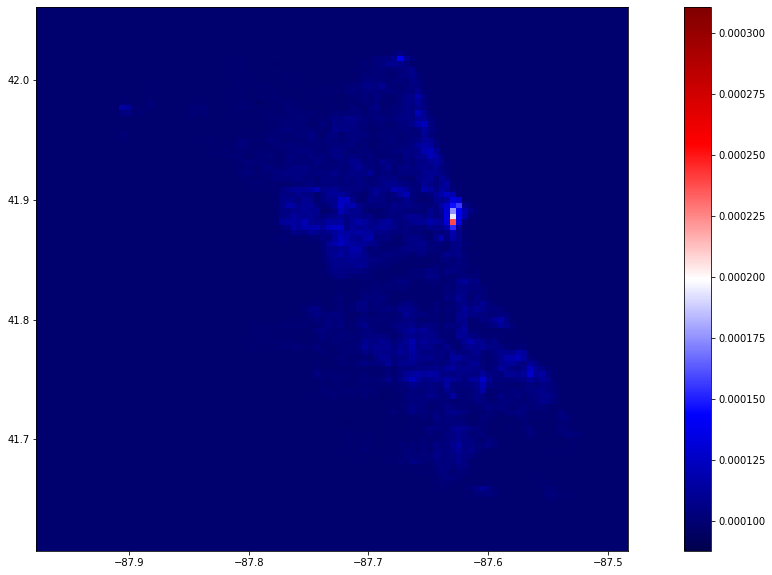

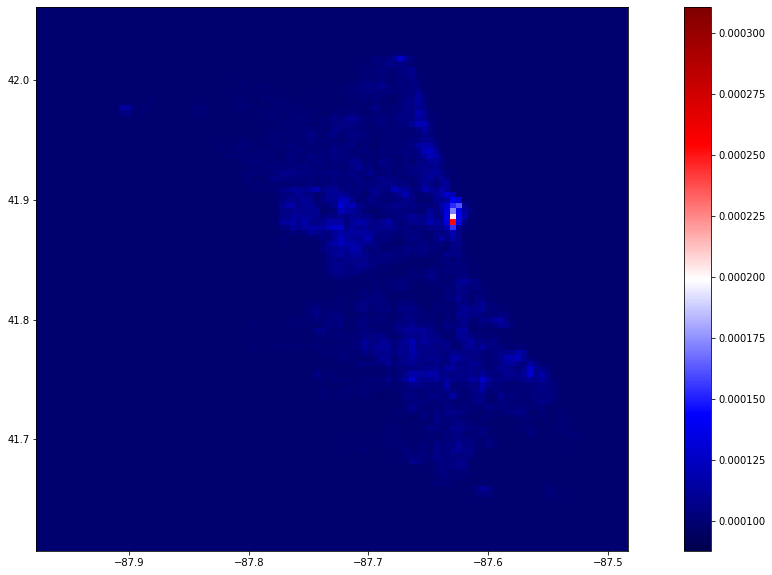

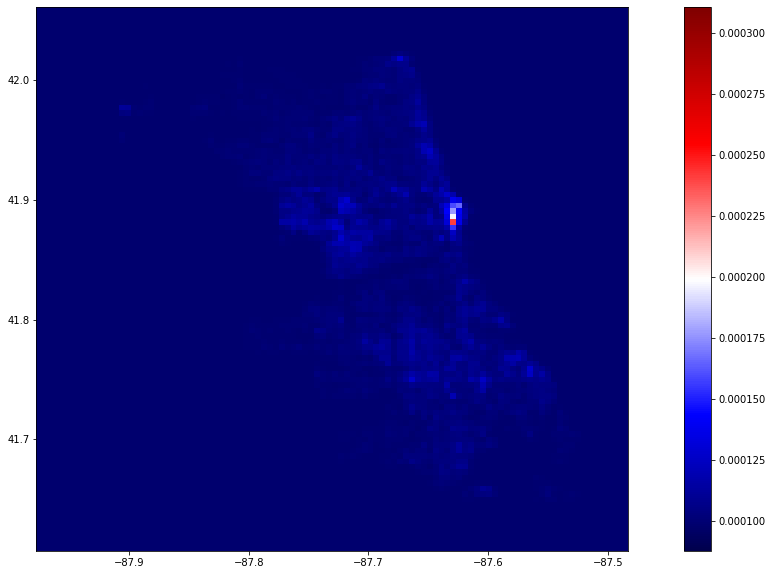

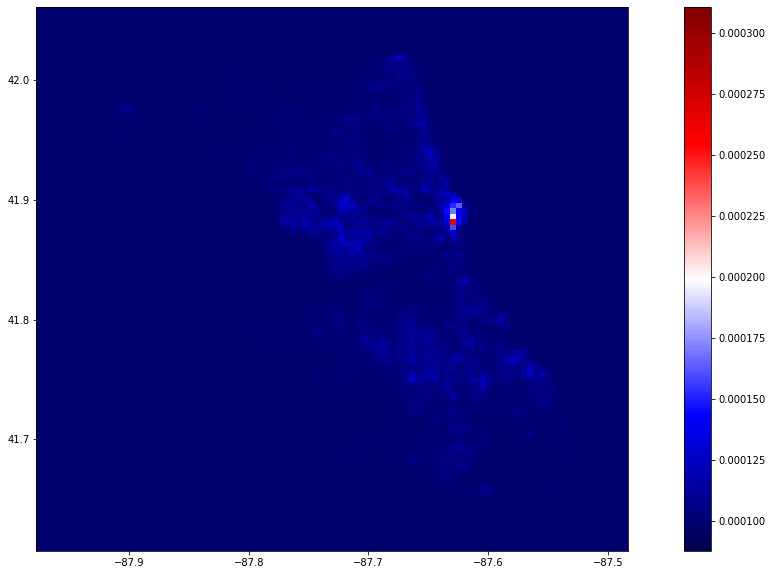

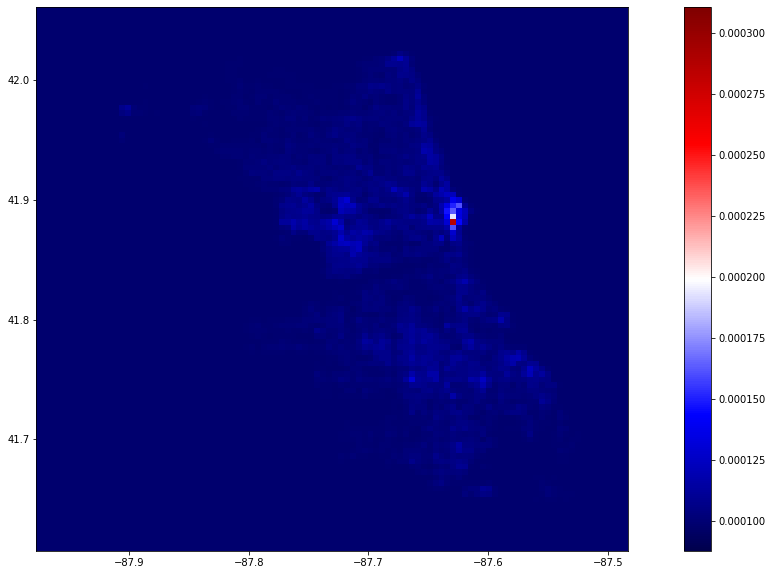

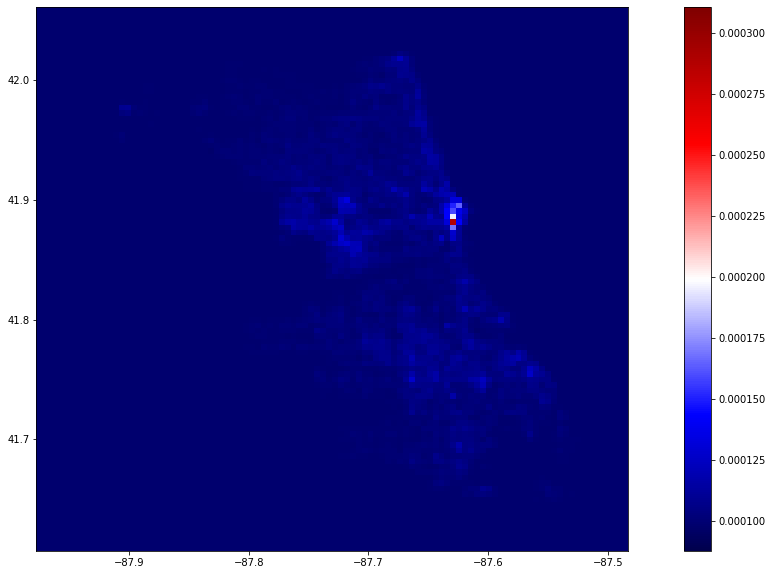

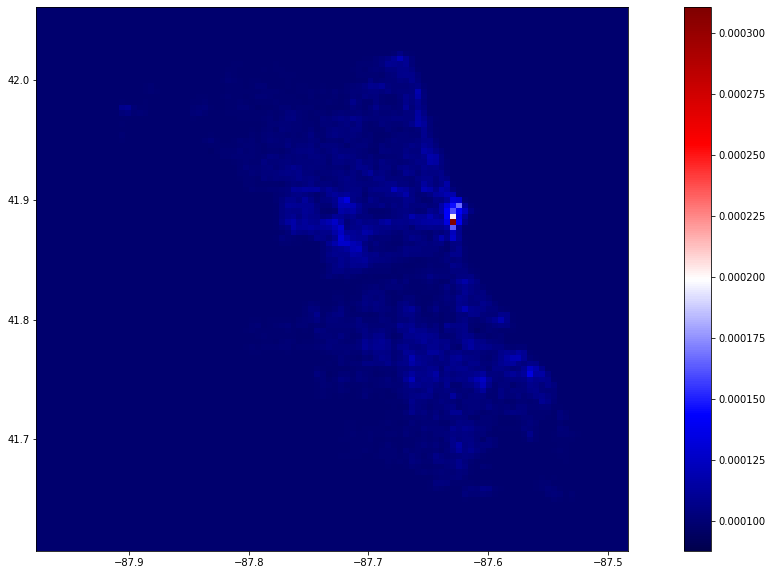

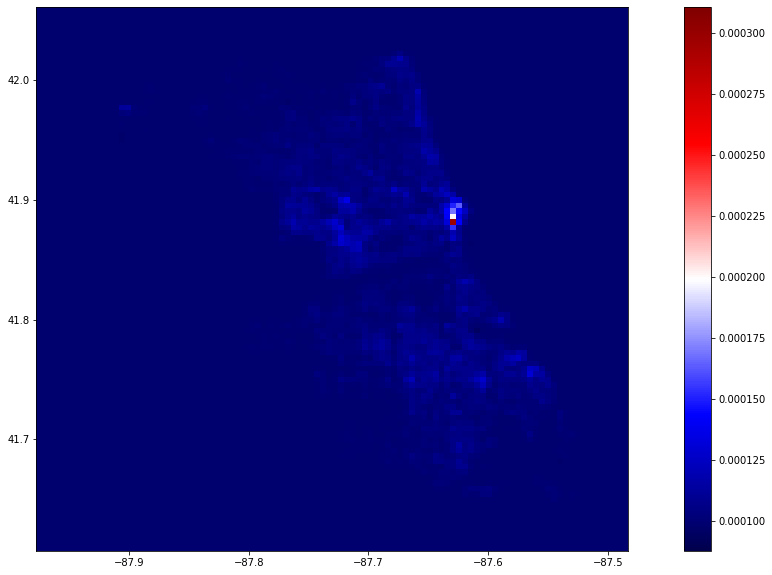

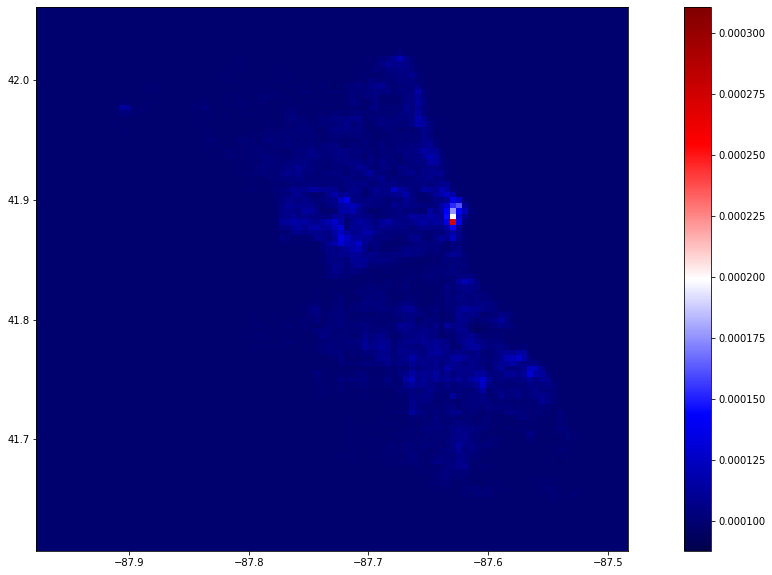

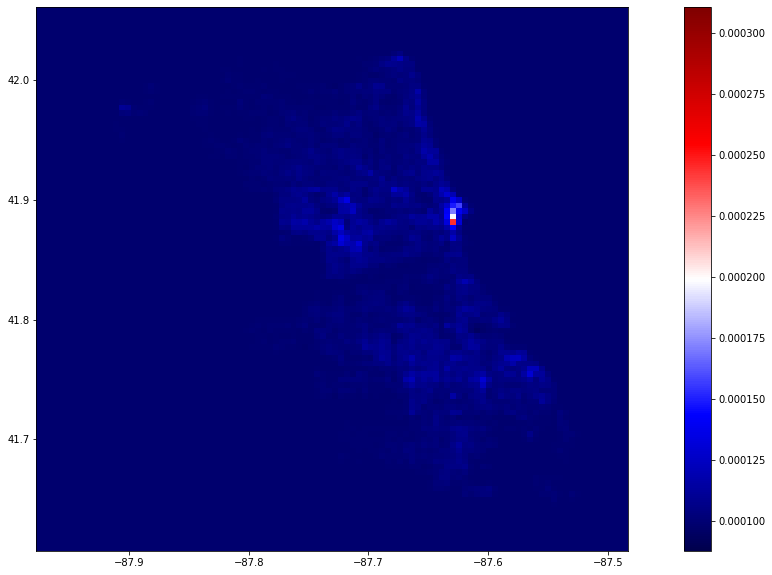

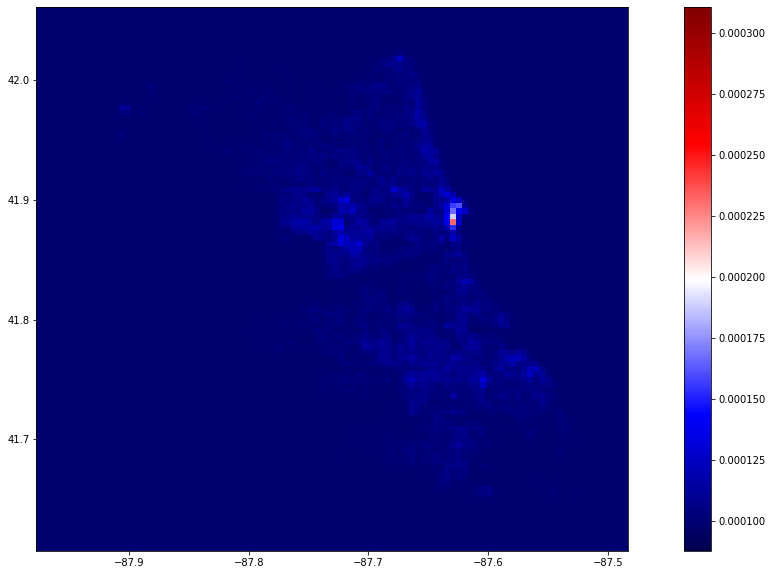

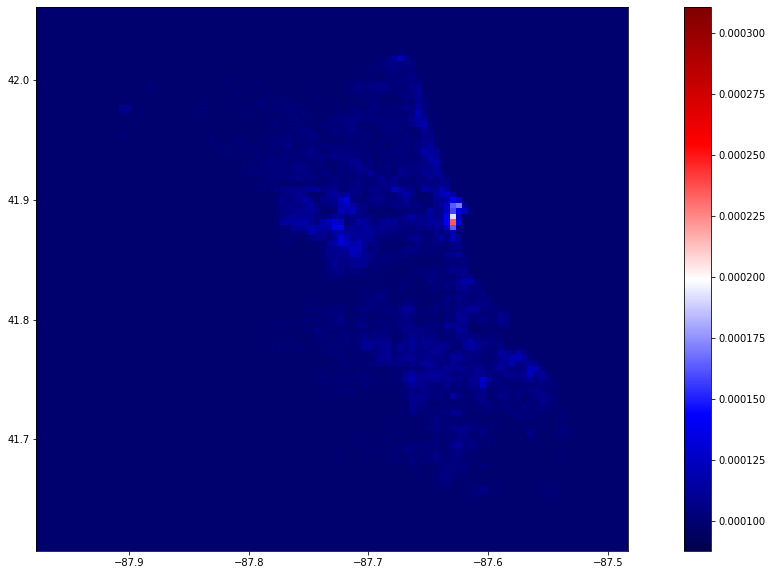

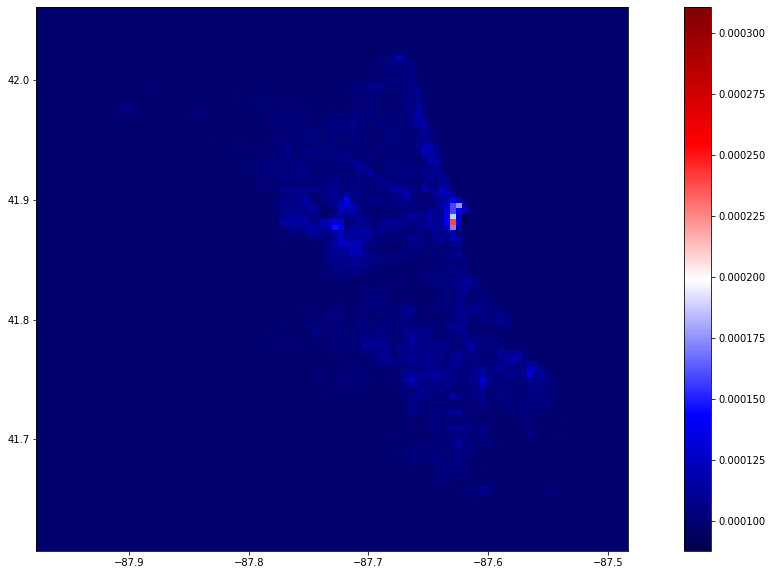

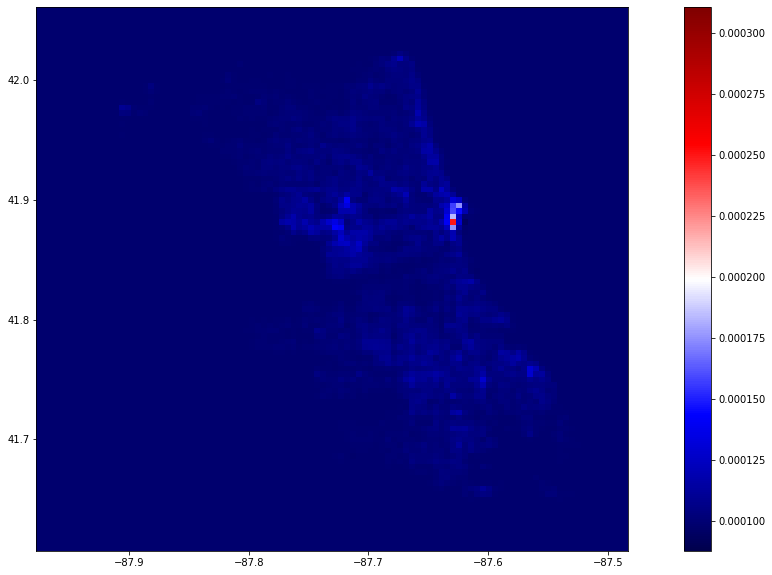

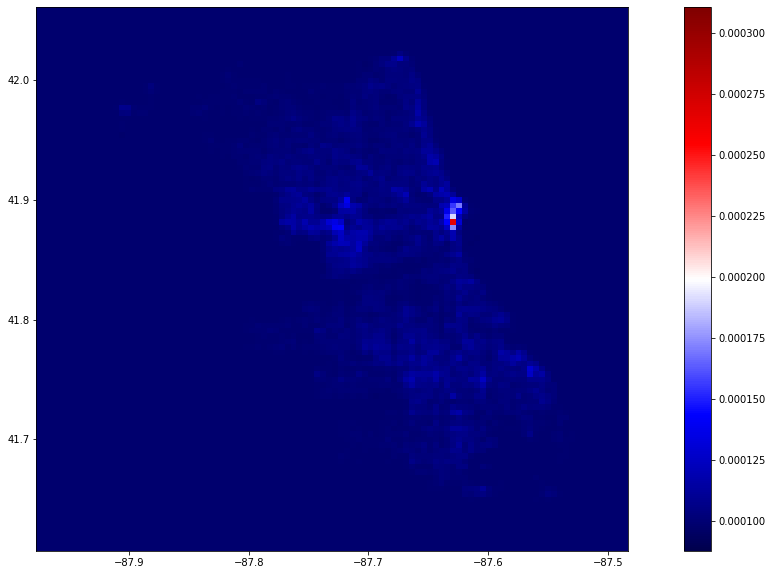

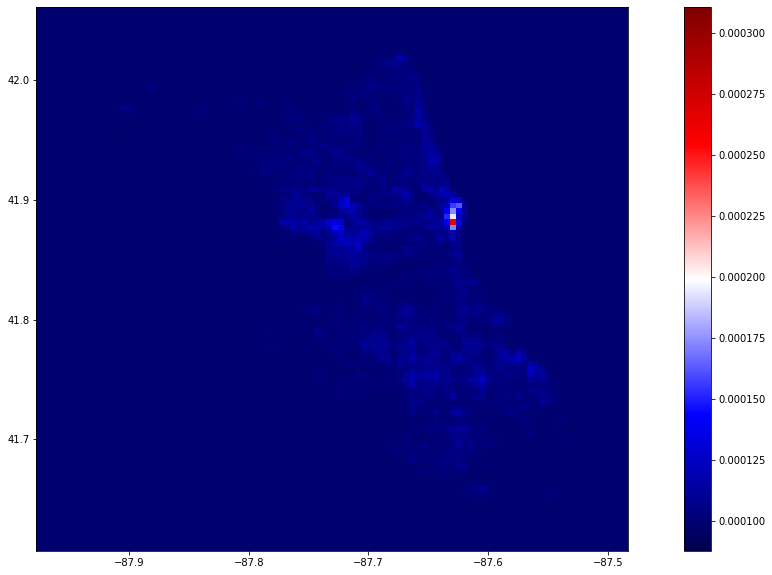

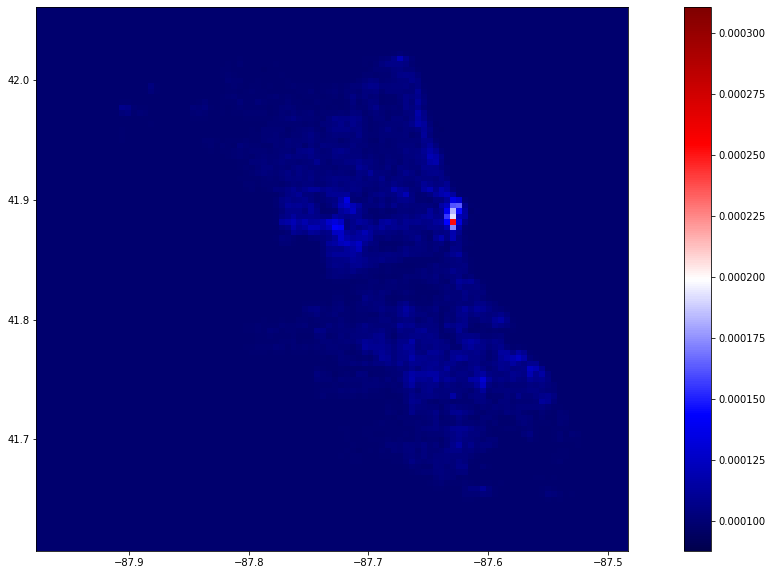

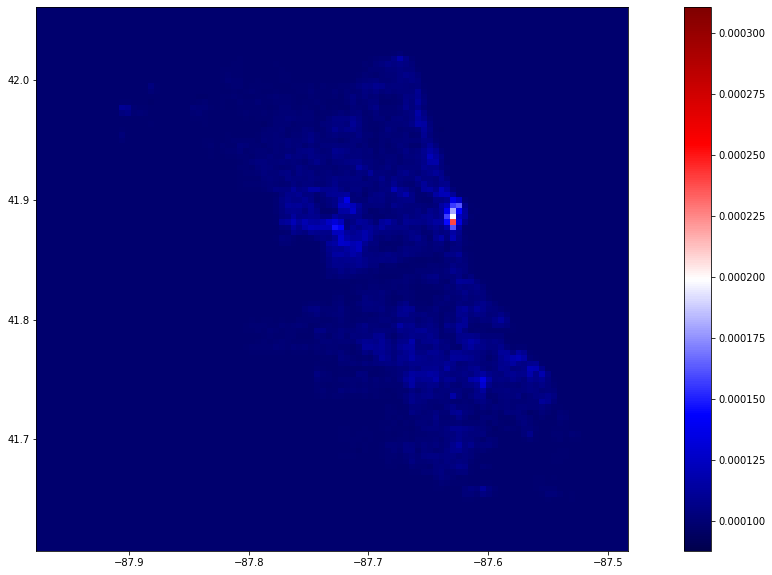

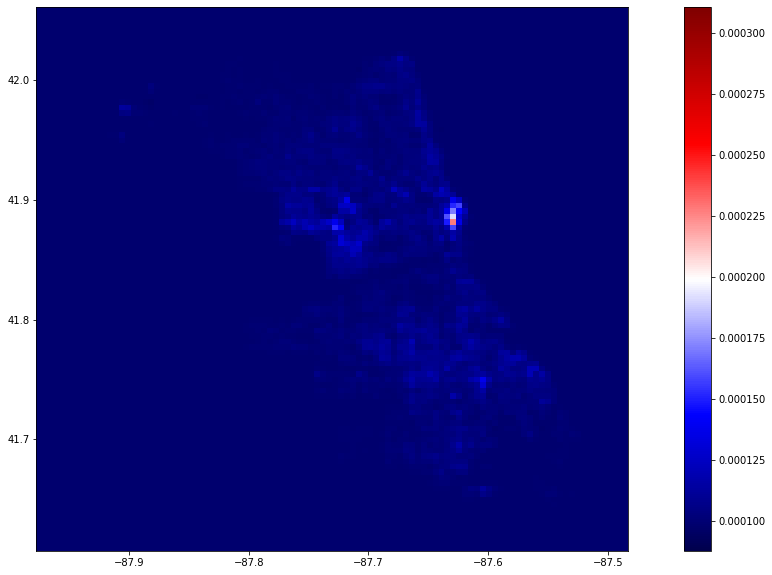

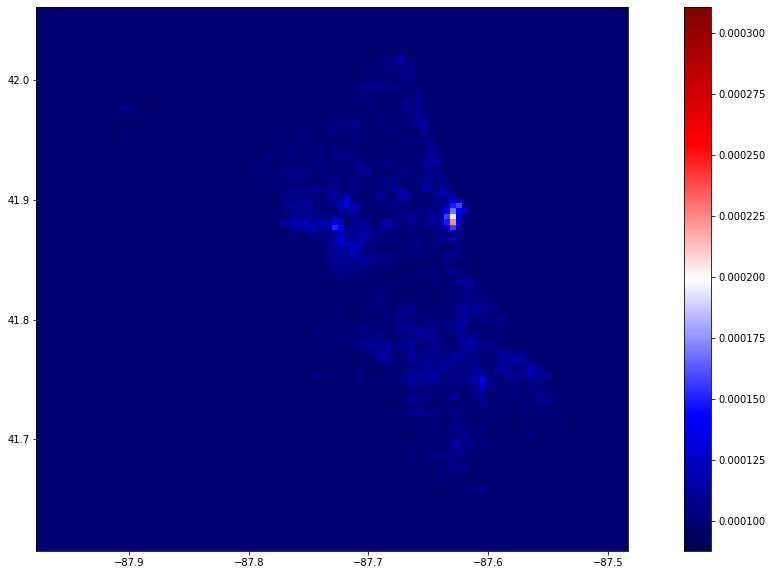

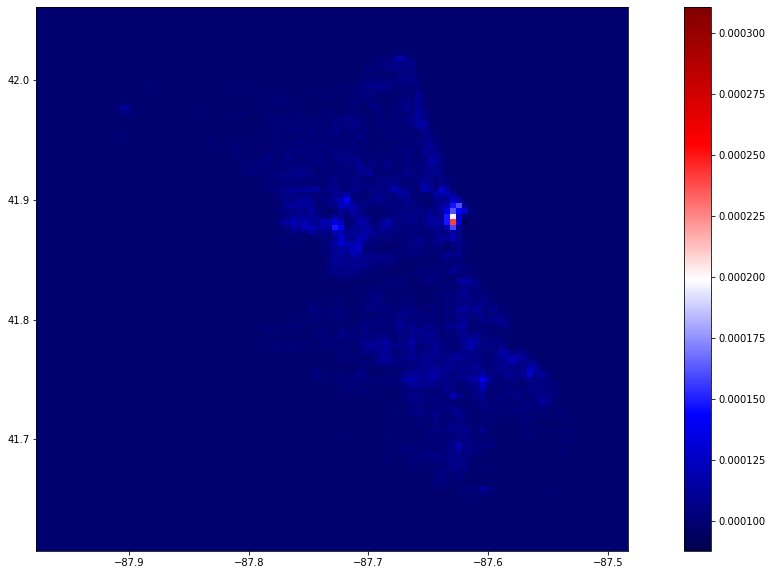

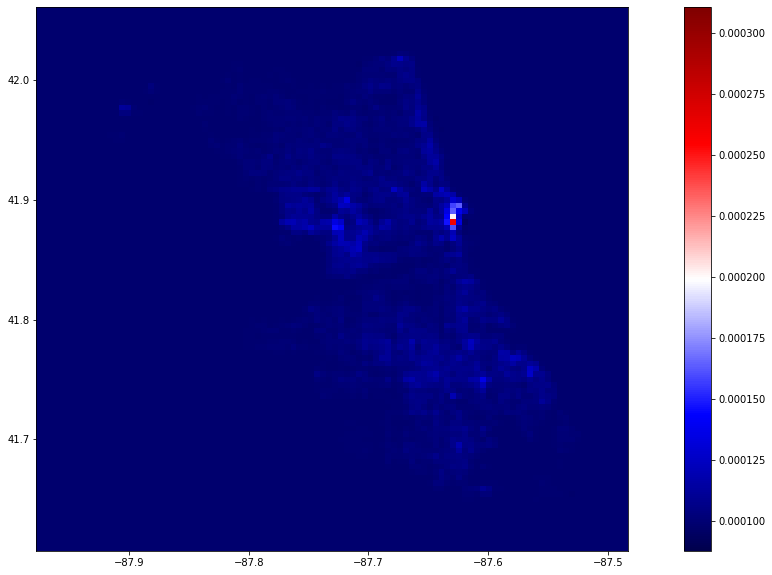

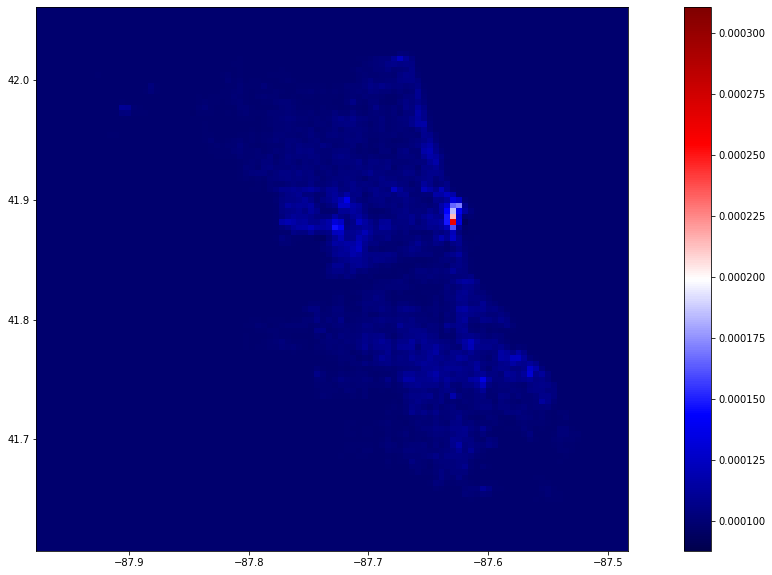

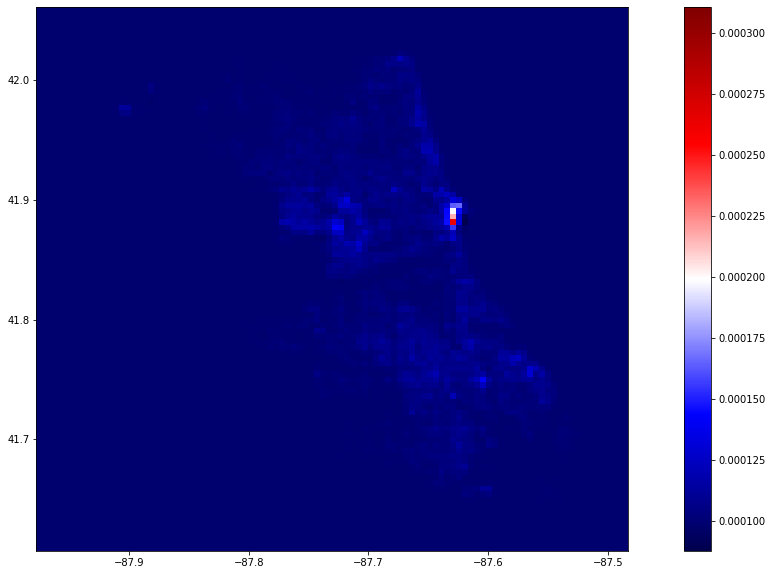

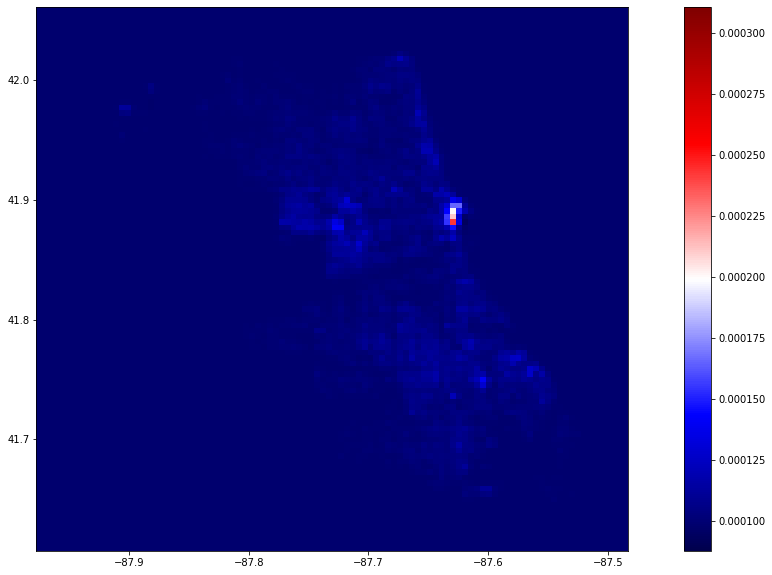

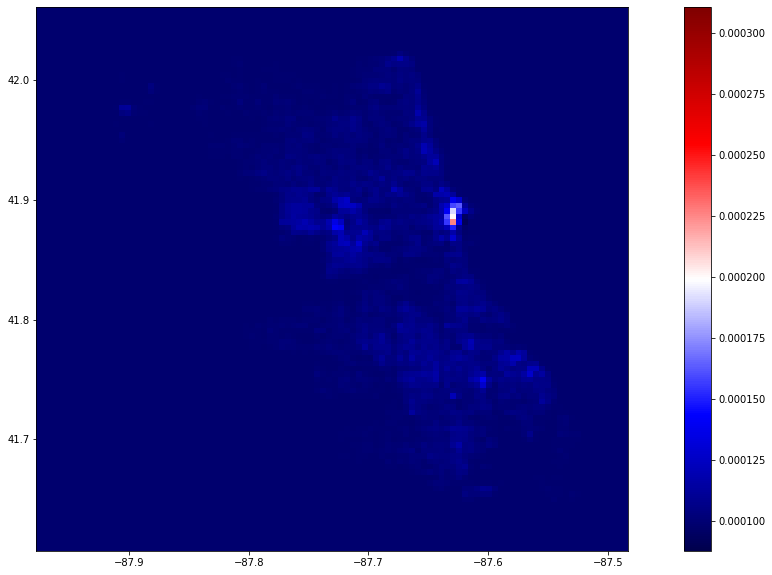

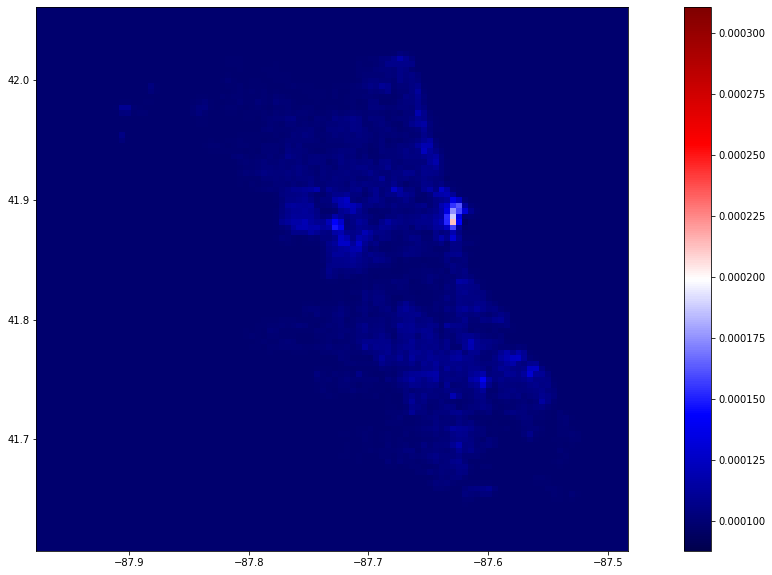

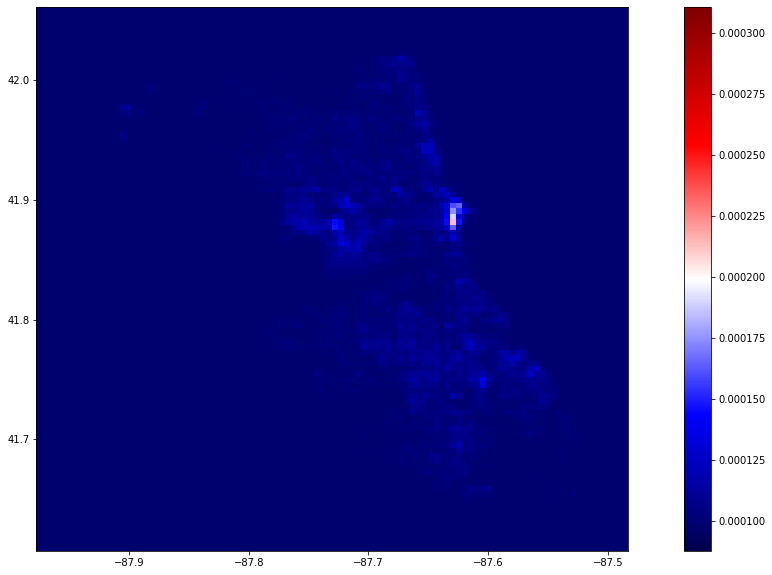

In [52]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

## TimeDistributed attention + attention on time

In [147]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh')(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear')(attention1)     ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
print(attention1.shape)
timeDist2 = TimeDistributed(Dense(1000))(attention1)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units/10, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(100, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2

model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


(None, 52, 10000)
Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_13 (TimeDistri (None, 52, 10000)    0           input_6[0][0]                    
__________________________________________________________________________________________________
permute_18 (Permute)            (None, 10000, 52)    0           time_distributed_13[0][0]        
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 10000, 52)    2756        permute_18[0][0]                 
_______________________________

In [40]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

#### We peak at trained attention1 on the image layer

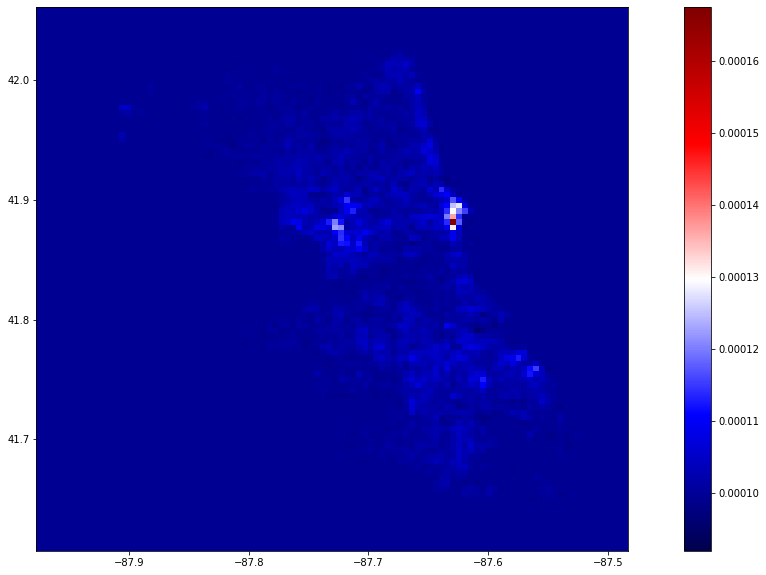

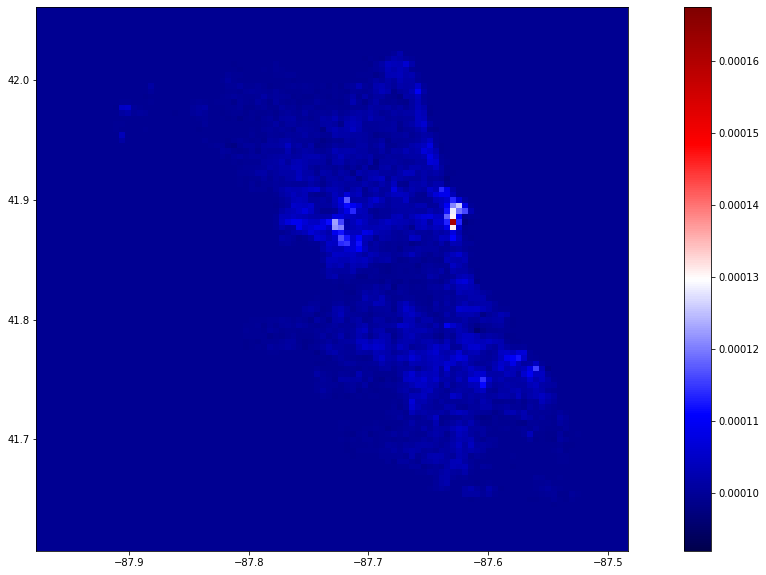

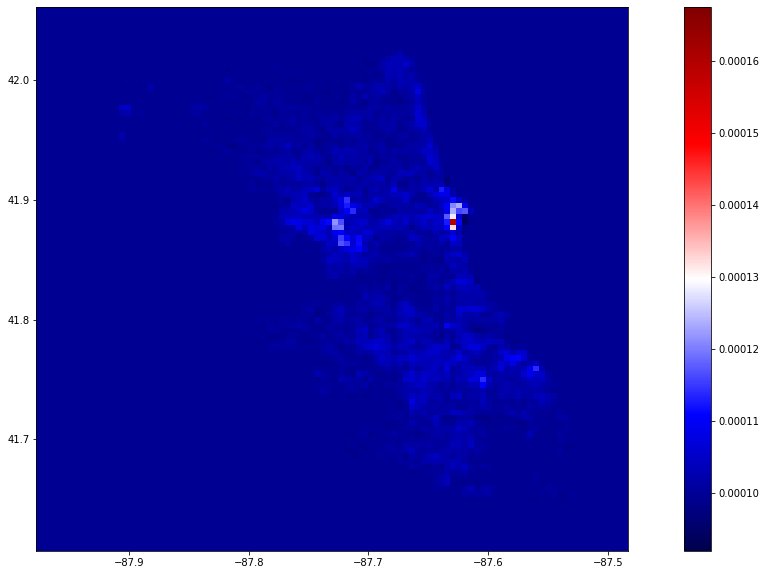

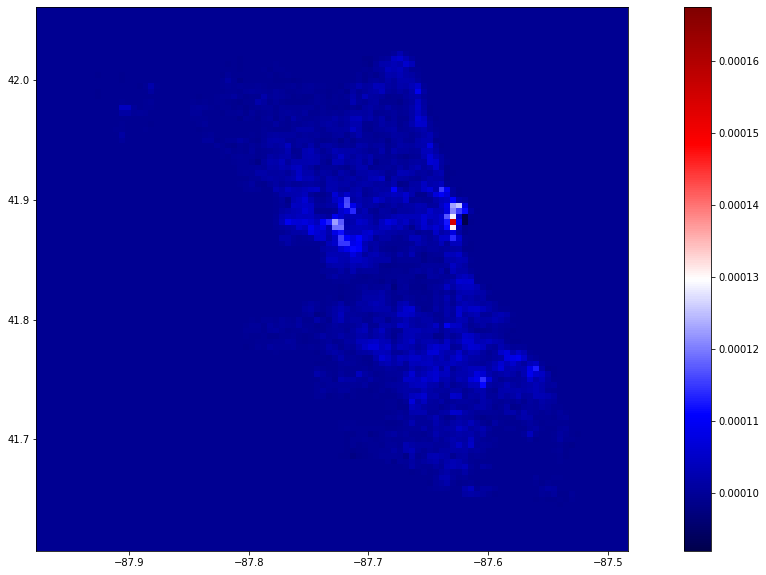

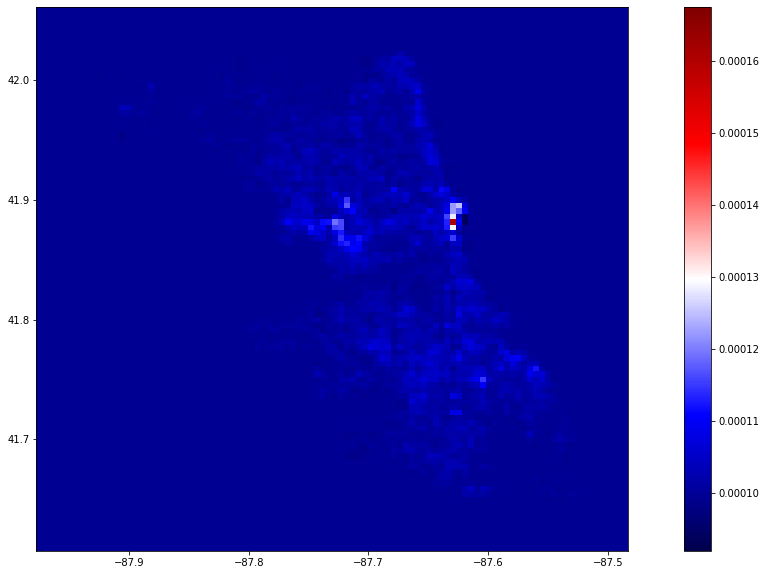

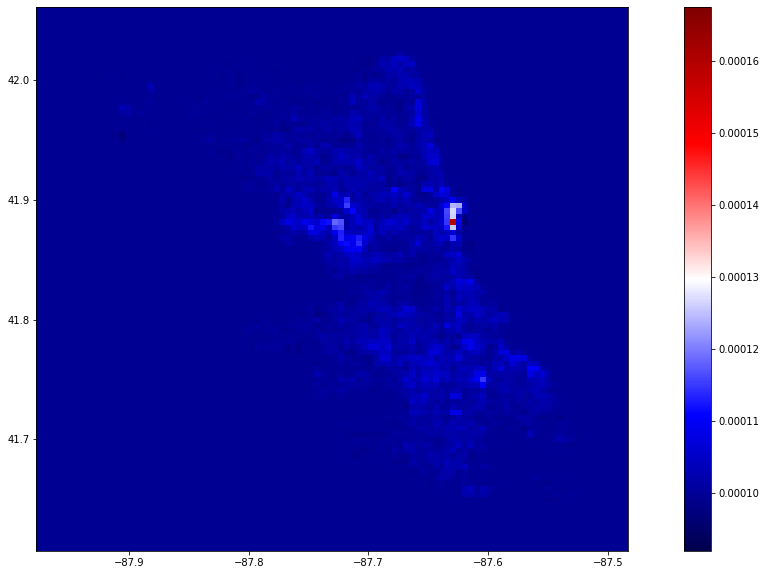

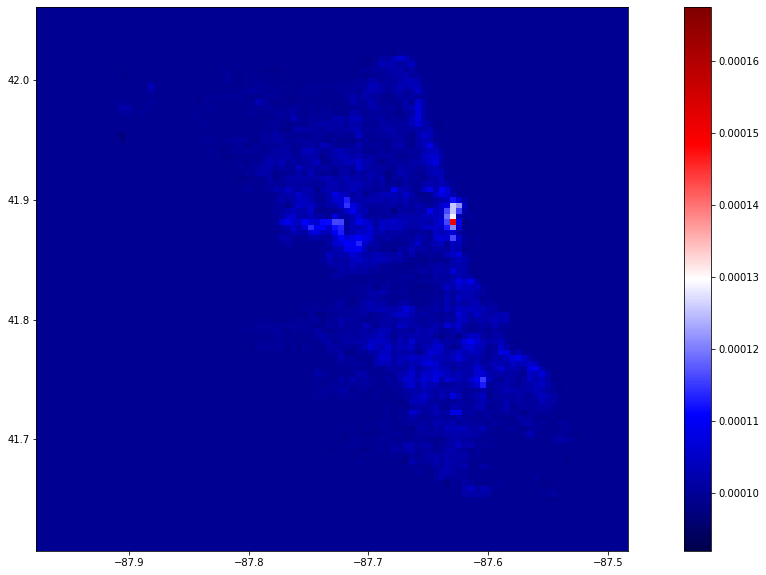

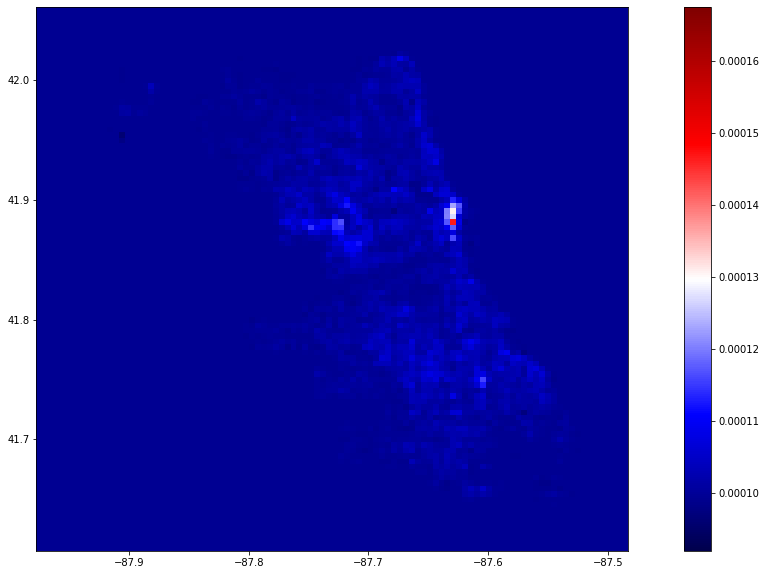

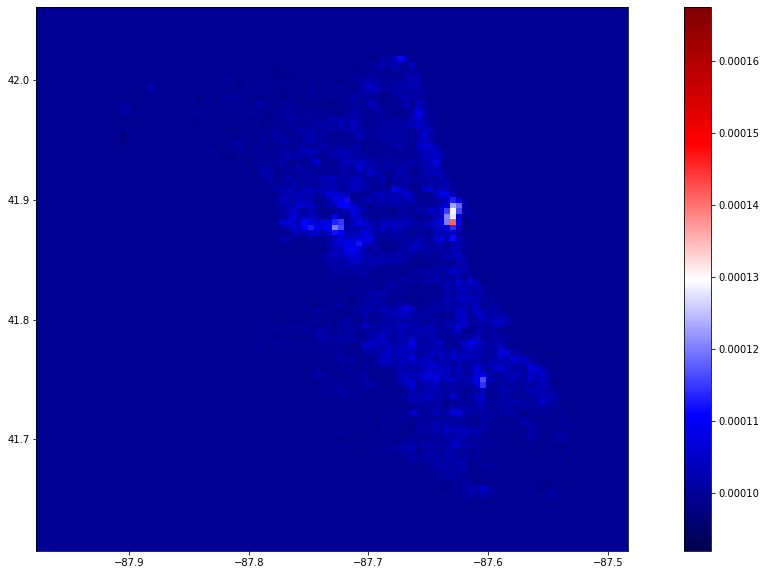

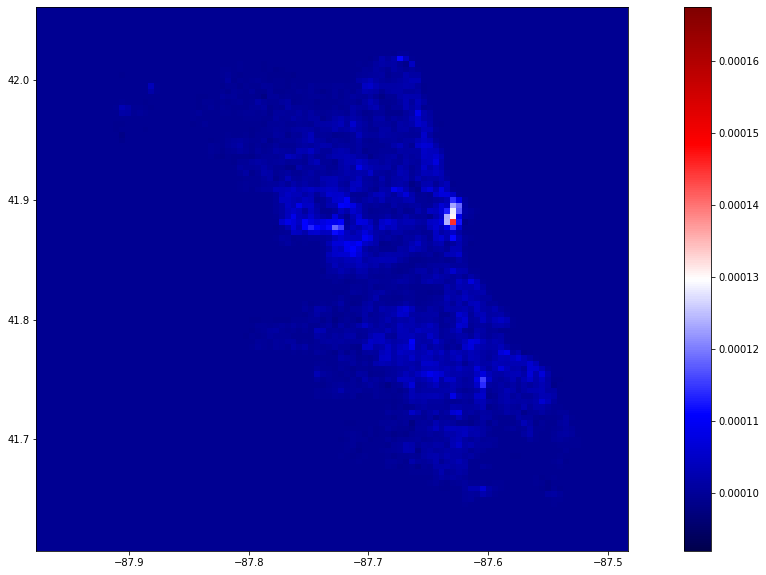

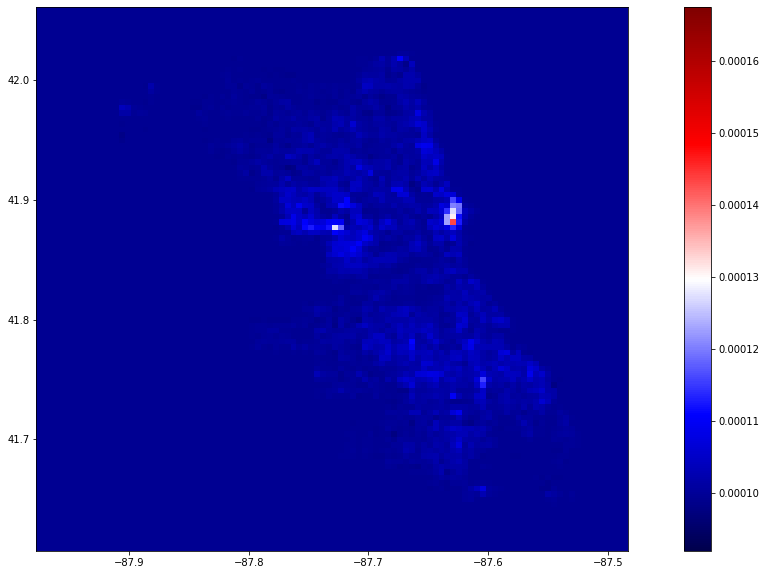

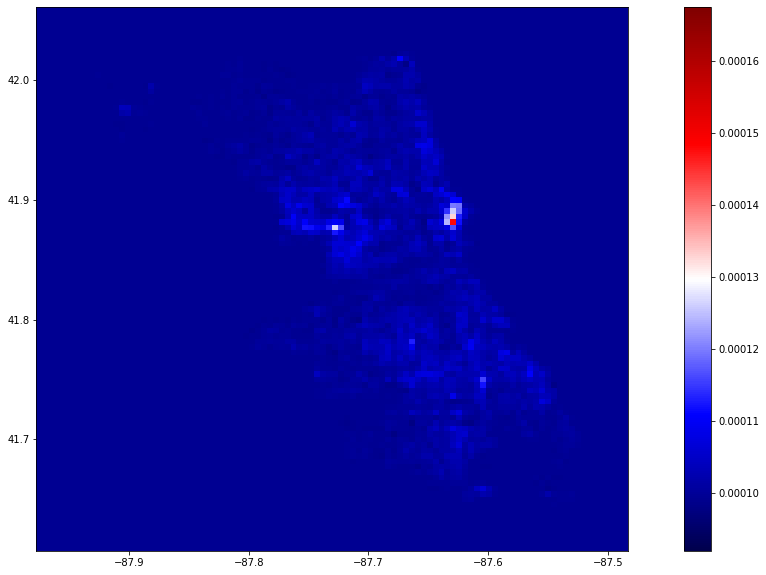

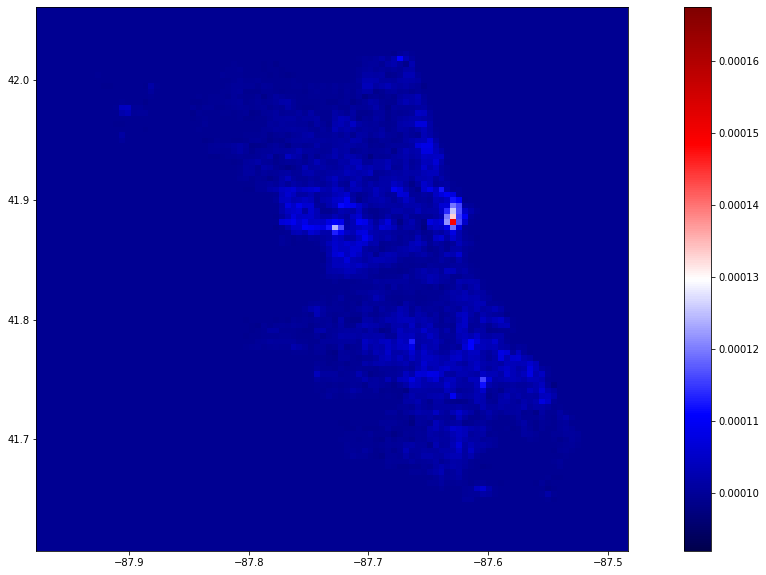

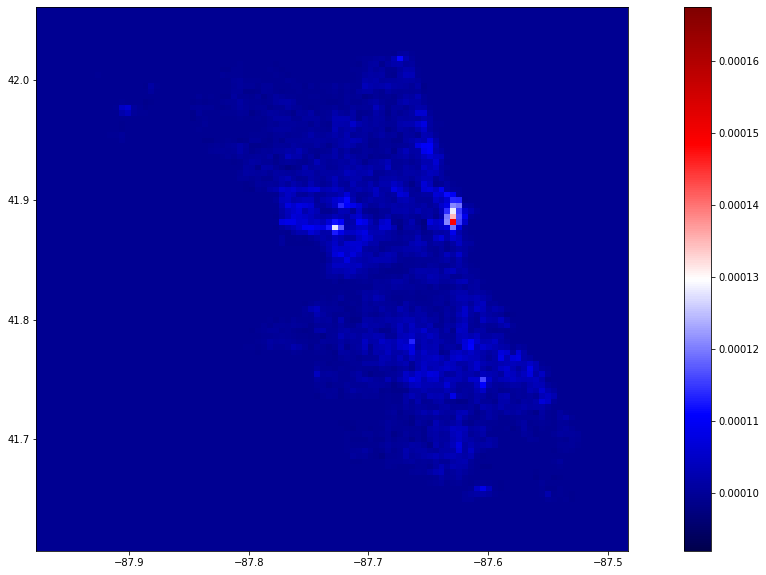

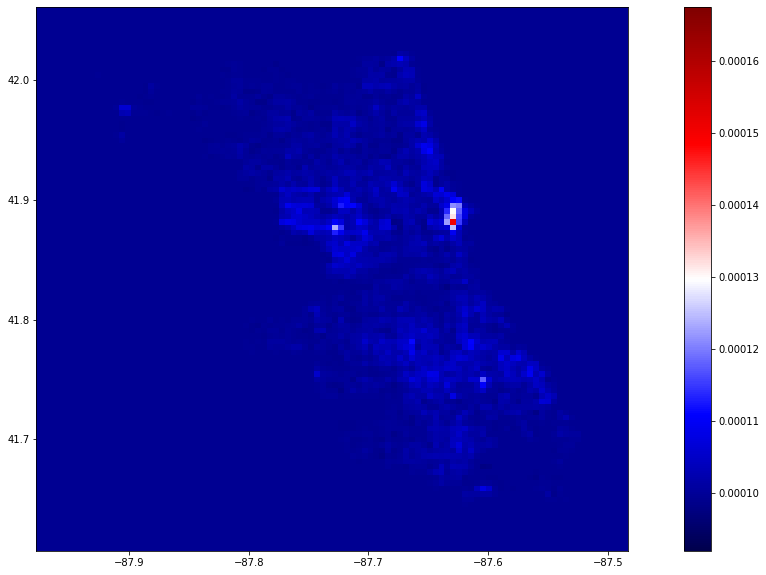

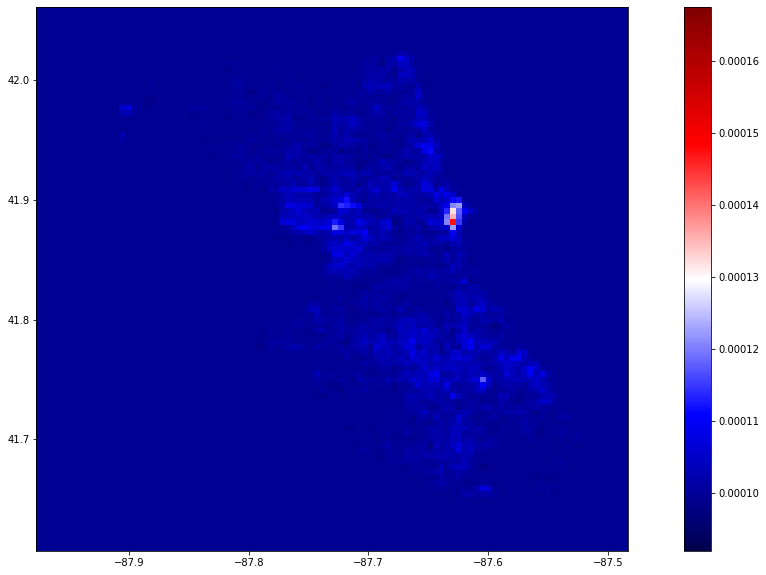

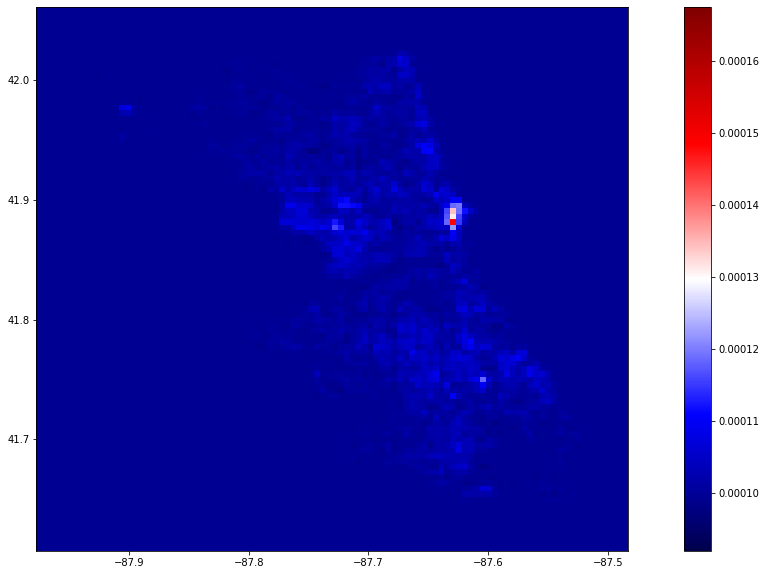

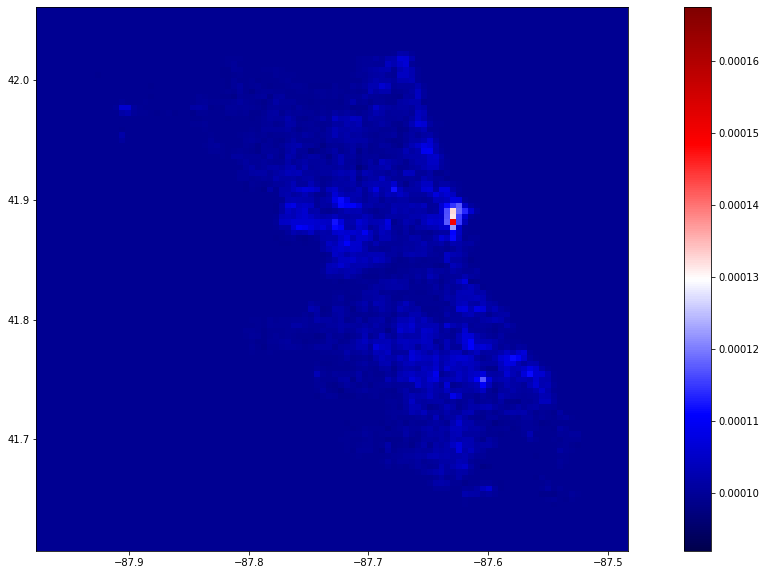

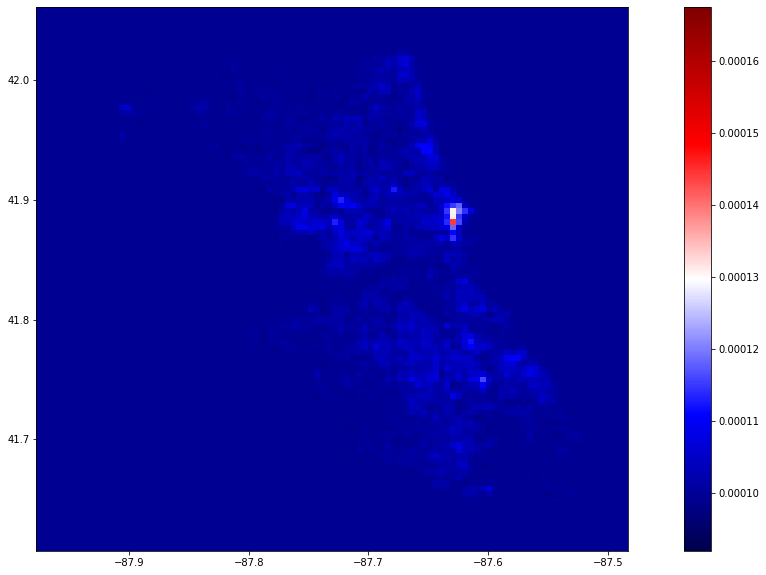

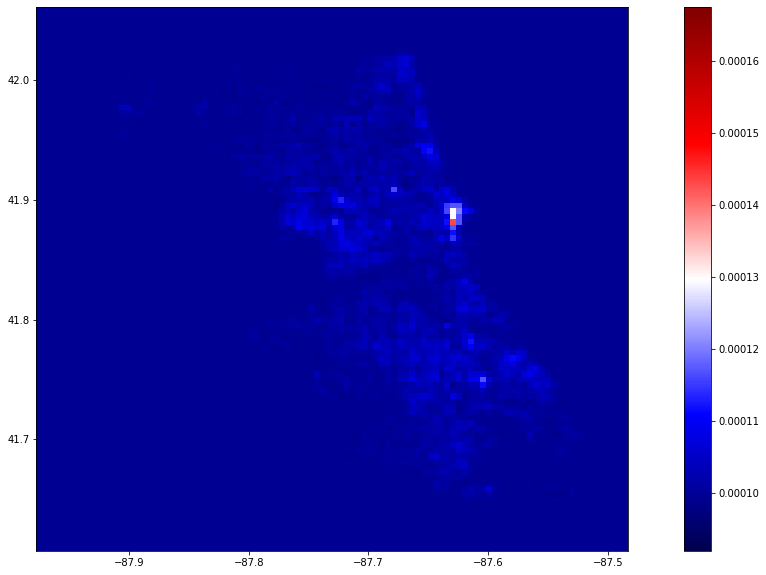

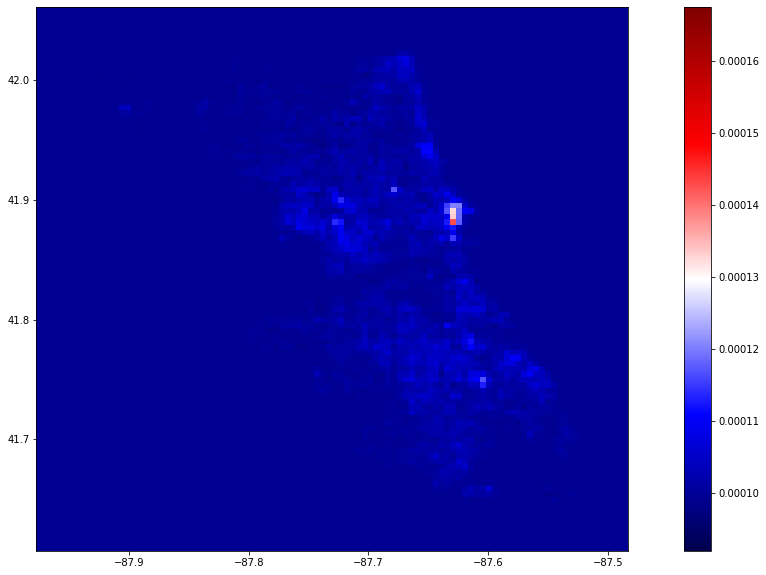

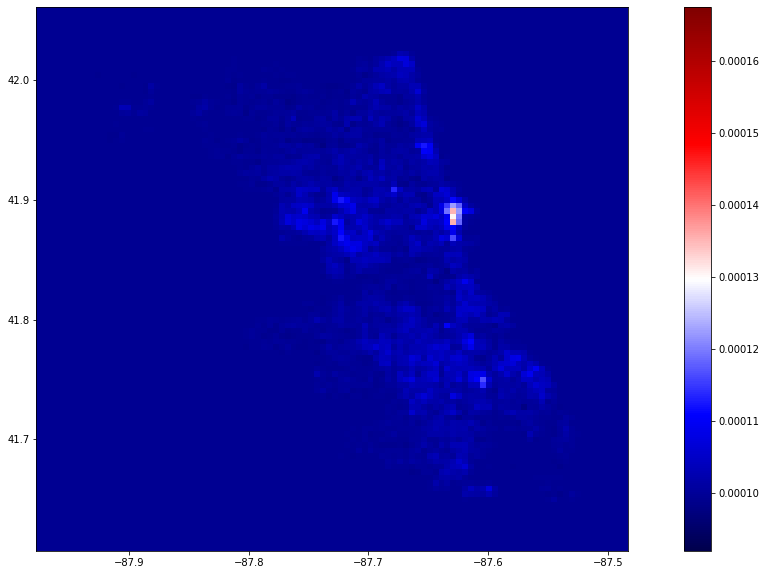

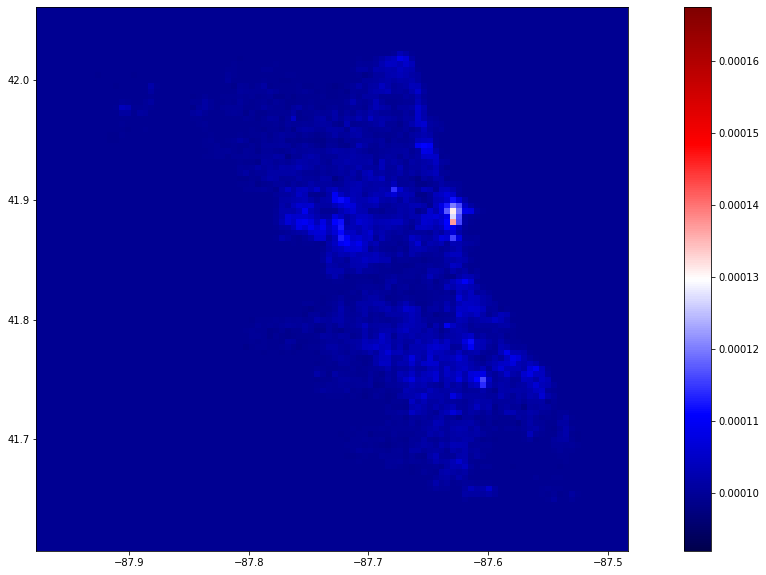

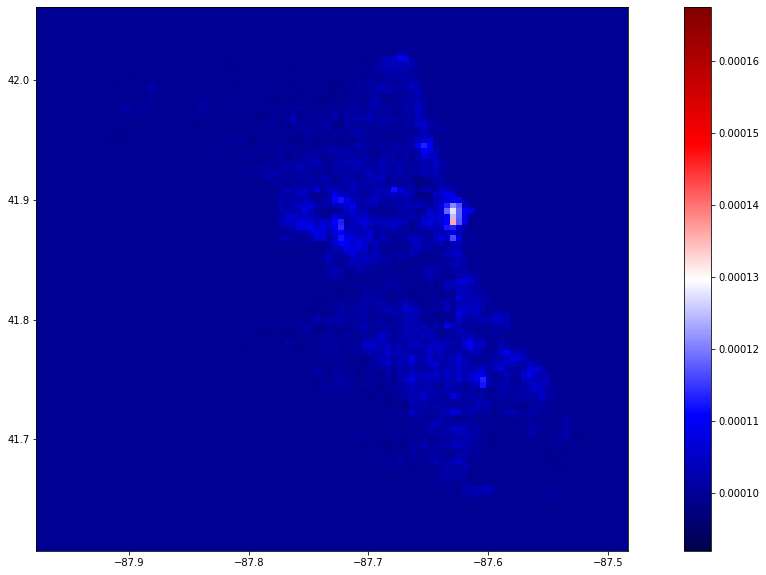

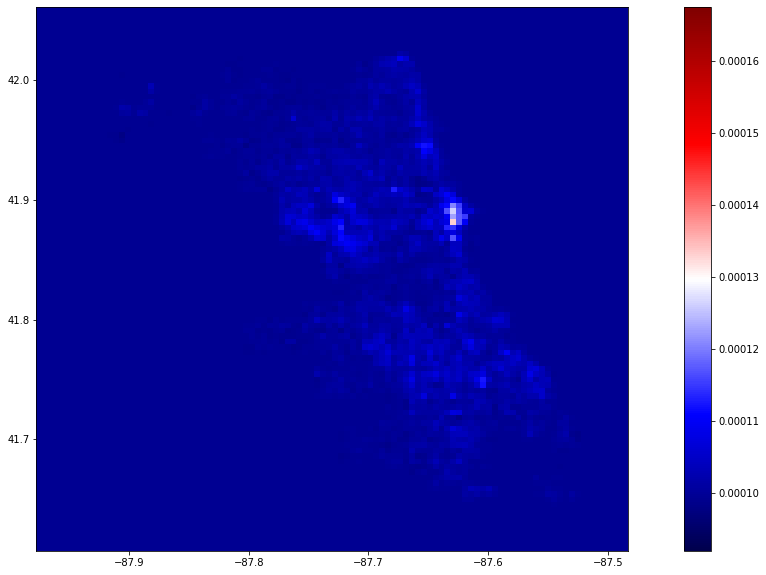

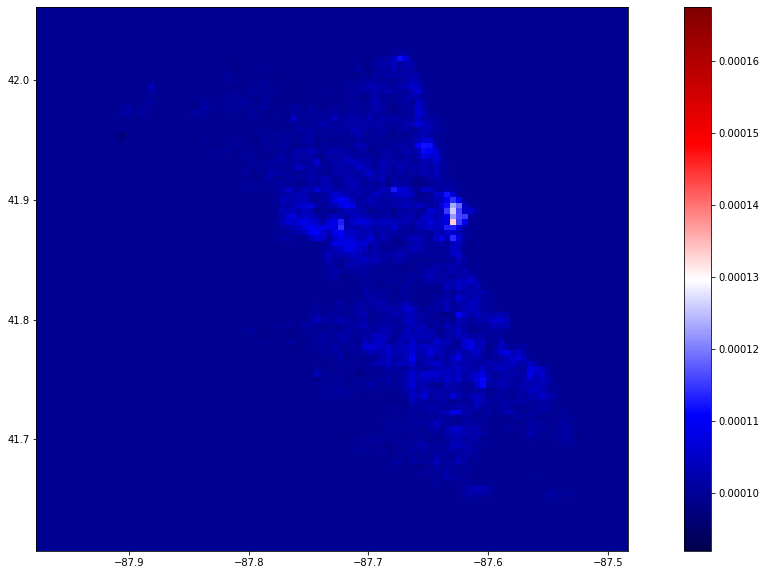

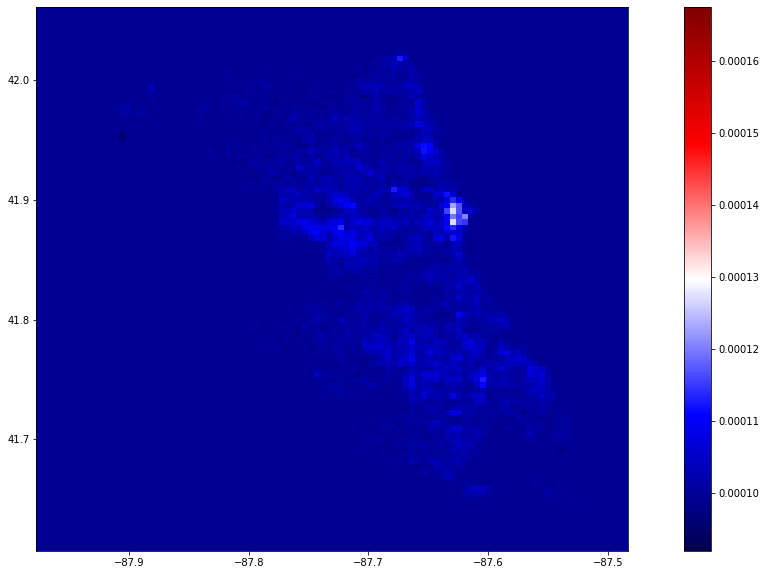

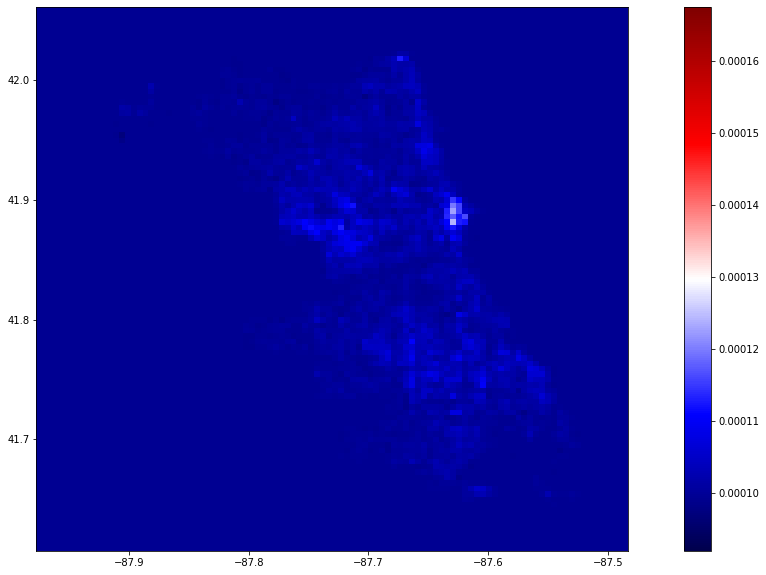

In [41]:
vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

In [44]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

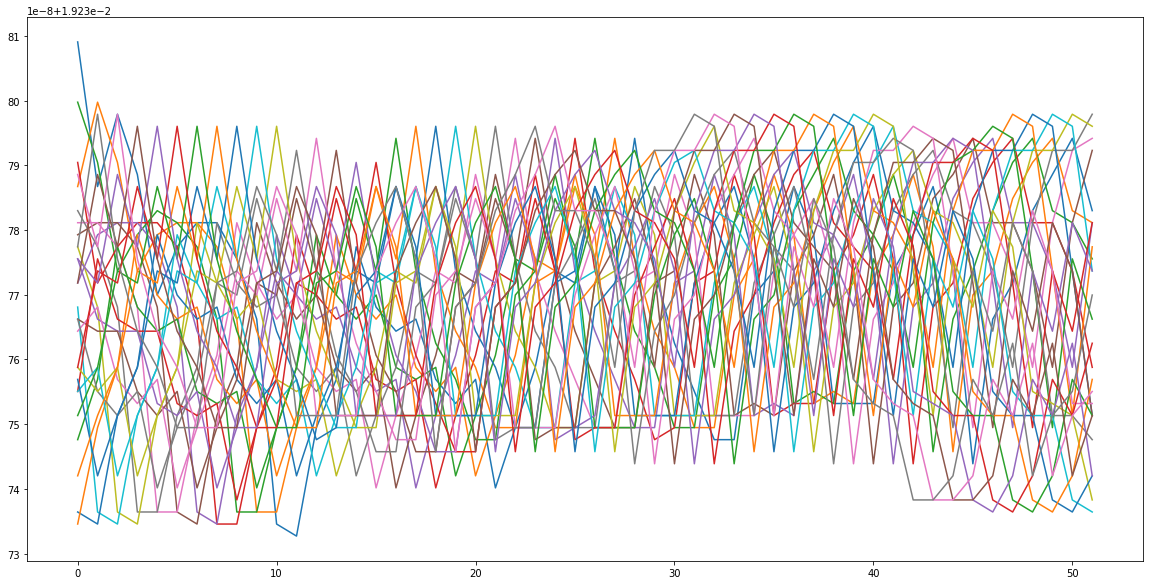

In [45]:
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## 2 Headed: Attention Pixel + Attention Timestep 

In [114]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

timeDist2 = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(100), name="compressor")(timeDist2)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
attention2 = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer

merge = Concatenate()([attention1, attention2])

attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(merge)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 52, 10000)    0           input_5[0][0]                    
__________________________________________________________________________________________________
permute_14 (Permute)            (None, 10000, 52)    0           time_distributed_10[0][0]        
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 52, 10000)    0           input_5[0][0]                    
_________________________________________________

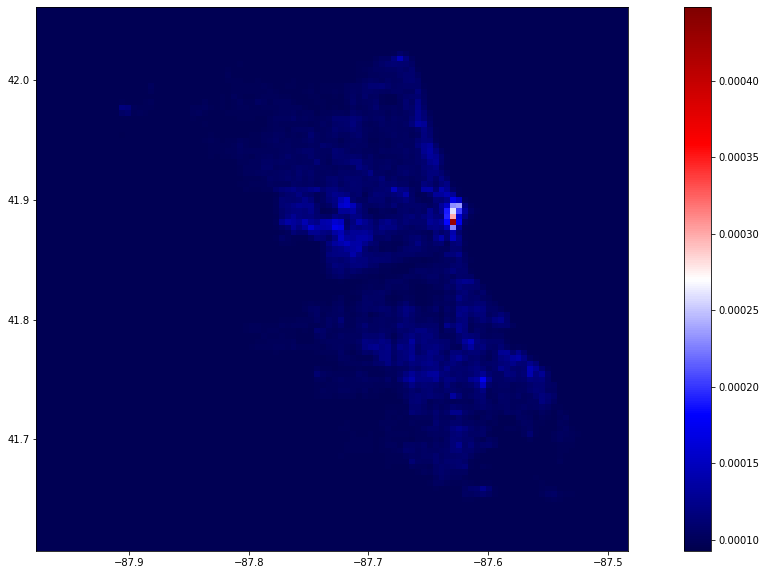

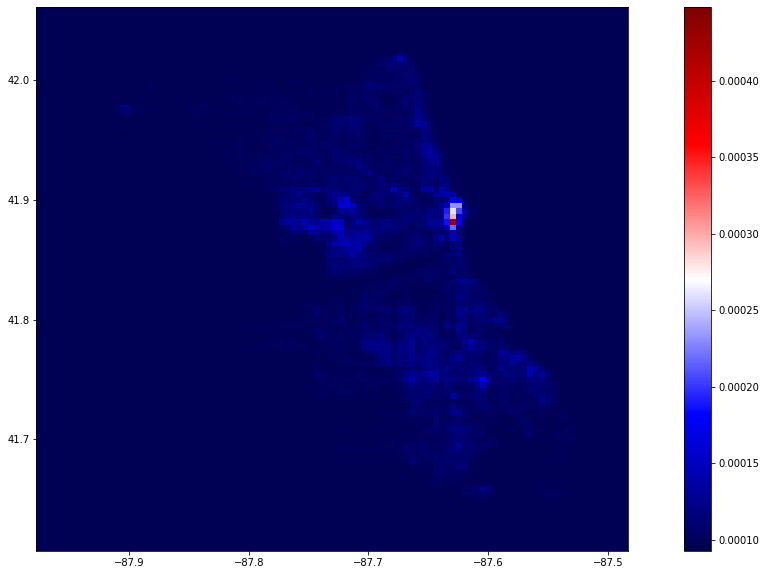

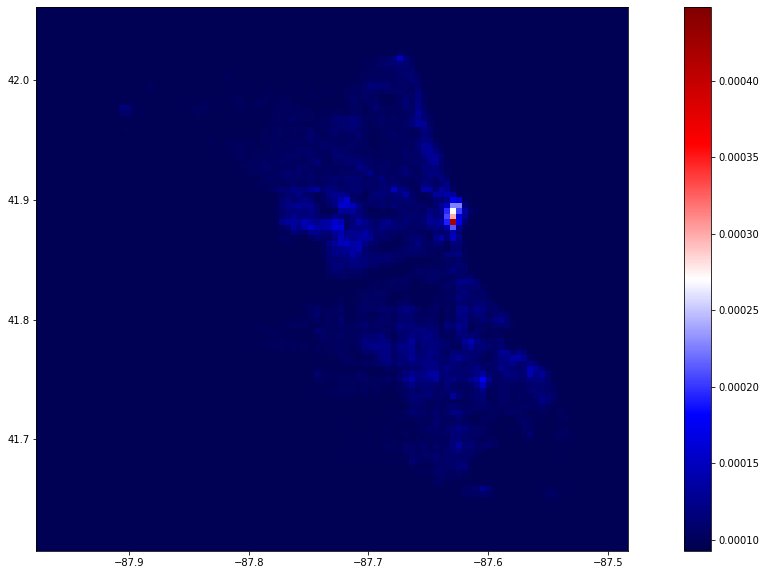

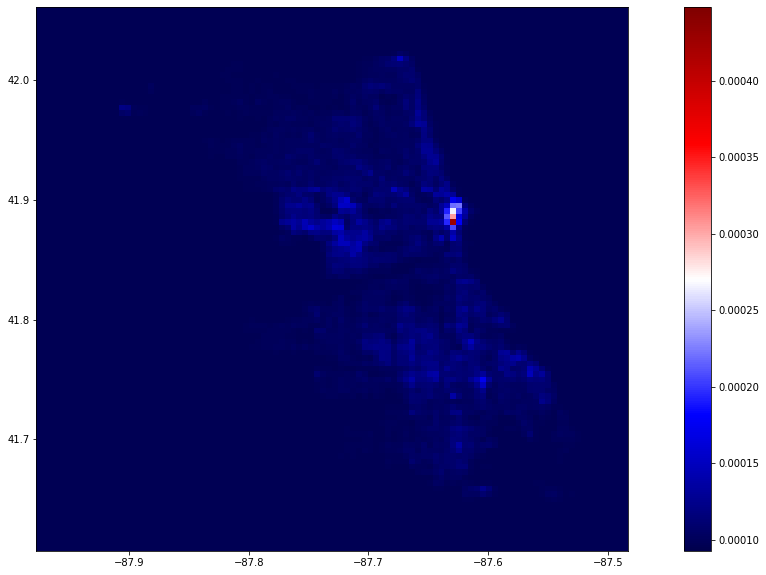

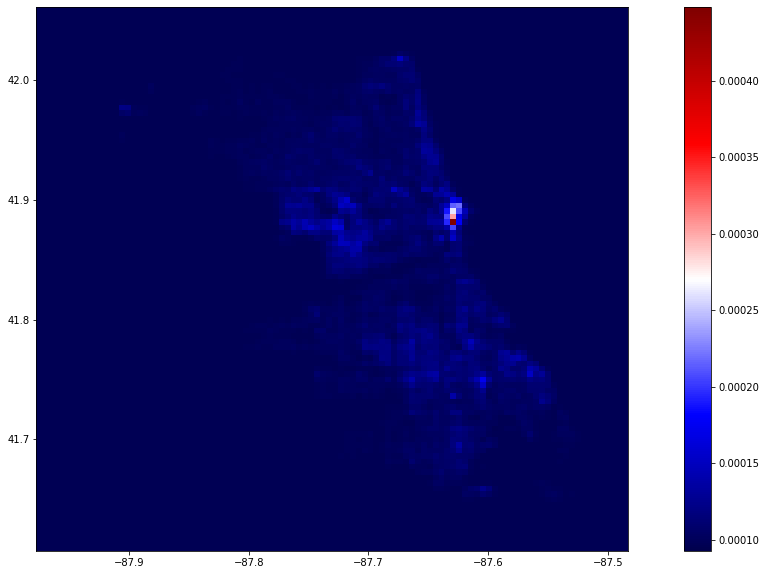

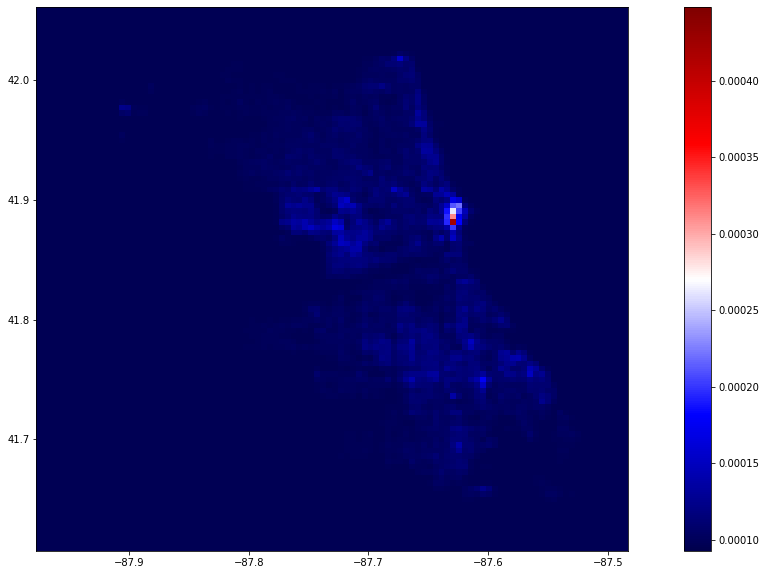

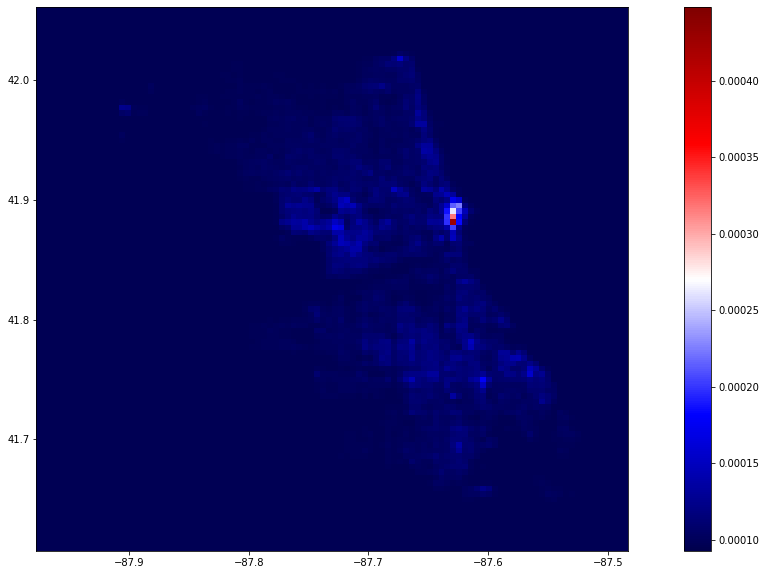

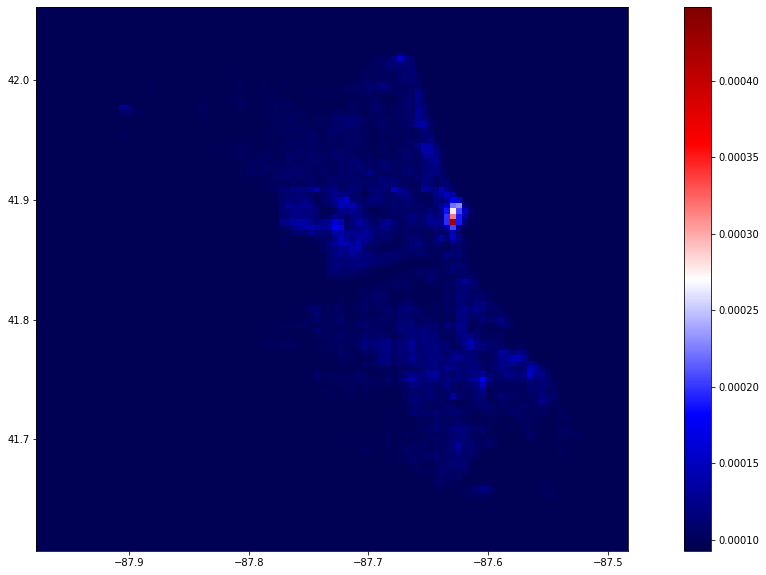

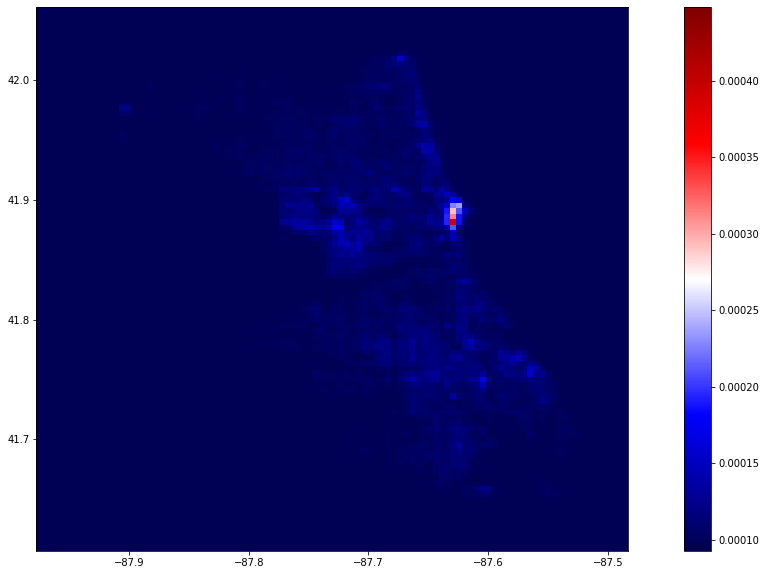

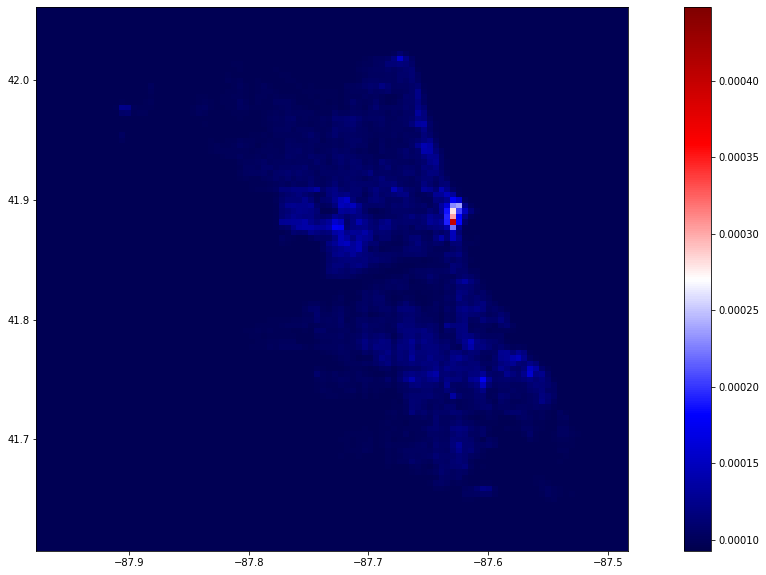

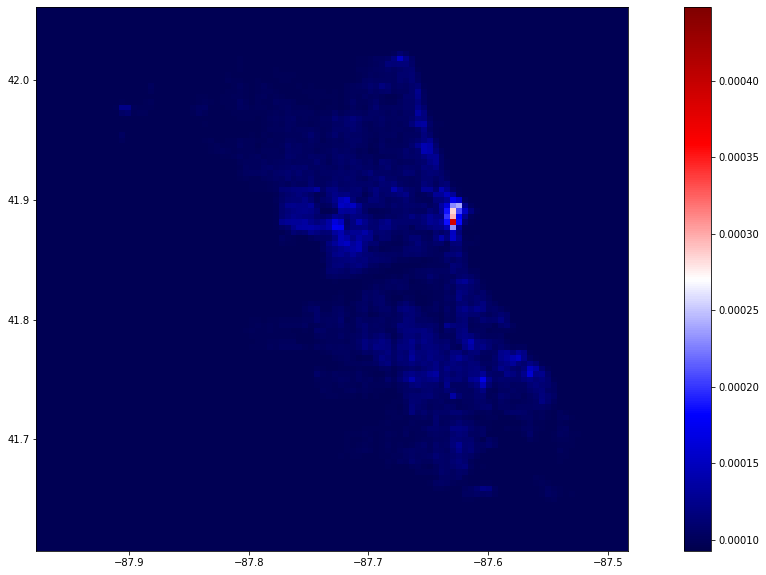

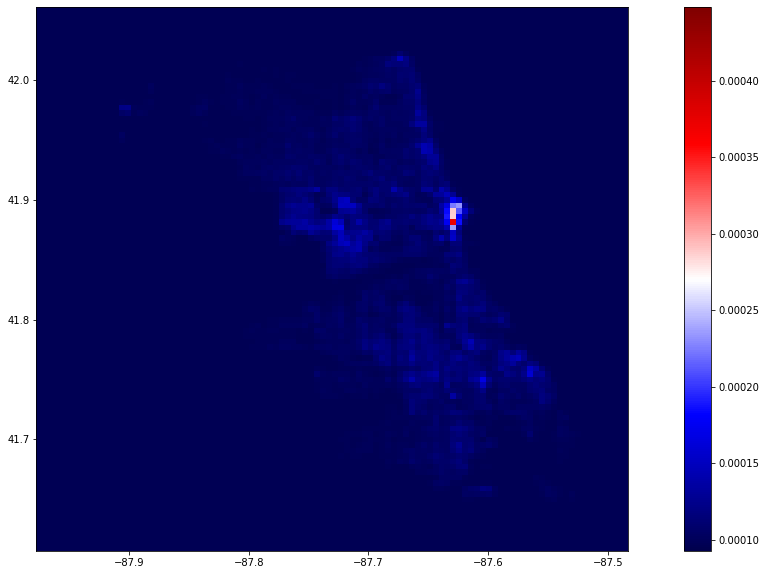

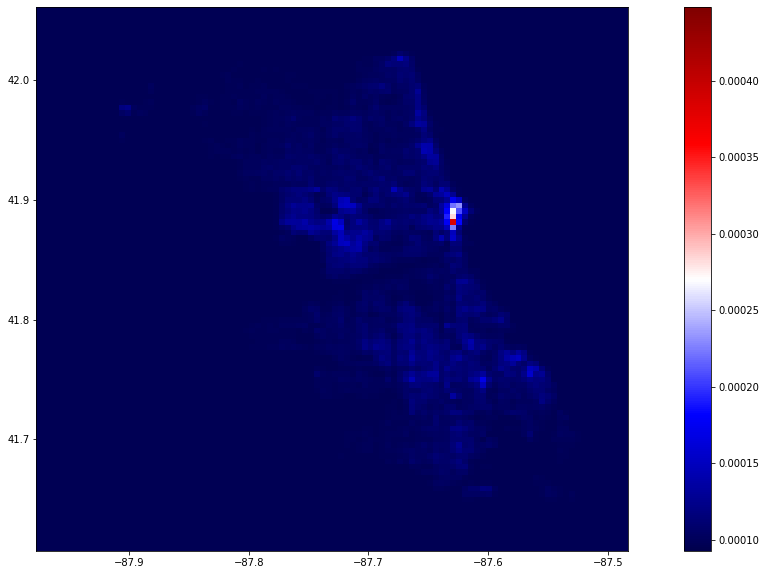

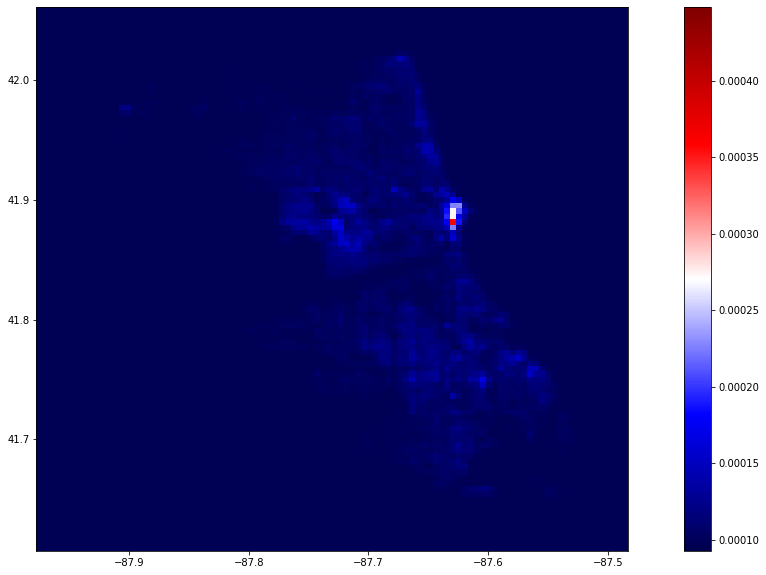

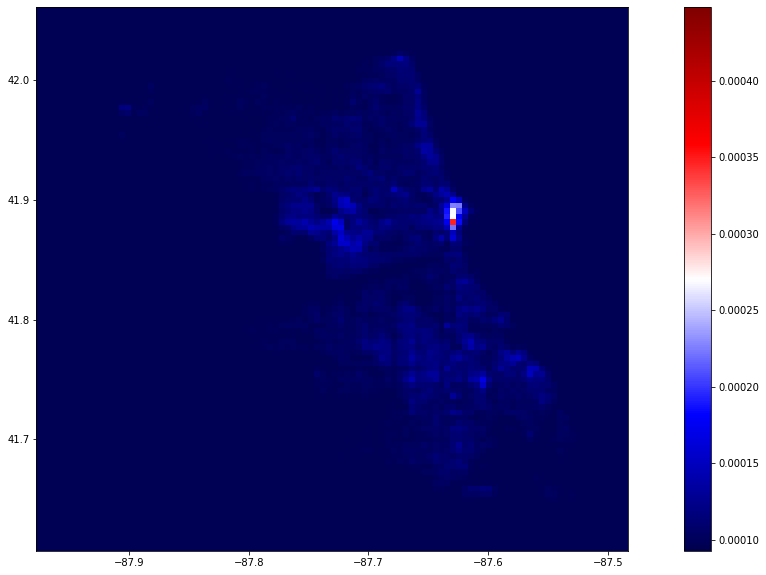

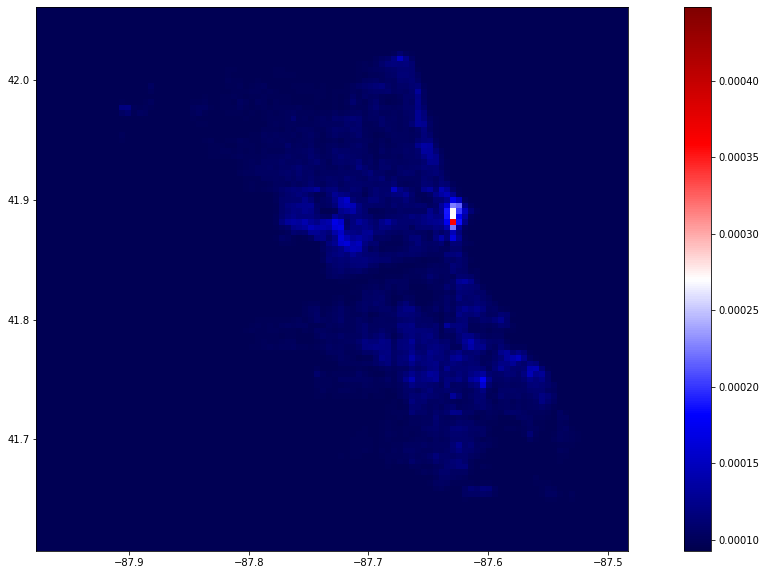

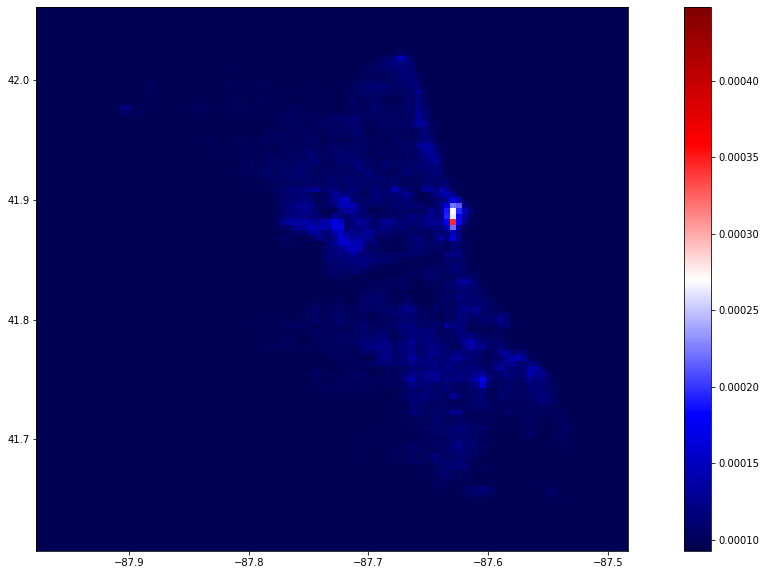

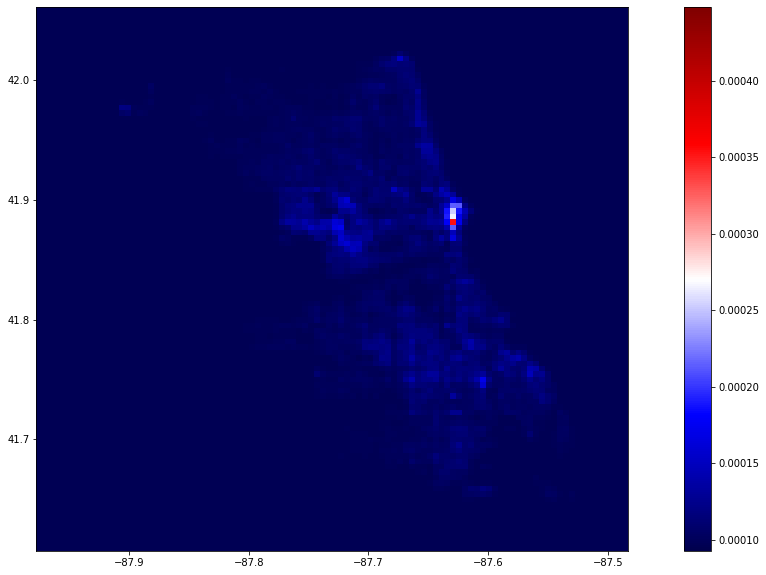

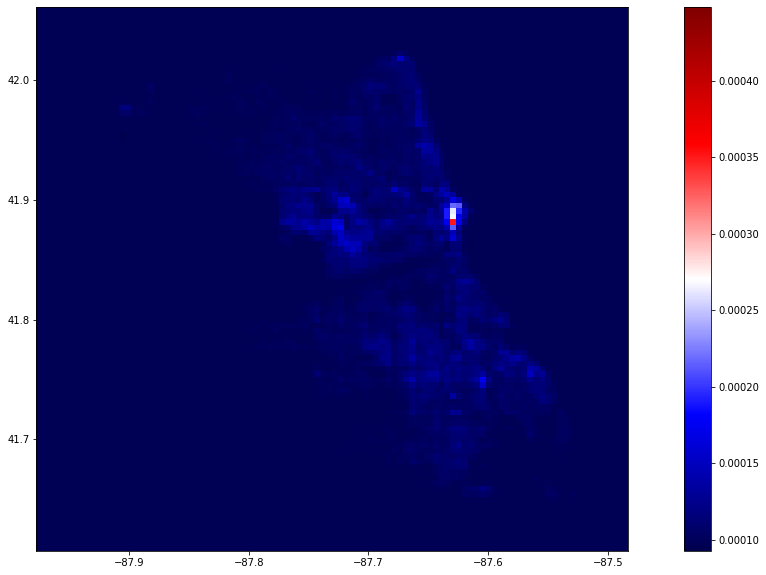

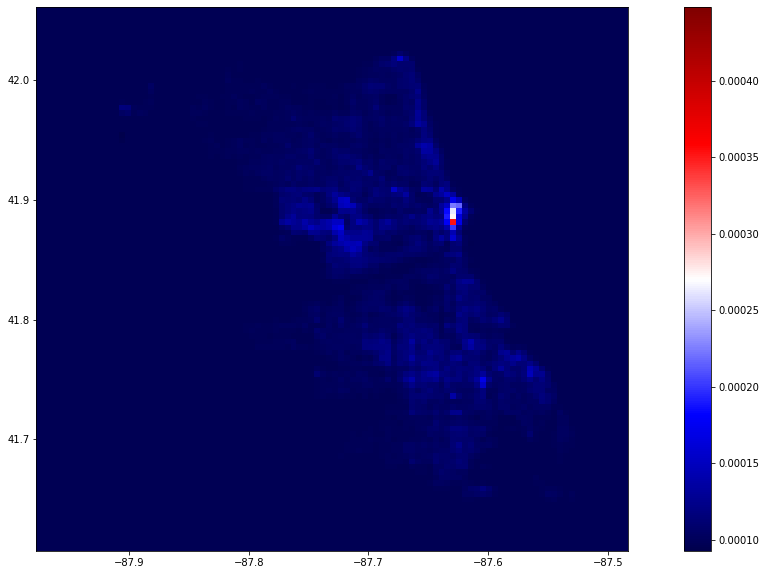

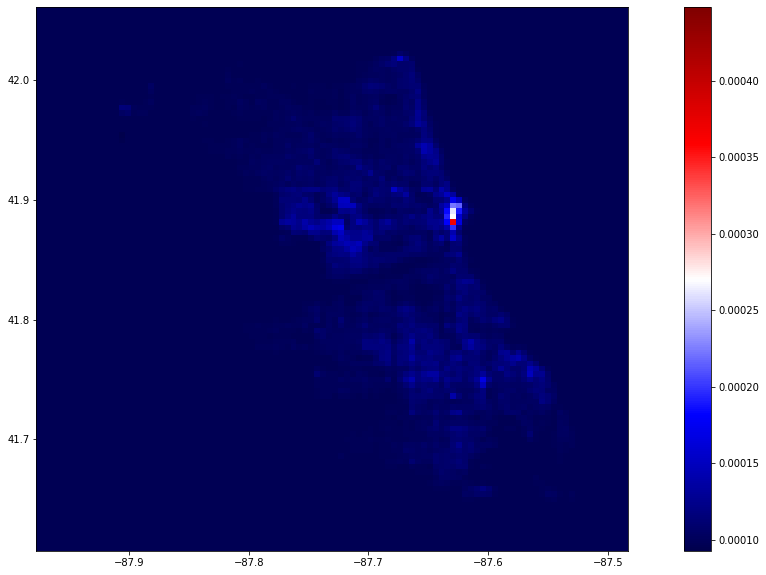

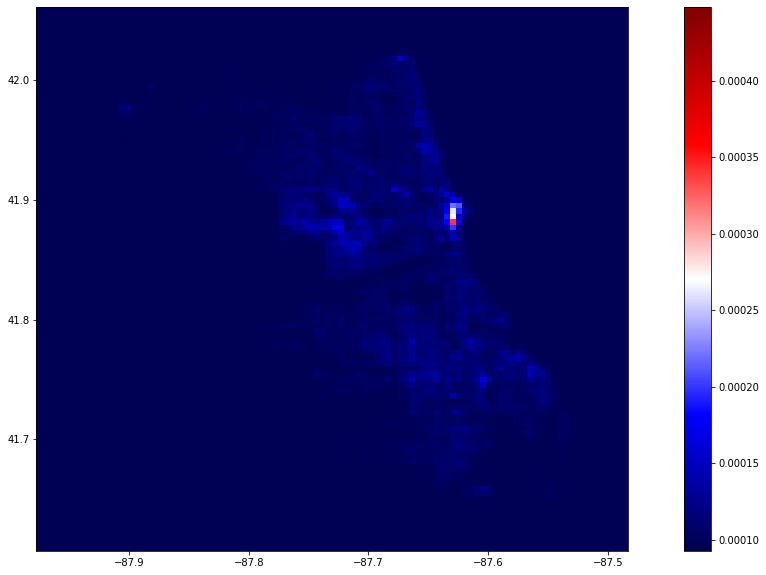

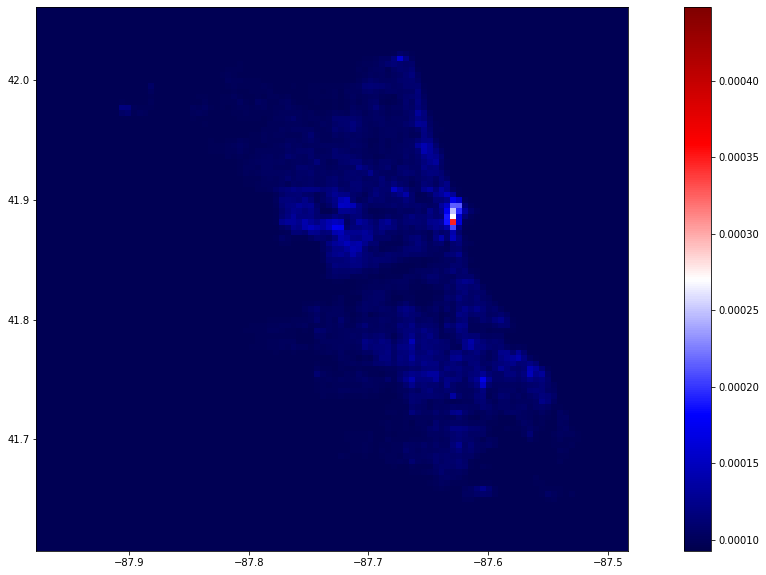

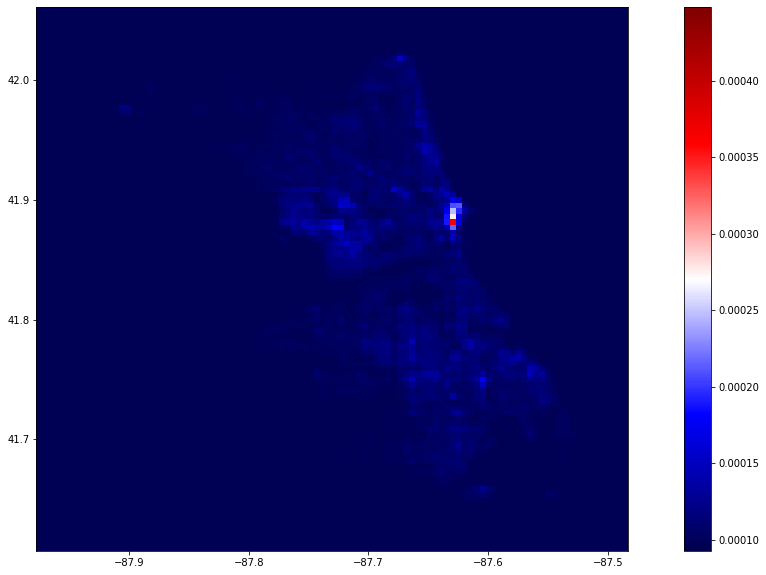

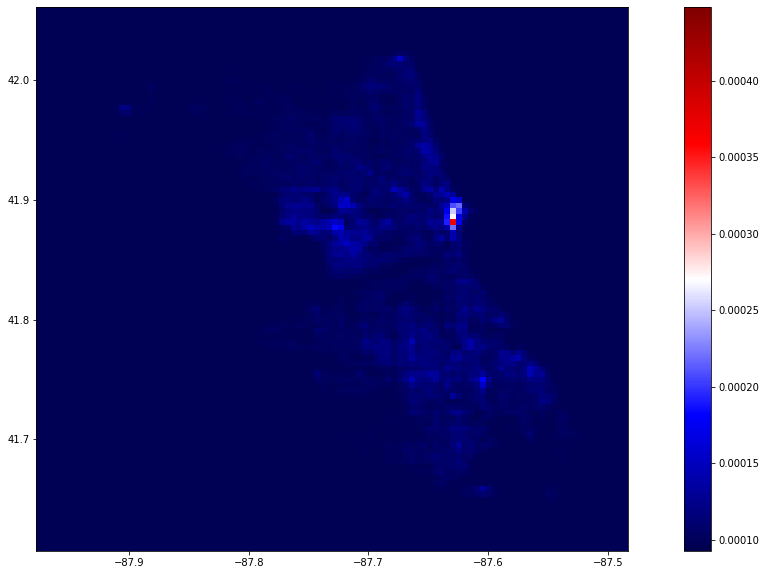

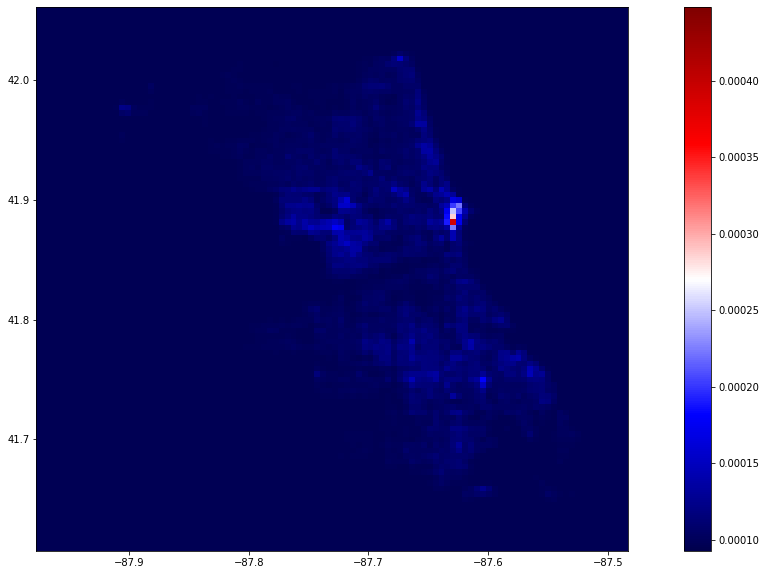

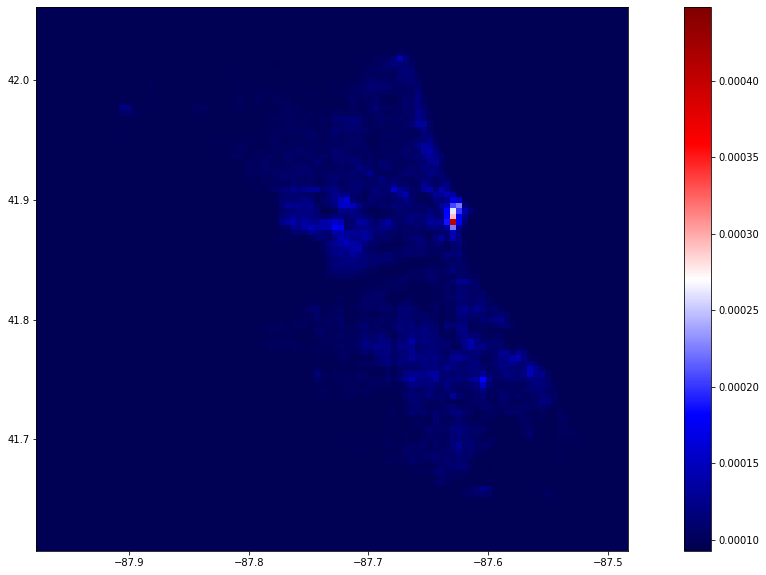

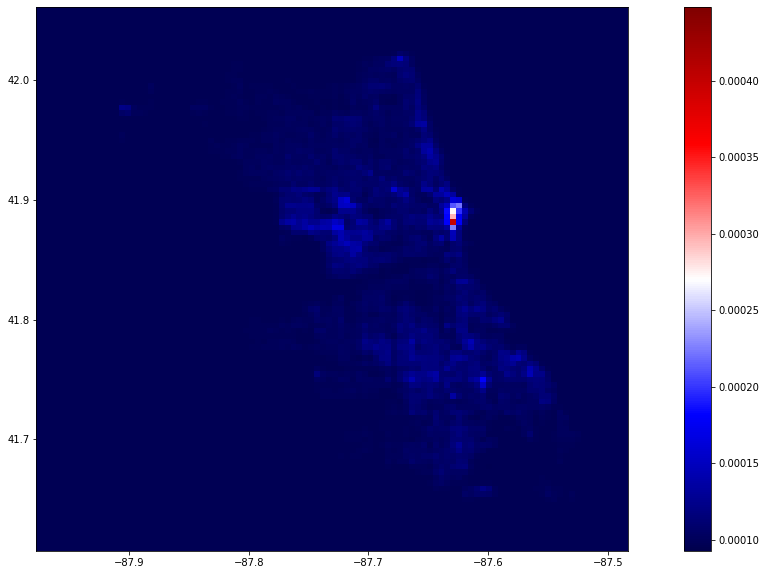

In [116]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

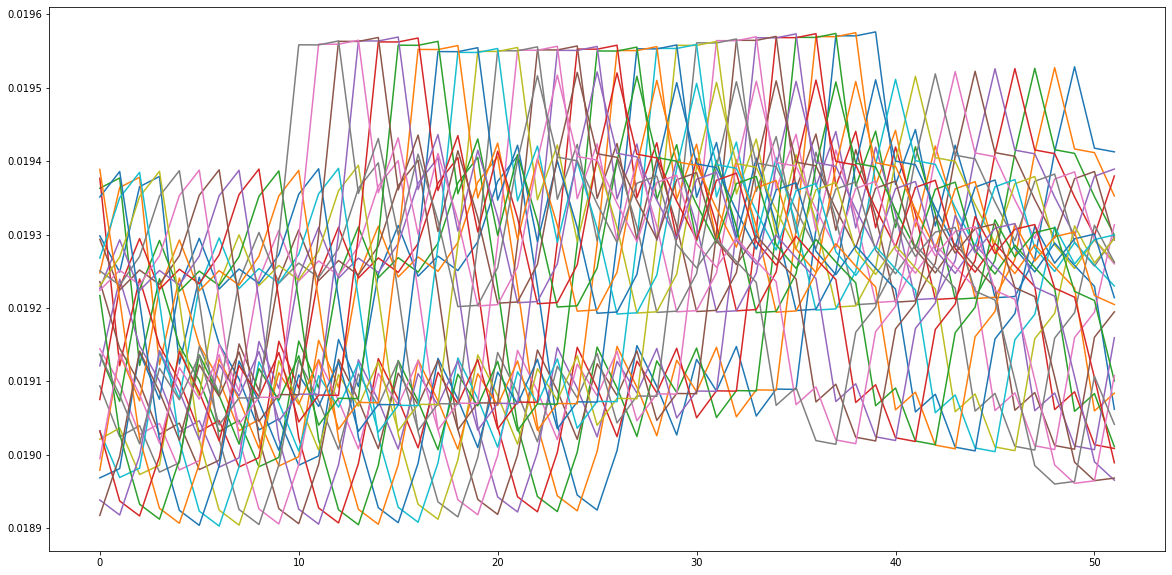

In [117]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## Run fit on any of the previous model here

In [320]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=6, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "FLATTENED_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_35 (TimeDistri (None, 52, 10000)    0           input_18[0][0]                   
__________________________________________________________________________________________________
timestep_diff (Lambda)          (None, 51, 10000)    0           time_distributed_35[0][0]        
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 51, 100)      4040400     timestep_diff[0][0]              
___________________________________________________________________________

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00016: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 17/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00017: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 18/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00018: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 19/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00019: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00047: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 48/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00048: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 49/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00049: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 50/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00050: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.

# Test Set accuracy

#### Flattened+Attention

In [54]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002142413, valid_loss=0.002142413053661585


#### Flattened+LSTM+Attention

In [48]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021439143, valid_loss=0.002143914345651865


#### FFT+Attention

In [104]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002143551, valid_loss=0.0021435508970171213


#### Attention on Attention

In [135]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021426608, valid_loss=0.0021426607854664326


# Validation Set:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016915

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016920

### Best FFT + Attention Heads on  TimeDistributed is at MAE of 0.0016920

## Best Pixel Attention + Time Distributed is at MAE of 0.00169077

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [388]:
Predict = model.predict(X_valid)

In [389]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

In [390]:
vmax, vmin = np.max(Predict),np.min(Predict)
vmax, vmin

(0.7479866, -5.031456e-05)

In [391]:
dvmax, dvmin = np.max(np.abs(Predict-Y_valid)),np.min(np.abs(Predict-Y_valid))
dvmax, dvmin

(0.22224748994016102, 2.397402227330369e-09)

In [392]:
diff_max,diff_min = (dvmax , dvmin ) 
def scaleDiff(diff,diff_max,diff_min):
    return (diff - diff_min)/(diff_max - diff_min)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

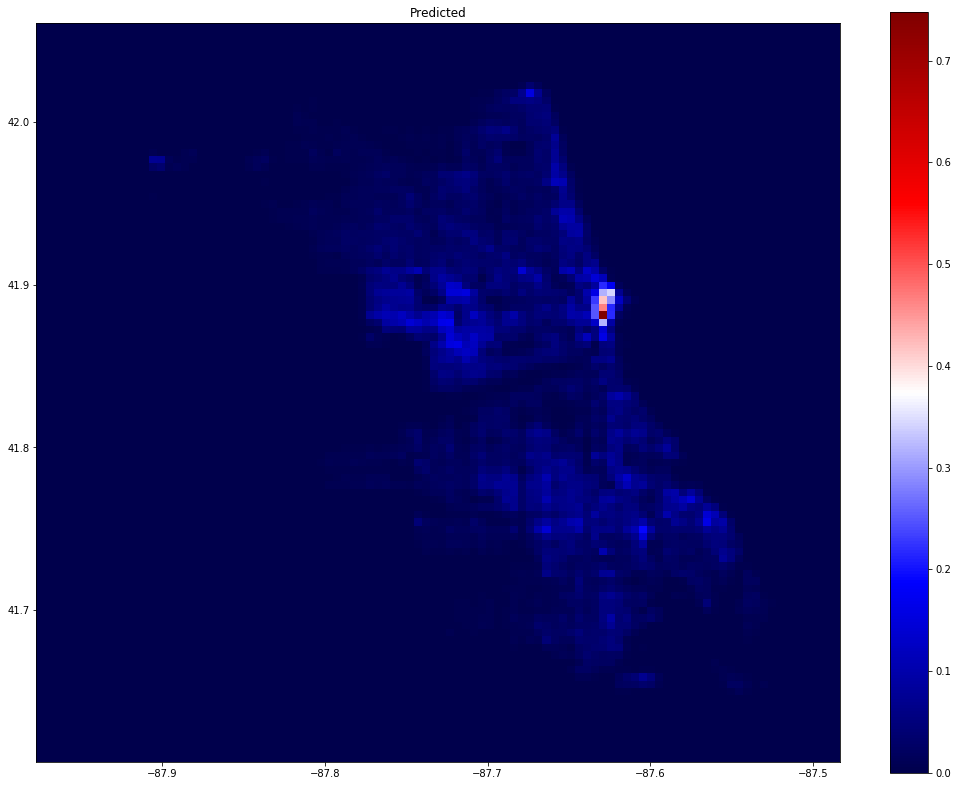

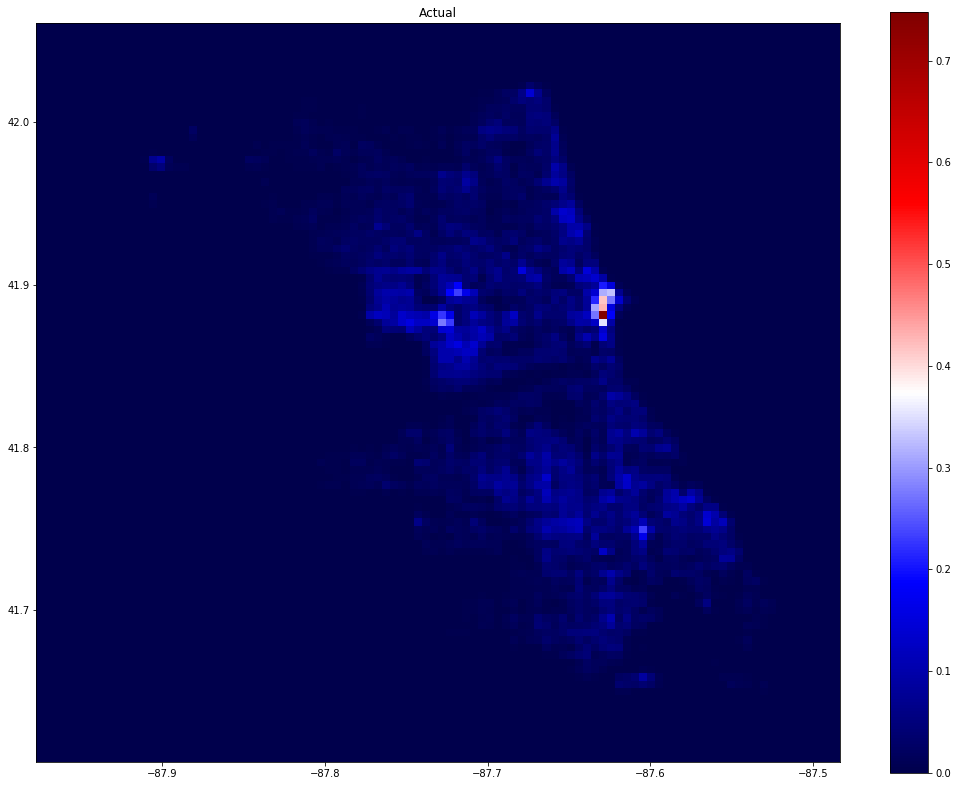

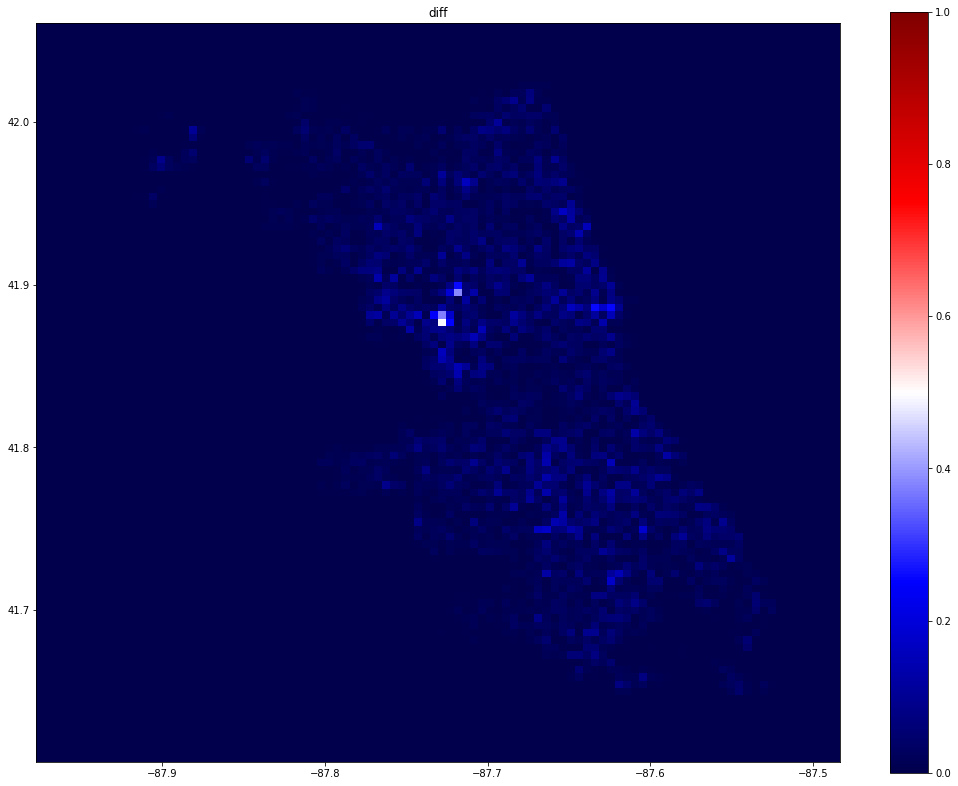

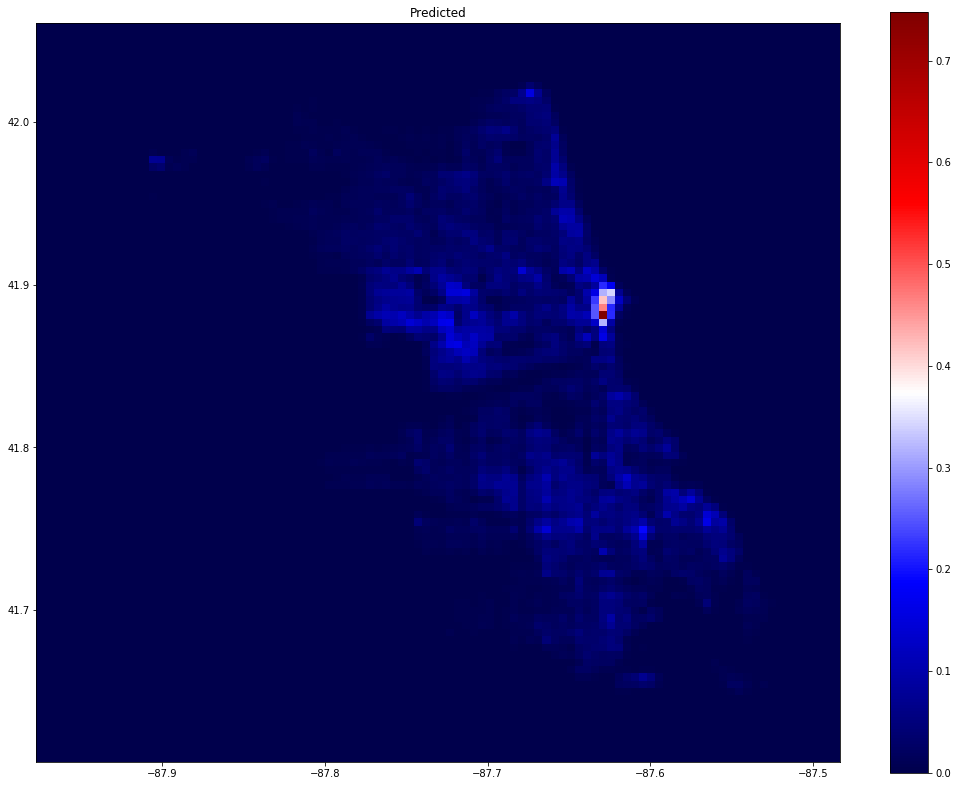

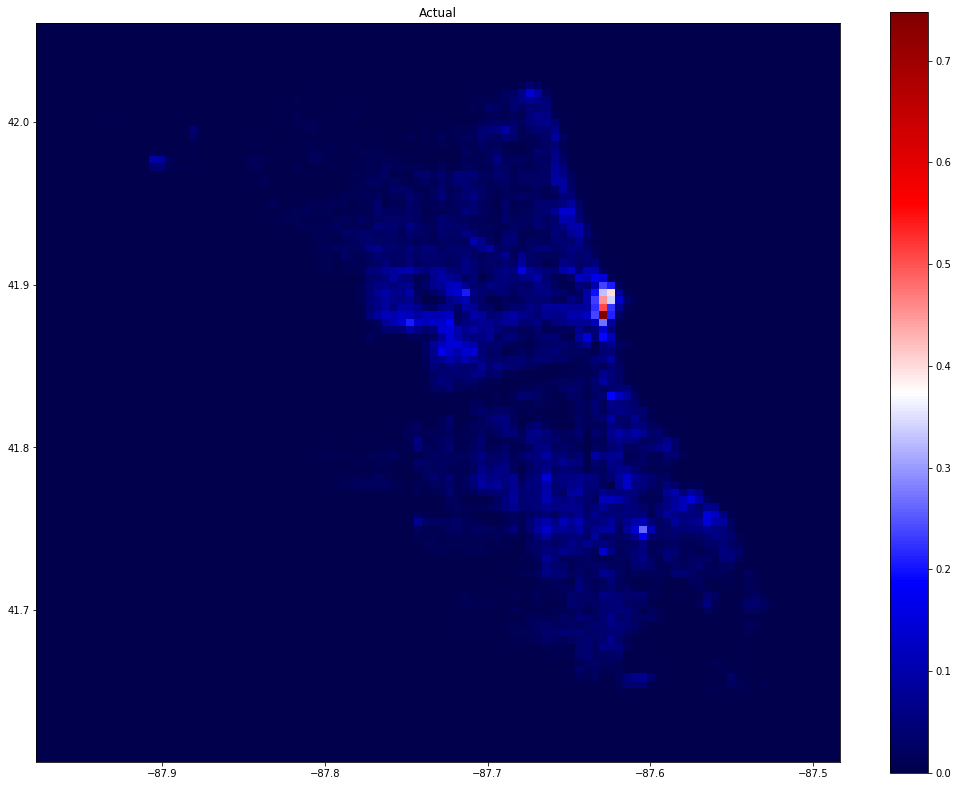

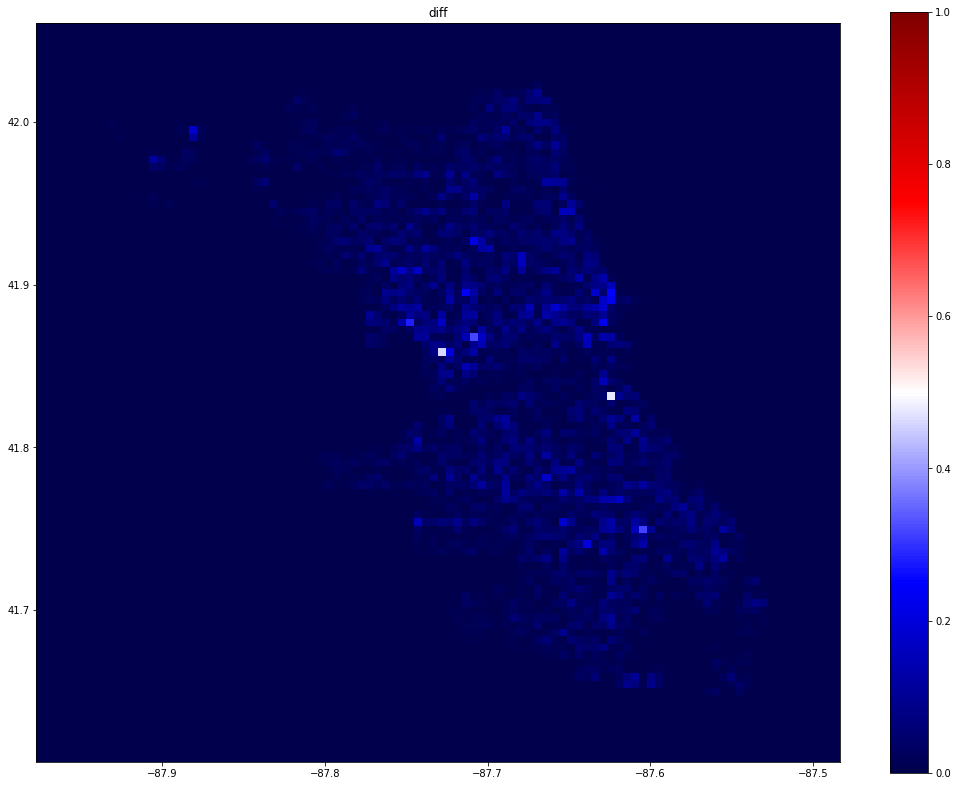

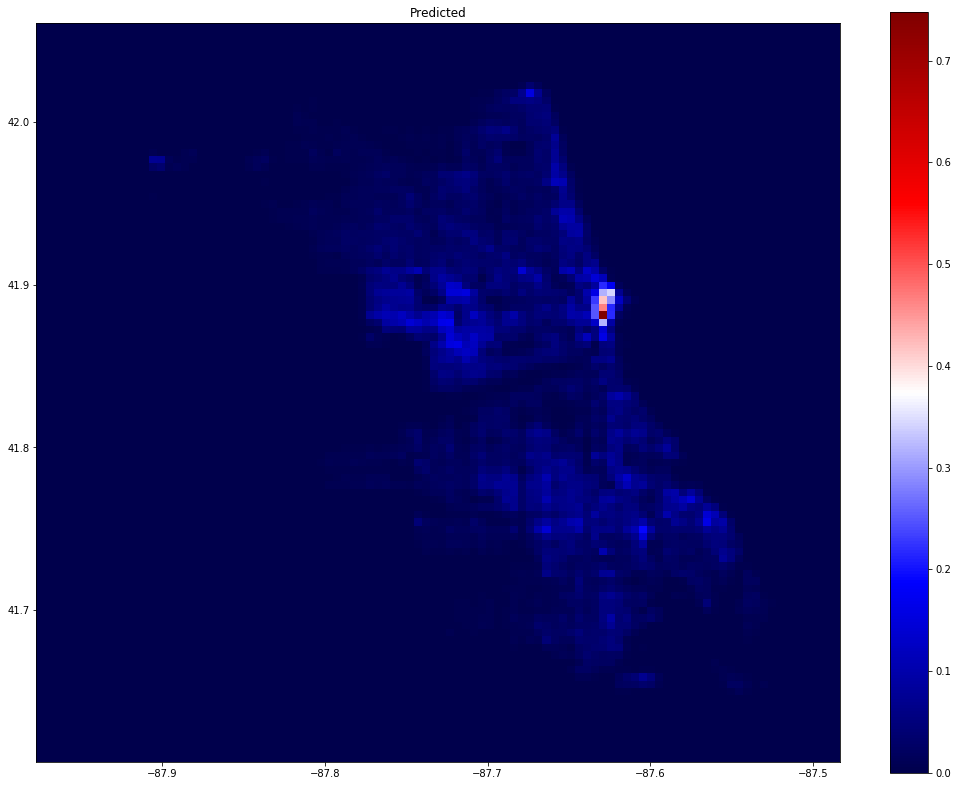

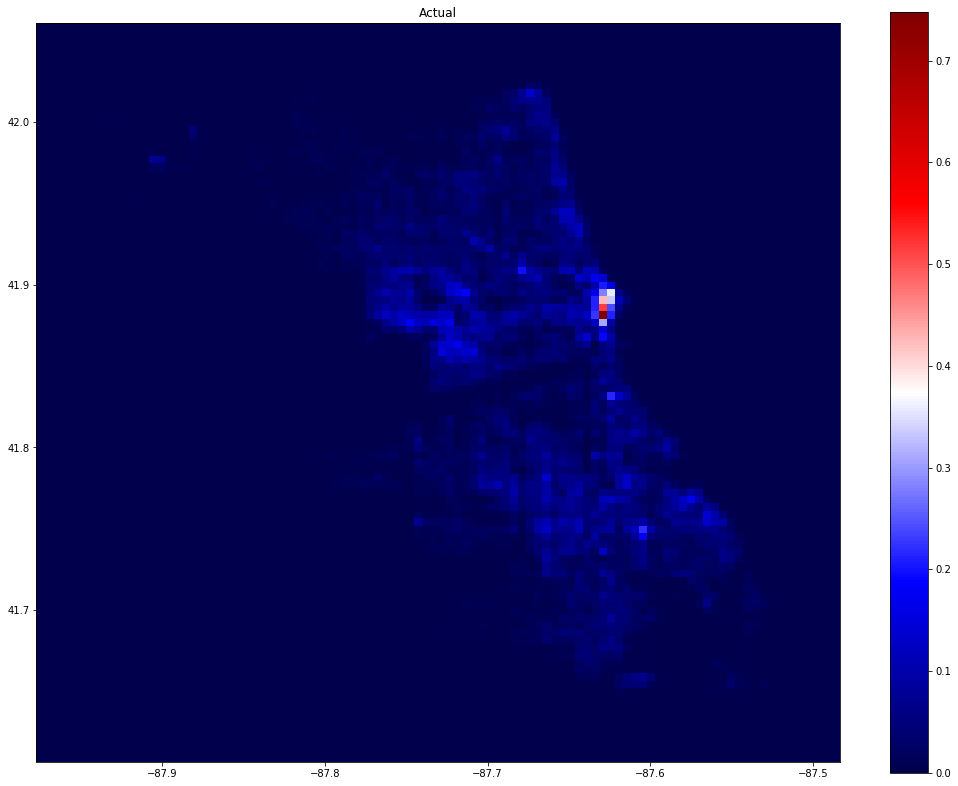

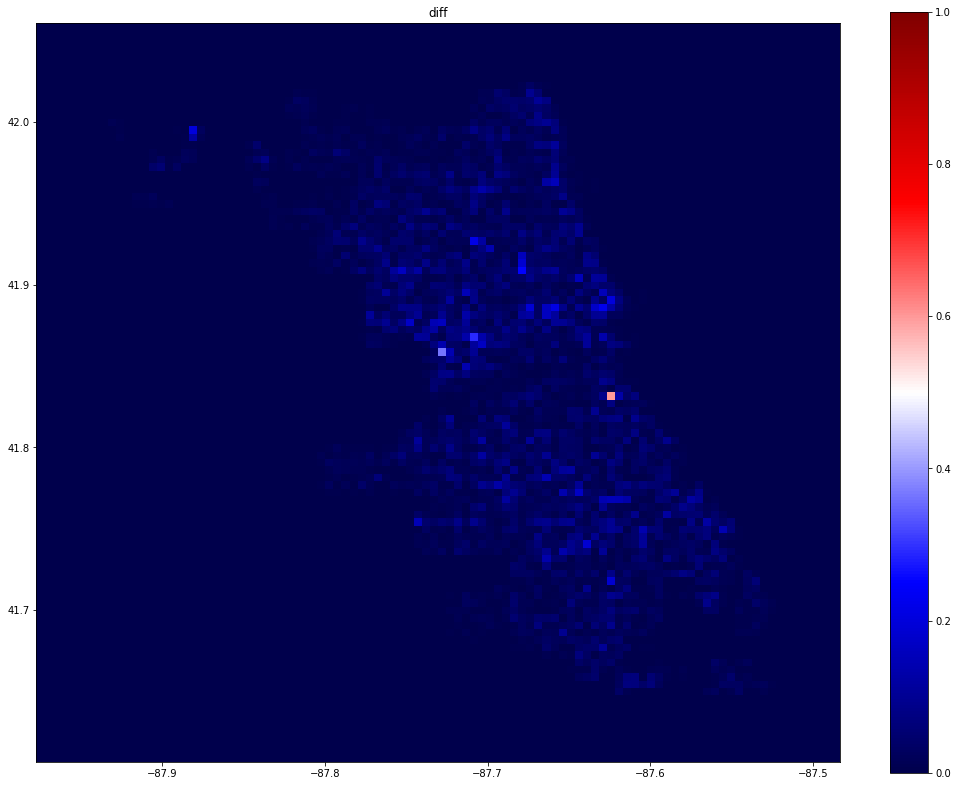

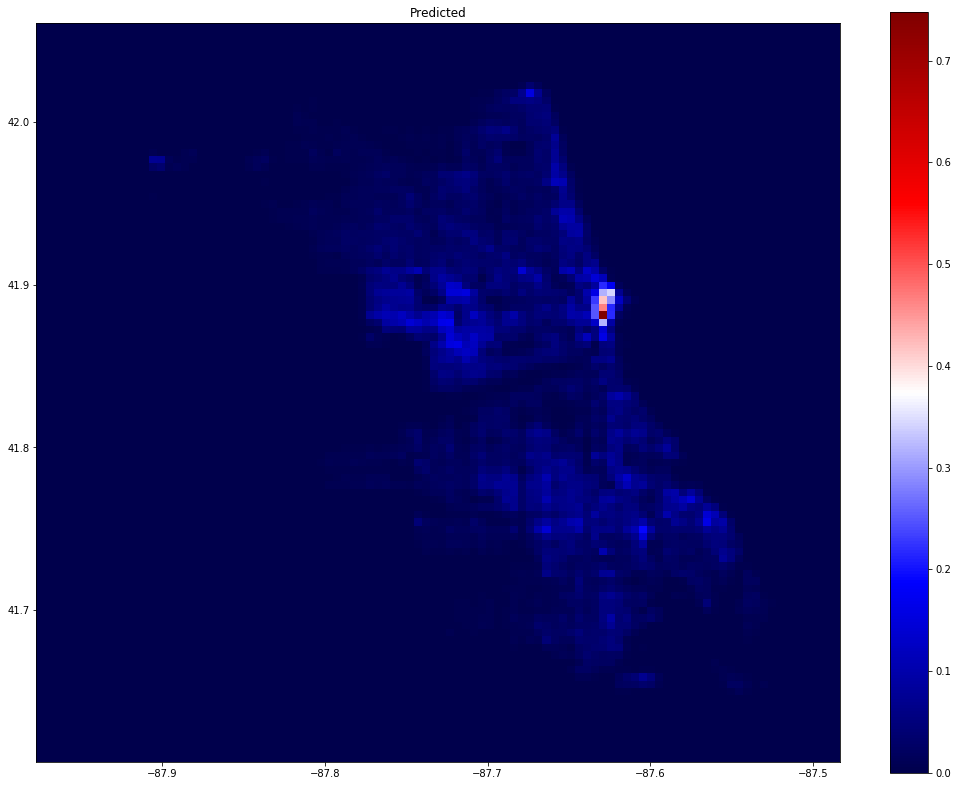

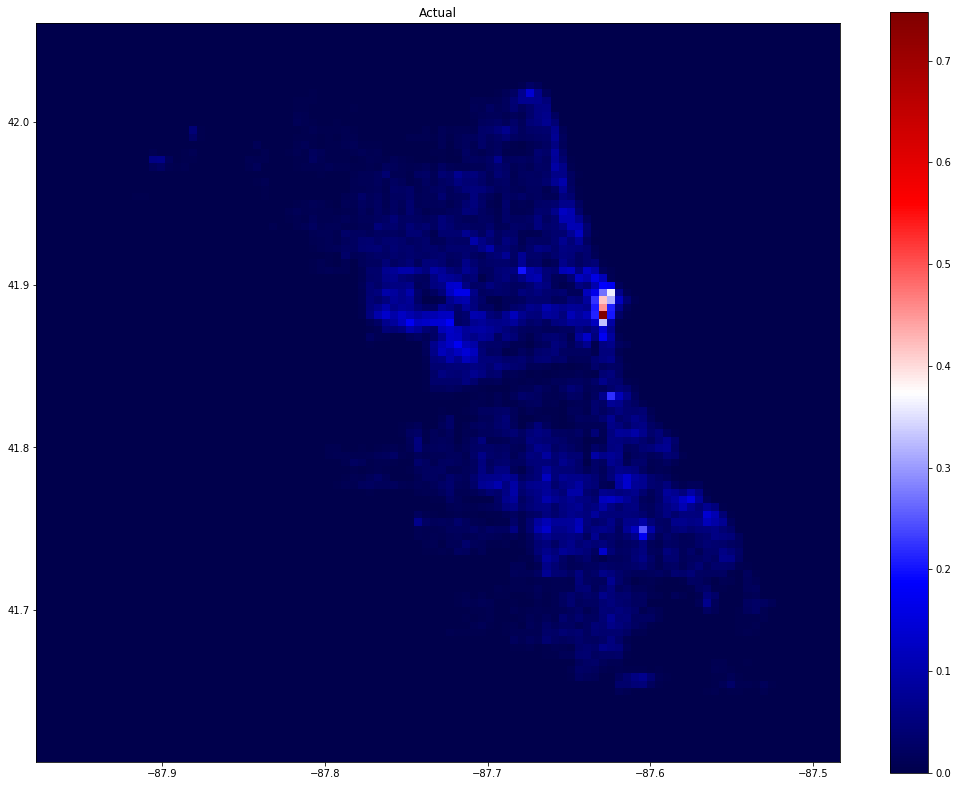

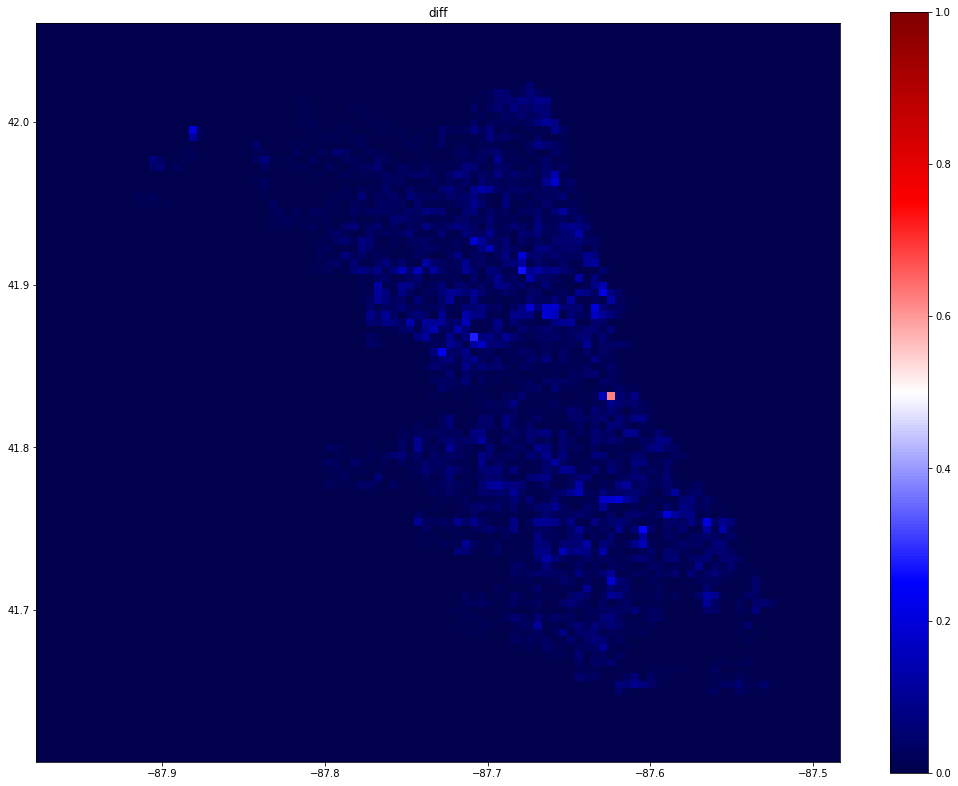

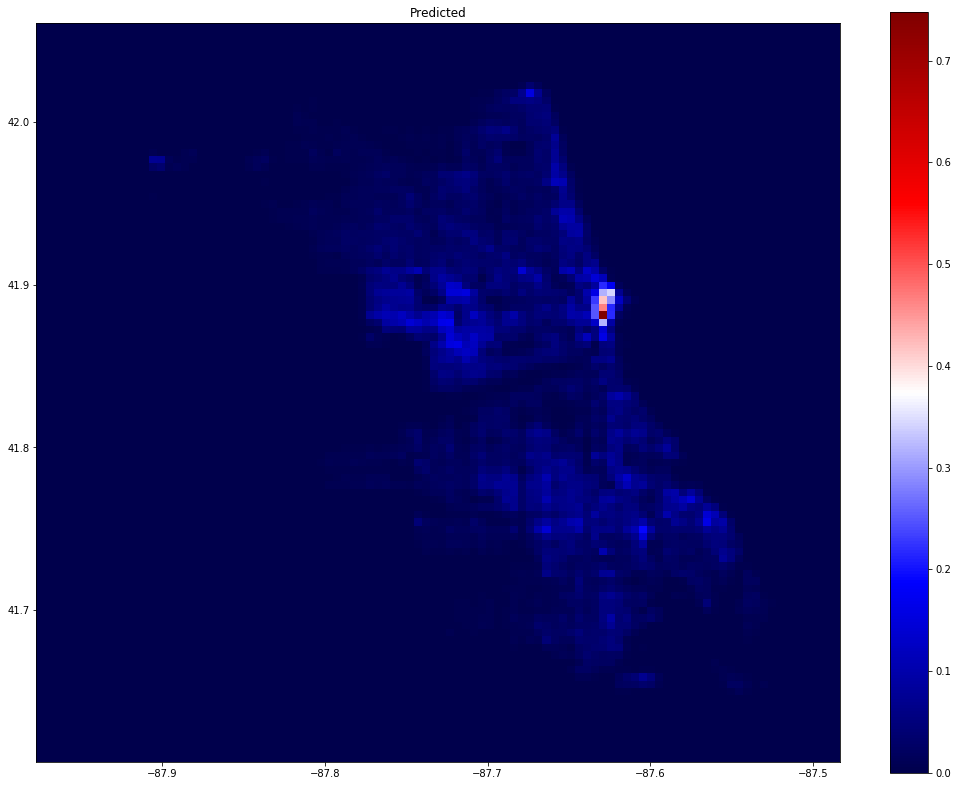

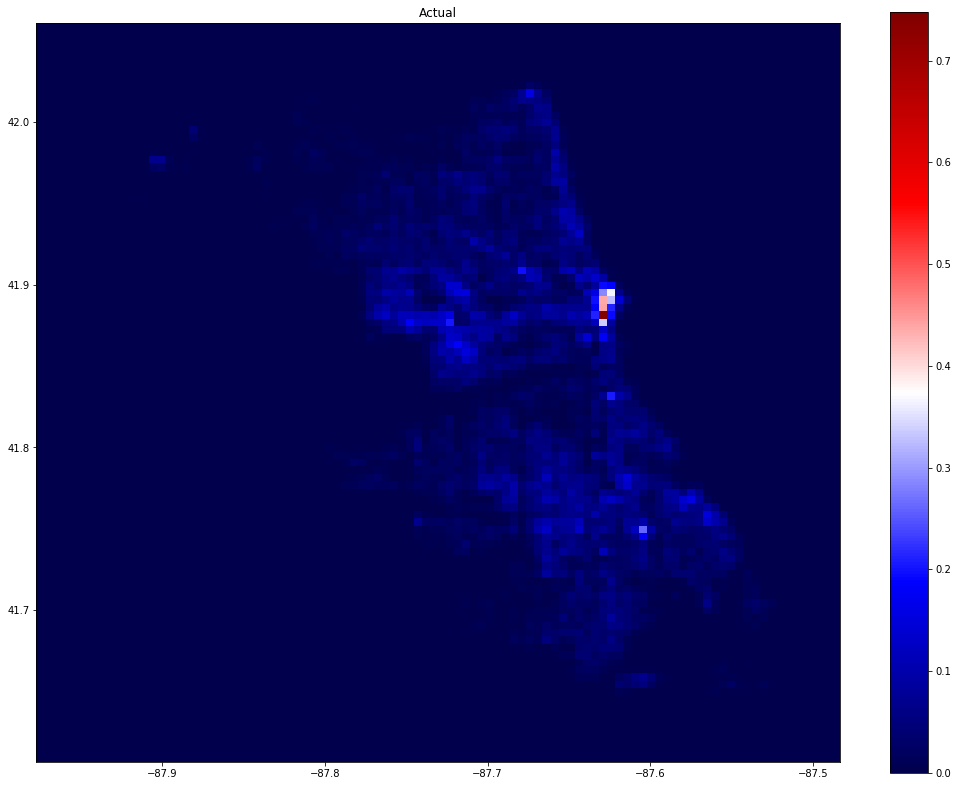

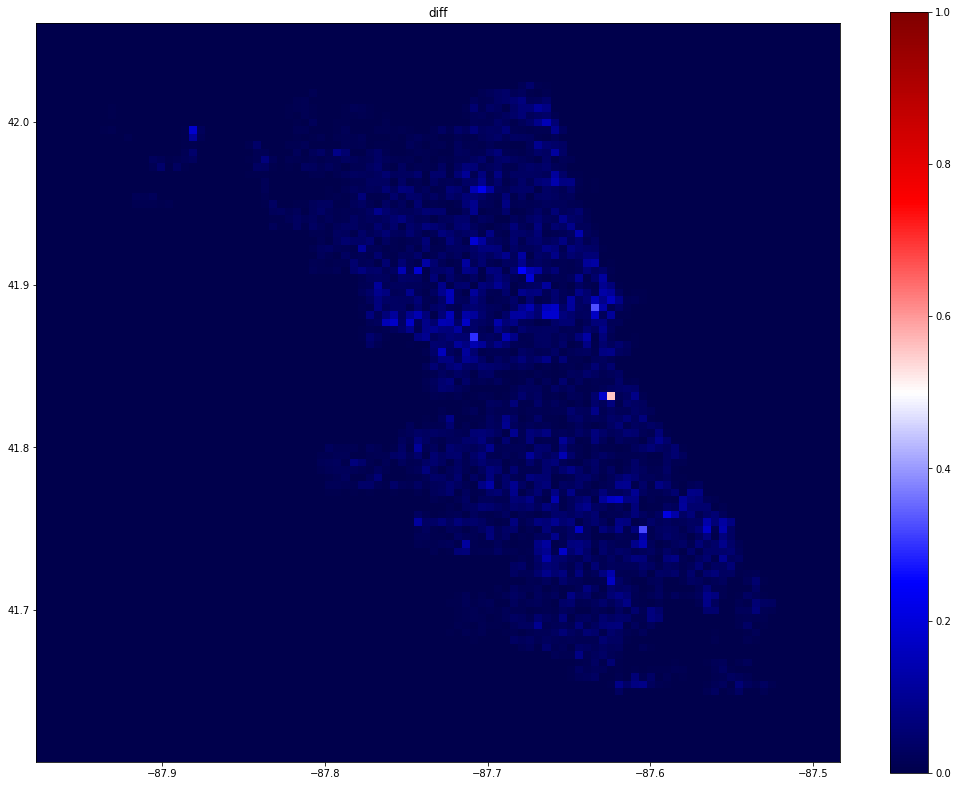

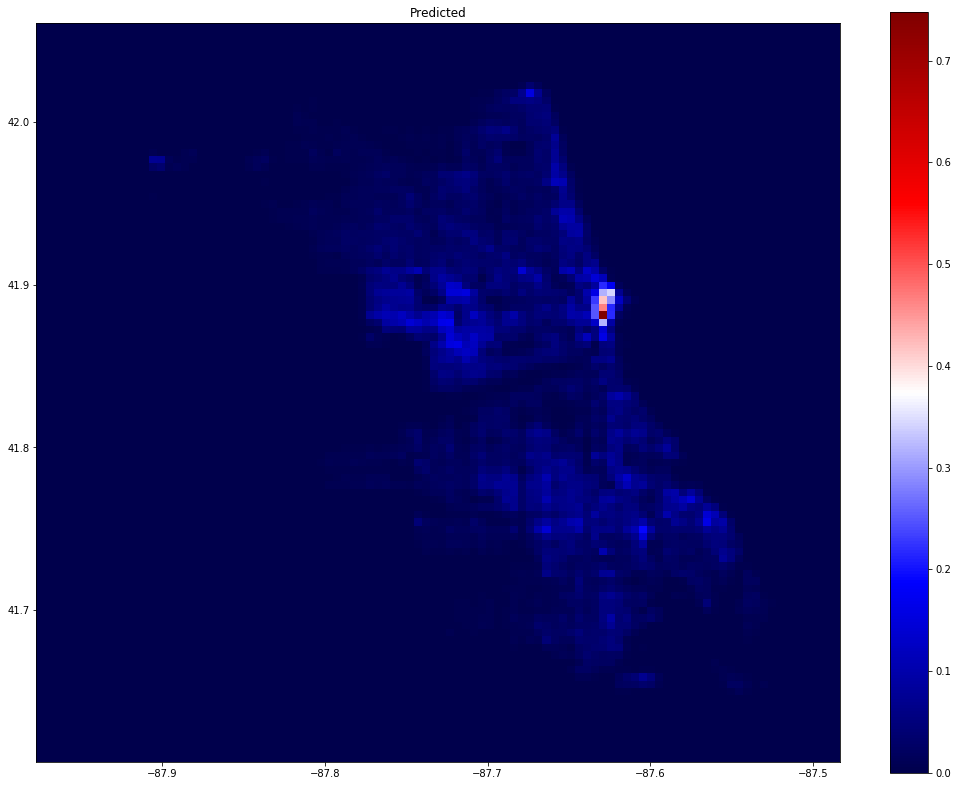

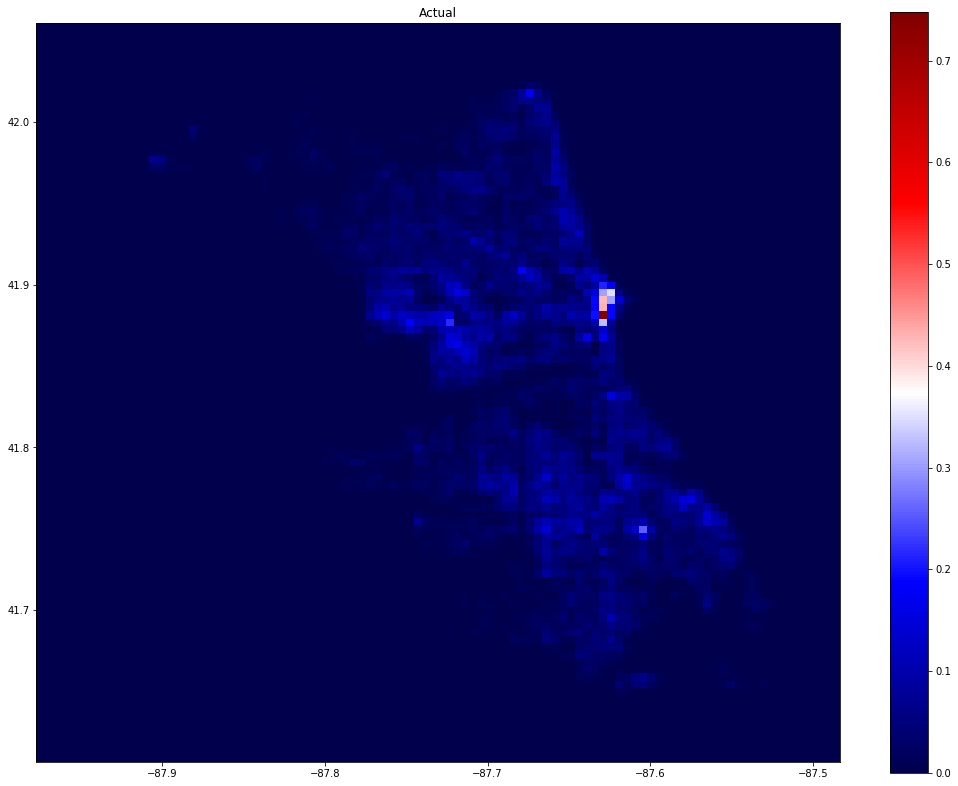

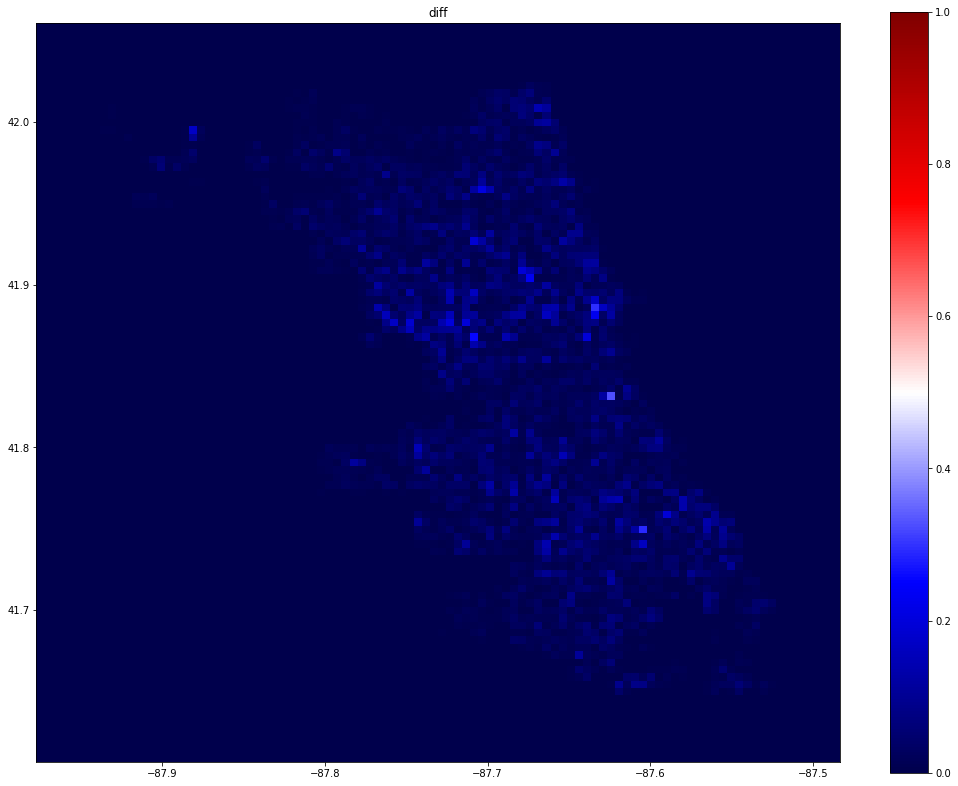

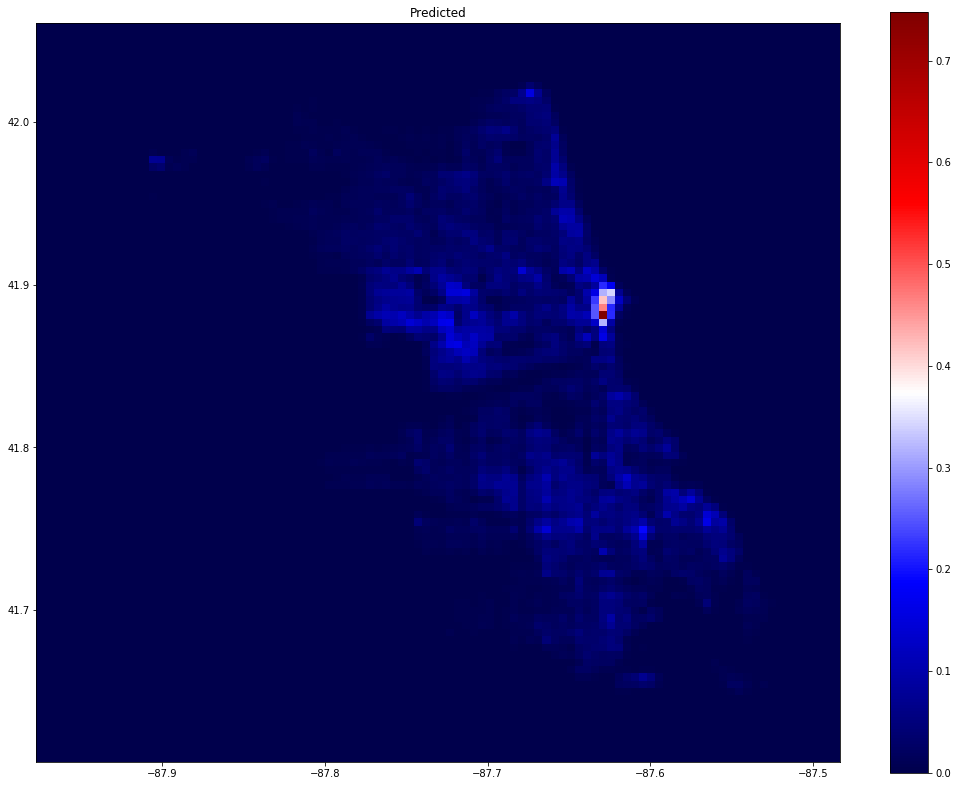

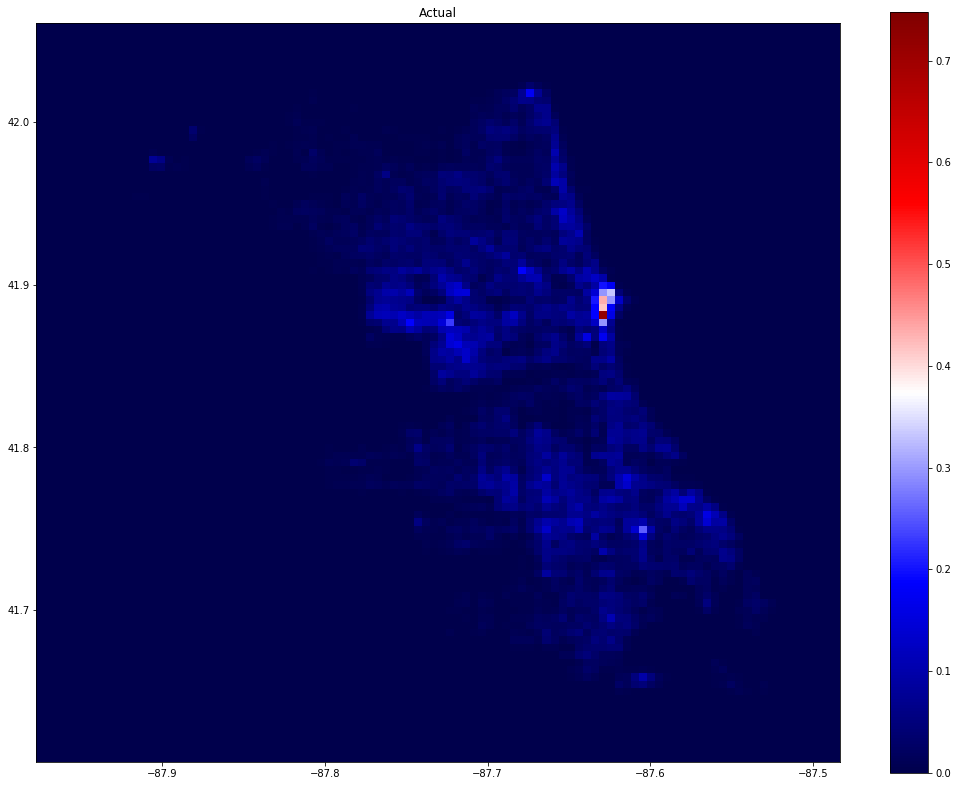

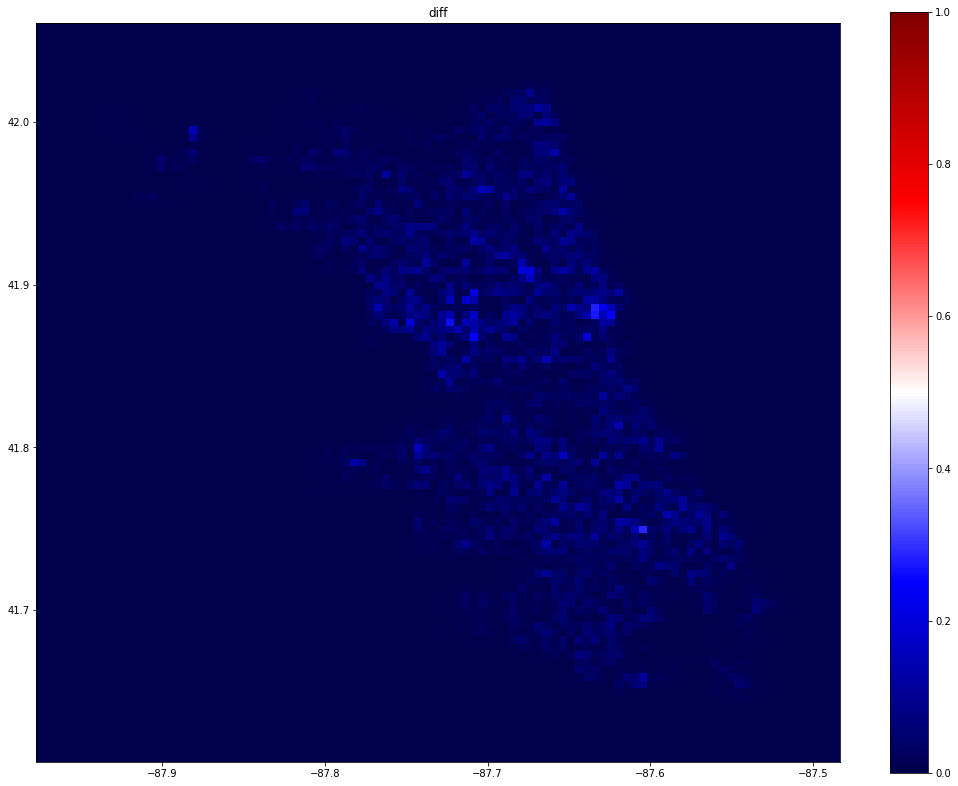

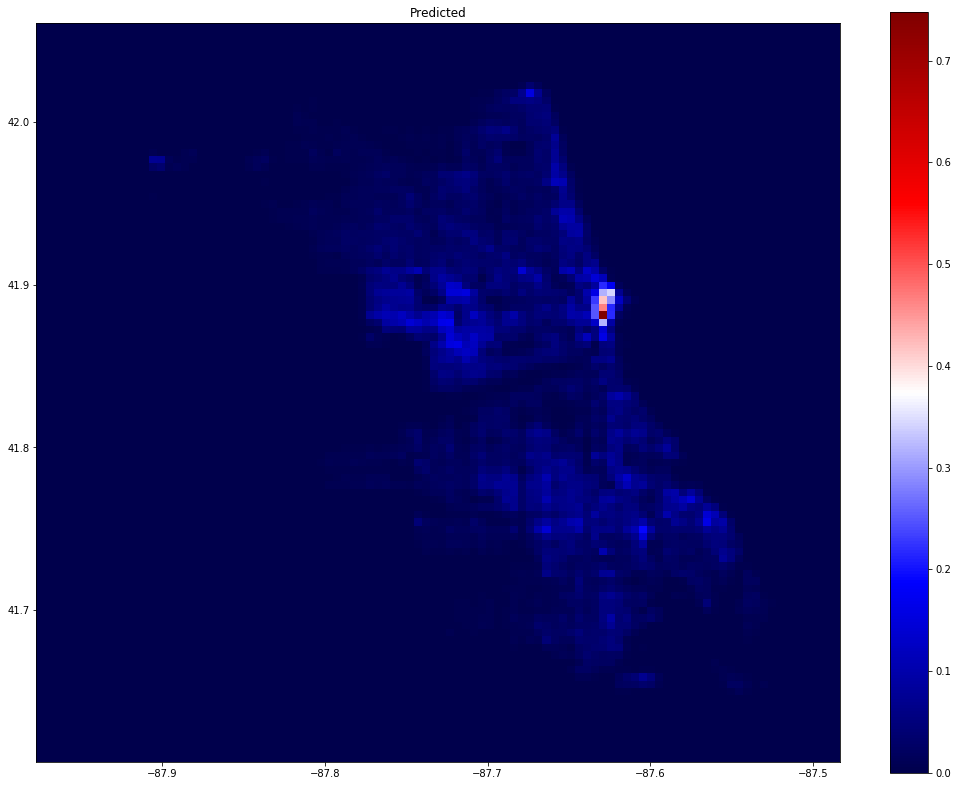

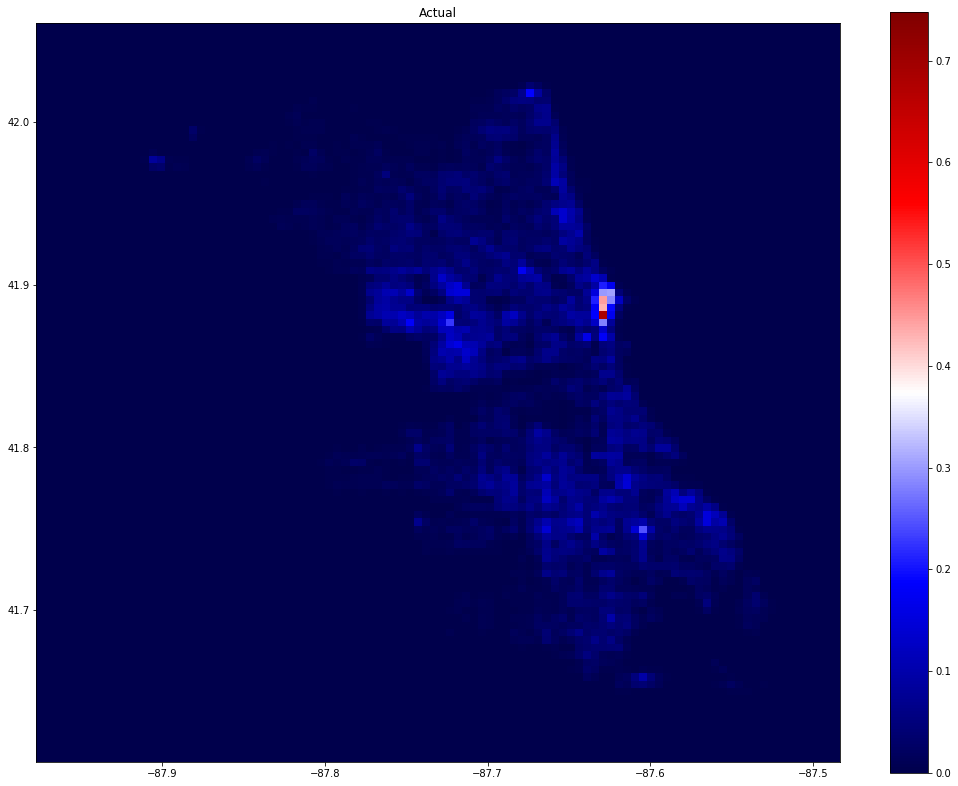

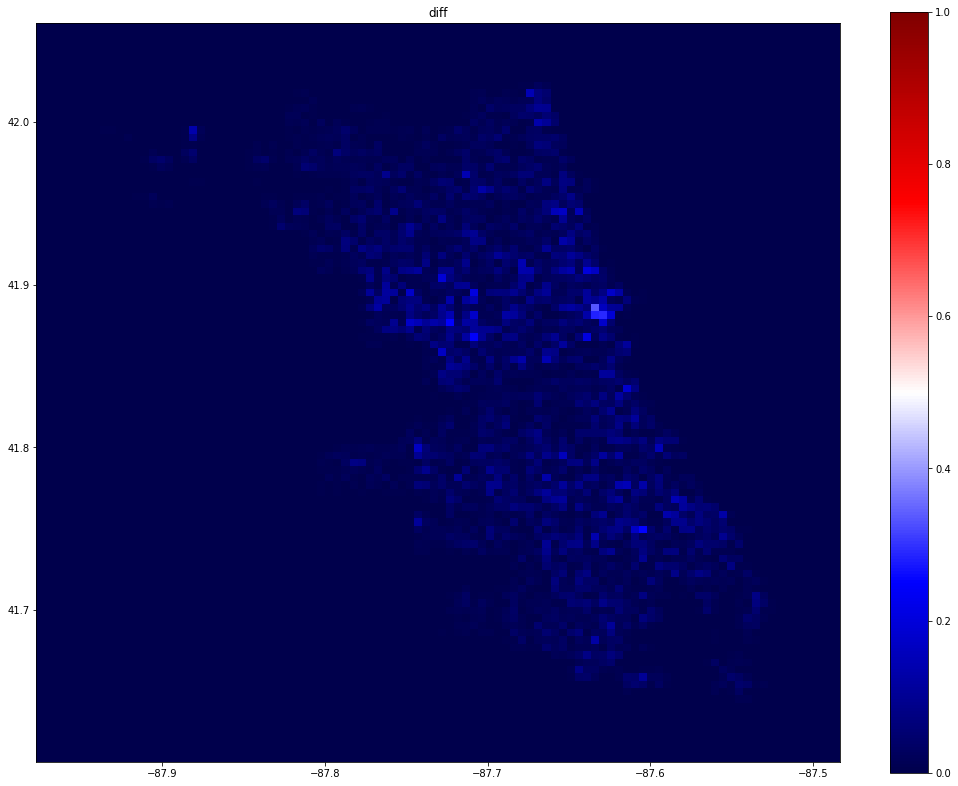

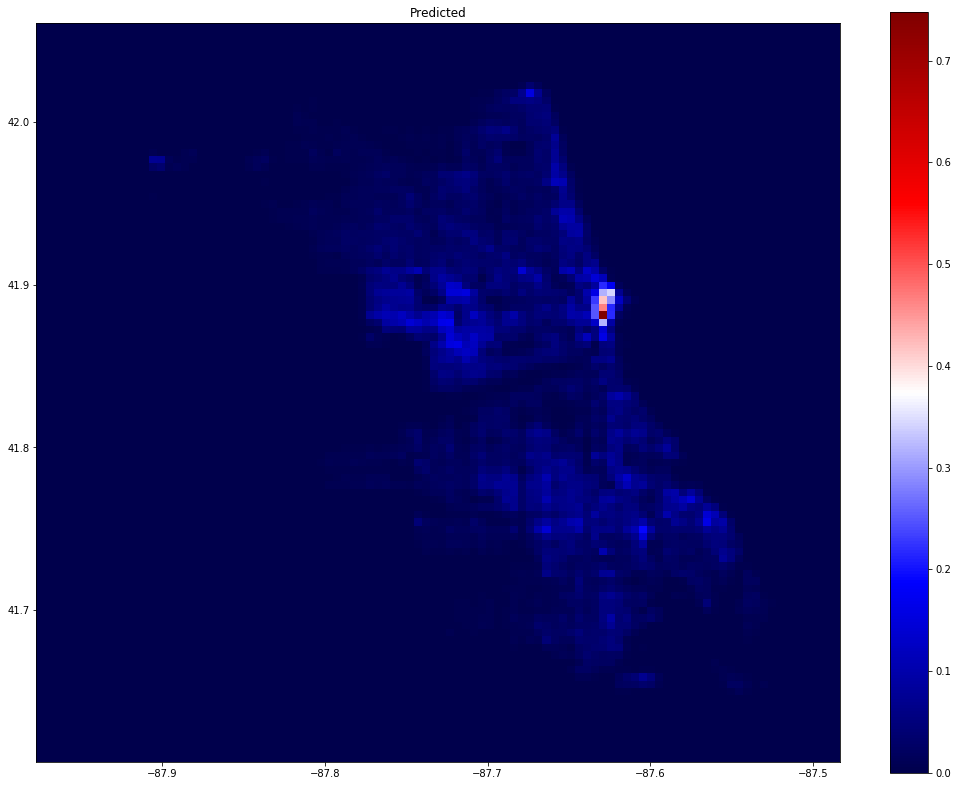

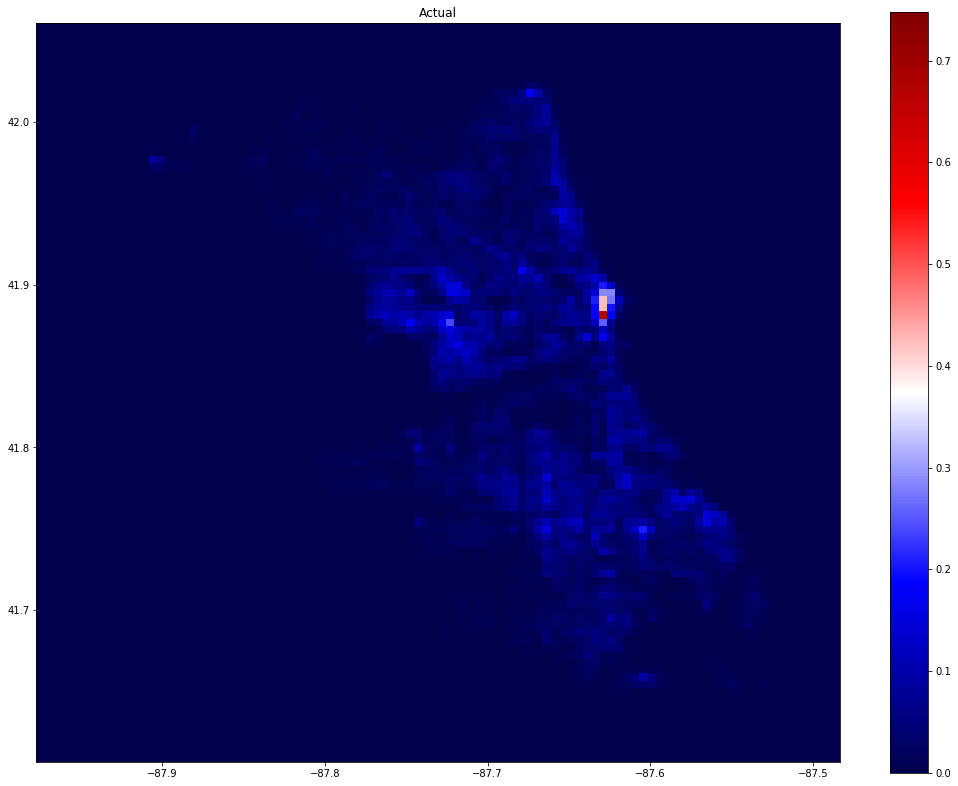

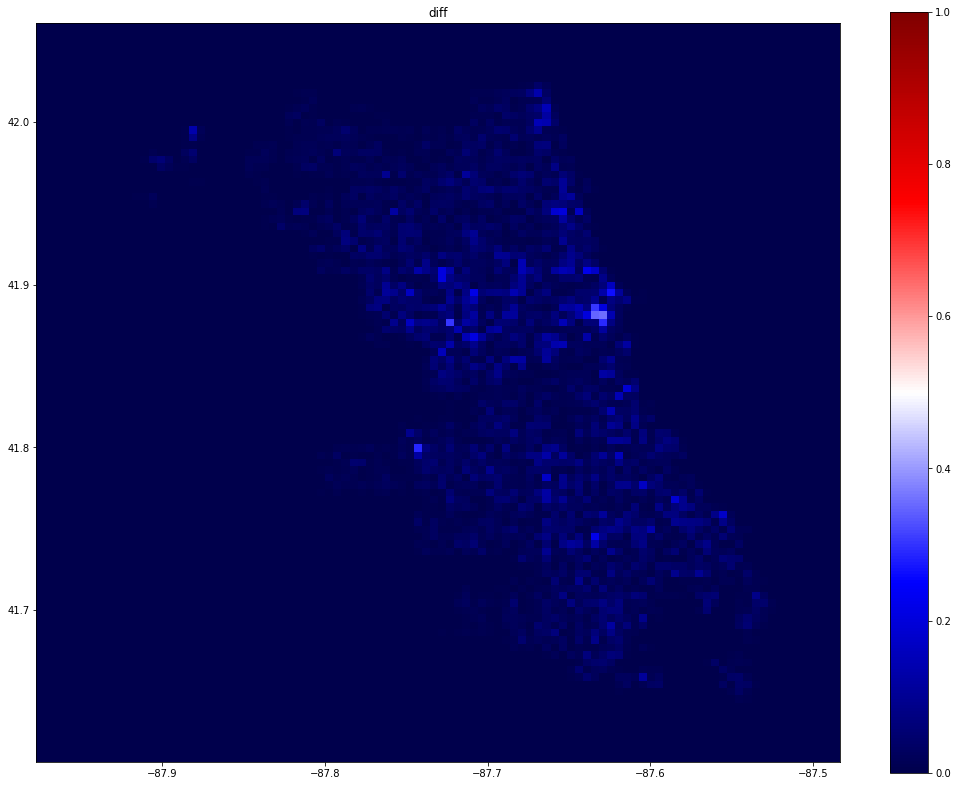

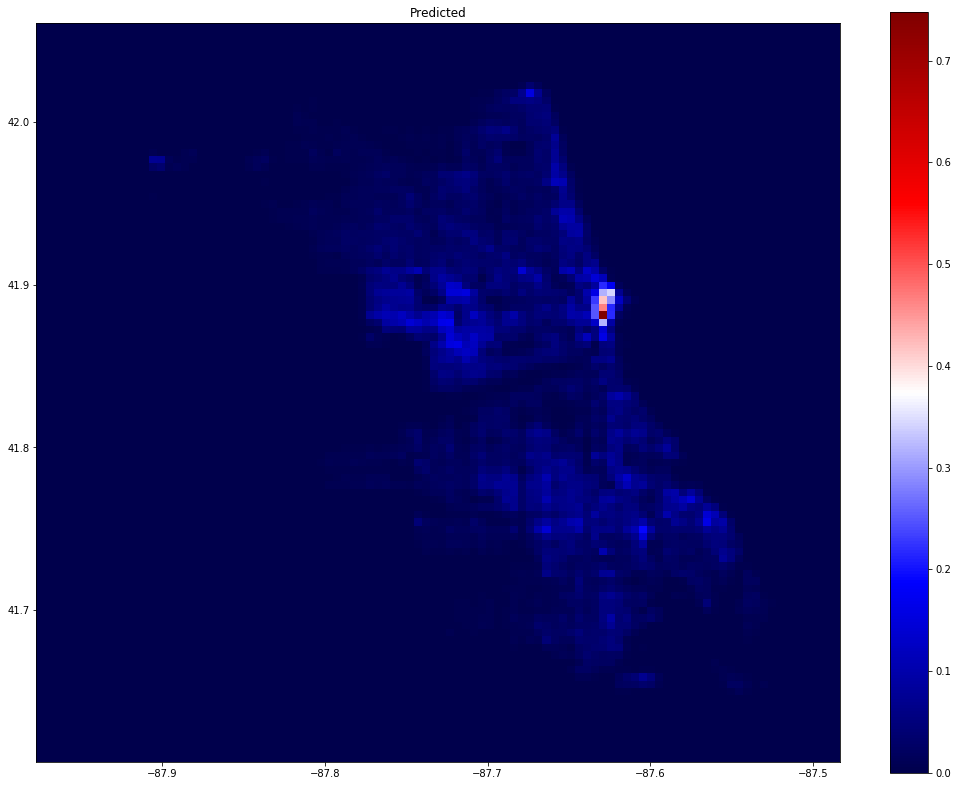

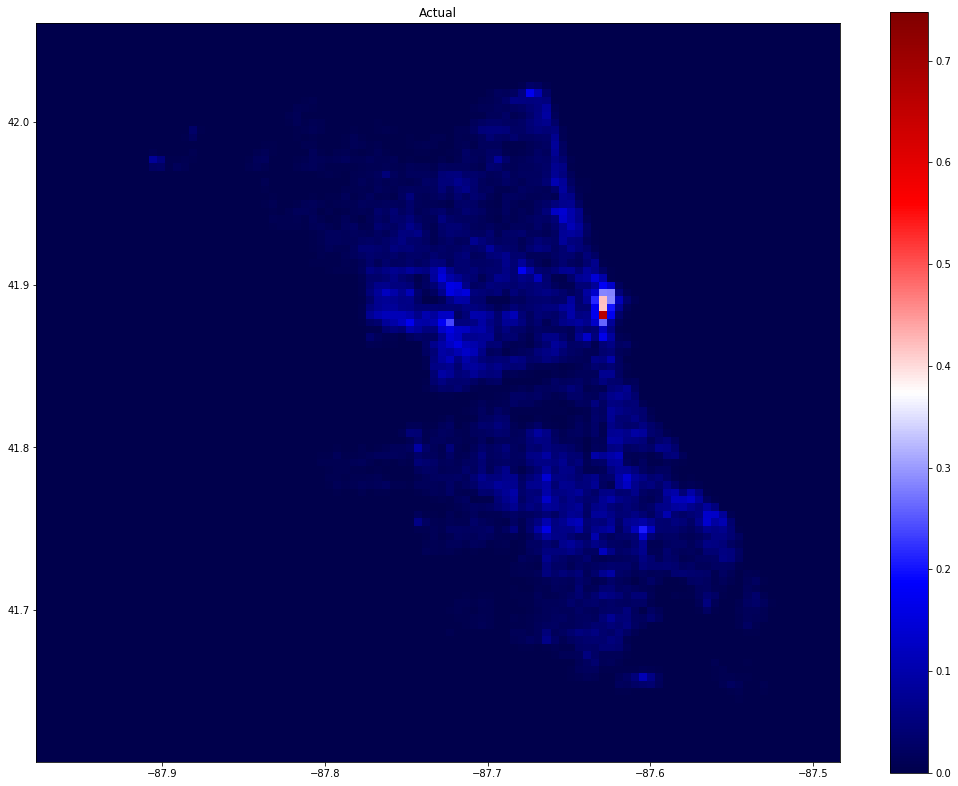

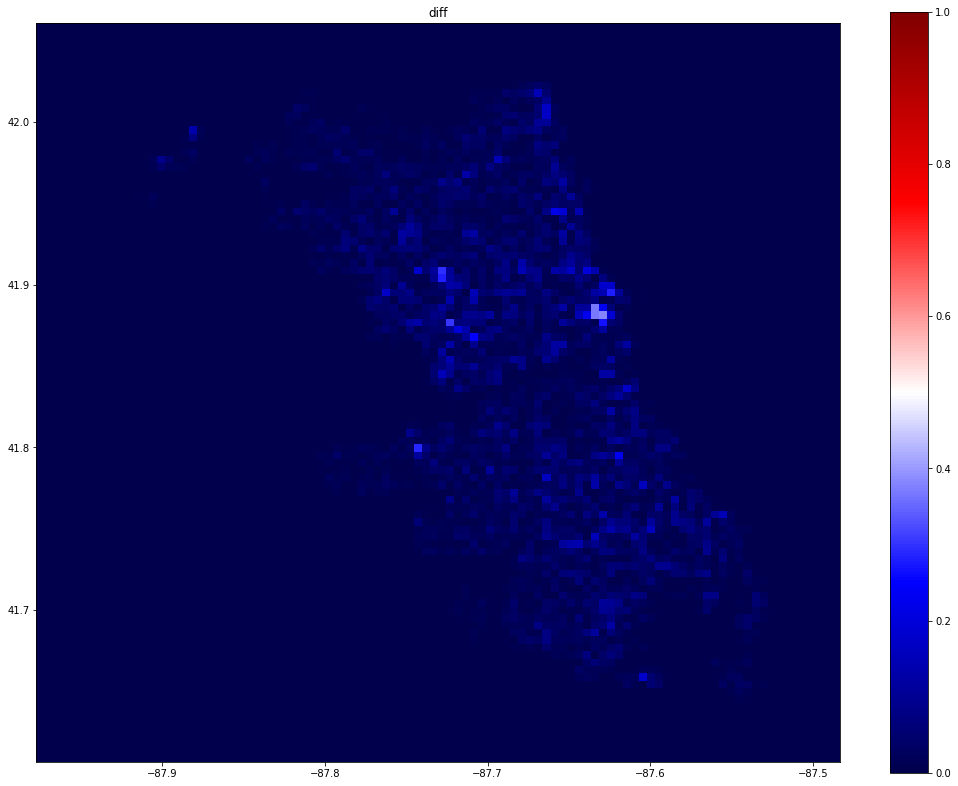

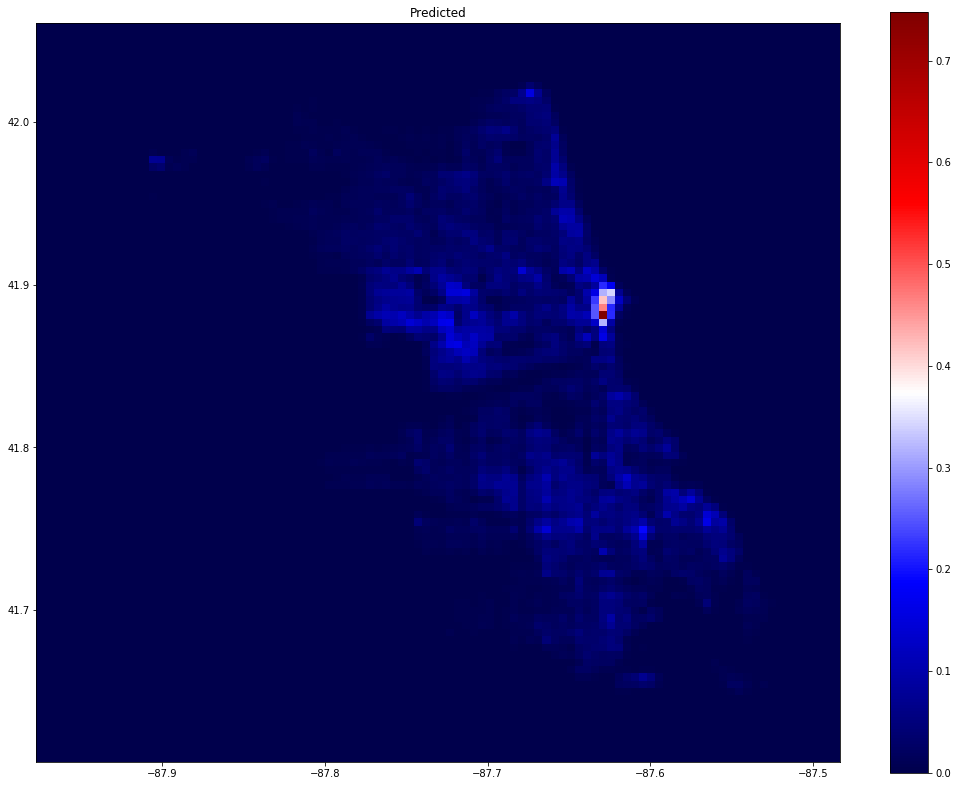

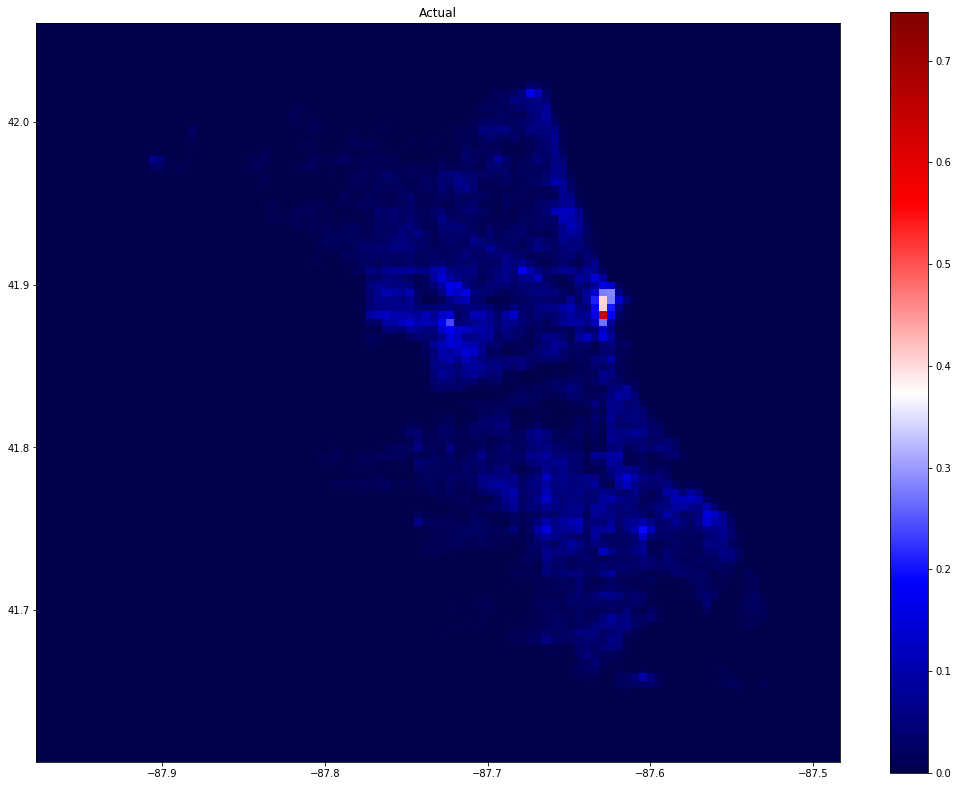

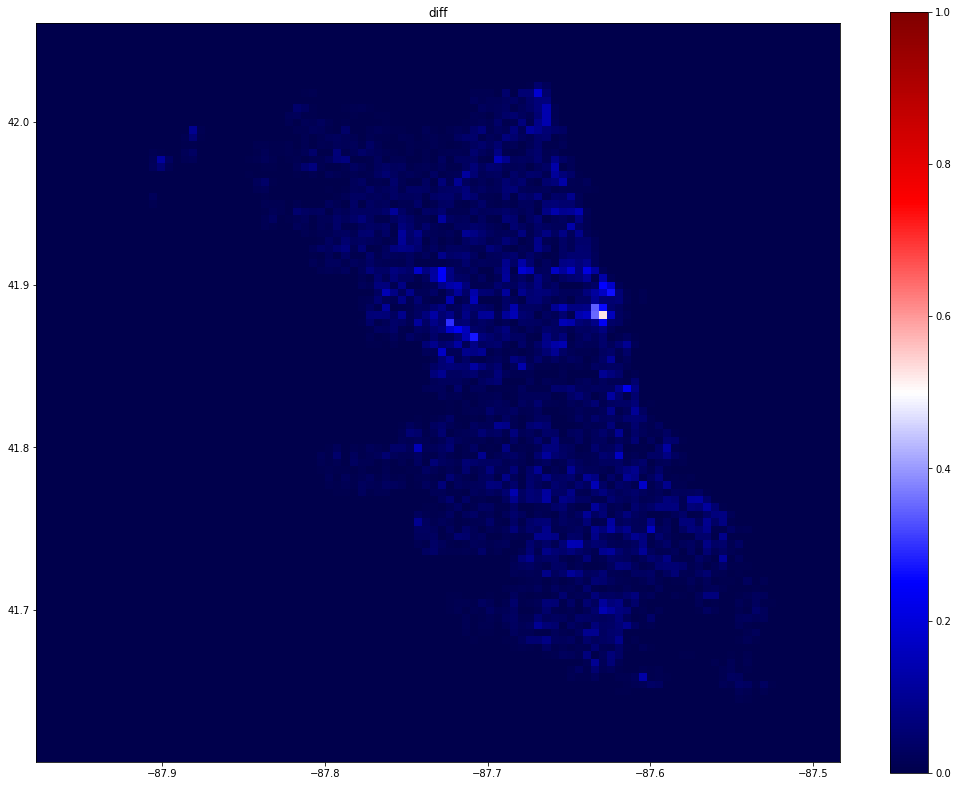

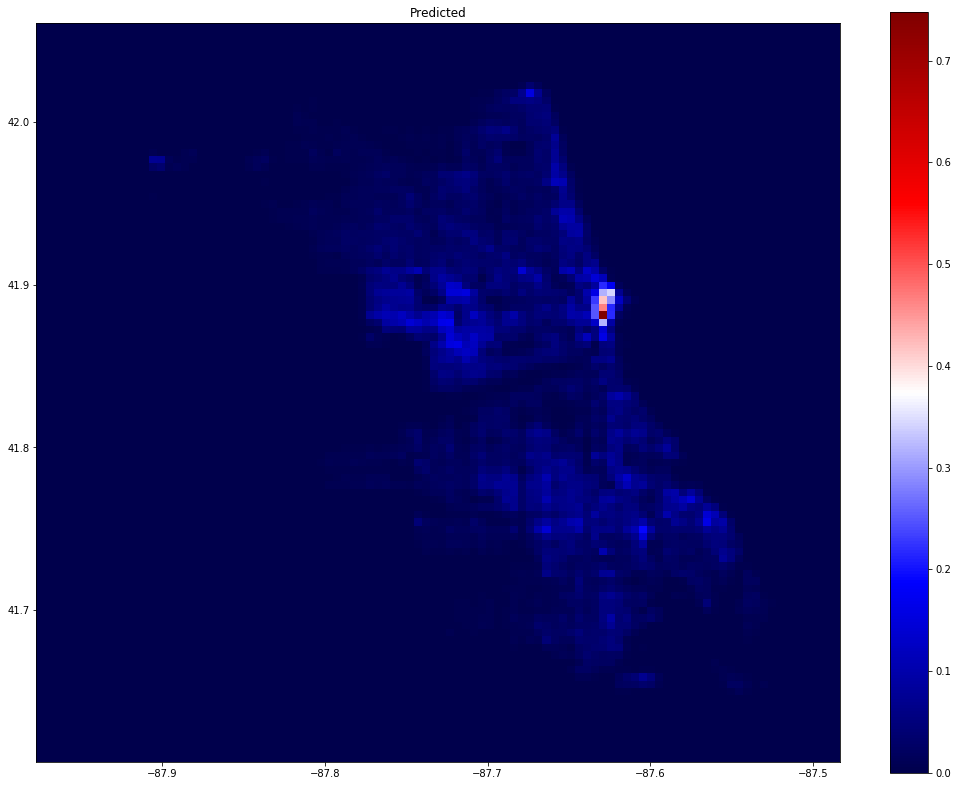

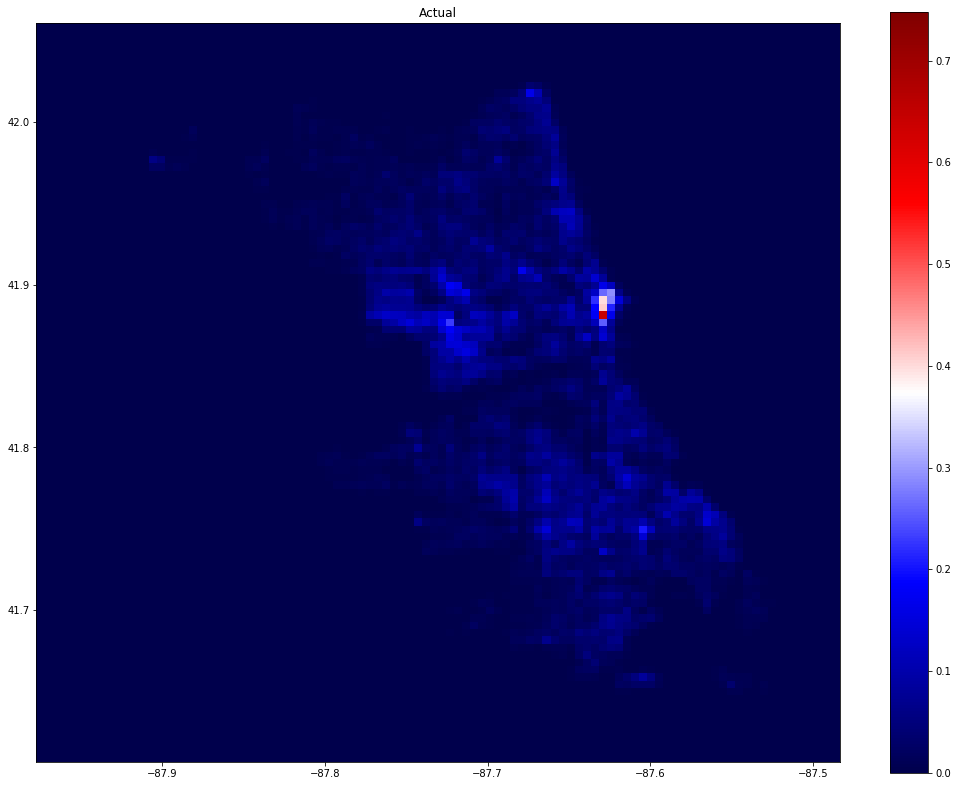

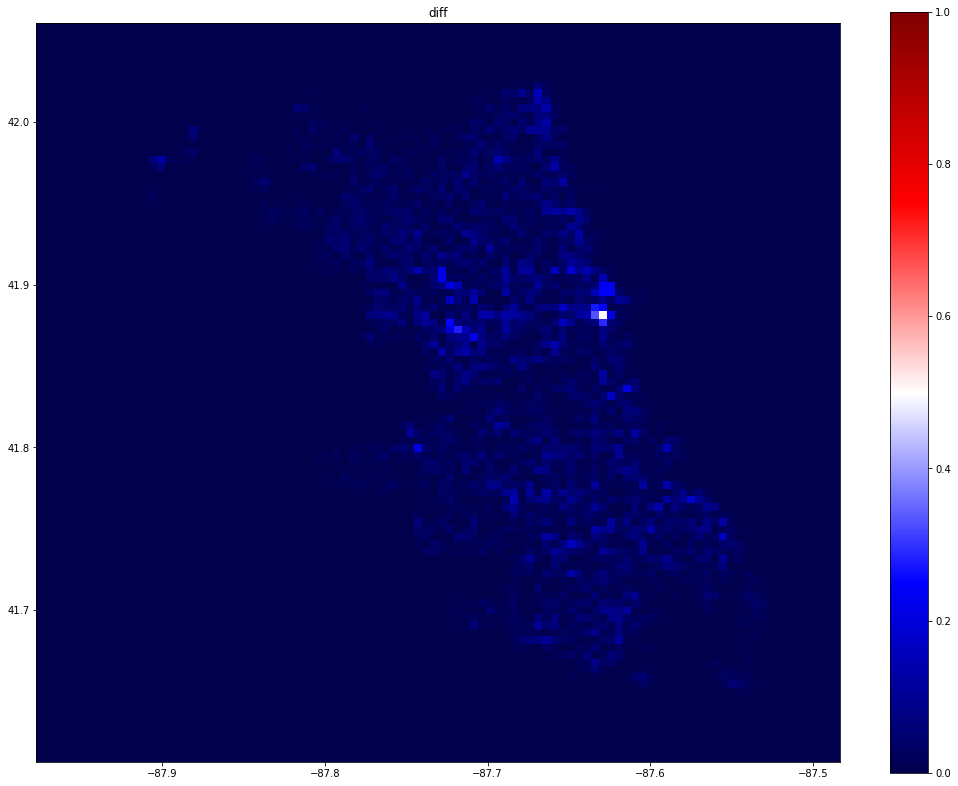

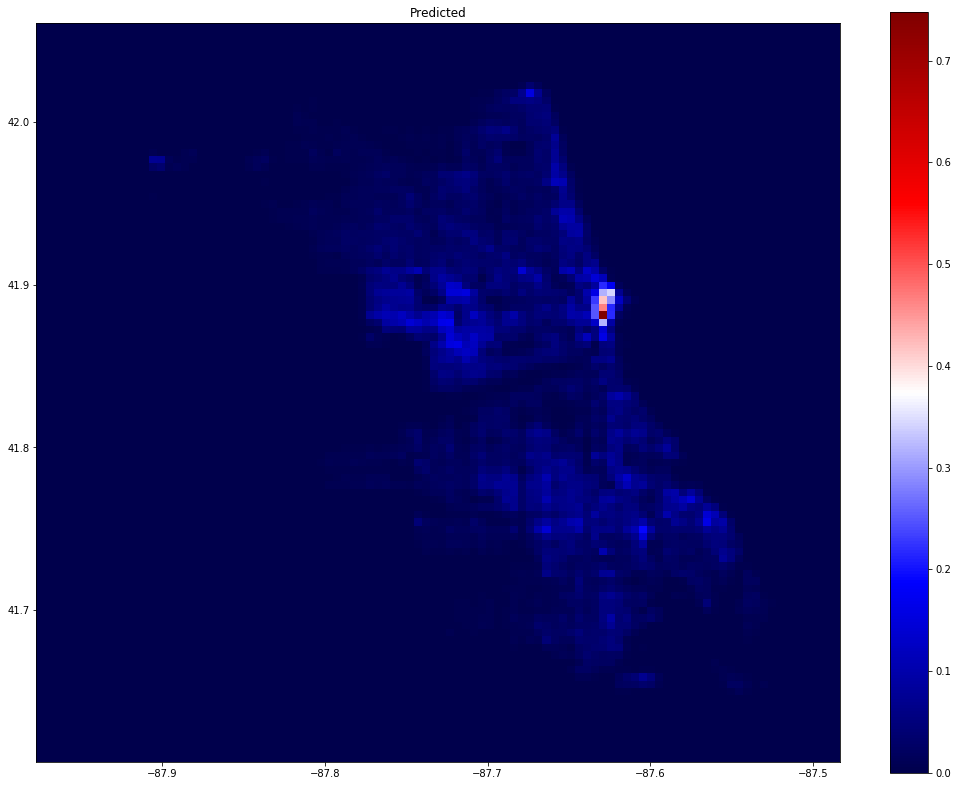

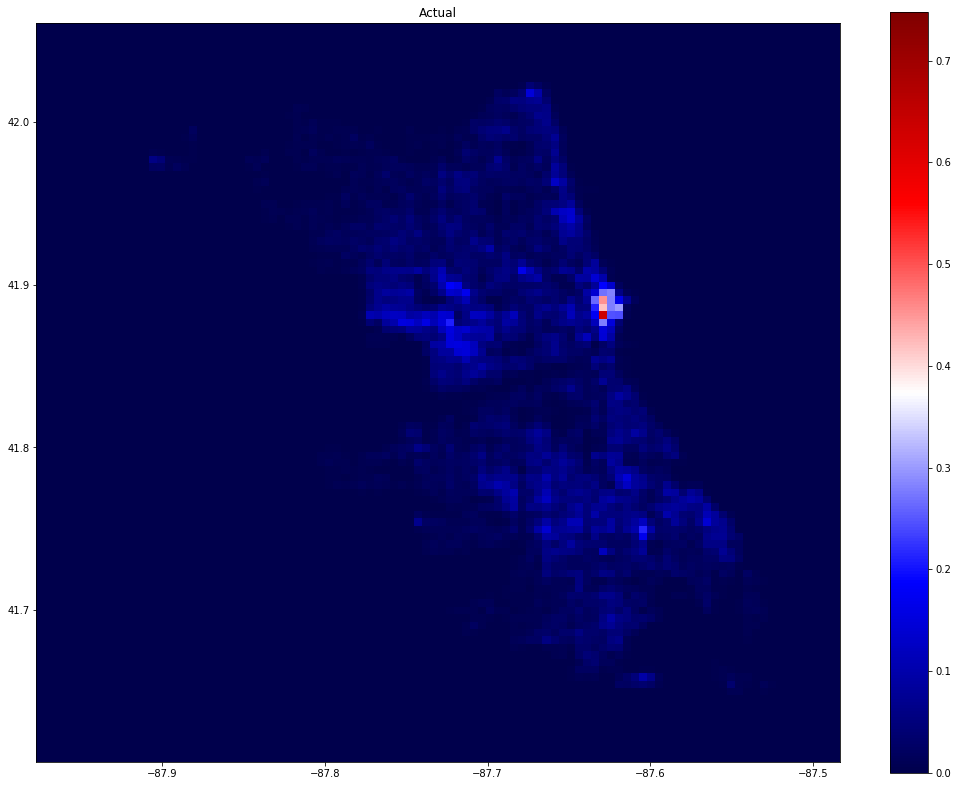

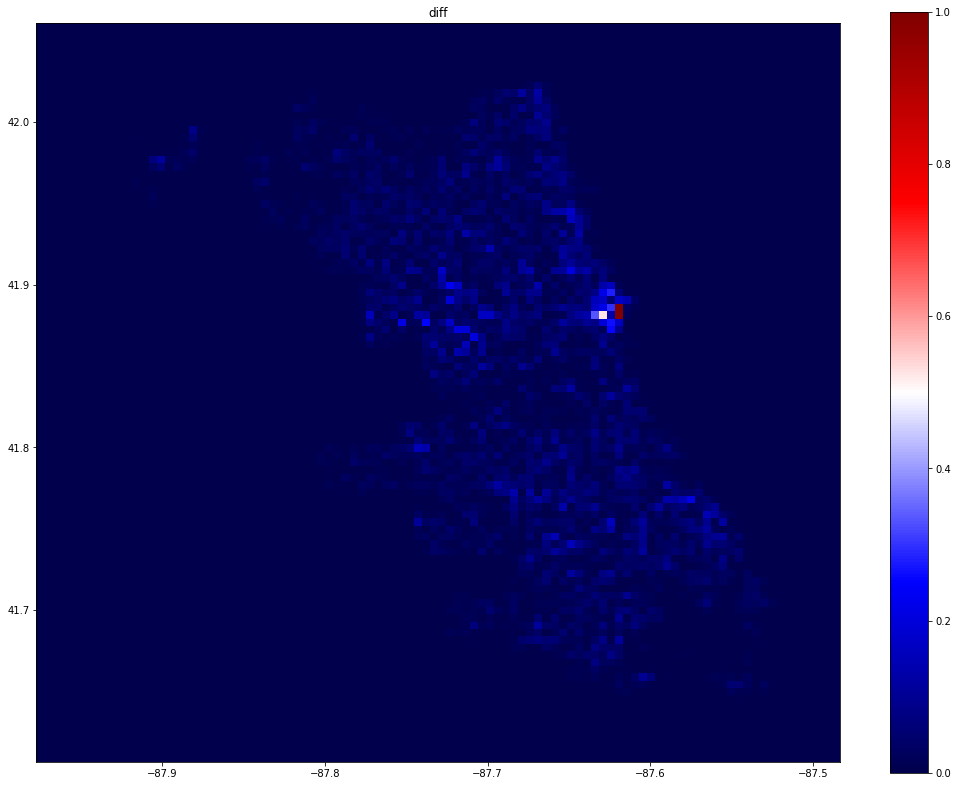

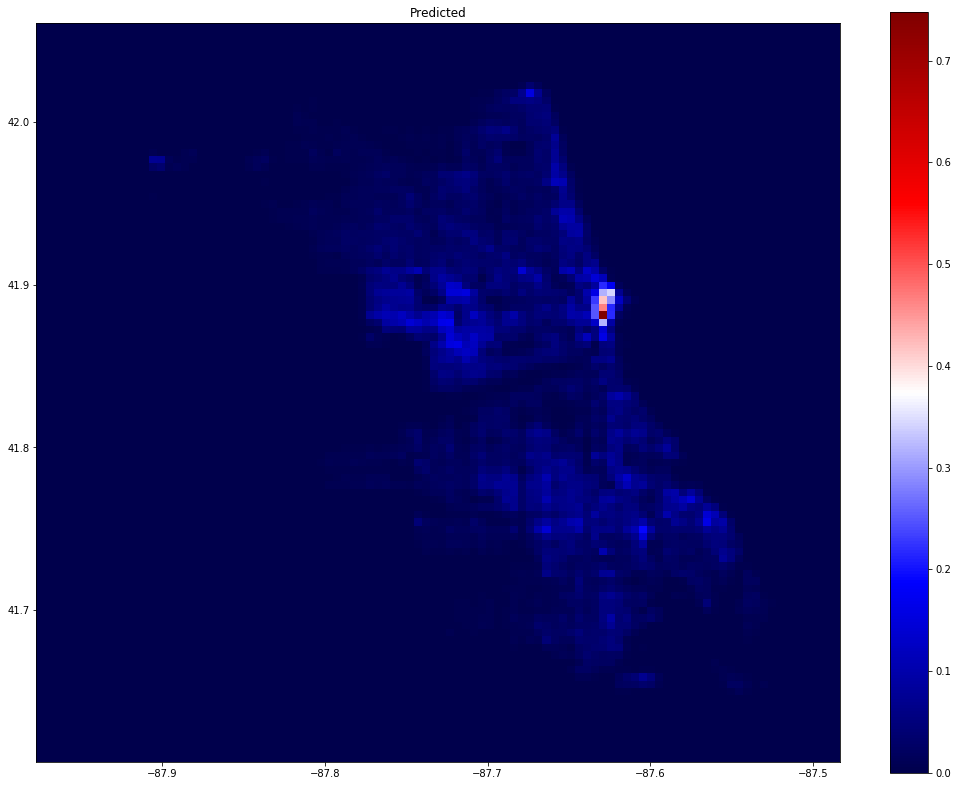

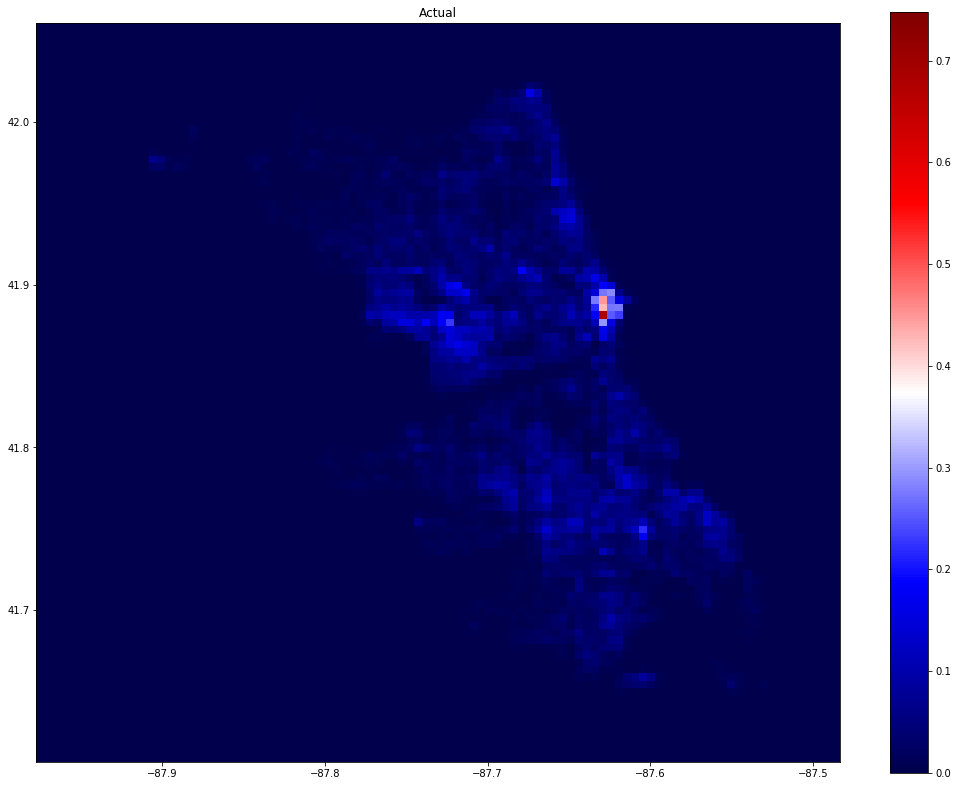

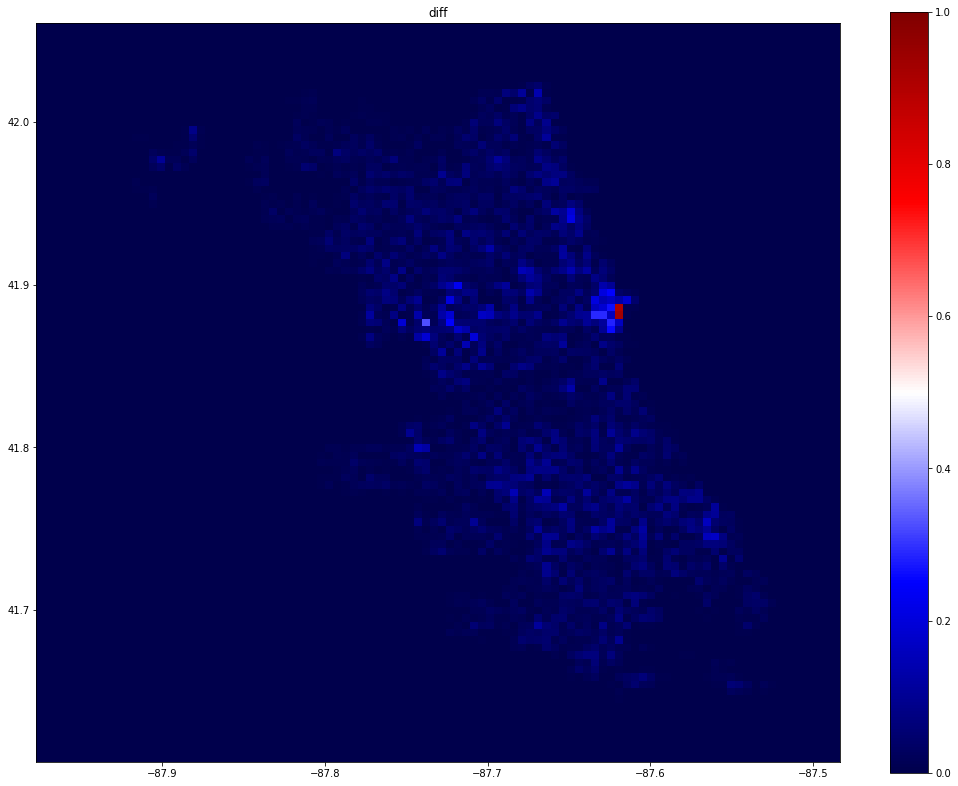

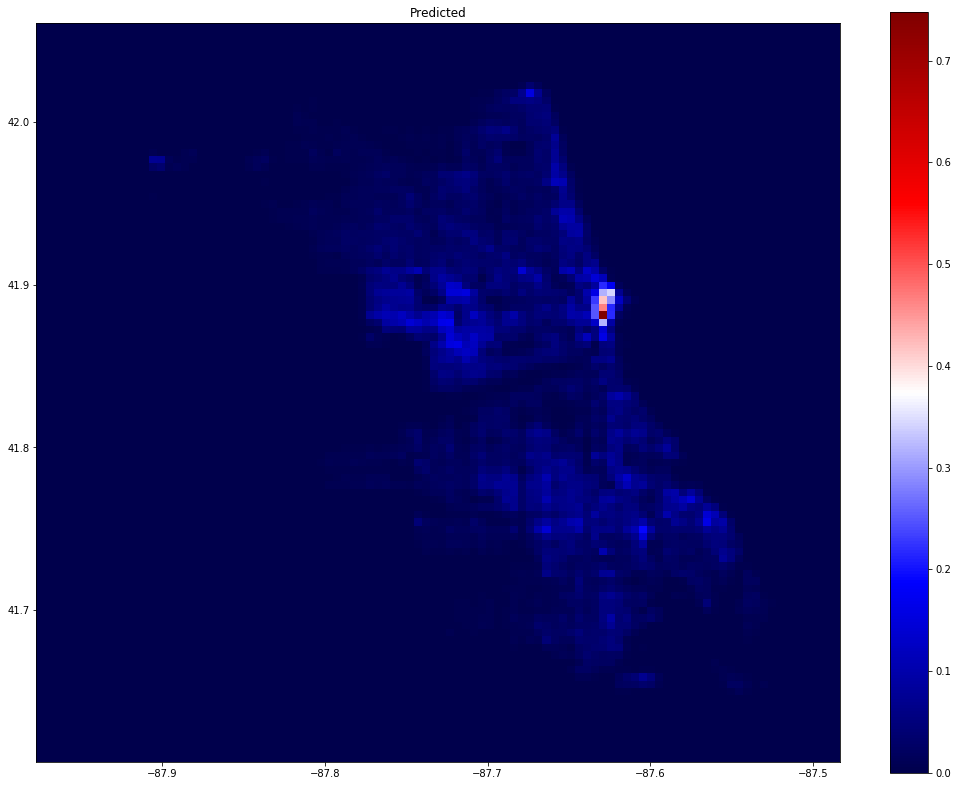

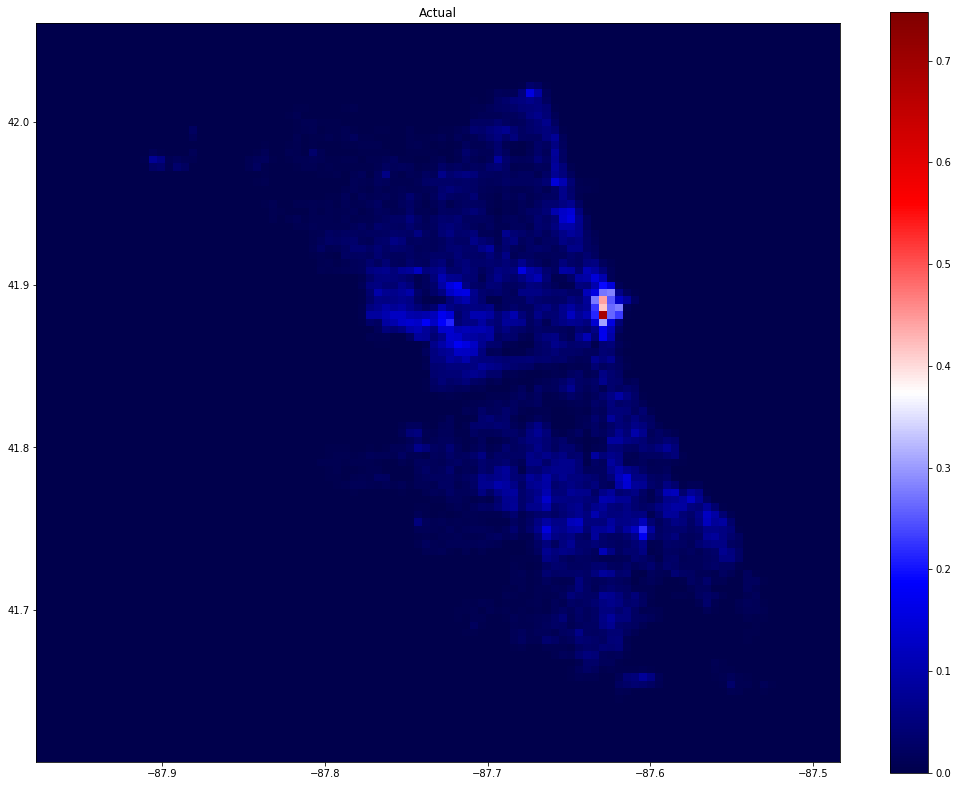

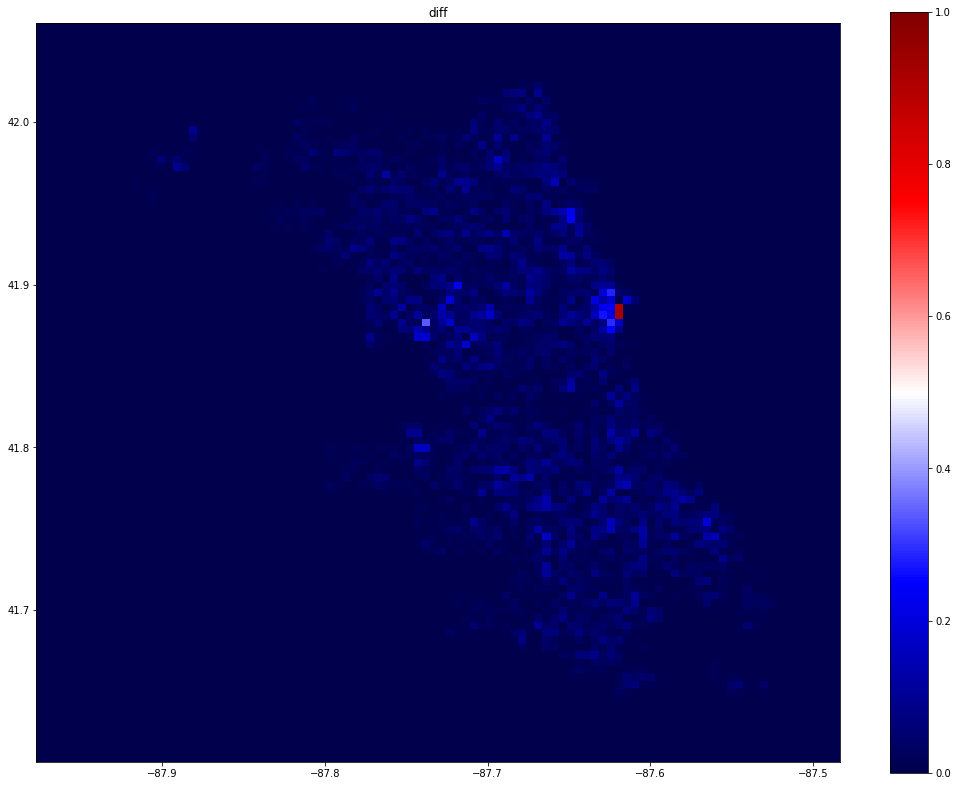

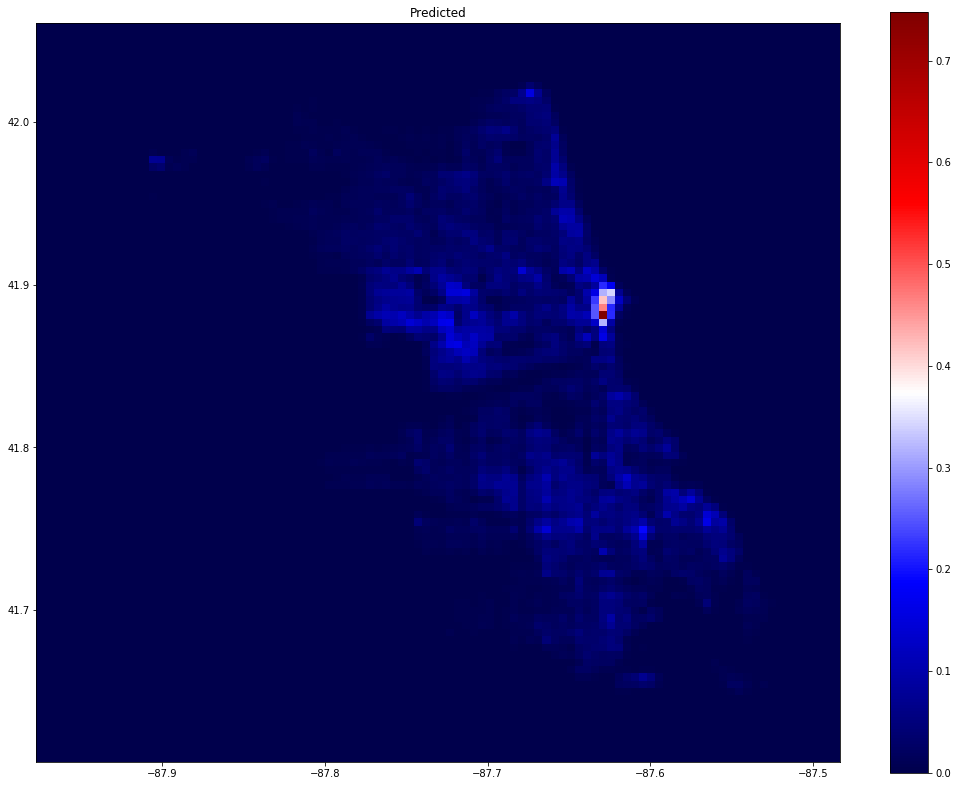

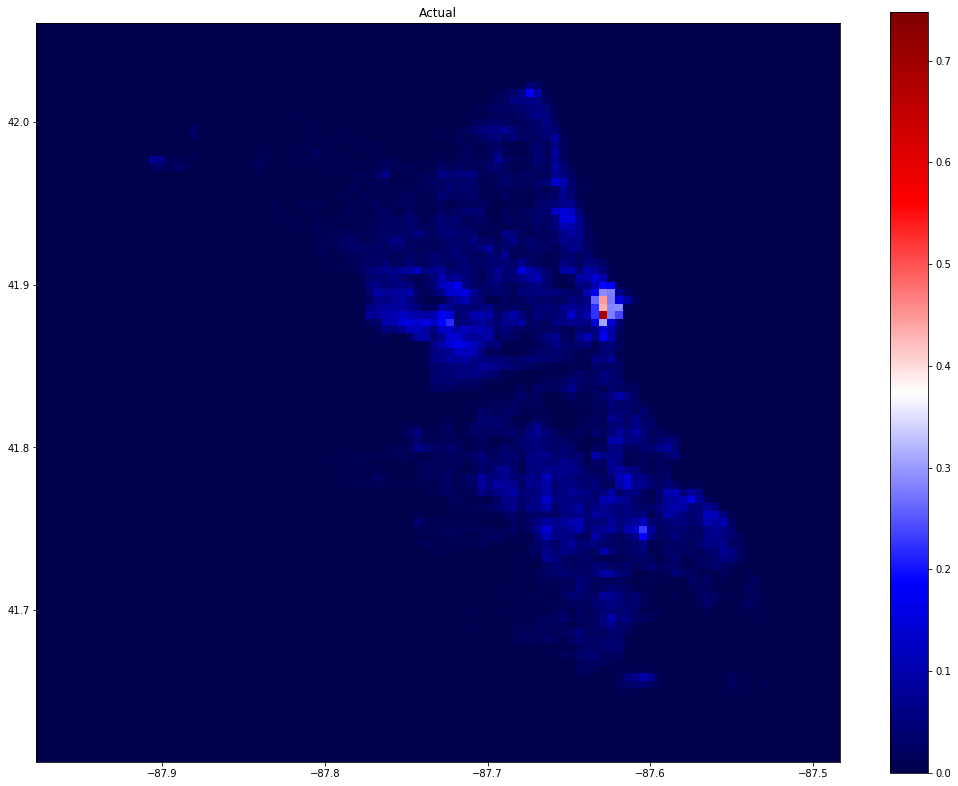

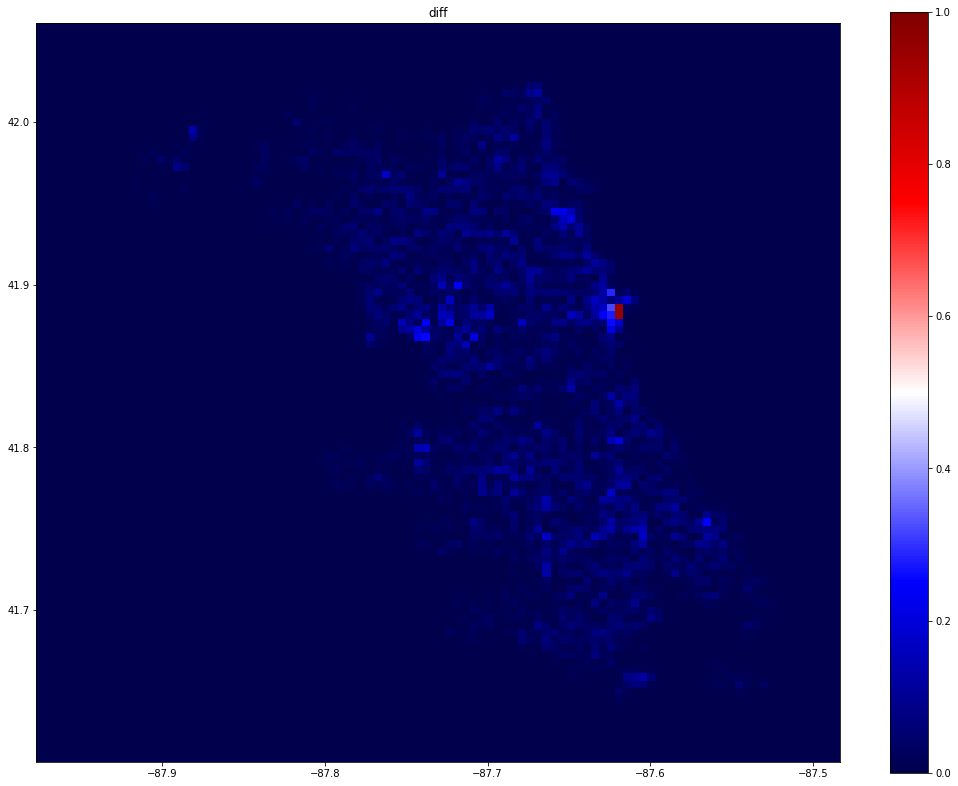

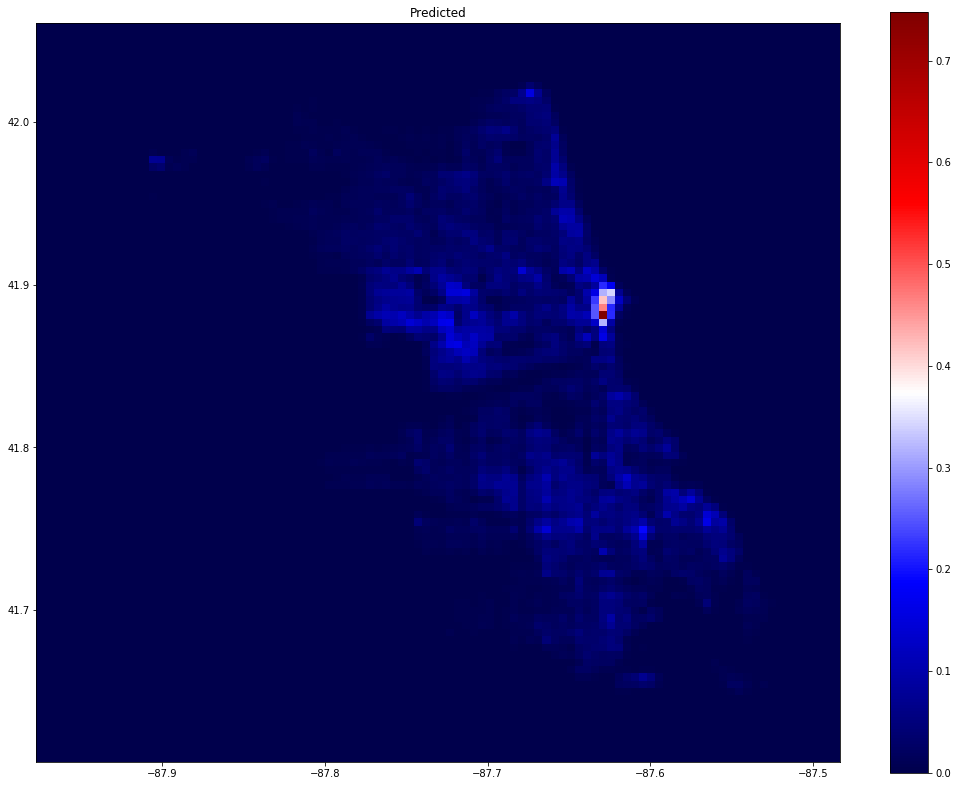

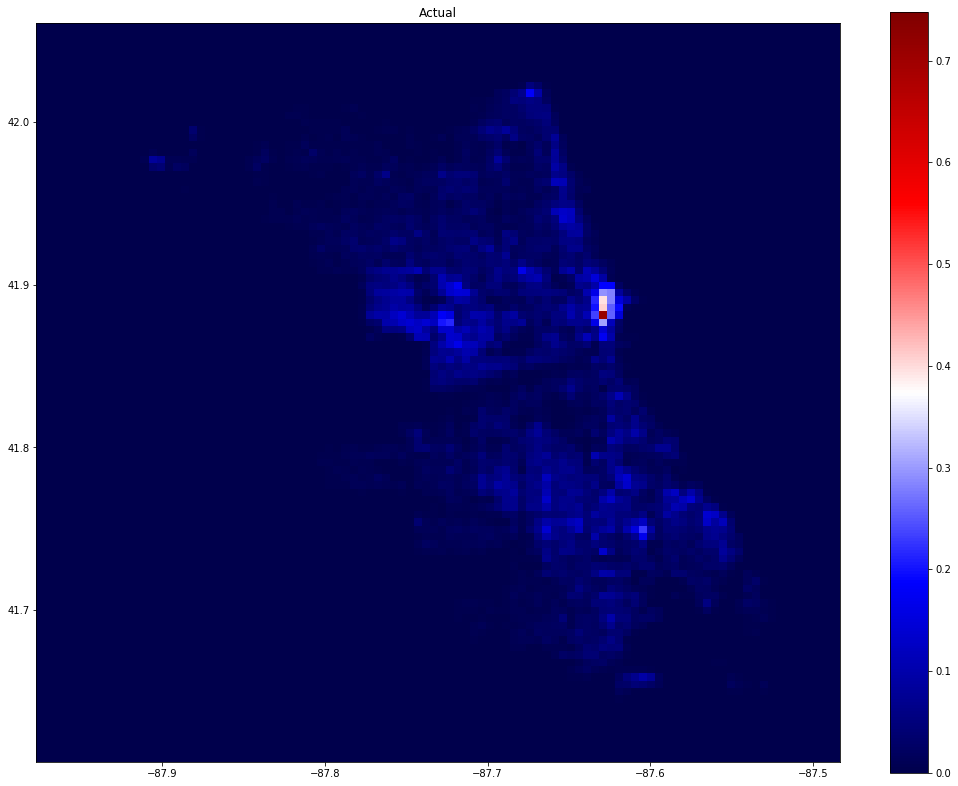

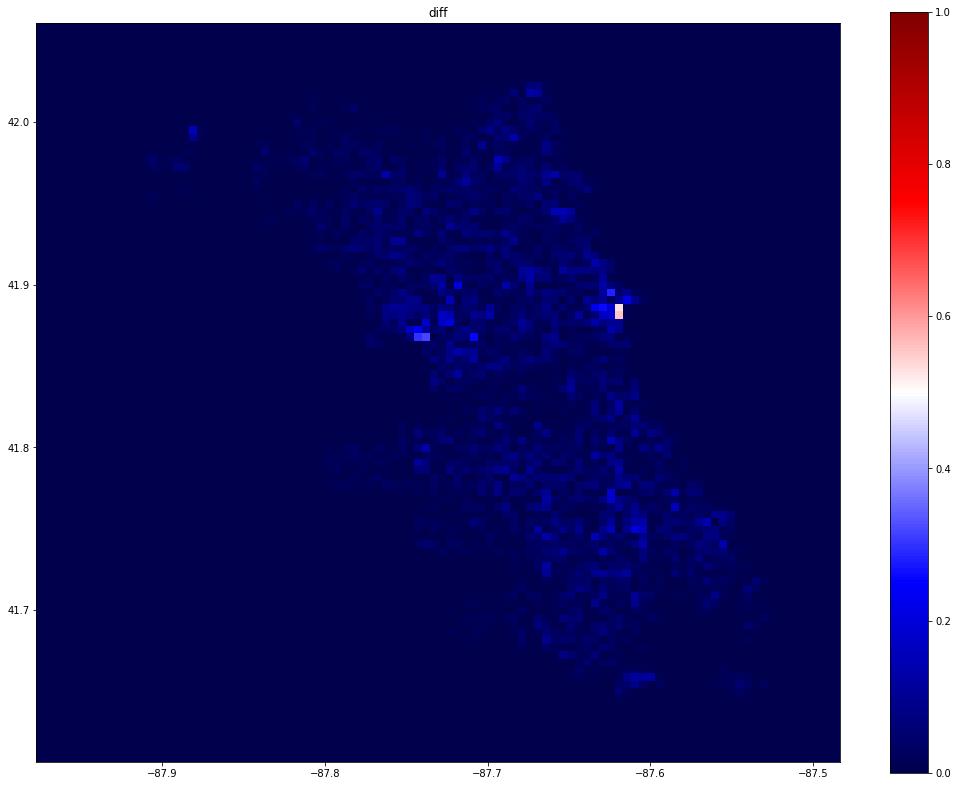

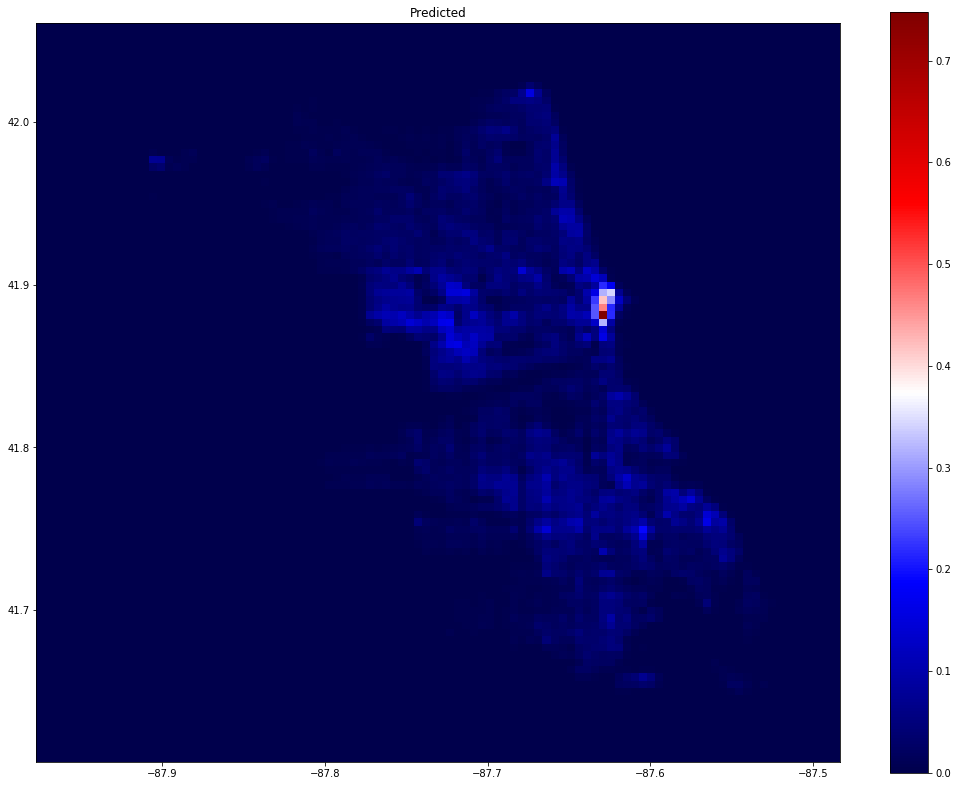

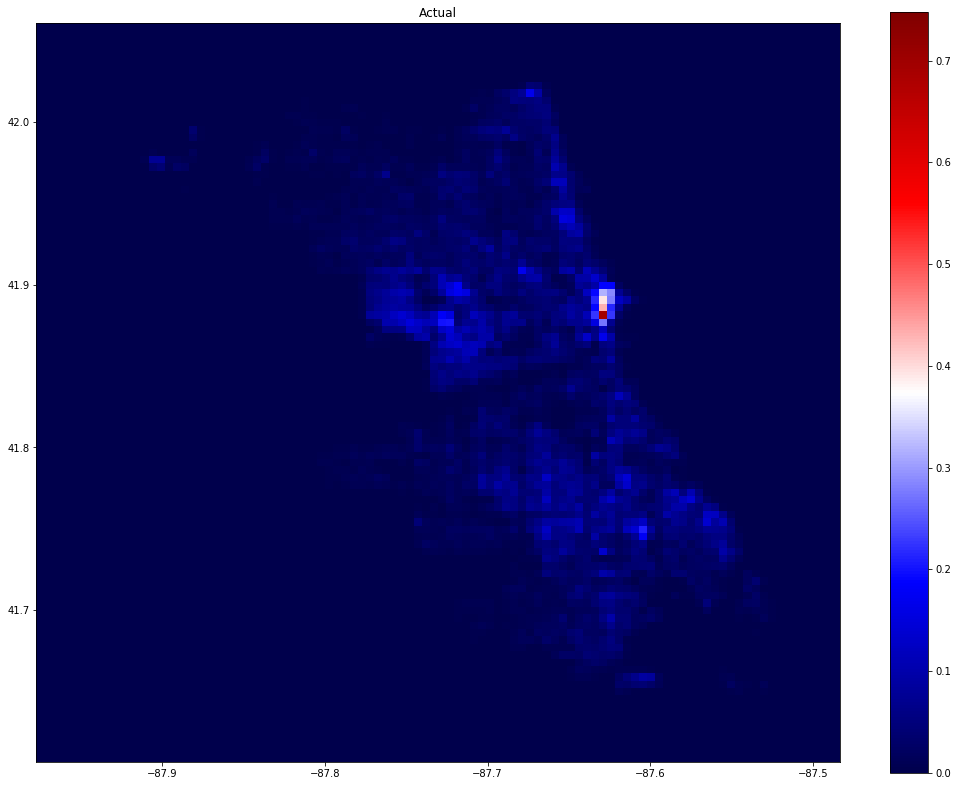

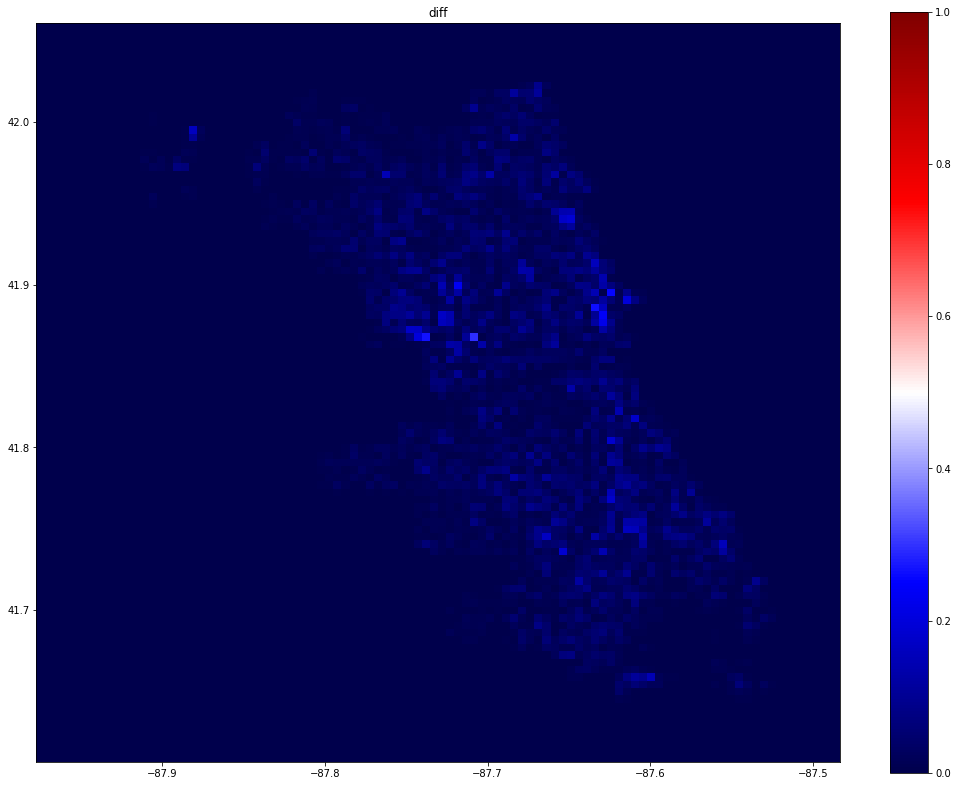

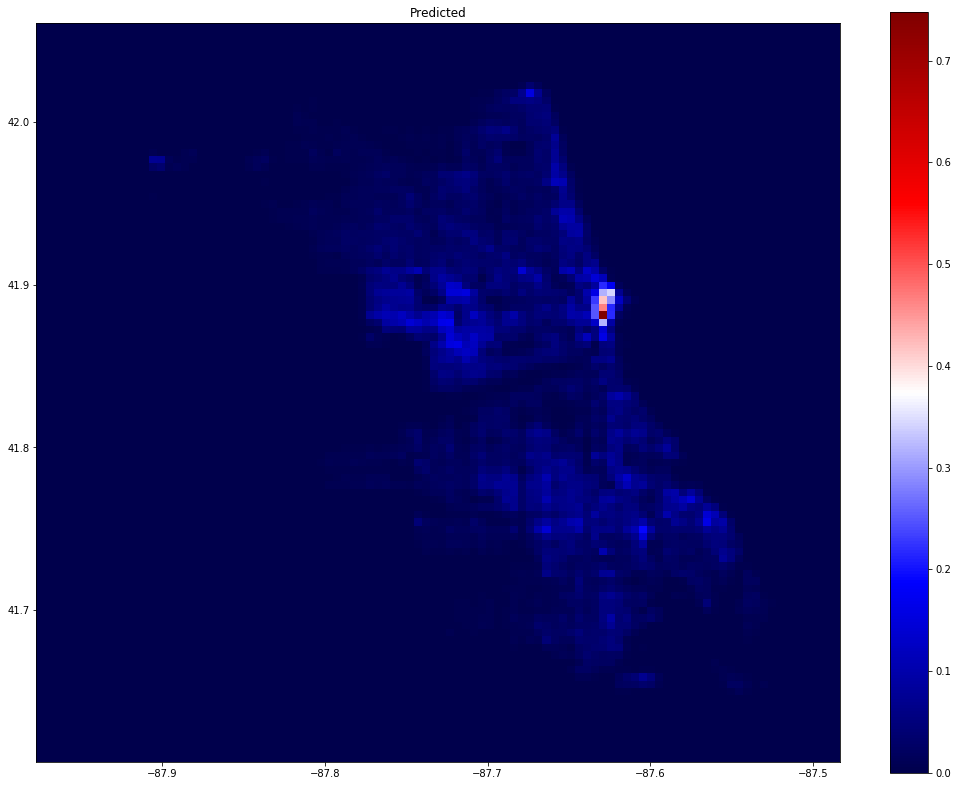

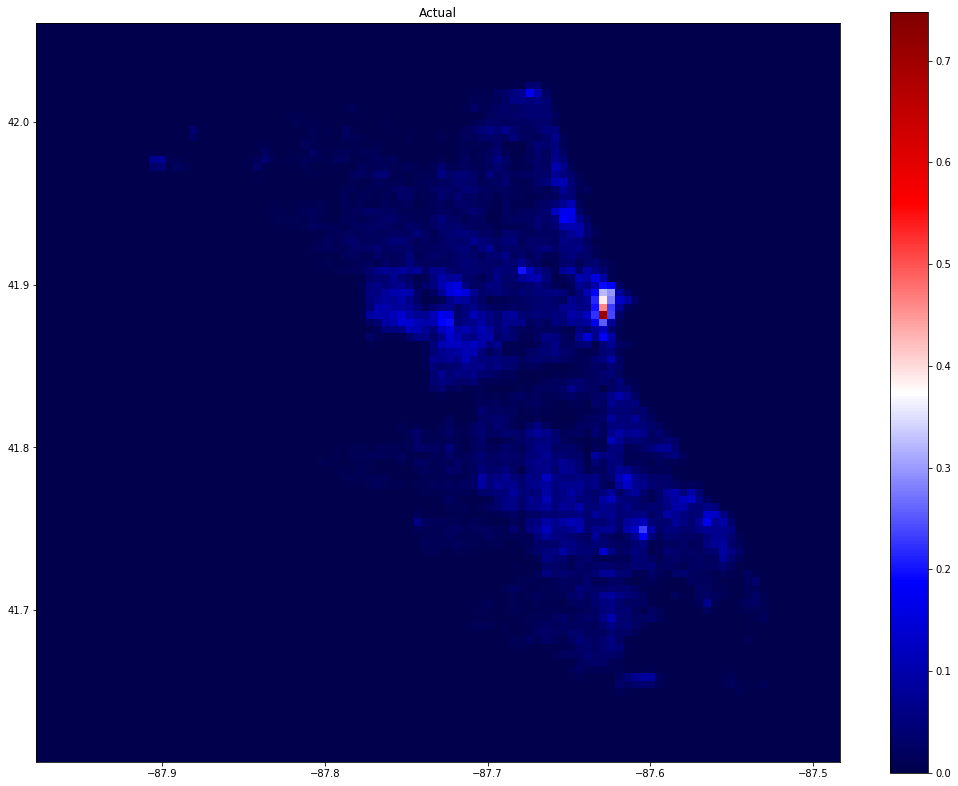

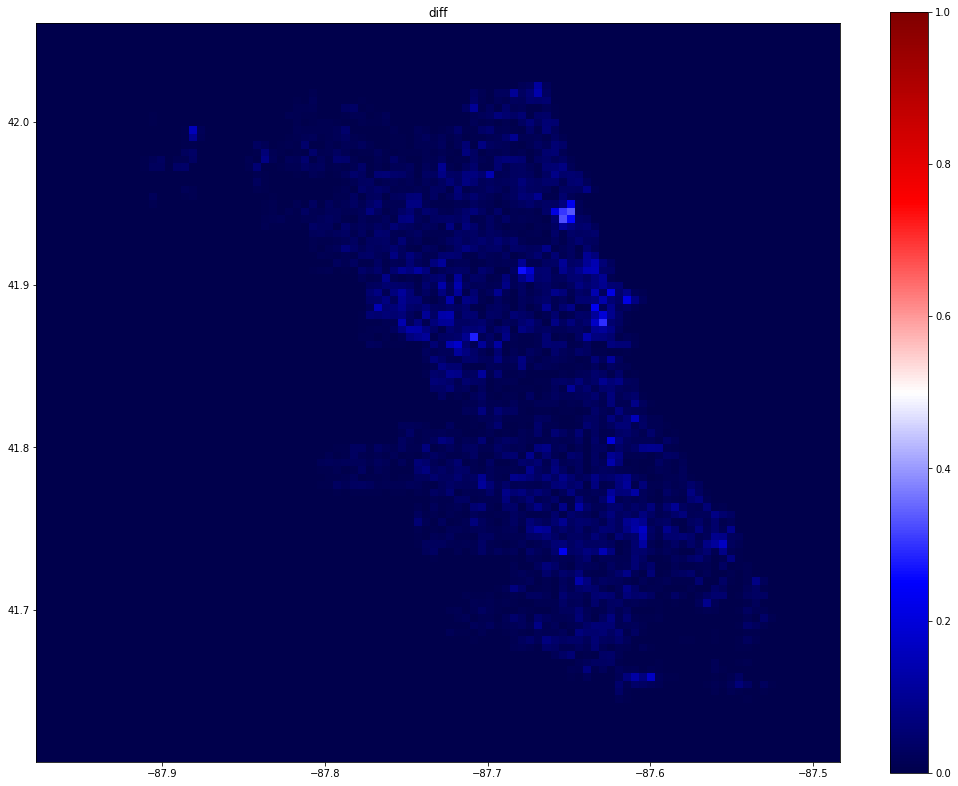

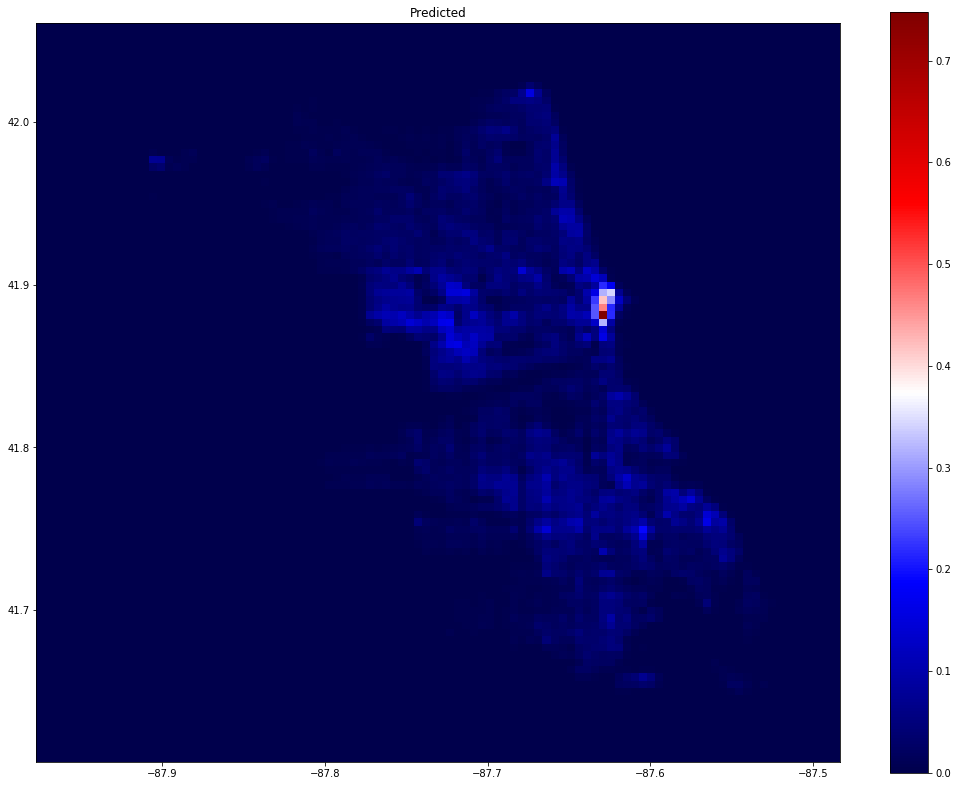

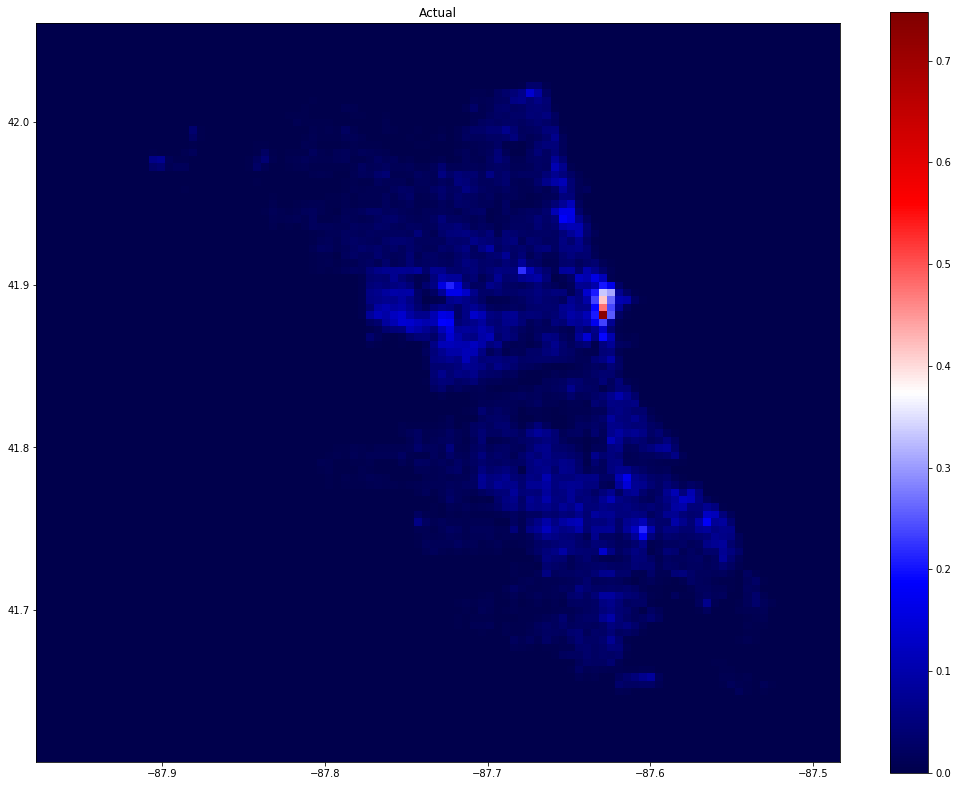

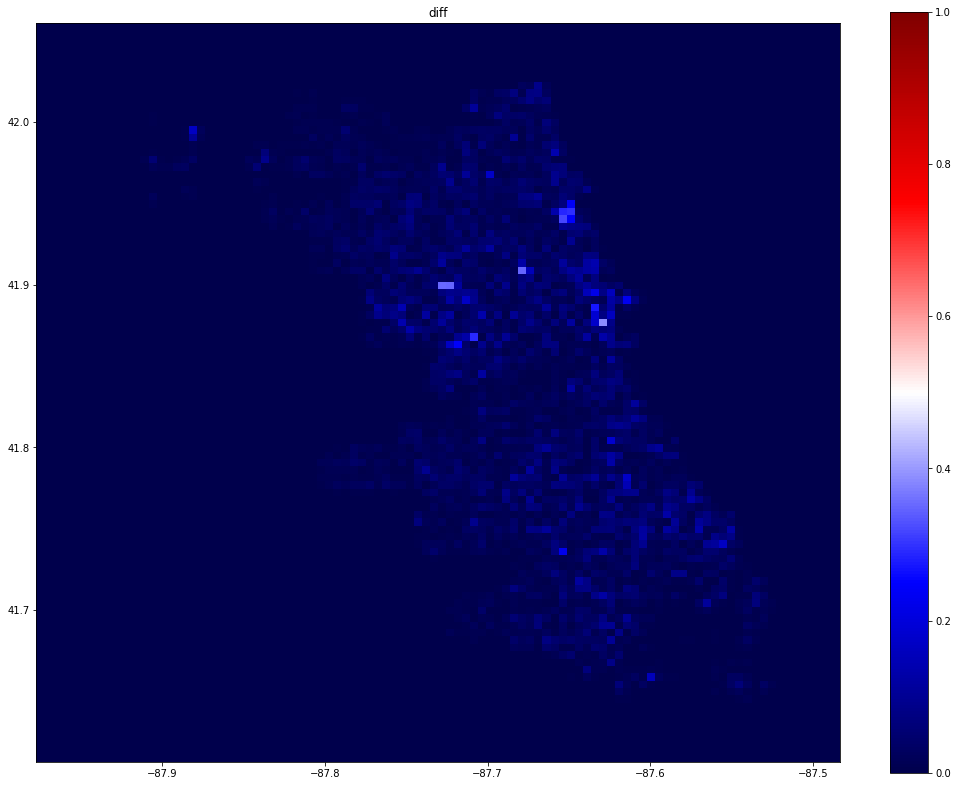

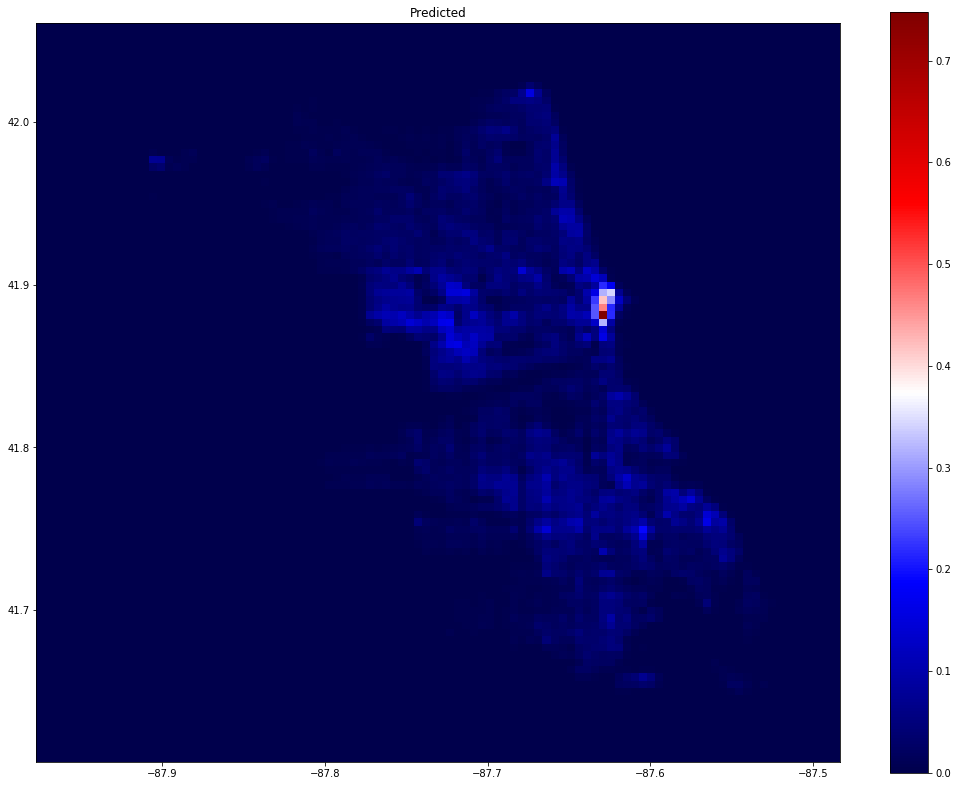

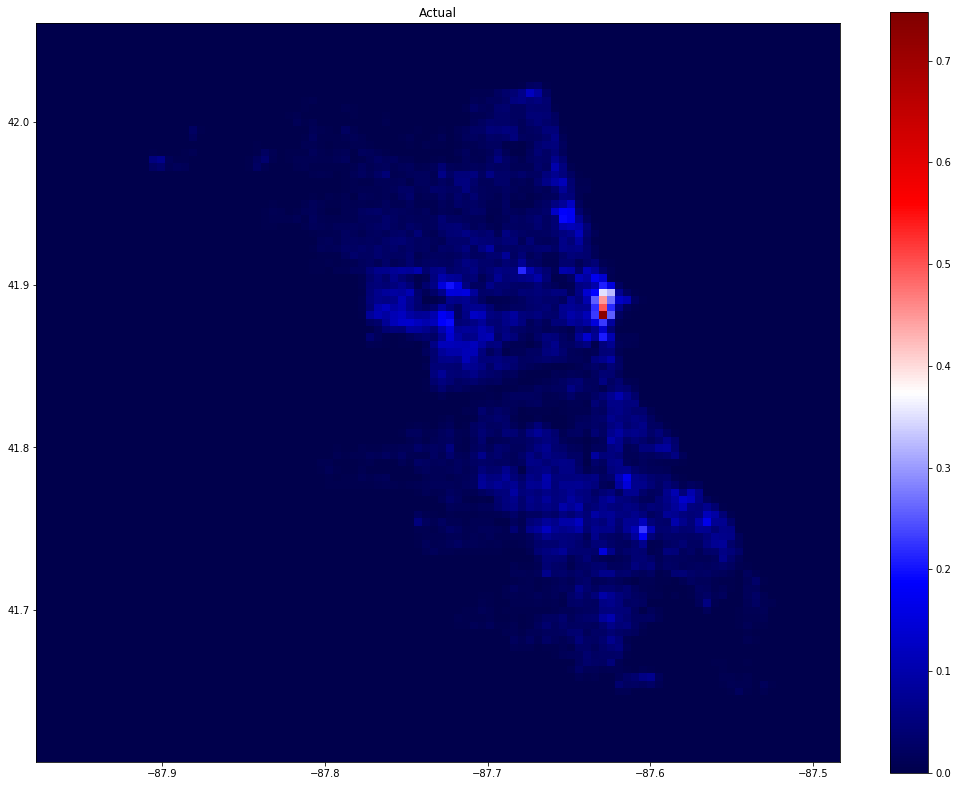

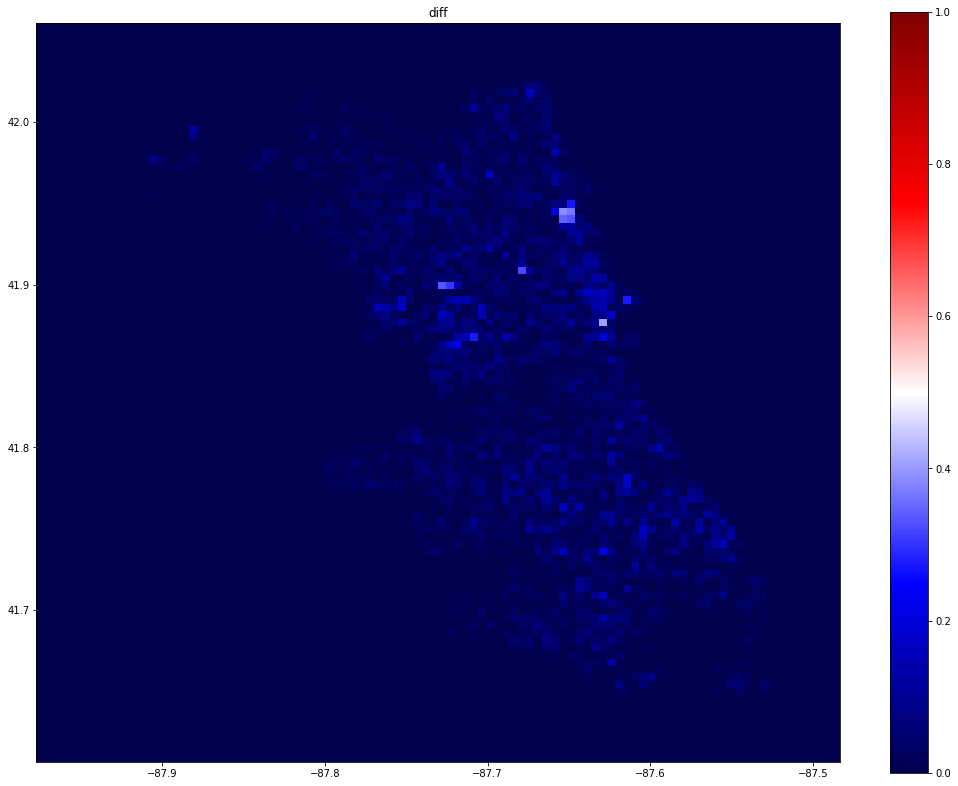

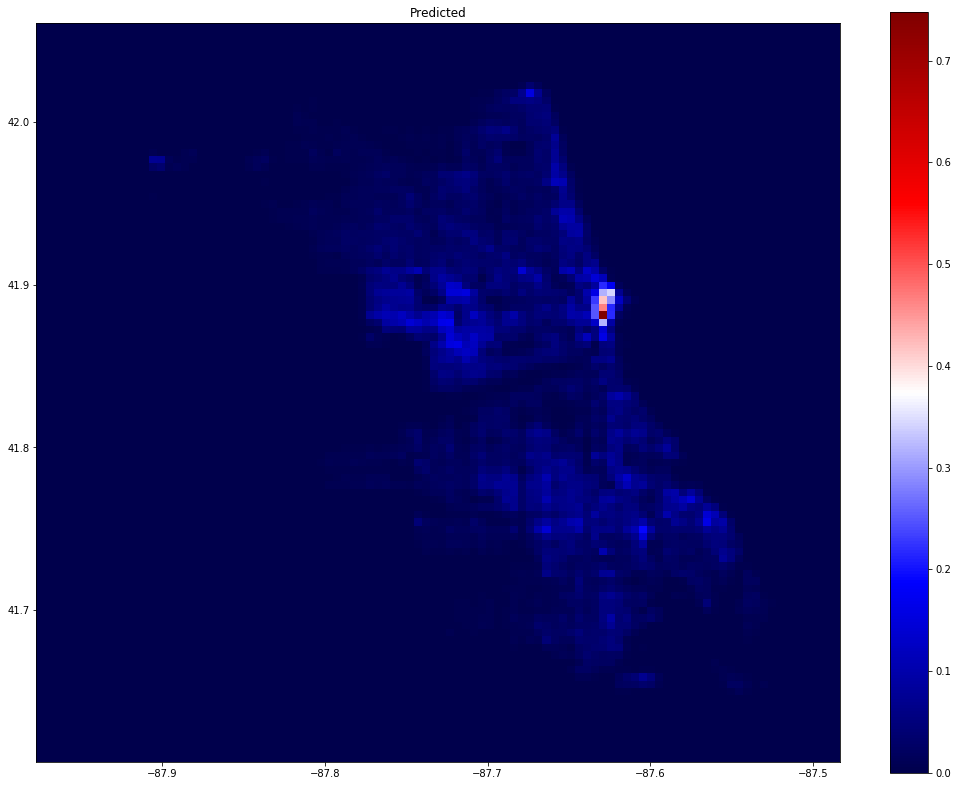

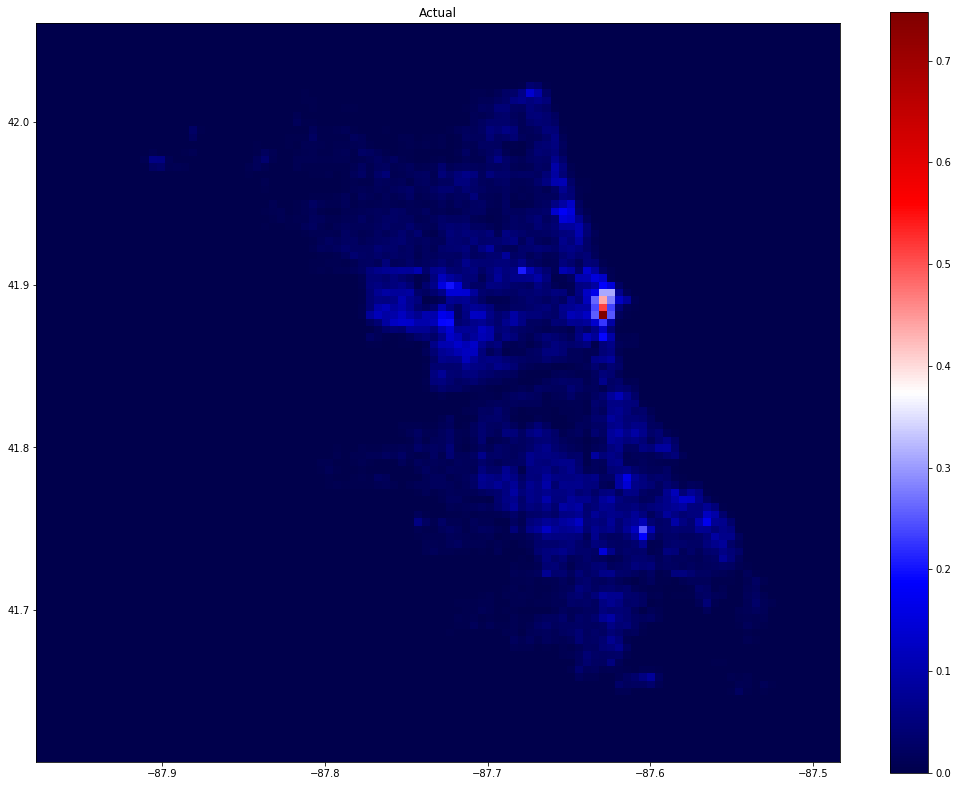

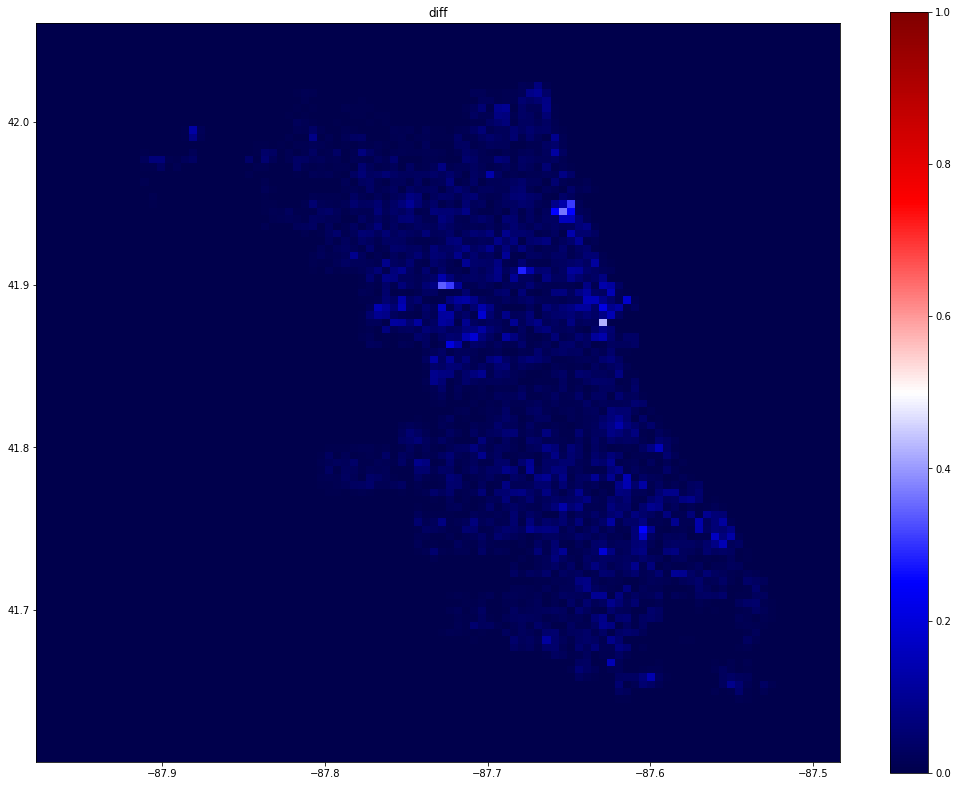

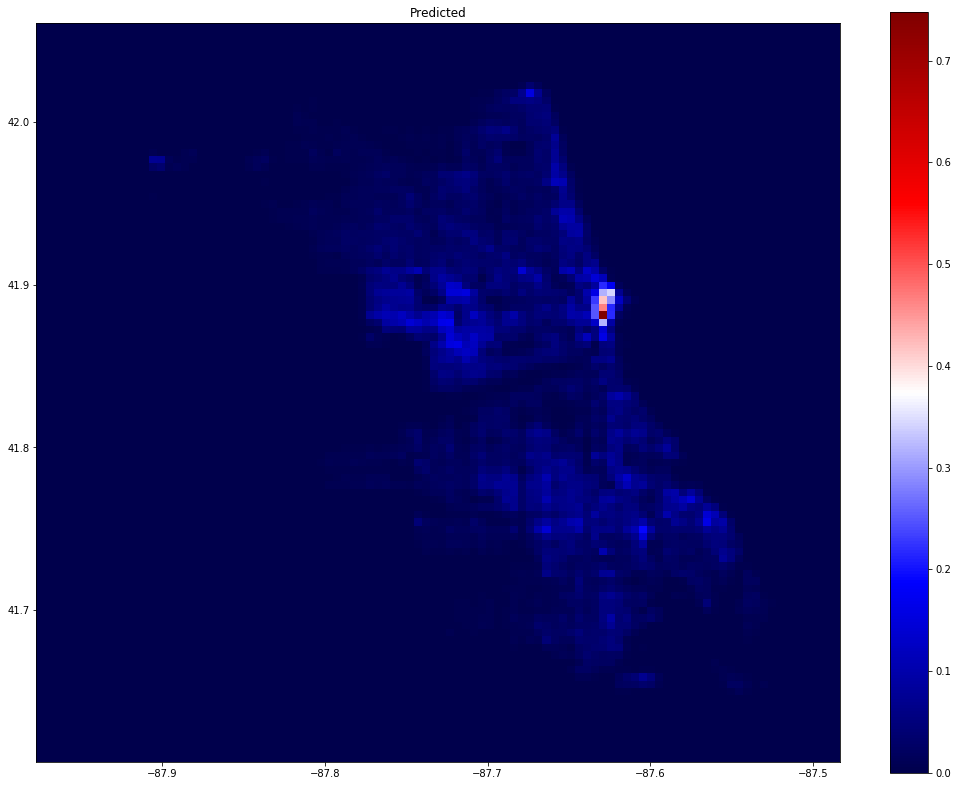

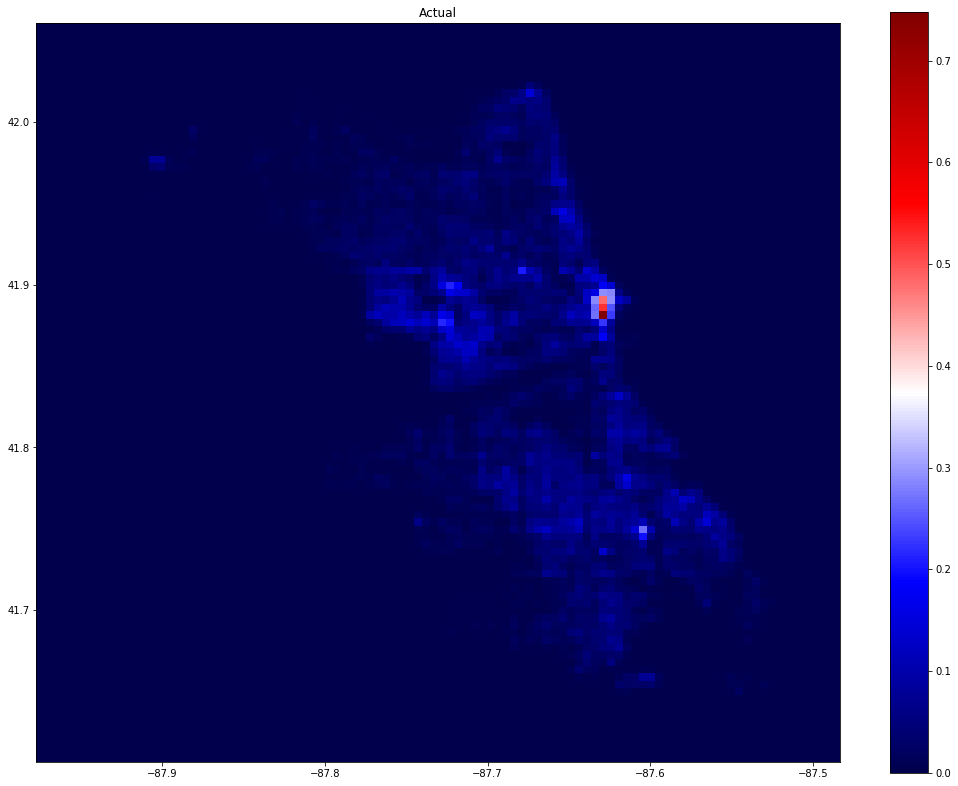

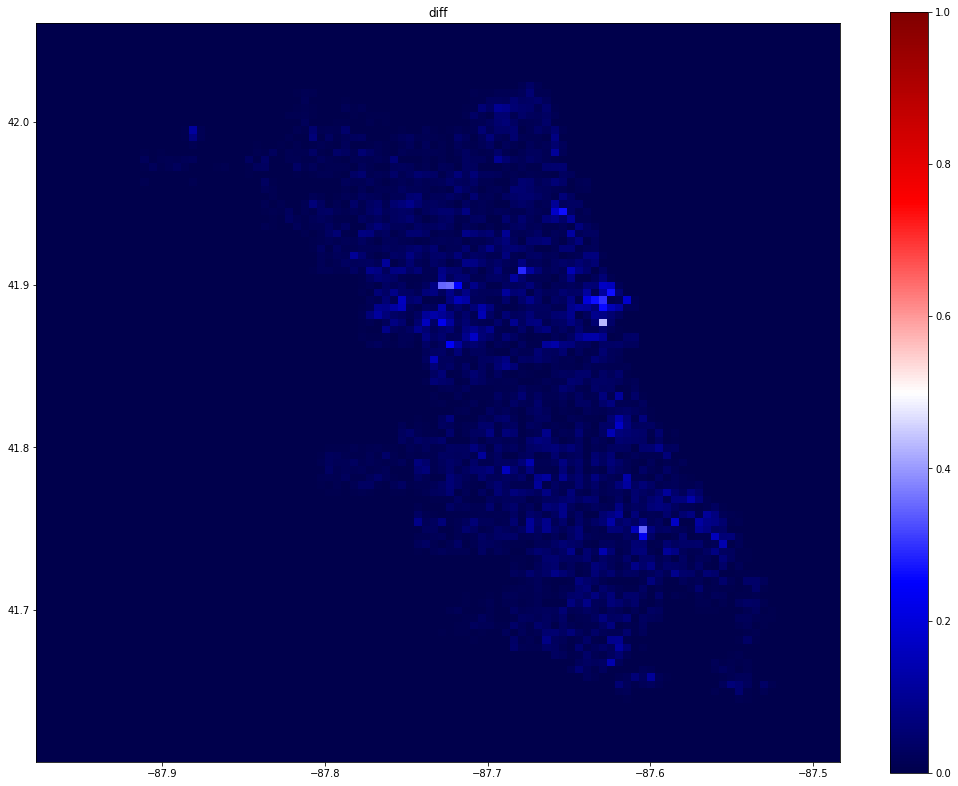

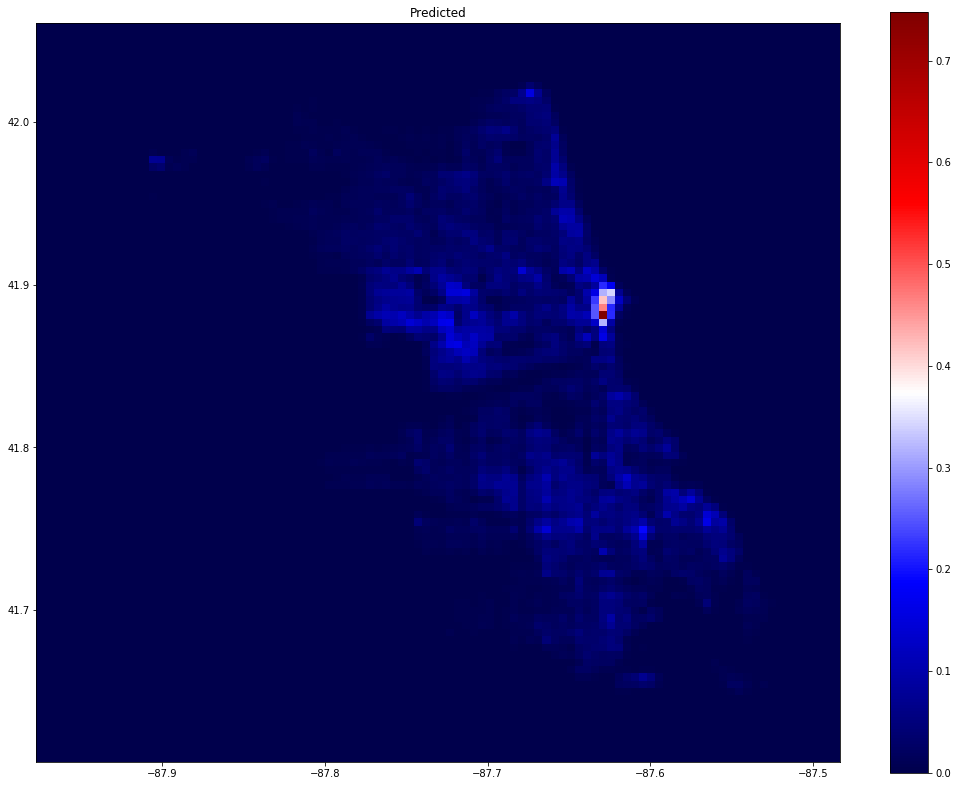

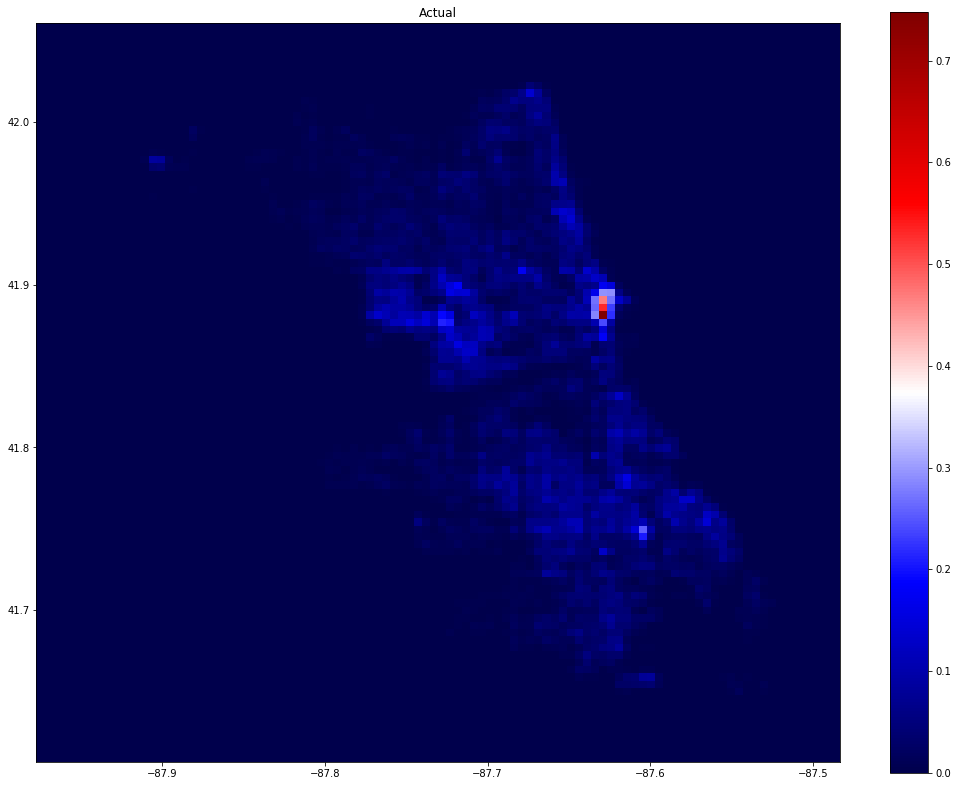

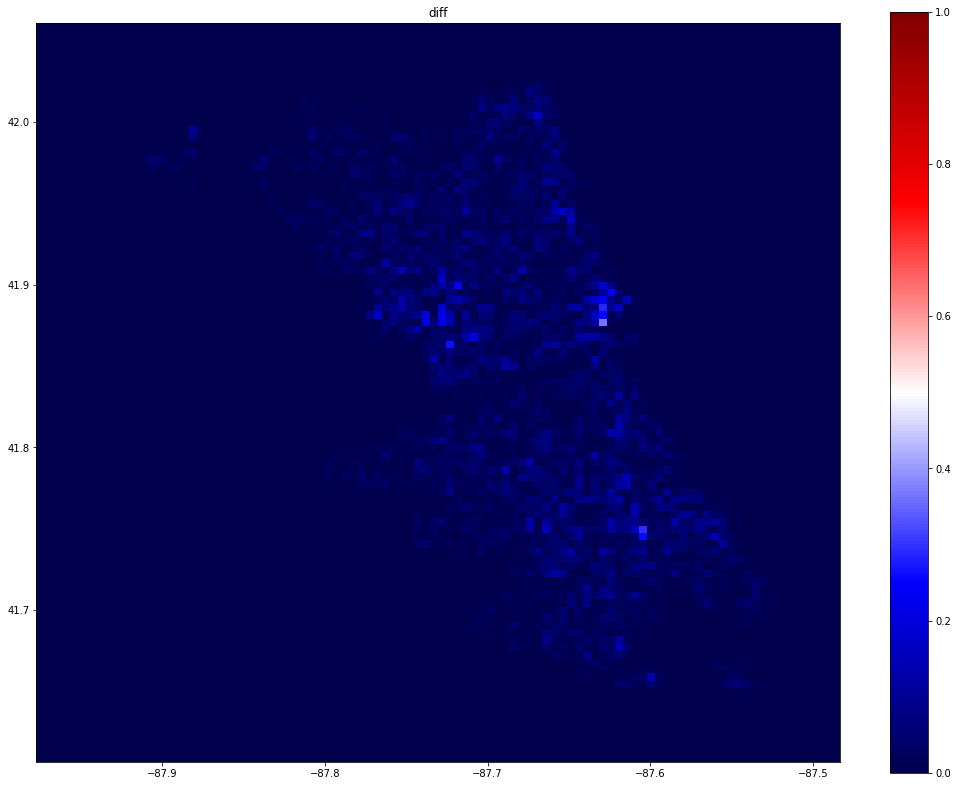

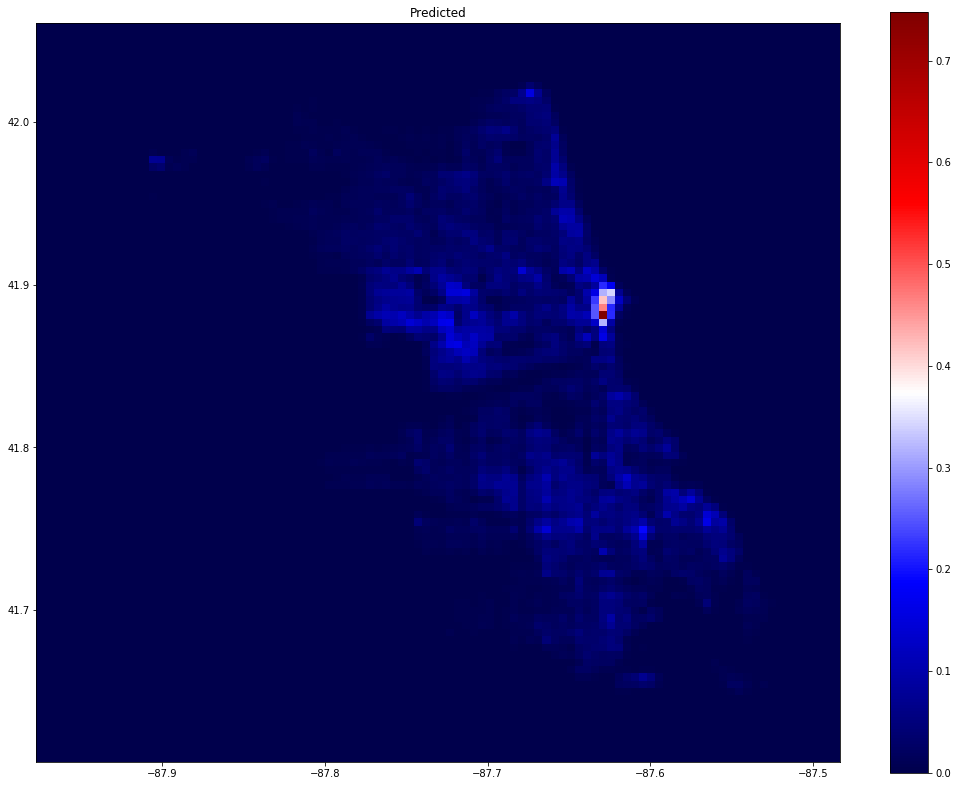

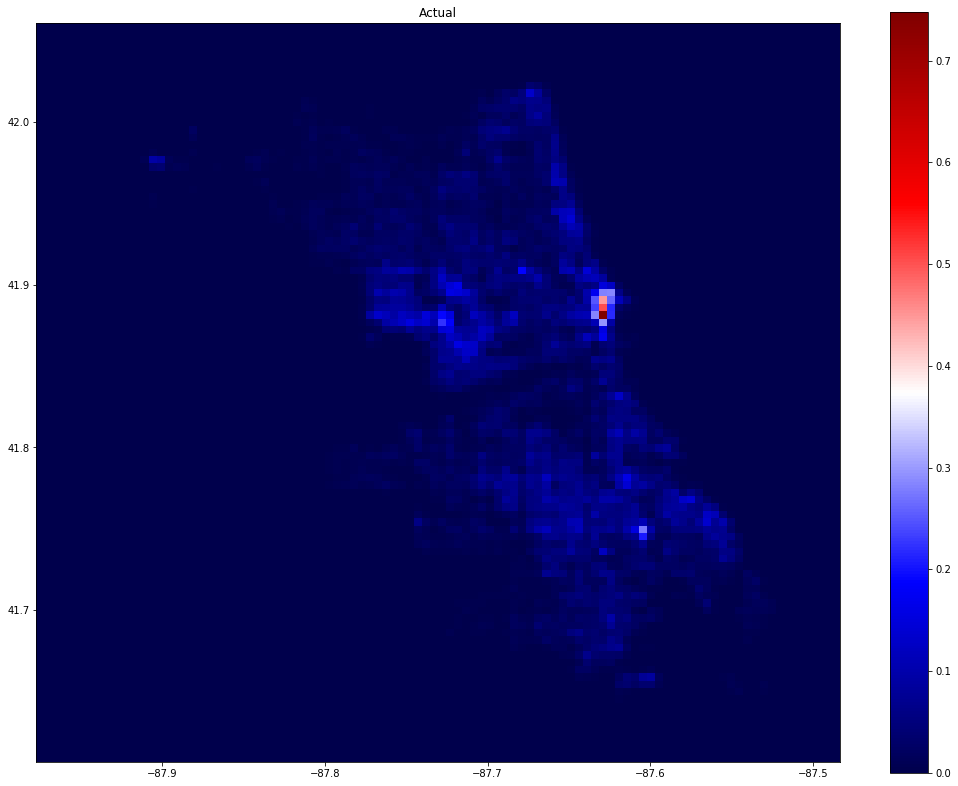

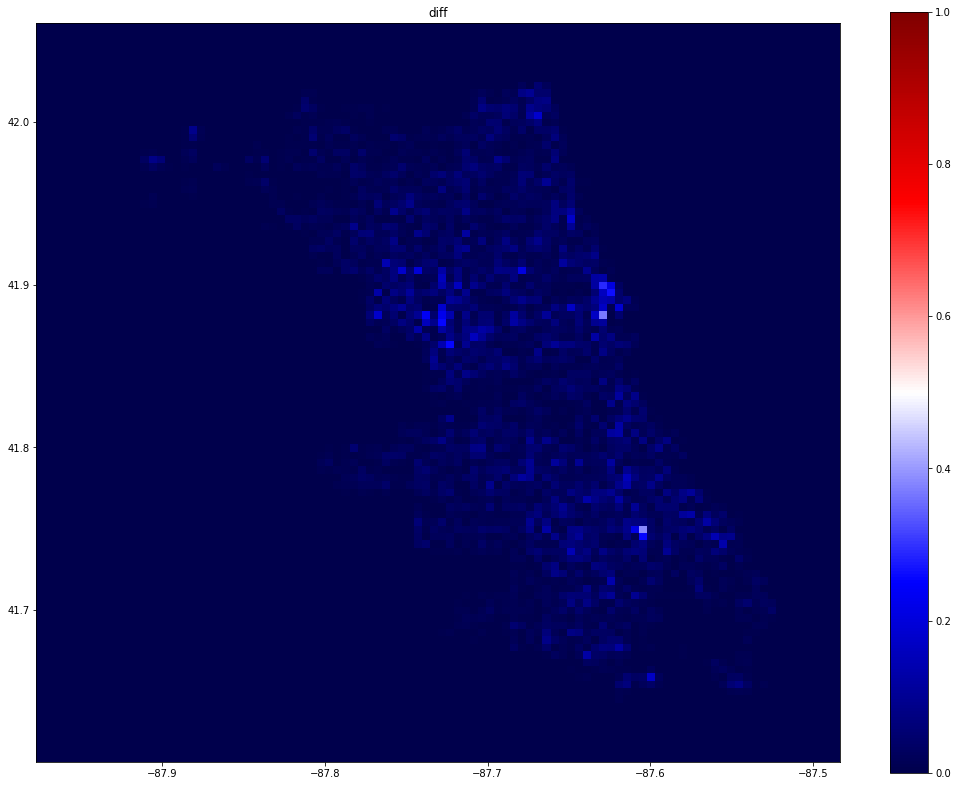

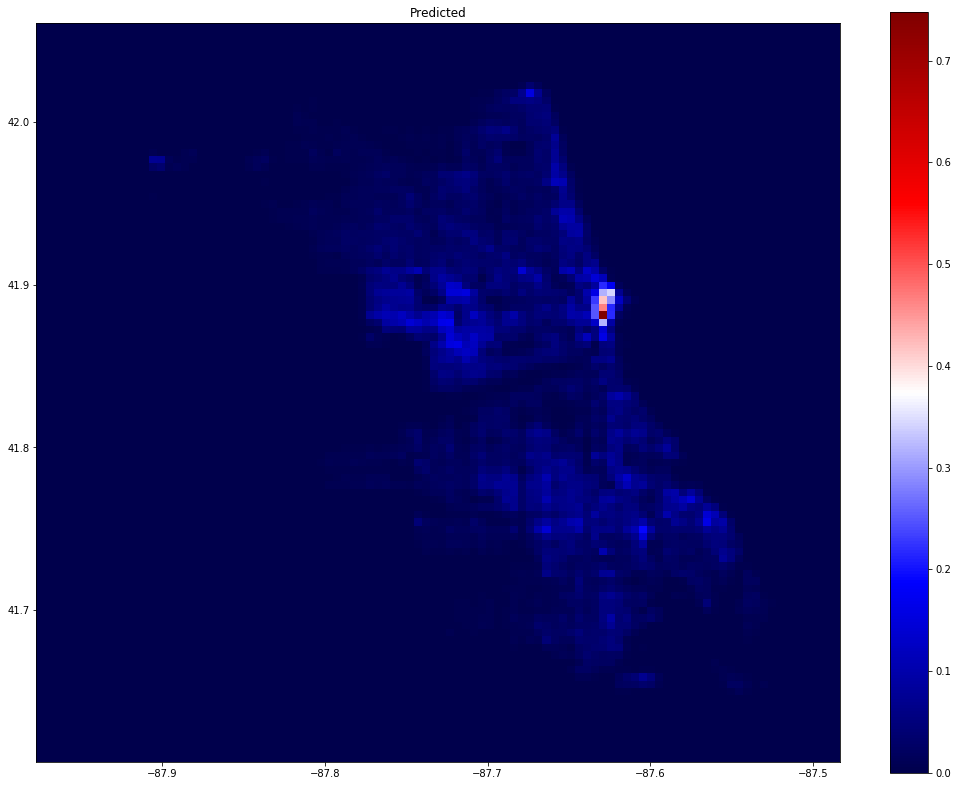

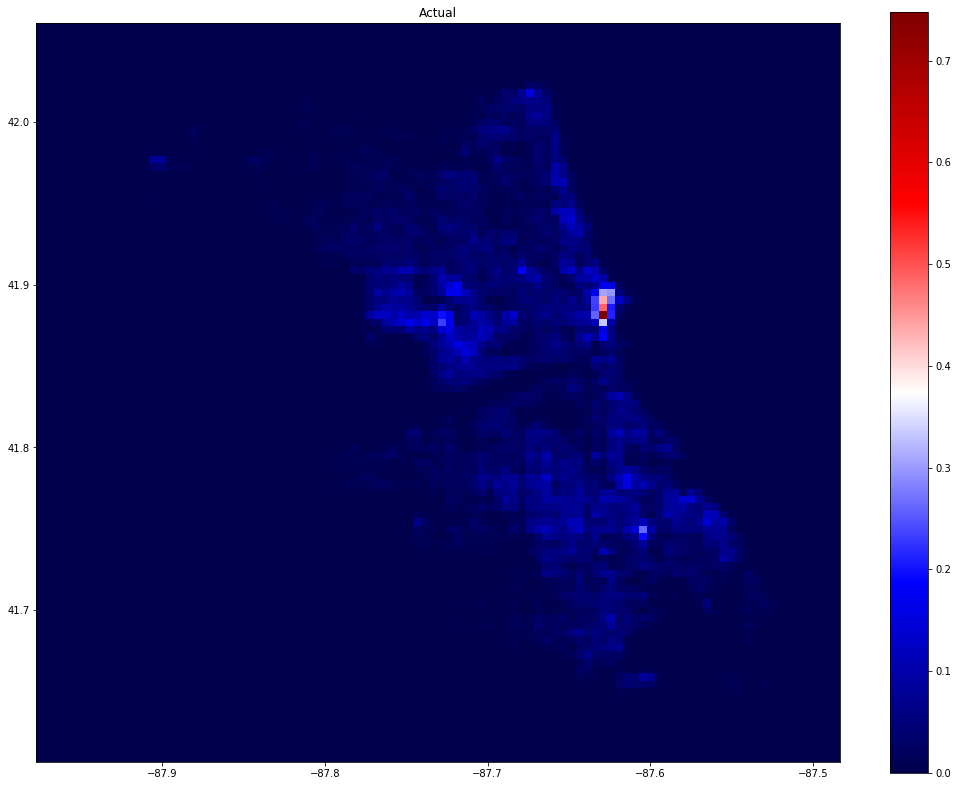

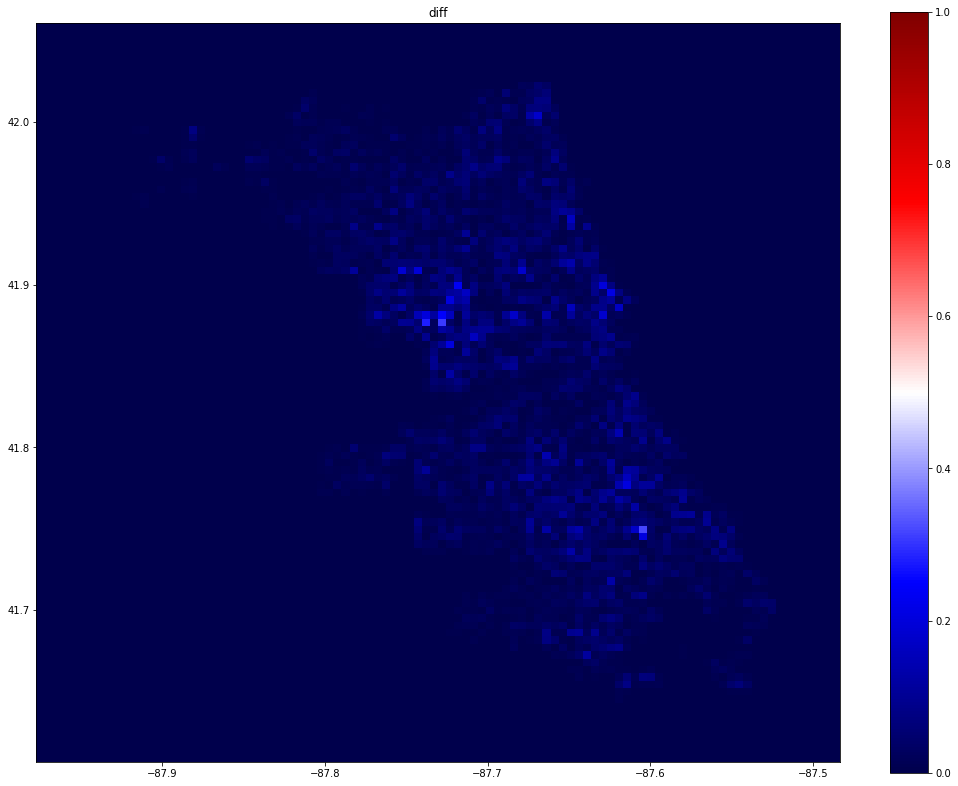

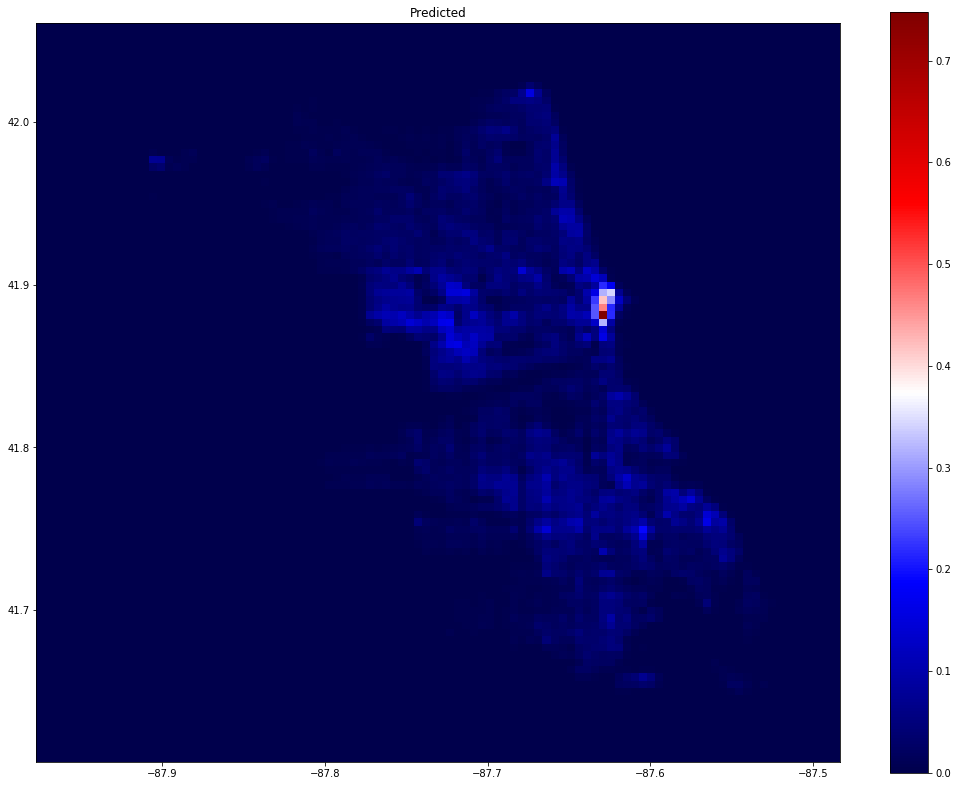

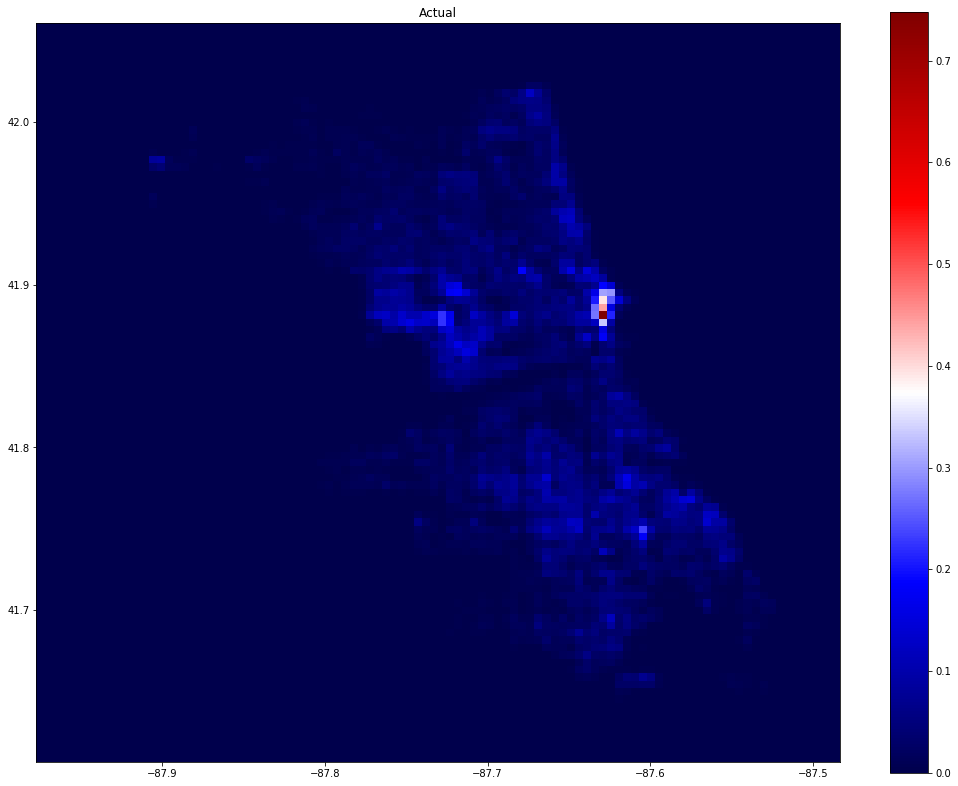

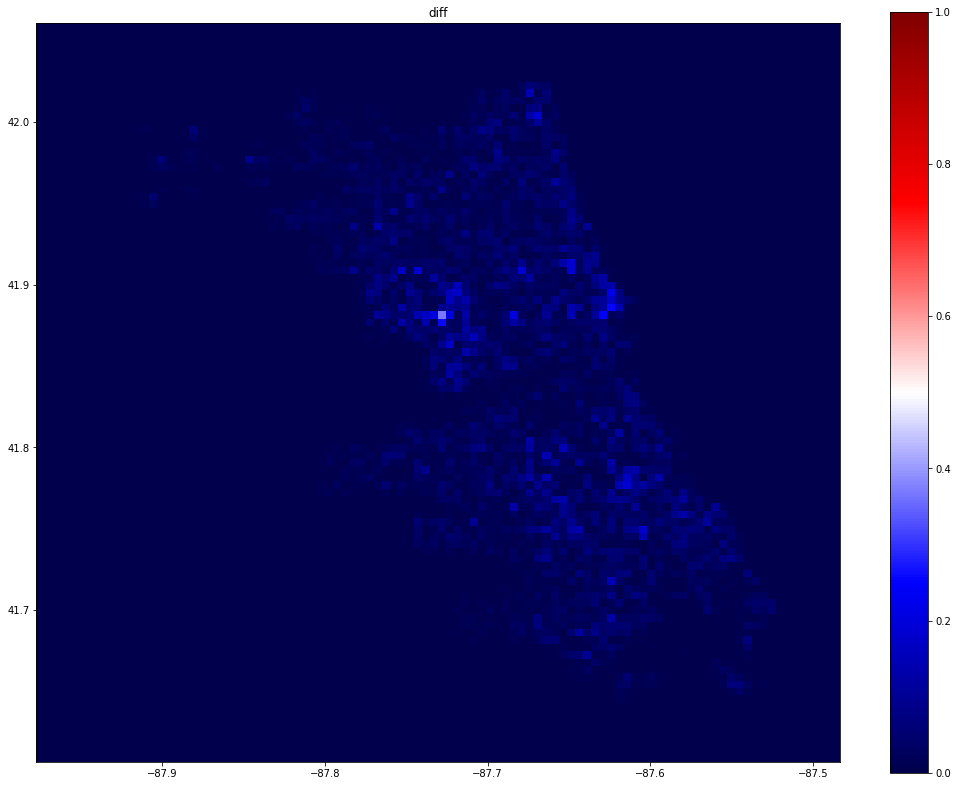

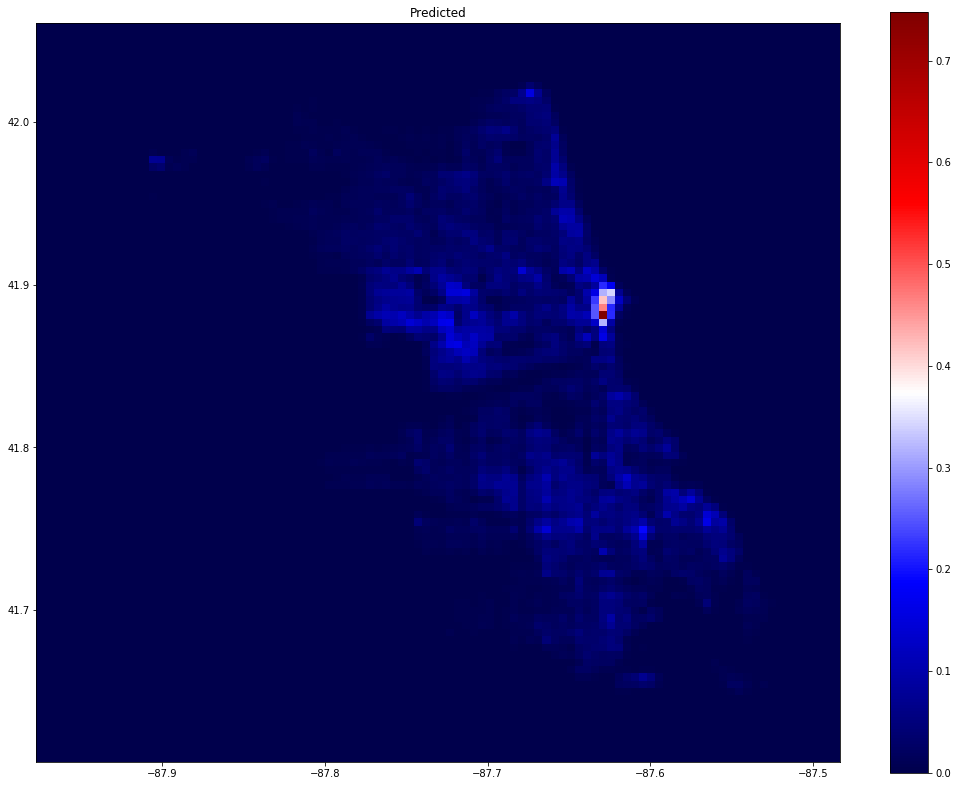

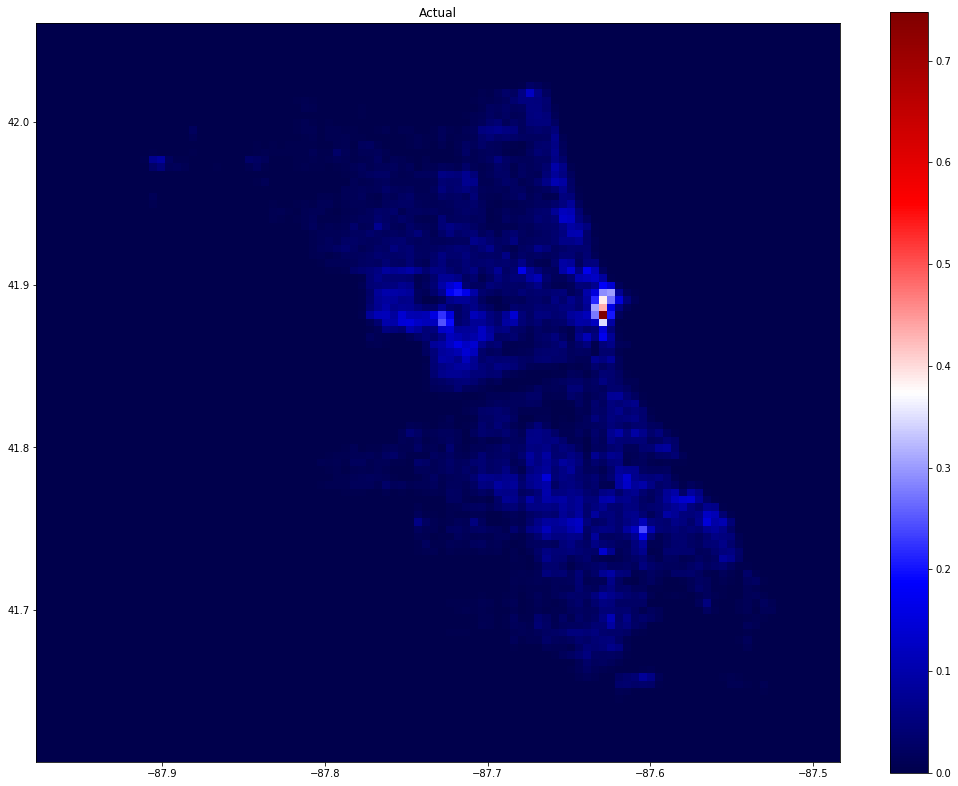

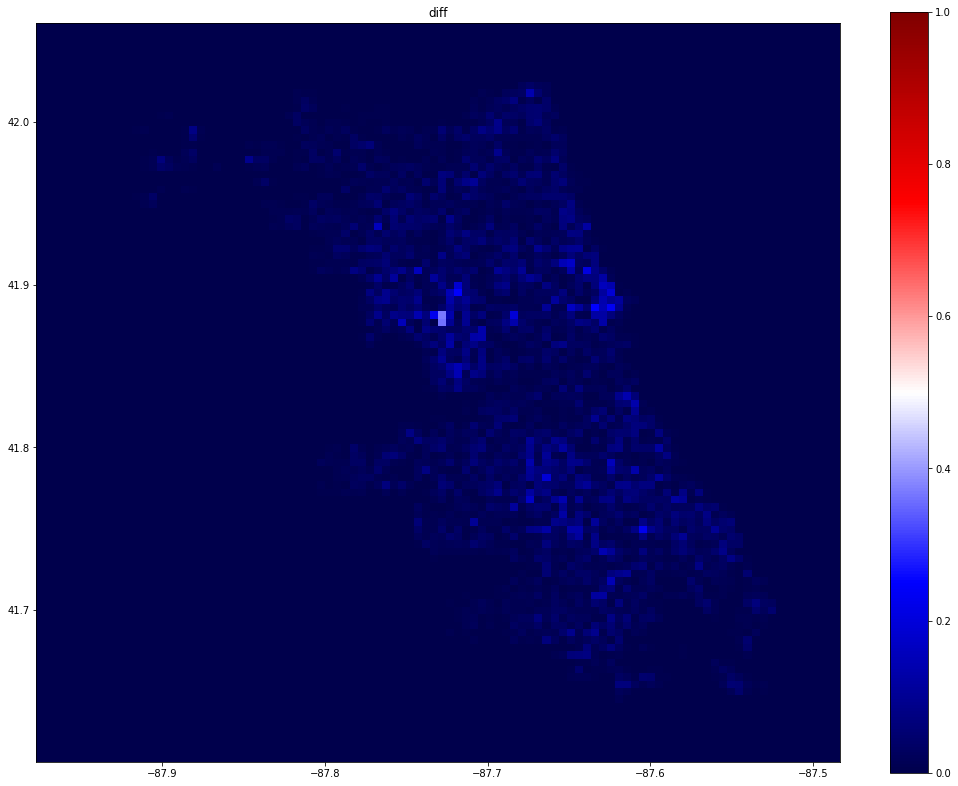

In [393]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepFromLast in range(Y_valid.shape[0]):
    plt.figure(figsize=(18, 14))
    plt.title('Predicted')
    plt.imshow( X=reshapePred(Predict,timeStepFromLast),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    plt.figure(figsize=(18, 14))
    plt.title('Actual')
    plt.imshow( X=reshapePred(Y_valid,timeStepFromLast ),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    diff = np.abs(reshapePred(Predict,timeStepFromLast)-reshapePred(Y_valid,timeStepFromLast ))
    plt.figure(figsize=(18, 14))
    plt.title('diff')
    plt.imshow( X=scaleDiff(diff,diff_max,diff_min),vmax=1,vmin=0, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()

#### We plot the single pixel with the most dense in crime KDE

In [394]:
np.argsort(Y_valid)[:,-10:][0]

array([7162, 6960, 5059, 6961, 7063, 7163, 7059, 7062, 7061, 7060])

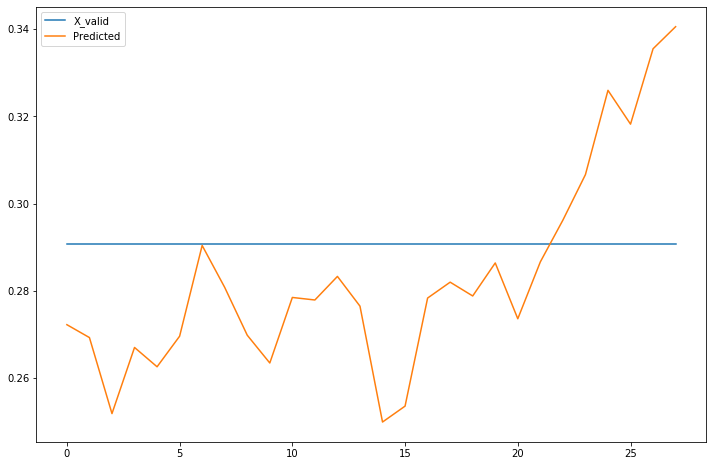

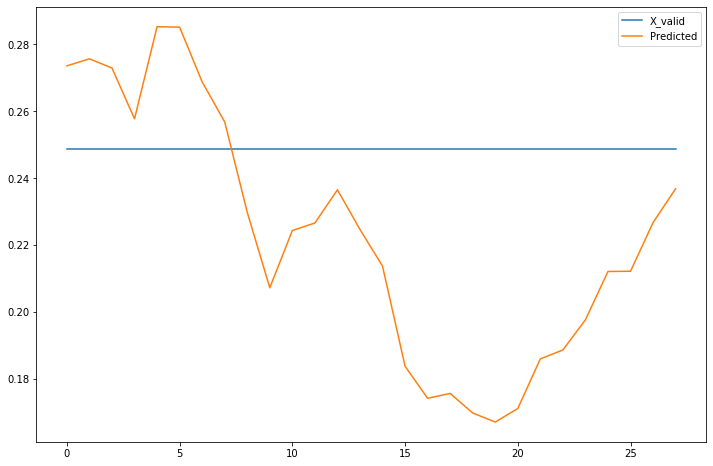

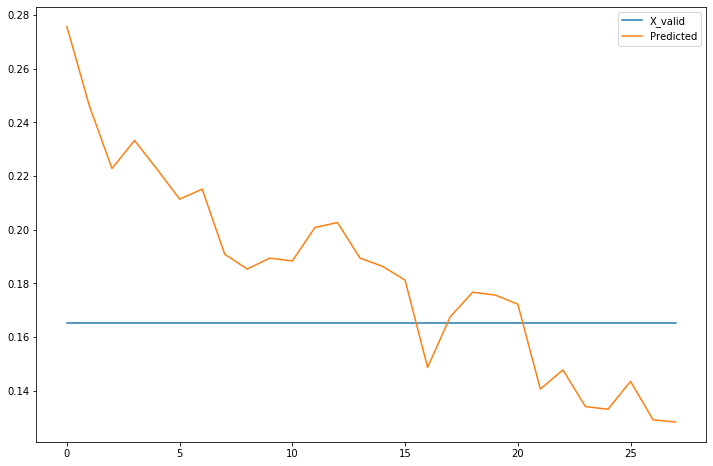

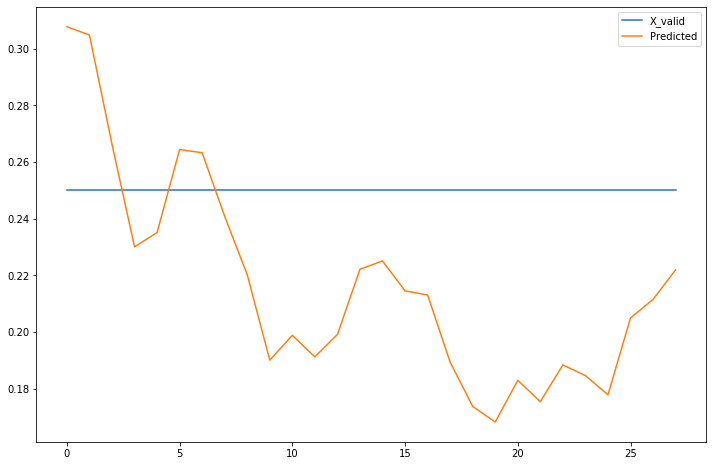

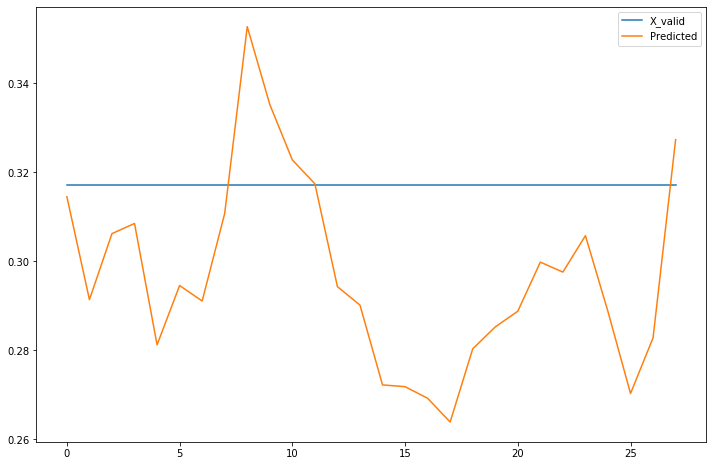

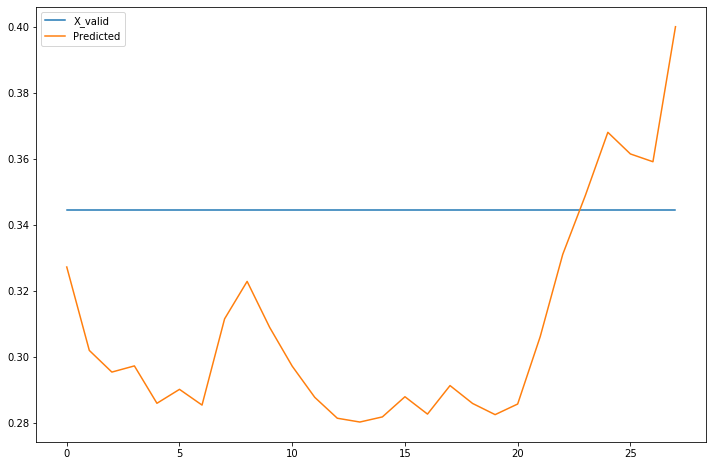

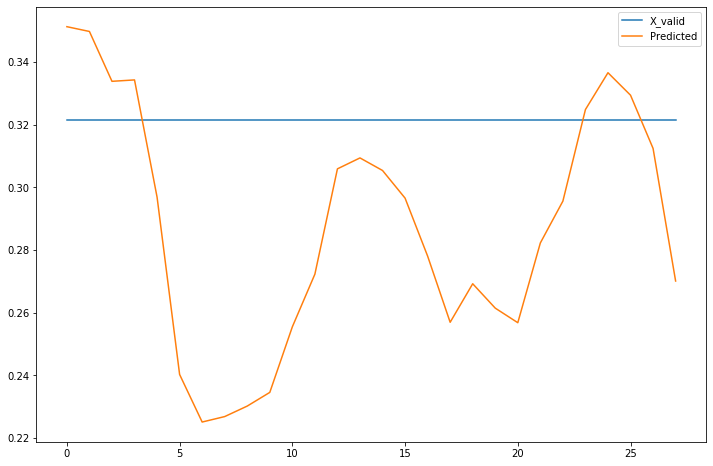

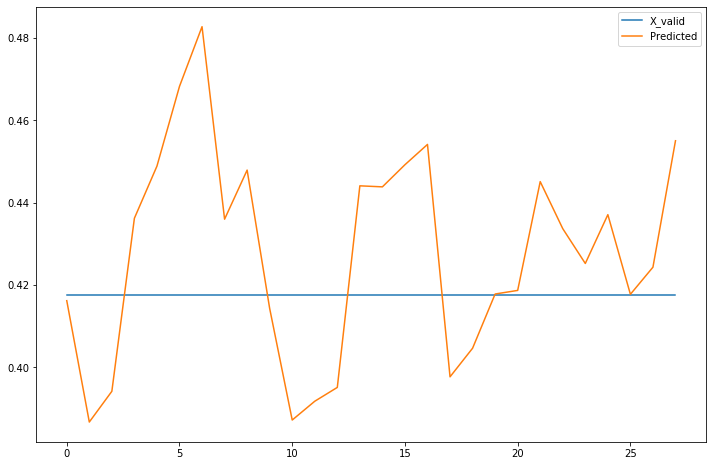

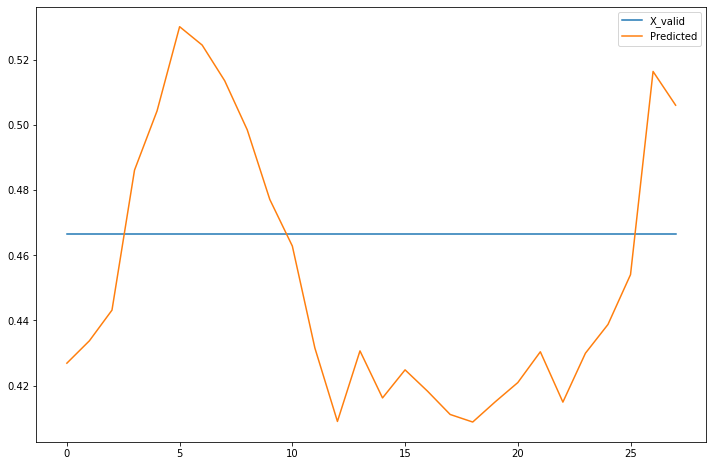

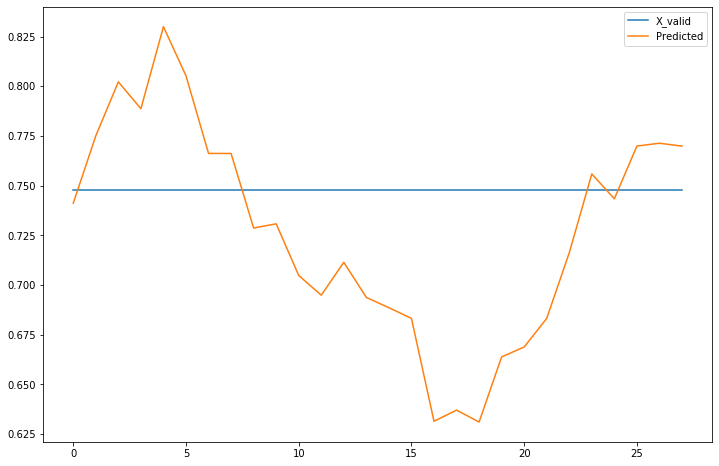

In [395]:
for i in np.argsort(Y_valid)[:,-10:][0]:
    pd.DataFrame(np.transpose(np.vstack([Predict[:,i],Y_valid[:,i]])),columns=["X_valid","Predicted"]).plot(figsize=(12,8))

#### We observe the model is simply averaging when change in crime density in volatile

In [396]:
Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]

array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
       -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
       -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
       -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
        0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
        0.06236299, -0.01036096])

In [397]:
[Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]
 ,Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]]

[array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
        -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
        -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
        -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
         0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
         0.06236299, -0.01036096]),
 array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
        -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
        -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
        -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
         0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
         0.06236299, -0.01036096])]

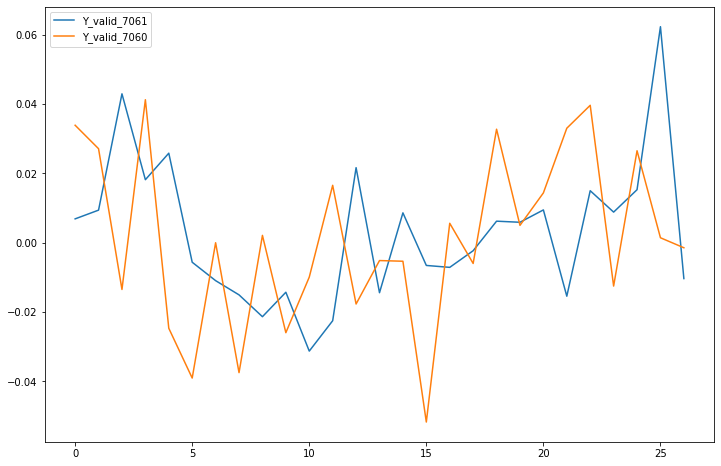

In [398]:
pd.DataFrame(np.transpose(np.vstack([Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1],Y_valid[:,i][1:]-Y_valid[:,i][0:-1]])),columns=["Y_valid_"+str(i+1),"Y_valid_"+str(i)]).plot(figsize=(12,8))

In [399]:
for i in range(Predict.shape[0]-1):
    diff_ts = Predict[i,:] - Predict[i+1,:]
    print(np.sum(diff_ts[np.argsort(diff_ts)]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


#### We plot the difference between prediction and target

In [400]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [401]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [402]:
np.max(scaled_diff)

1.0

In [403]:
diff

array([[ 1.81296491e-06, -5.77185665e-06, -1.81296491e-06, ...,
        -5.25021732e-08,  1.81296491e-06, -5.77185665e-06],
       [ 1.81296491e-06,  5.25021734e-08, -1.81296491e-06, ...,
        -1.81296491e-06,  5.24621556e-08,  5.77185665e-06],
       [ 1.81296491e-06,  5.24621556e-08, -5.25021732e-08, ...,
        -1.81296491e-06,  5.24621556e-08, -5.77185665e-06],
       ...,
       [ 5.24621556e-08,  1.02341037e-05,  1.81296491e-06, ...,
         1.02341037e-05, -5.24621554e-08, -1.81296491e-06],
       [ 1.02341037e-05, -1.81296491e-06, -5.77185665e-06, ...,
        -5.24621554e-08,  1.02341037e-05, -1.81296491e-06],
       [-1.81296491e-06,  5.77185665e-06,  1.81296491e-06, ...,
        -5.77185665e-06,  1.02341037e-05,  1.81296491e-06]])

In [404]:
vmax, vmin = np.max(scaled_diff), np.min(scaled_diff)

In [405]:
vmax, vmin 

(1.0, 0.0)

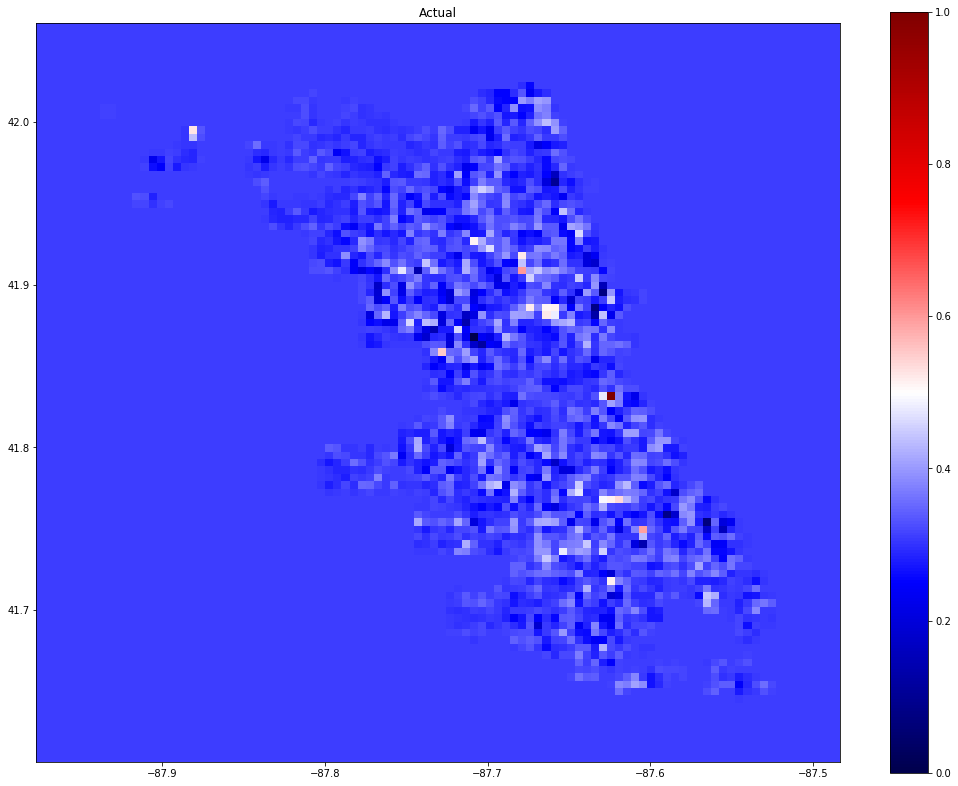

In [68]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff,vmax=vmax, vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.

#### Tensor Flow test

In [227]:
array1 = np.array([[[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 12, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 29]],])

In [232]:
array2 = (array1 + 2)*2

In [233]:
array2

array([[[ 4,  6,  8, 10, 12],
        [14, 16, 18, 20, 22]],

       [[24, 26, 28, 30, 32],
        [34, 36, 38, 40, 42]],

       [[44, 46, 48, 50, 52],
        [54, 56, 58, 60, 62]]])

In [235]:
rank_3_tensor1 = tf.constant(array1)
rank_3_tensor2 = tf.constant(array2)
                    
print(rank_3_tensor1)
print(rank_3_tensor2)

tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int64)
tf.Tensor(
[[[ 4  6  8 10 12]
  [14 16 18 20 22]]

 [[24 26 28 30 32]
  [34 36 38 40 42]]

 [[44 46 48 50 52]
  [54 56 58 60 62]]], shape=(3, 2, 5), dtype=int64)


In [240]:
rank_3_tensor2[0:].shape

TensorShape([3, 2, 5])

In [243]:
rank_3_tensor2 - rank_3_tensor1

<tf.Tensor: shape=(3, 2, 5), dtype=int64, numpy=
array([[[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]],

       [[14, 15, 16, 17, 18],
        [19, 20, 21, 22, 23]],

       [[24, 25, 26, 27, 28],
        [29, 30, 31, 32, 33]]])>

In [241]:
rank_3_tensor2[0:-1] - rank_3_tensor2[1:]

<tf.Tensor: shape=(2, 2, 5), dtype=int64, numpy=
array([[[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]],

       [[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]]])>

In [242]:
tf.math.subtract(rank_3_tensor2[0:-1],rank_3_tensor2[1:])

<tf.Tensor: shape=(2, 2, 5), dtype=int64, numpy=
array([[[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]],

       [[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]]])>

In [304]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mse'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))  
timeDist = TimeDistributed(Flatten())(inputs)
print(timeDist.shape)
diffTime = Lambda(lambda x: x[:,:-1,:]-x[:,1:,:],name='timestep_diff')(timeDist)
print(diffTime.shape)
LSTM_layer1 = LSTM(100)(diffTime)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_diff1lag_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',#'mean_squared_logarithmic_error',
                   metrics=['mse'], 
                   optimizer=adam)



(None, 52, 10000)
(None, 51, 10000)
Model: "Flattened_diff1lag_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
timestep_diff (Lambda)       (None, 51, 10000)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               4040400   
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_45 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_4

(51,)


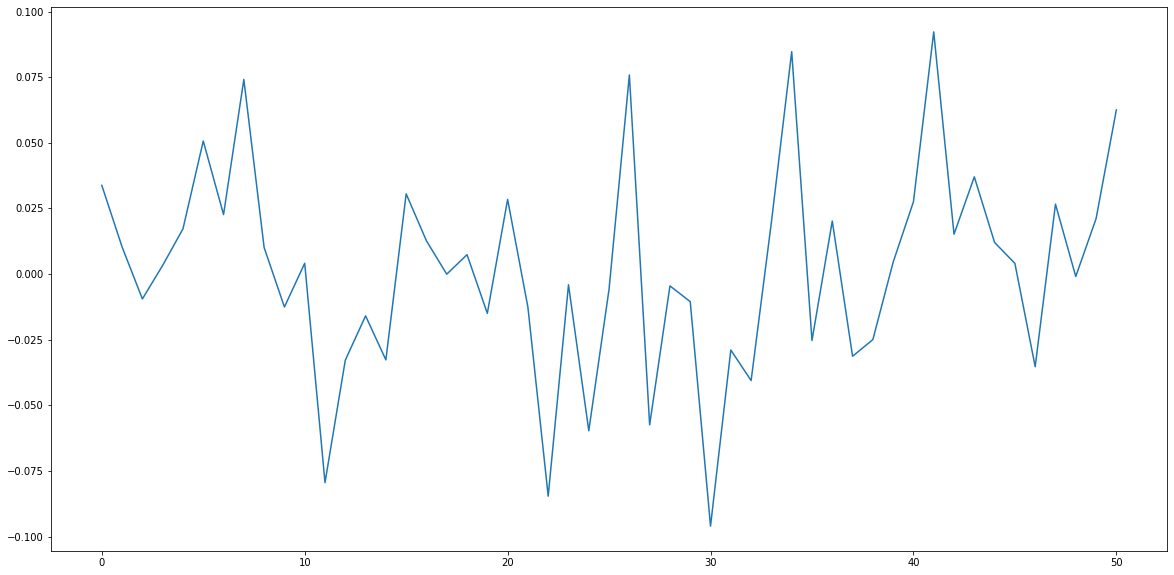

(51,)


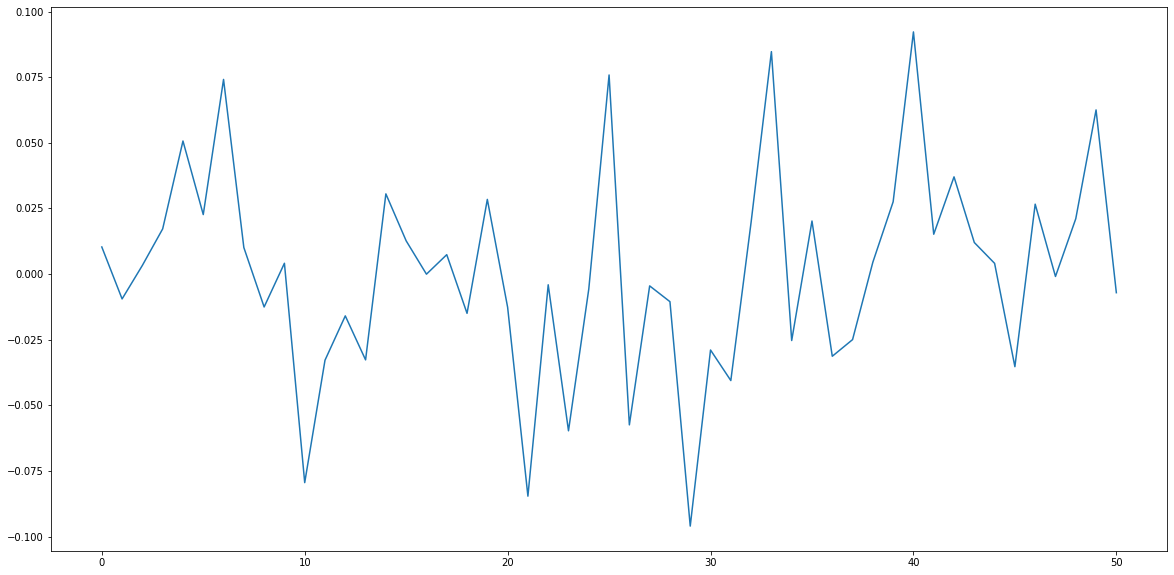

(51,)


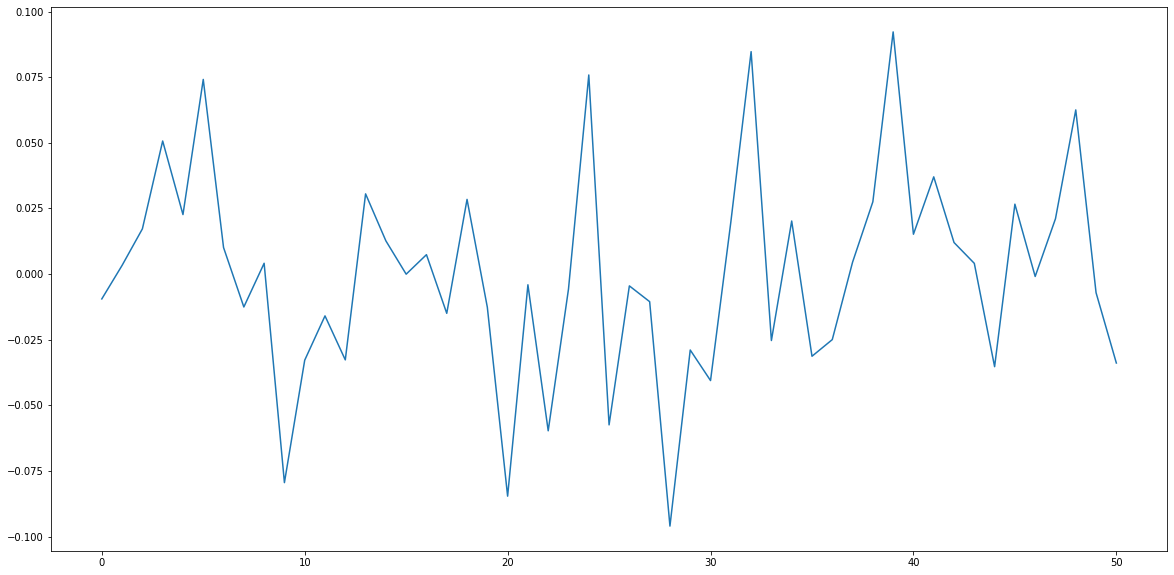

(51,)


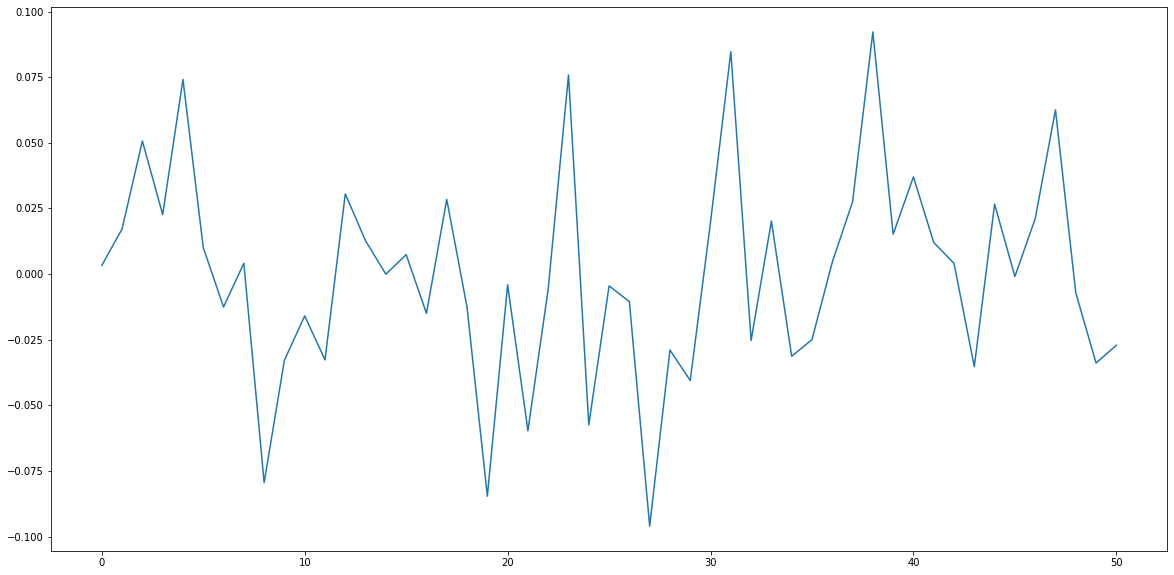

(51,)


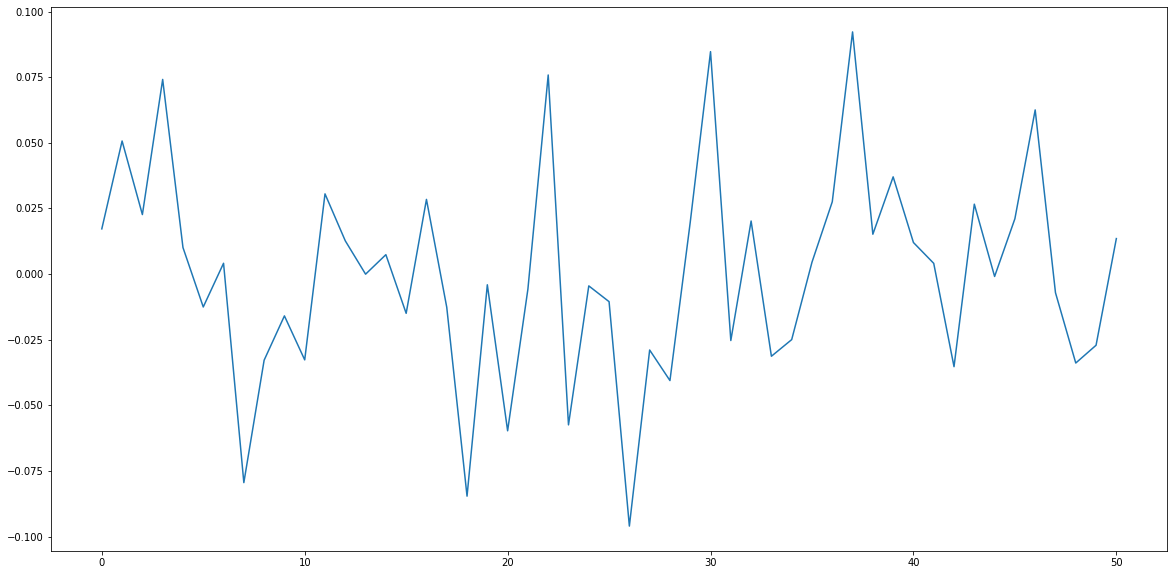

(51,)


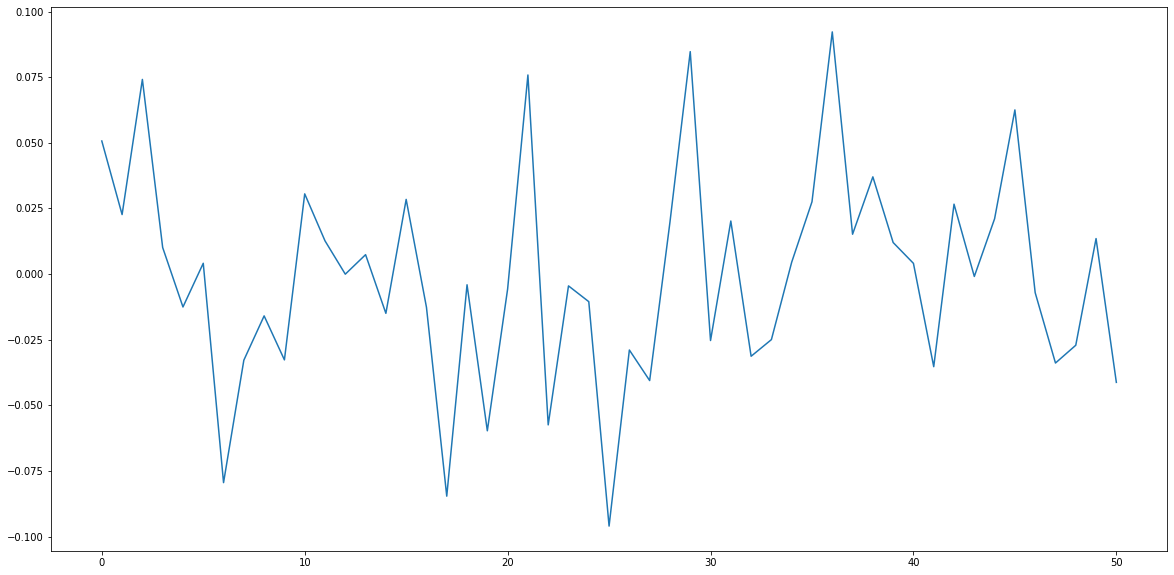

(51,)


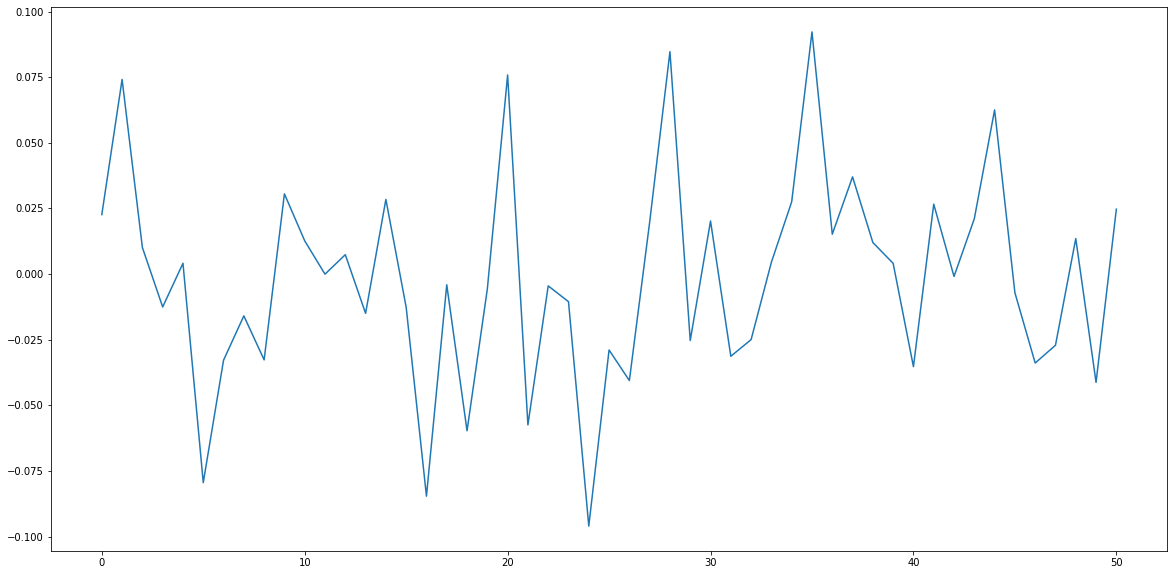

(51,)


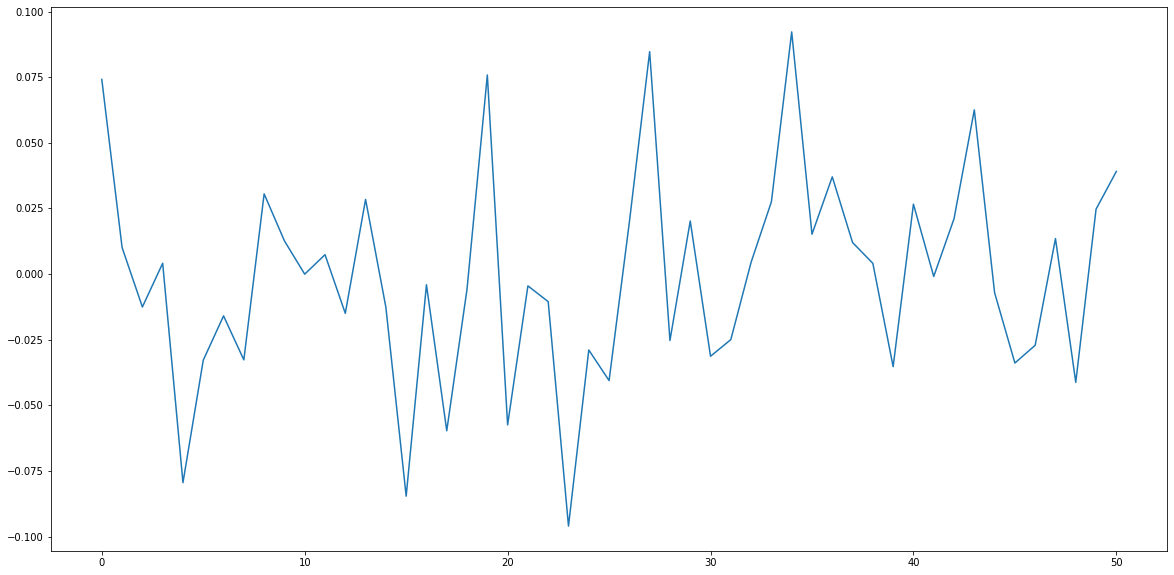

(51,)


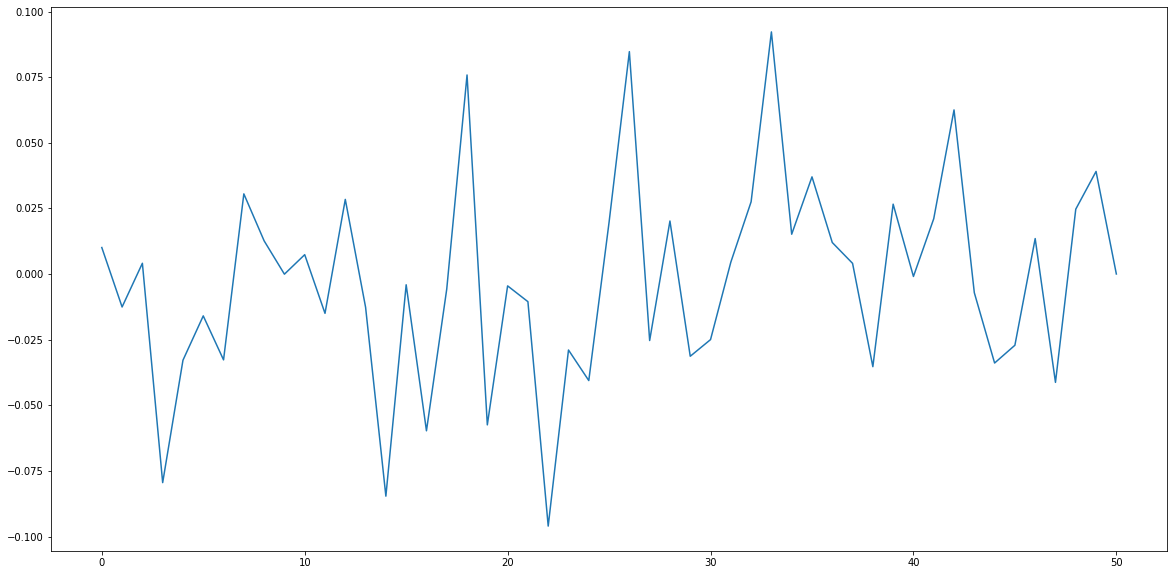

(51,)


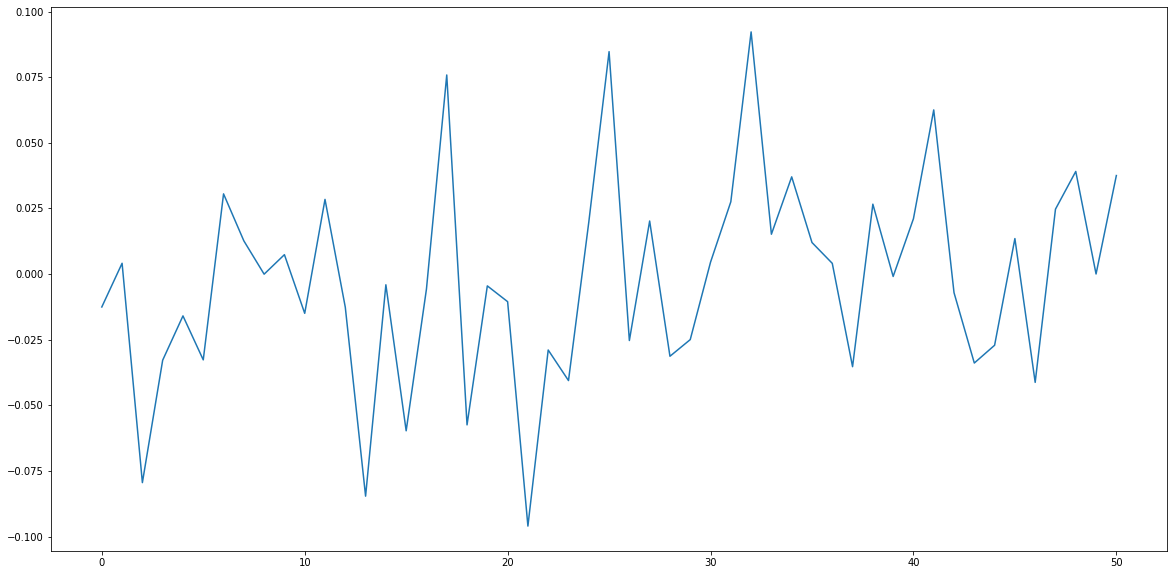

(51,)


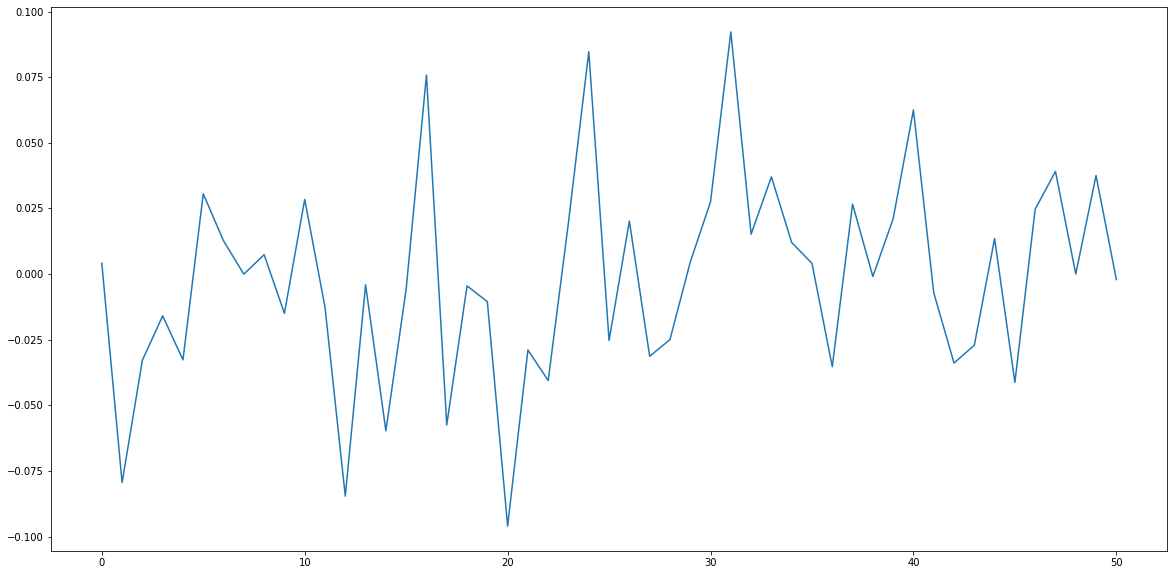

(51,)


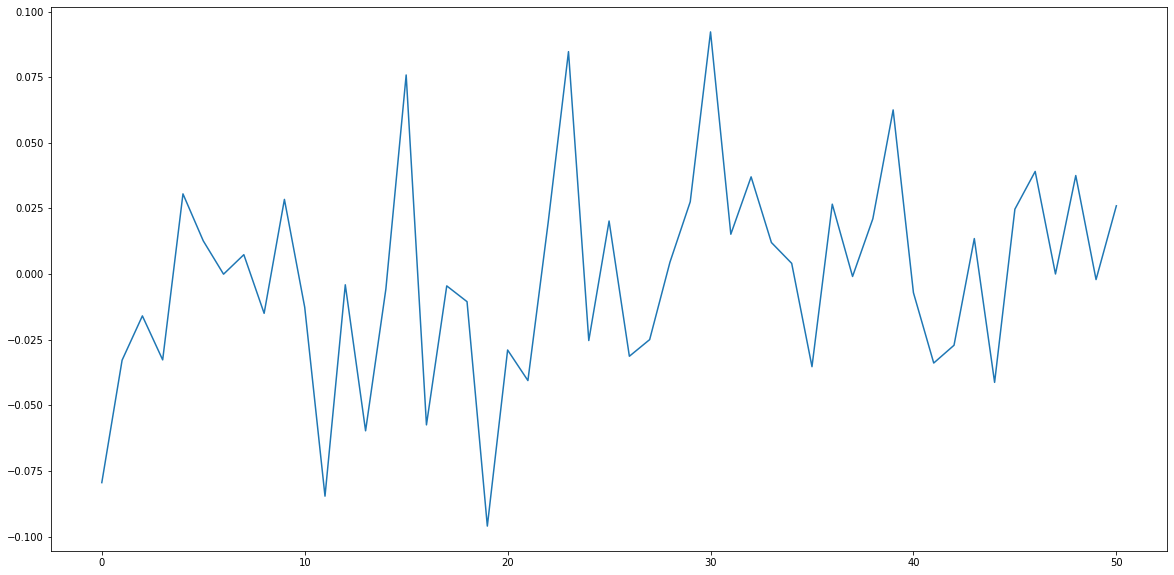

(51,)


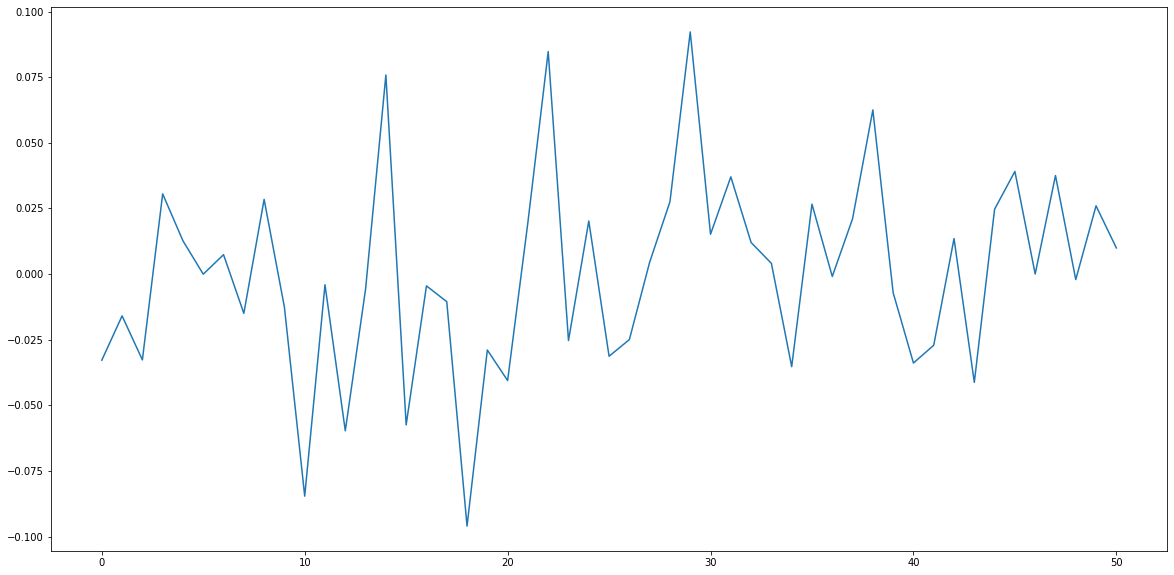

(51,)


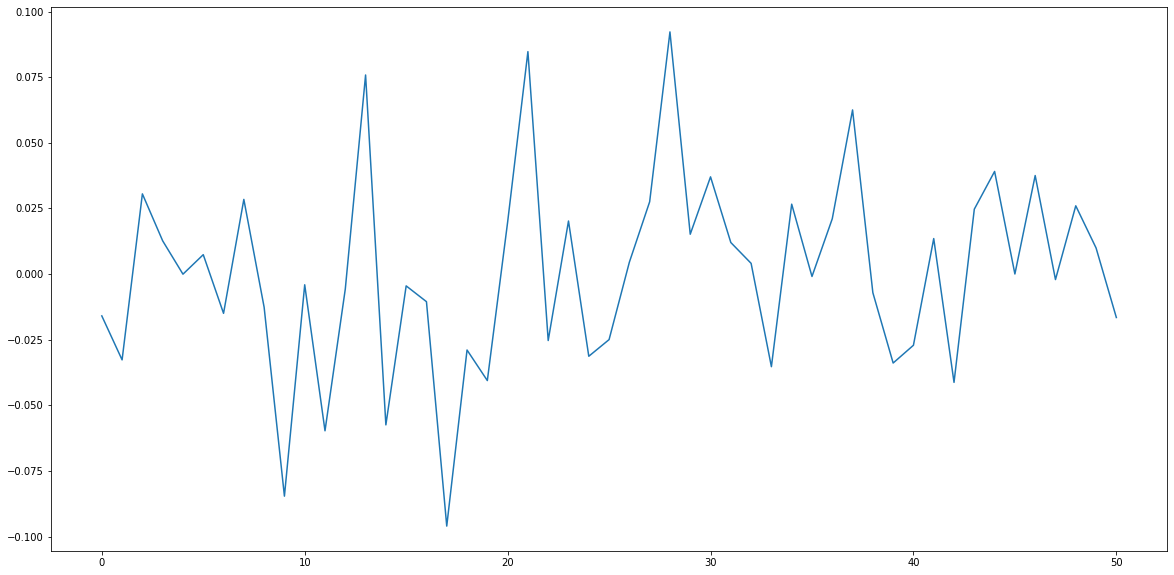

(51,)


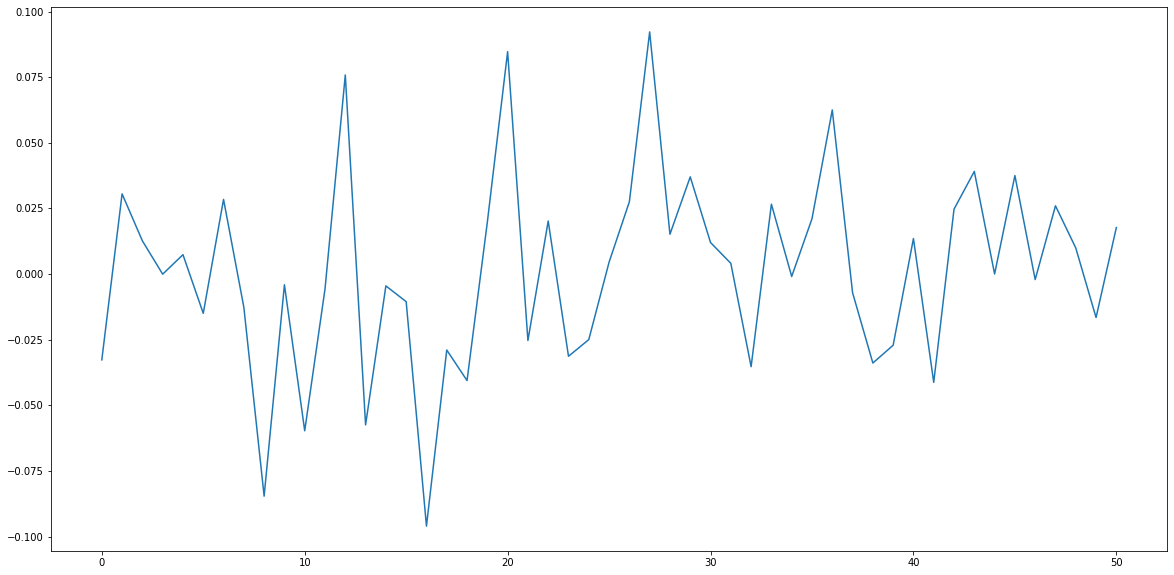

(51,)


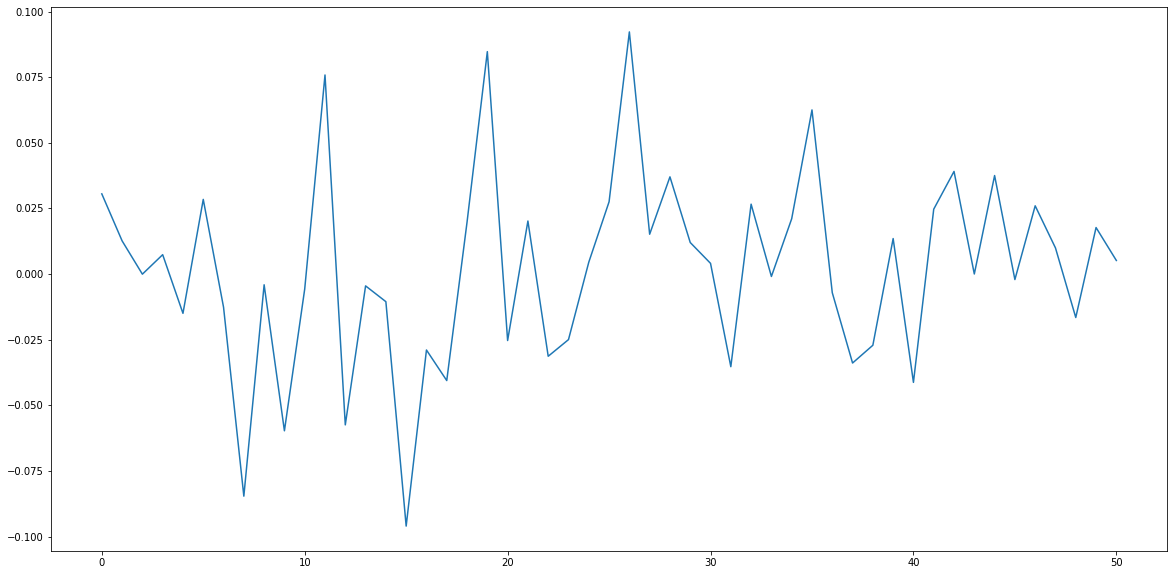

(51,)


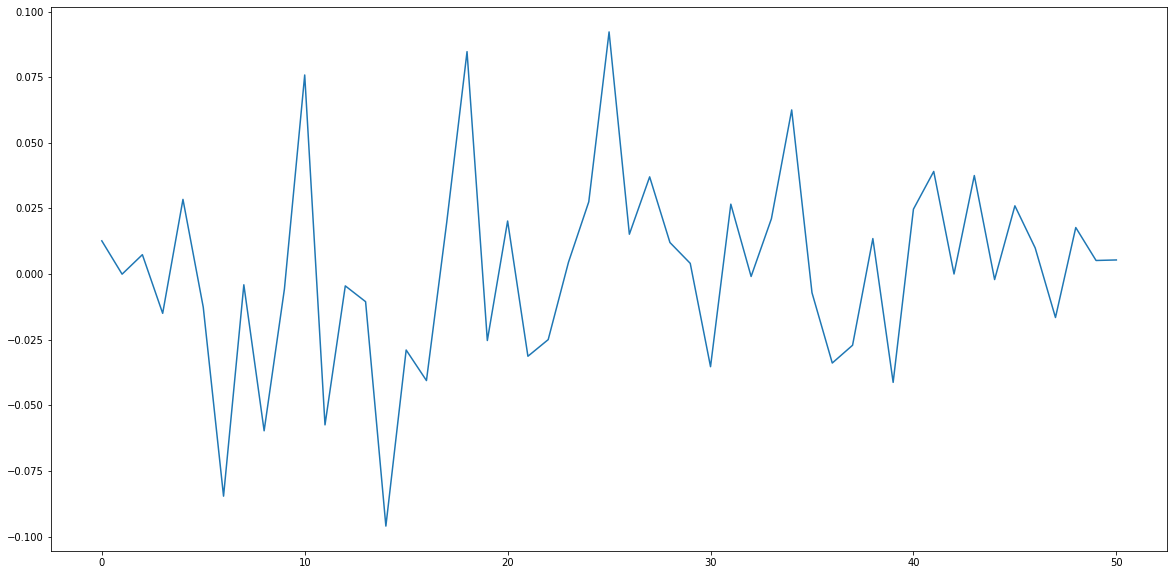

(51,)


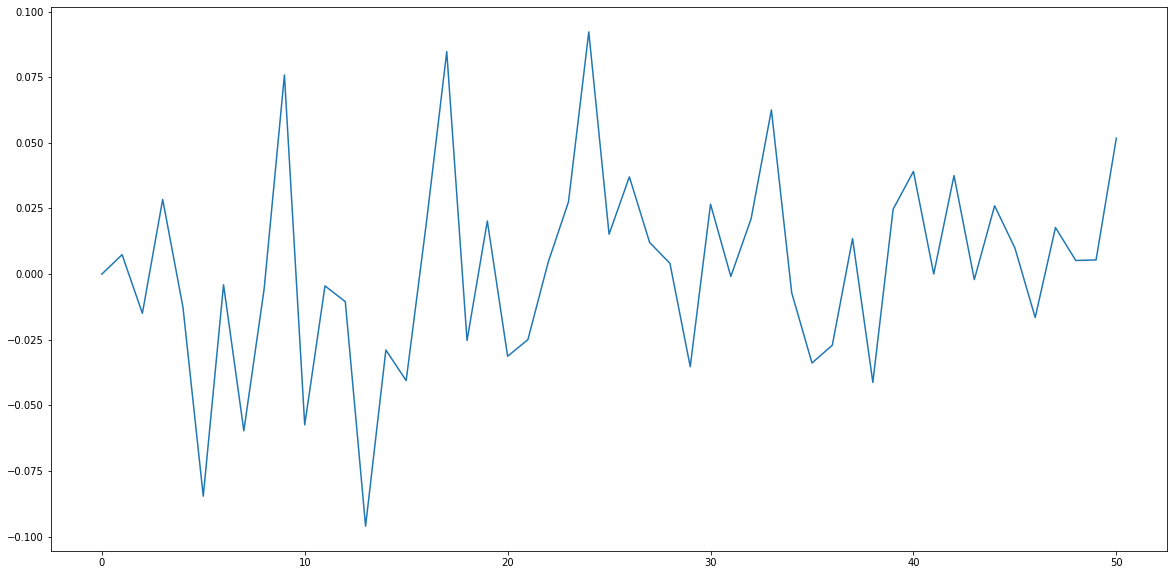

(51,)


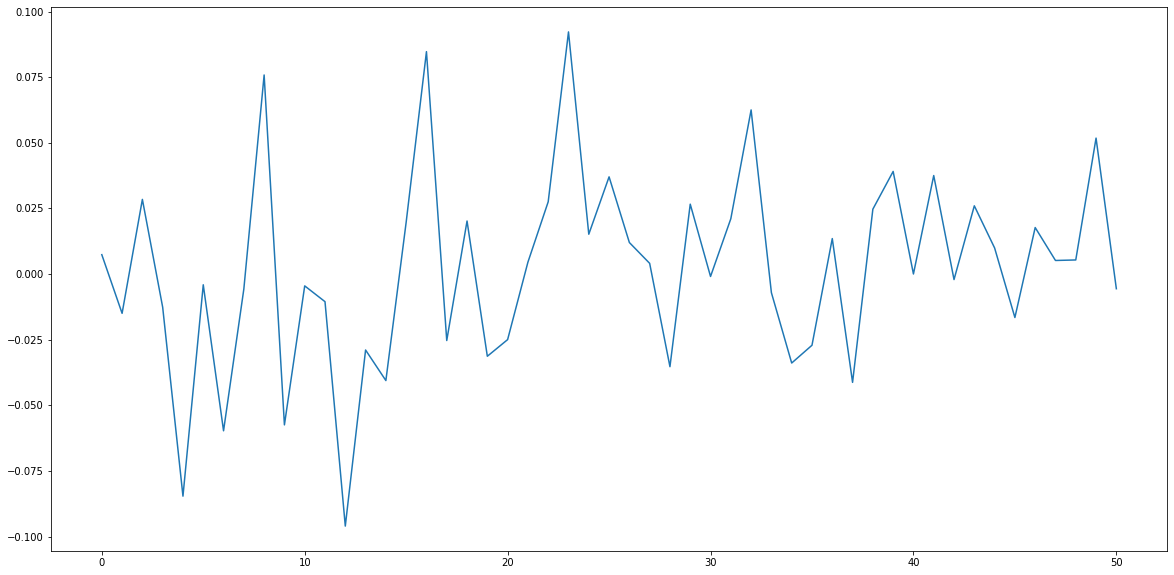

(51,)


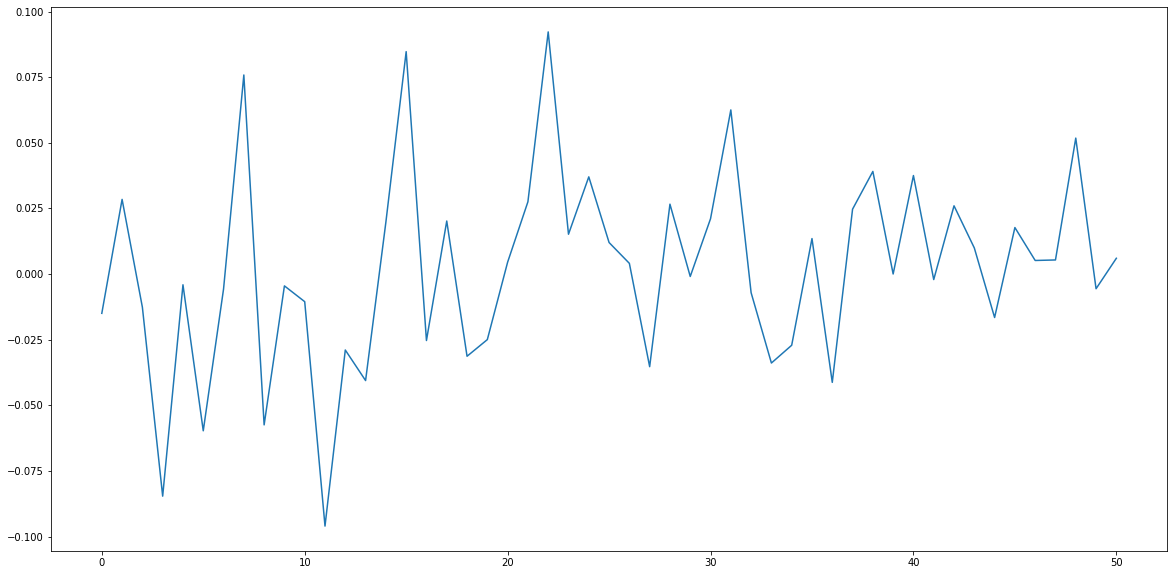

(51,)


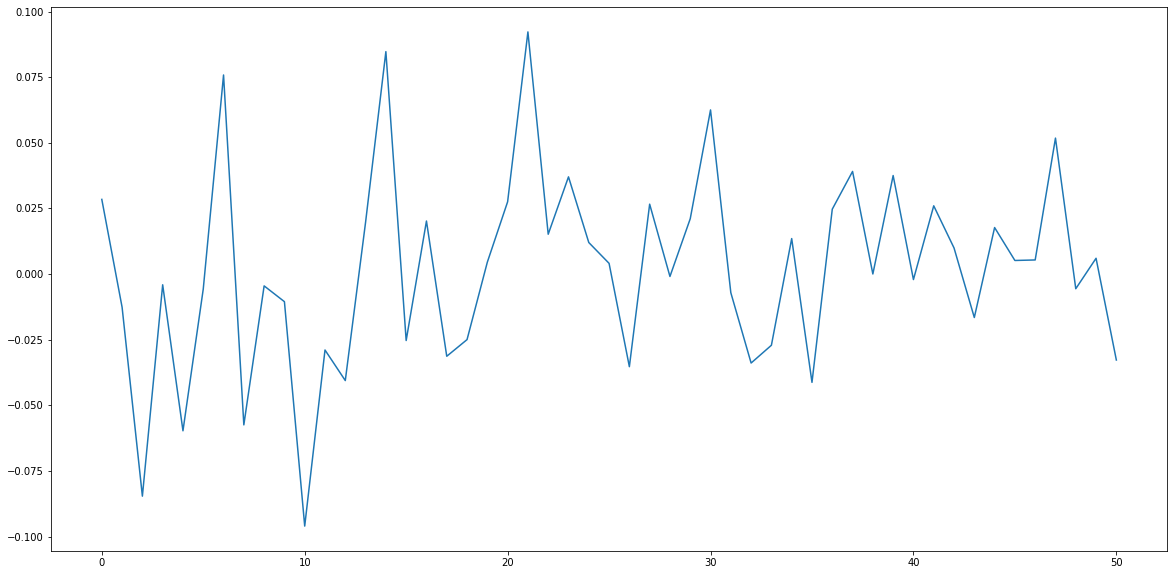

(51,)


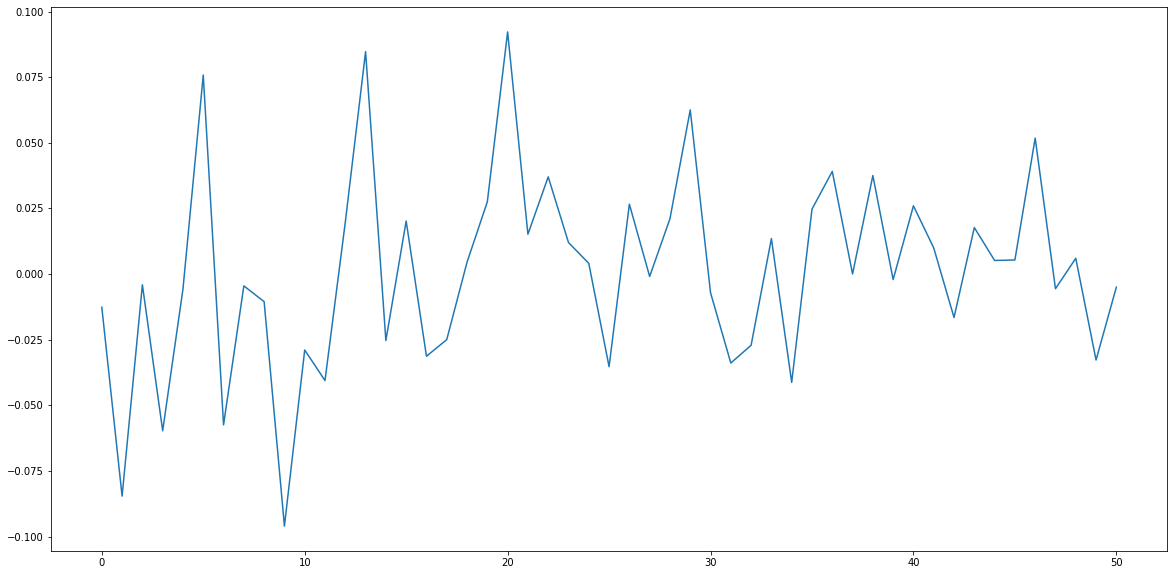

(51,)


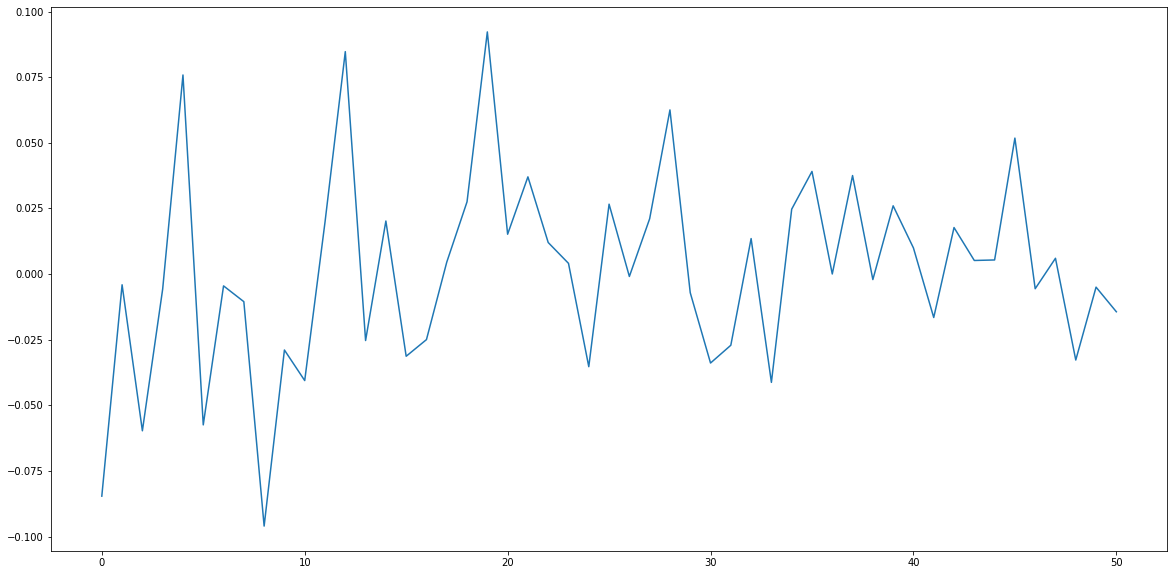

(51,)


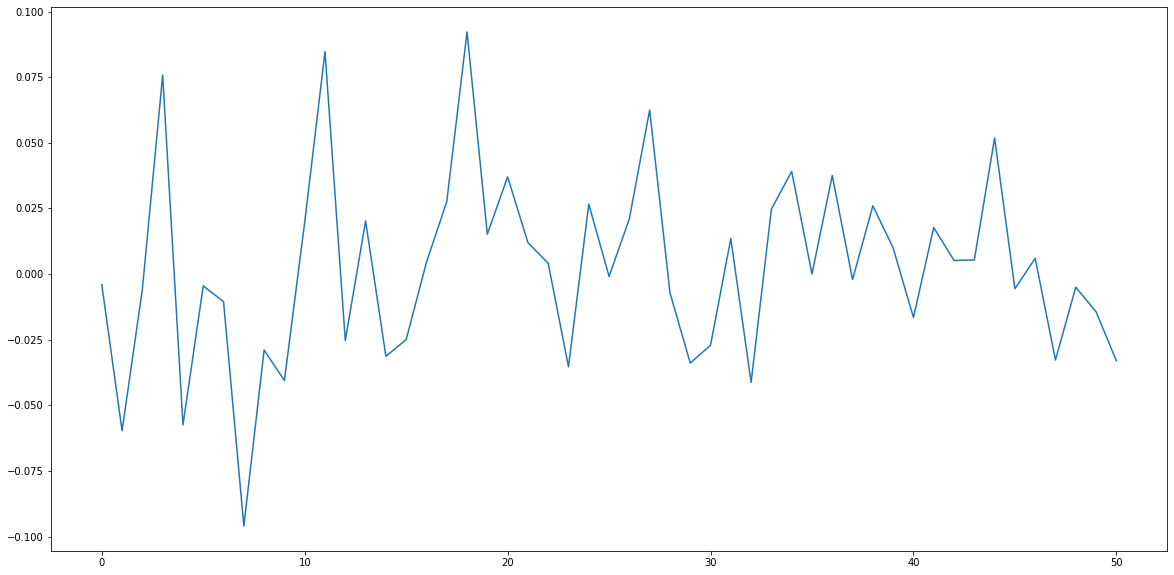

(51,)


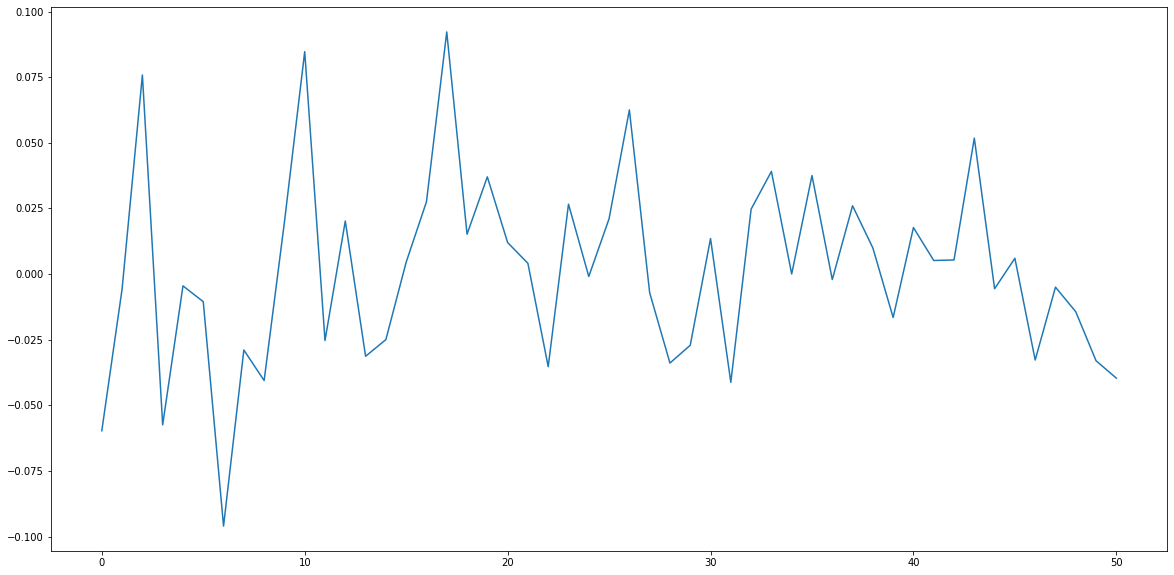

(51,)


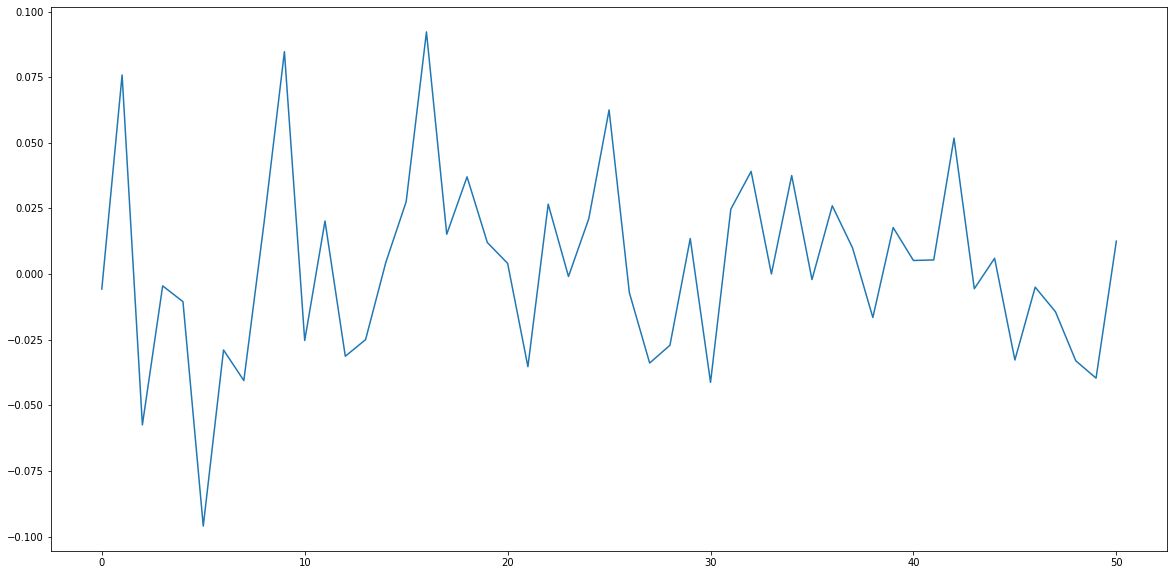

(51,)


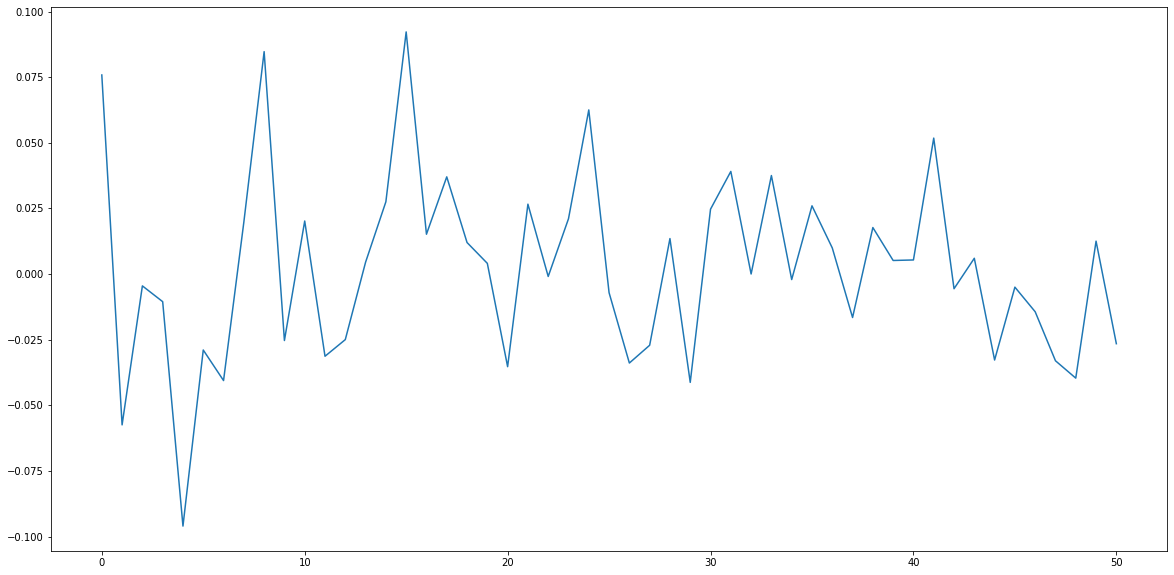

(51,)


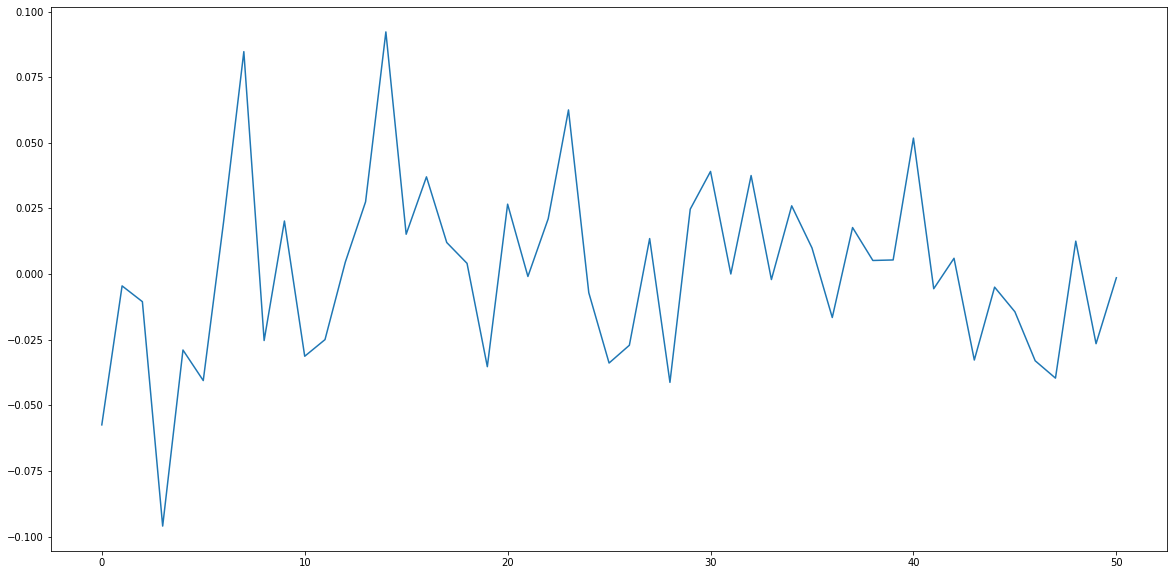

In [305]:
model_AttentionOut = model  # include here your original model

layer_name = 'timestep_diff'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    print(intermediate_output[0,:,7060].shape)
    plt.figure(figsize=(20,10))
    plt.plot(intermediate_output[0,:,7060])
    plt.show()

In [306]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=6, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "Flattened_diff1lag_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
timestep_diff (Lambda)       (None, 51, 10000)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               4040400   
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_45 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 10000) 

Epoch 16/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0045 - mse: 3.7332e-04
Epoch 00016: val_loss improved from 0.00460 to 0.00445, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0045 - mse: 3.7119e-04 - val_loss: 0.0045 - val_mse: 3.4721e-04
Epoch 17/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0043 - mse: 3.6281e-04
Epoch 00017: val_loss improved from 0.00445 to 0.00432, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0043 - mse: 3.6004e-04 - val_loss: 0.0043 - val_mse: 3.3624e-04
Epoch 18/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0042 - mse: 3.4849e-04
Epoc

78/88 [=========================>....] - ETA: 0s - loss: 0.0028 - mse: 2.3494e-04
Epoch 00034: val_loss improved from 0.00290 to 0.00284, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0028 - mse: 2.3289e-04 - val_loss: 0.0028 - val_mse: 2.1120e-04
Epoch 35/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0027 - mse: 2.2945e-04
Epoch 00035: val_loss improved from 0.00284 to 0.00279, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0027 - mse: 2.2806e-04 - val_loss: 0.0028 - val_mse: 2.0647e-04
Epoch 36/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0027 - mse: 2.2330e-04
Epoch 00036: val_l

88/88 [==============================] - 0s 4ms/sample - loss: 0.0022 - mse: 1.6993e-04 - val_loss: 0.0023 - val_mse: 1.4997e-04
Epoch 53/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0022 - mse: 1.6768e-04
Epoch 00053: val_loss improved from 0.00226 to 0.00224, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0022 - mse: 1.6752e-04 - val_loss: 0.0022 - val_mse: 1.4765e-04
Epoch 54/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0021 - mse: 1.6569e-04
Epoch 00054: val_loss improved from 0.00224 to 0.00223, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0021 - mse: 1.6520e-04 - val_loss: 

Epoch 71/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0020 - mse: 1.3790e-04
Epoch 00071: val_loss improved from 0.00204 to 0.00203, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0019 - mse: 1.3471e-04 - val_loss: 0.0020 - val_mse: 1.1634e-04
Epoch 72/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0019 - mse: 1.3426e-04
Epoch 00072: val_loss improved from 0.00203 to 0.00202, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0019 - mse: 1.3330e-04 - val_loss: 0.0020 - val_mse: 1.1502e-04
Epoch 73/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0019 - mse: 1.3061e-04
Epoc

78/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mse: 1.1401e-04
Epoch 00089: val_loss improved from 0.00192 to 0.00192, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mse: 1.1374e-04 - val_loss: 0.0019 - val_mse: 9.6866e-05
Epoch 90/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mse: 1.1267e-04
Epoch 00090: val_loss improved from 0.00192 to 0.00192, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mse: 1.1277e-04 - val_loss: 0.0019 - val_mse: 9.5989e-05
Epoch 91/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mse: 1.1085e-04
Epoch 00091: val_l

88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mse: 9.8696e-05 - val_loss: 0.0019 - val_mse: 8.3309e-05
Epoch 108/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0018 - mse: 9.8539e-05
Epoch 00108: val_loss improved from 0.00186 to 0.00186, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mse: 9.7965e-05 - val_loss: 0.0019 - val_mse: 8.2676e-05
Epoch 109/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mse: 9.6631e-05
Epoch 00109: val_loss improved from 0.00186 to 0.00186, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mse: 9.7248e-05 - val_loss

Epoch 126/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 8.7185e-05
Epoch 00126: val_loss improved from 0.00183 to 0.00183, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 8.6316e-05 - val_loss: 0.0018 - val_mse: 7.2516e-05
Epoch 127/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 8.5699e-05
Epoch 00127: val_loss improved from 0.00183 to 0.00183, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 8.5730e-05 - val_loss: 0.0018 - val_mse: 7.2010e-05
Epoch 128/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 8.5038e-05
E

78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 7.6390e-05
Epoch 00144: val_loss improved from 0.00180 to 0.00180, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 7.6857e-05 - val_loss: 0.0018 - val_mse: 6.4534e-05
Epoch 145/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 7.7054e-05
Epoch 00145: val_loss did not improve from 0.00180
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mse: 7.6384e-05 - val_loss: 0.0018 - val_mse: 6.4168e-05
Epoch 146/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 7.5690e-05
Epoch 00146: val_loss improved from 0.00180 to 0.00180, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/check

Epoch 164/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 6.9289e-05
Epoch 00164: val_loss improved from 0.00178 to 0.00178, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 6.8274e-05 - val_loss: 0.0018 - val_mse: 5.7485e-05
Epoch 165/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 6.7456e-05
Epoch 00165: val_loss improved from 0.00178 to 0.00178, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 6.7882e-05 - val_loss: 0.0018 - val_mse: 5.7161e-05
Epoch 166/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 6.6898e-05
E

88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 6.1522e-05 - val_loss: 0.0018 - val_mse: 5.2029e-05
Epoch 184/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 6.1541e-05
Epoch 00184: val_loss did not improve from 0.00177
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mse: 6.1213e-05 - val_loss: 0.0018 - val_mse: 5.1798e-05
Epoch 185/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 6.1110e-05
Epoch 00185: val_loss improved from 0.00177 to 0.00176, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 6.0882e-05 - val_loss: 0.0018 - val_mse: 5.1522e-05
Epoch 186/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 6.0554e-05
Epoch 00186: val_loss did not improve from 0.0

72/88 [=======================>......] - ETA: 0s - loss: 0.0017 - mse: 5.5264e-05
Epoch 00204: val_loss improved from 0.00176 to 0.00175, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 5.5393e-05 - val_loss: 0.0018 - val_mse: 4.7221e-05
Epoch 205/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 5.5197e-05
Epoch 00205: val_loss improved from 0.00175 to 0.00175, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mse: 5.5130e-05 - val_loss: 0.0018 - val_mse: 4.7033e-05
Epoch 206/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 5.4095e-05
Epoch 00206: val

Epoch 225/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 5.0191e-05
Epoch 00225: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 5.0381e-05 - val_loss: 0.0017 - val_mse: 4.3305e-05
Epoch 226/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0016 - mse: 5.0964e-05
Epoch 00226: val_loss improved from 0.00175 to 0.00175, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 5.0173e-05 - val_loss: 0.0017 - val_mse: 4.3117e-05
Epoch 227/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 4.9549e-05
Epoch 00227: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 4.9957e-05 - val_loss: 0.0017 - val_mse: 4.2966

88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 4.6197e-05 - val_loss: 0.0017 - val_mse: 3.9972e-05
Epoch 247/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 4.6306e-05
Epoch 00247: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 4.6011e-05 - val_loss: 0.0017 - val_mse: 3.9853e-05
Epoch 248/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 4.6537e-05
Epoch 00248: val_loss improved from 0.00174 to 0.00174, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 4.5833e-05 - val_loss: 0.0017 - val_mse: 3.9694e-05
Epoch 249/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0016 - mse: 4.5341e-05
Epoch 00249: val_loss improved from 0.00174 to

88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 4.2629e-05 - val_loss: 0.0017 - val_mse: 3.7236e-05
Epoch 268/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mse: 4.2531e-05
Epoch 00268: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 4.2466e-05 - val_loss: 0.0017 - val_mse: 3.7125e-05
Epoch 269/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 4.2145e-05
Epoch 00269: val_loss improved from 0.00173 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 4.2315e-05 - val_loss: 0.0017 - val_mse: 3.6997e-05
Epoch 270/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mse: 4.2948e-05
Epoch 00270: val_loss did not improve from 0.0

Epoch 291/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mse: 3.8389e-05
Epoch 00291: val_loss improved from 0.00173 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 3.9214e-05 - val_loss: 0.0017 - val_mse: 3.4720e-05
Epoch 292/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.9034e-05
Epoch 00292: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.9089e-05 - val_loss: 0.0017 - val_mse: 3.4628e-05
Epoch 293/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.8932e-05
Epoch 00293: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.8955e-05 - val_loss: 0.0017 - val_mse: 3.4558

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.6563e-05
Epoch 00314: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.6453e-05 - val_loss: 0.0017 - val_mse: 3.2750e-05
Epoch 315/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.6640e-05
Epoch 00315: val_loss improved from 0.00172 to 0.00172, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 3.6342e-05 - val_loss: 0.0017 - val_mse: 3.2659e-05
Epoch 316/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0016 - mse: 3.5736e-05
Epoch 00316: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.6234e-05 - val_loss: 0.0017 - val_mse: 3.2612e-05
Epoch 317/

Epoch 338/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.4436e-05
Epoch 00338: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.3941e-05 - val_loss: 0.0017 - val_mse: 3.1025e-05
Epoch 339/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.3660e-05
Epoch 00339: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.3845e-05 - val_loss: 0.0017 - val_mse: 3.0947e-05
Epoch 340/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.3684e-05
Epoch 00340: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.3750e-05 - val_loss: 0.0017 - val_mse: 3.0886e-05
Epoch 341/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.3887e-05
Epoch 00341: val_loss did not improve from 0.00172
88/88 [==============

Epoch 362/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0016 - mse: 3.2094e-05
Epoch 00362: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.1736e-05 - val_loss: 0.0017 - val_mse: 2.9554e-05
Epoch 363/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 3.1282e-05
Epoch 00363: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 3.1636e-05 - val_loss: 0.0017 - val_mse: 2.9509e-05
Epoch 364/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mse: 3.1164e-05
Epoch 00364: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 3.1556e-05 - val_loss: 0.0017 - val_mse: 2.9453

Epoch 384/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.9570e-05
Epoch 00384: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.9927e-05 - val_loss: 0.0017 - val_mse: 2.8437e-05
Epoch 385/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.9566e-05
Epoch 00385: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.9852e-05 - val_loss: 0.0017 - val_mse: 2.8383e-05
Epoch 386/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.9334e-05
Epoch 00386: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.9775e-05 - val_loss: 0.0017 - val_mse: 2.8338e-05
Epoch 387/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.9362e-05
Epoch 00387: val_loss did not improve from 0.00171
88/88 [==============

Epoch 407/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.8266e-05
Epoch 00407: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.8288e-05 - val_loss: 0.0017 - val_mse: 2.7519e-05
Epoch 408/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.8421e-05
Epoch 00408: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.8223e-05 - val_loss: 0.0017 - val_mse: 2.7497e-05
Epoch 409/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.8159e-05
Epoch 00409: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.8157e-05 - val_loss: 0.0017 - val_mse: 2.7444e-05
Epoch 410/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mse: 2.7706e-05
Epoch 00410: val_loss did not improve from 0.00171
88/88 [==============

Epoch 433/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.7015e-05
Epoch 00433: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.6807e-05 - val_loss: 0.0017 - val_mse: 2.6818e-05
Epoch 434/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.7034e-05
Epoch 00434: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.6761e-05 - val_loss: 0.0017 - val_mse: 2.6784e-05
Epoch 435/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.6521e-05
Epoch 00435: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.6713e-05 - val_loss: 0.0017 - val_mse: 2.6769e-05
Epoch 436/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.6796e-05
Epoch 00436: val_loss did not improve from 0.00170
88/88 [==============

Epoch 459/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.5821e-05
Epoch 00459: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.5620e-05 - val_loss: 0.0017 - val_mse: 2.6377e-05
Epoch 460/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.5744e-05
Epoch 00460: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.5577e-05 - val_loss: 0.0017 - val_mse: 2.6360e-05
Epoch 461/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0016 - mse: 2.5598e-05
Epoch 00461: val_loss improved from 0.00170 to 0.00170, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 2.5538e-05 - val_loss: 0.0017 - val_mse: 2.6337

Epoch 486/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.4723e-05
Epoch 00486: val_loss improved from 0.00170 to 0.00170, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 2.4719e-05 - val_loss: 0.0017 - val_mse: 2.6167e-05
Epoch 487/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.5044e-05
Epoch 00487: val_loss improved from 0.00170 to 0.00170, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-143122_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mse: 2.4702e-05 - val_loss: 0.0017 - val_mse: 2.6139e-05
Epoch 488/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.4545e-05
E

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.4410e-05
Epoch 00513: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.4168e-05 - val_loss: 0.0017 - val_mse: 2.6167e-05
Epoch 514/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.4346e-05
Epoch 00514: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.4155e-05 - val_loss: 0.0017 - val_mse: 2.6198e-05
Epoch 515/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.4375e-05
Epoch 00515: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.4137e-05 - val_loss: 0.0017 - val_mse: 2.6171e-05
Epoch 516/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.3940e-05
Epoch 00516: val_loss did not improve from 0.00170
88/88 [=============================

Epoch 543/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.3556e-05
Epoch 00543: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.3798e-05 - val_loss: 0.0017 - val_mse: 2.6296e-05
Epoch 544/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.3731e-05
Epoch 00544: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.3788e-05 - val_loss: 0.0017 - val_mse: 2.6325e-05
Epoch 545/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.3561e-05
Epoch 00545: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mse: 2.3786e-05 - val_loss: 0.0017 - val_mse: 2.6343e-05
Epoch 546/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 2.3871e-05
Epoch 00546: val_loss did not improve from 0.00170
88/88 [==============

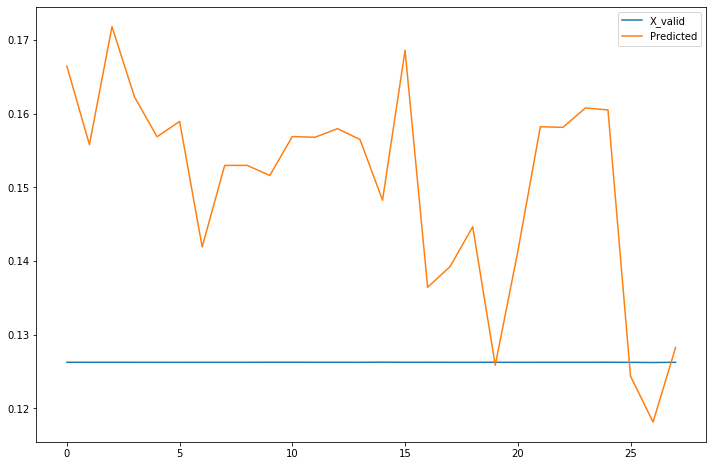

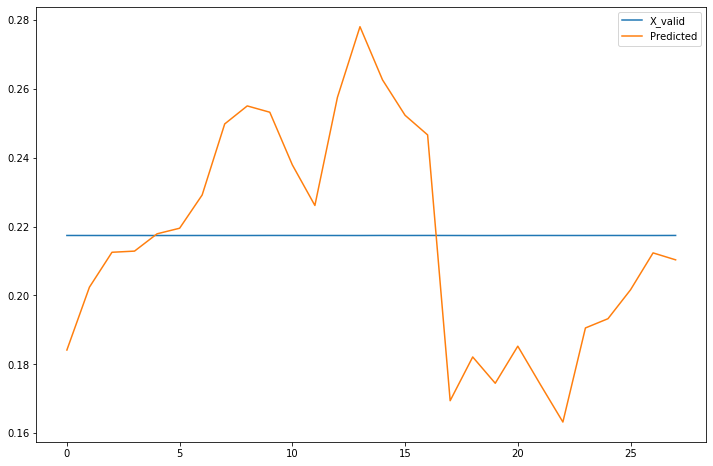

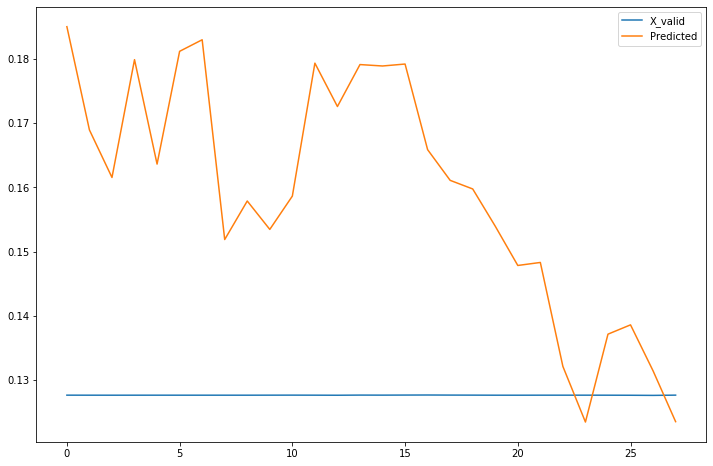

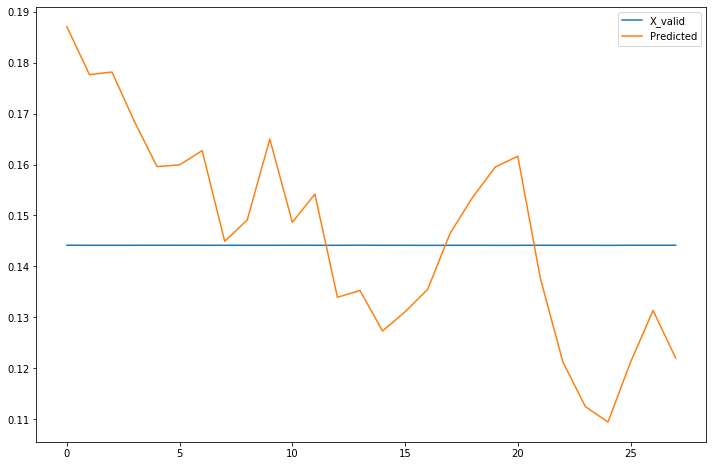

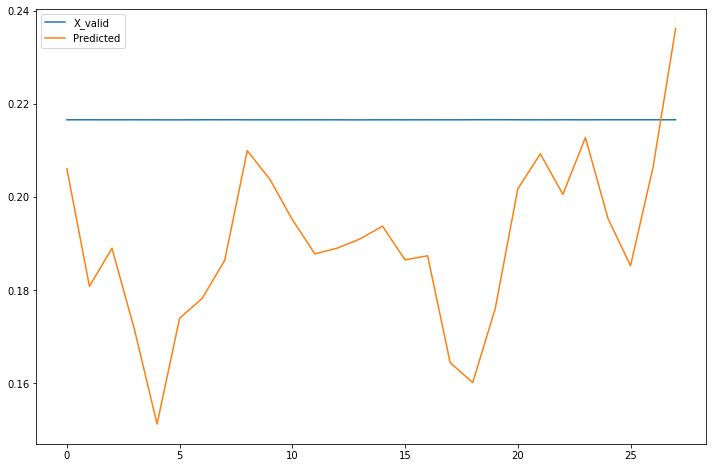

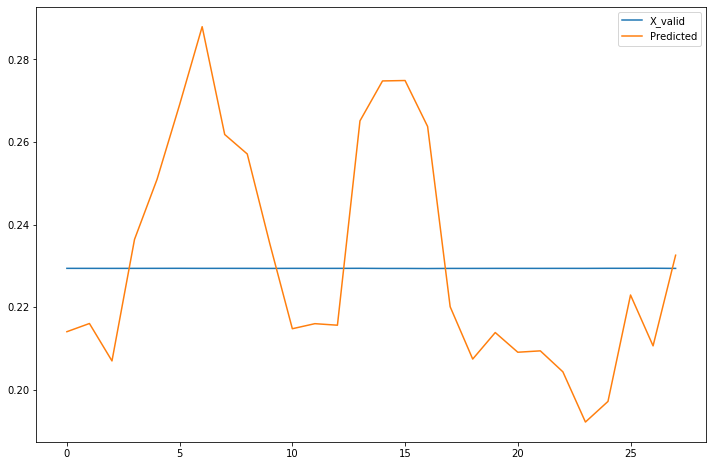

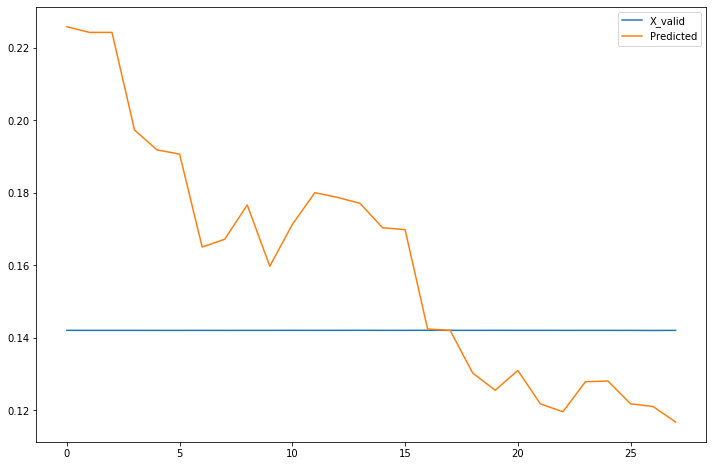

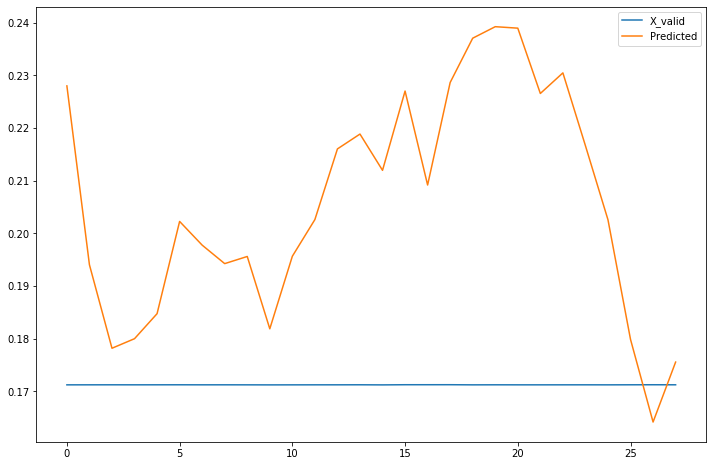

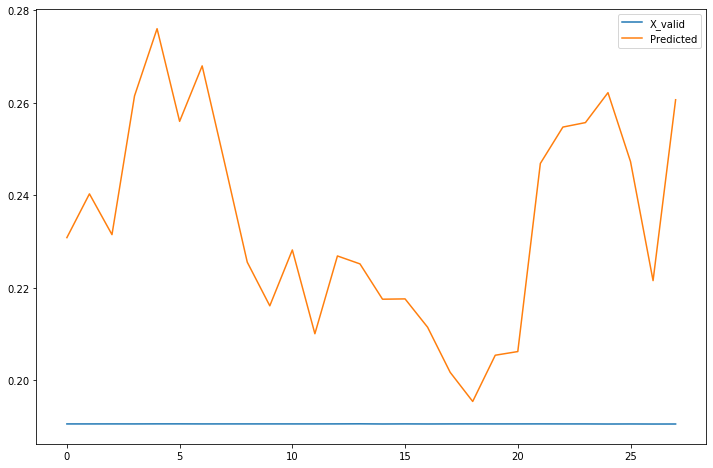

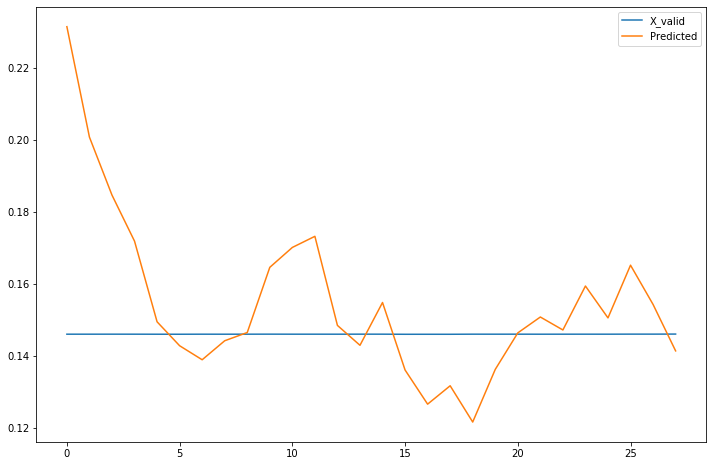

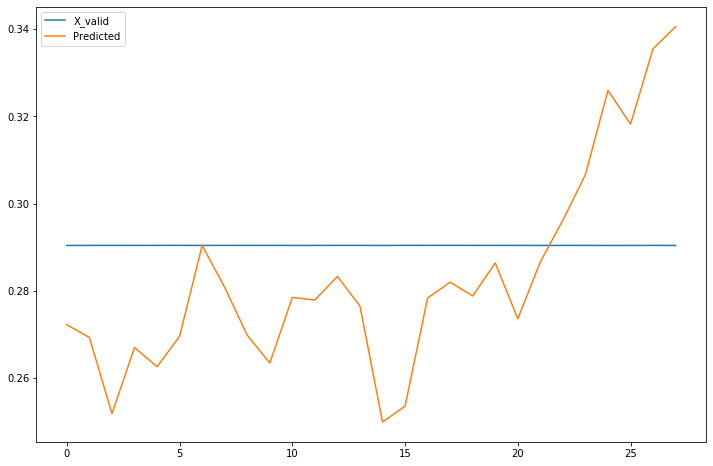

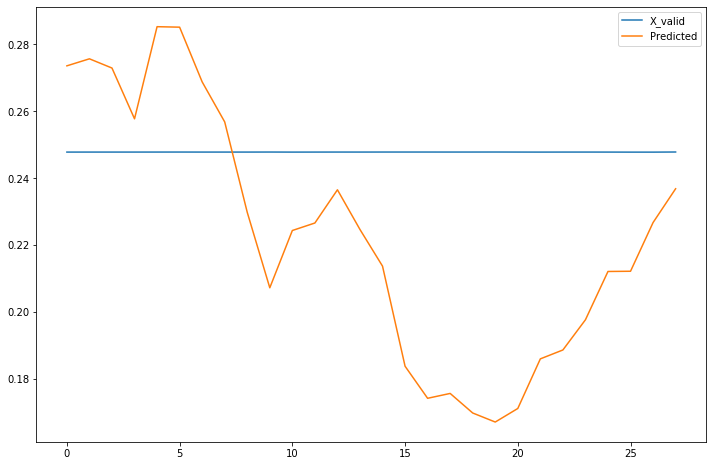

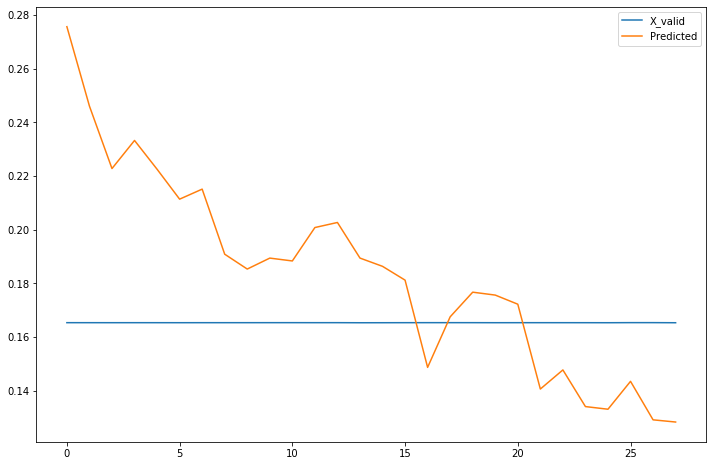

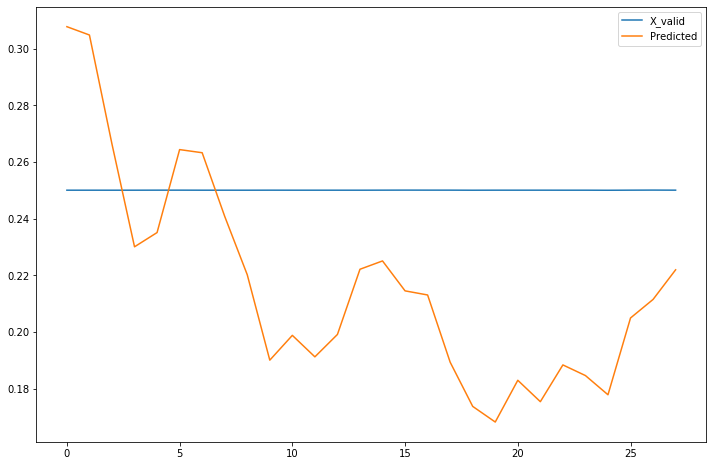

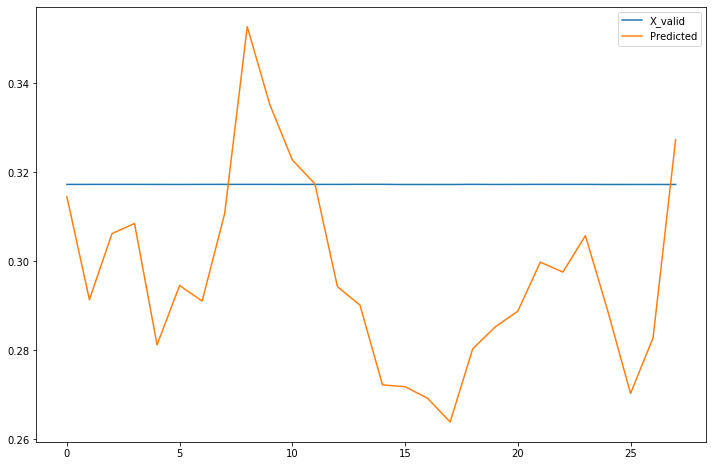

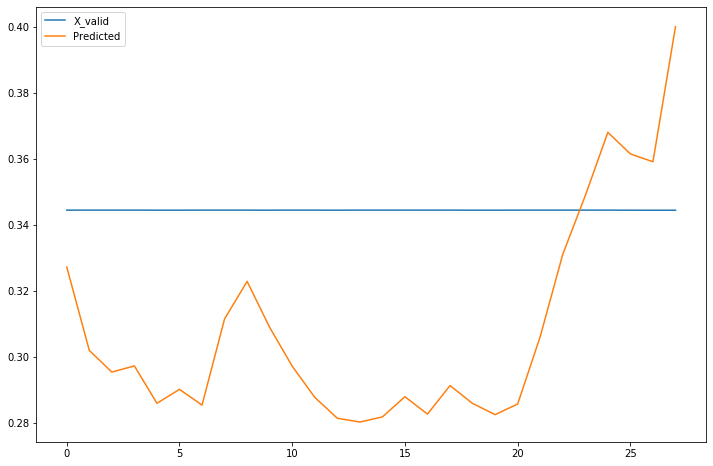

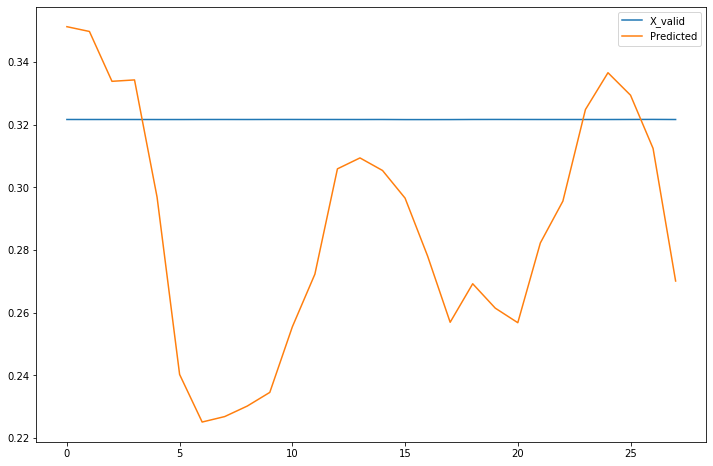

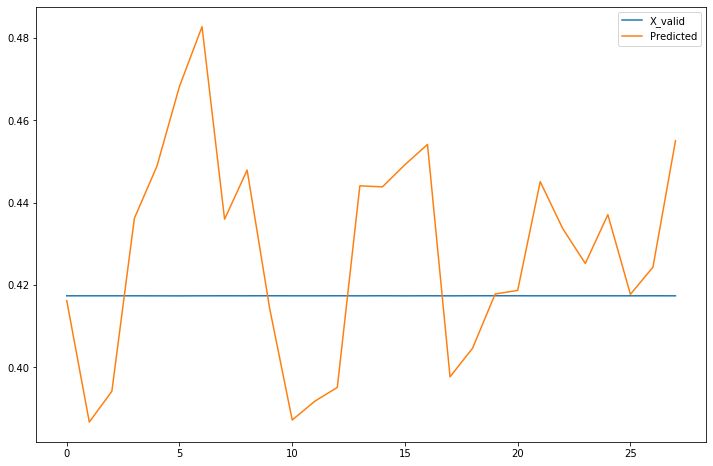

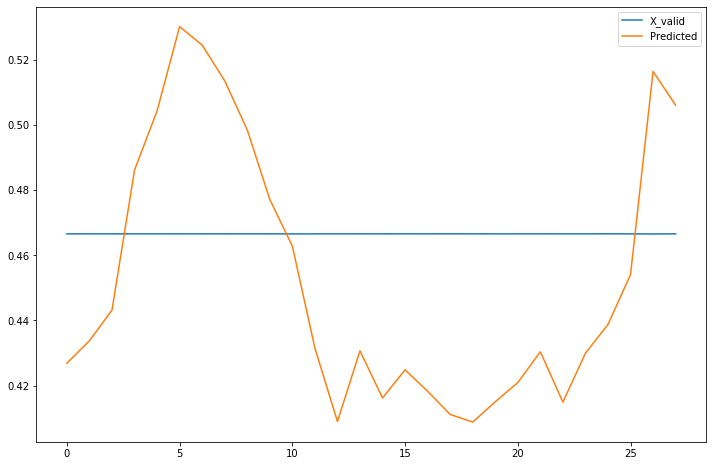

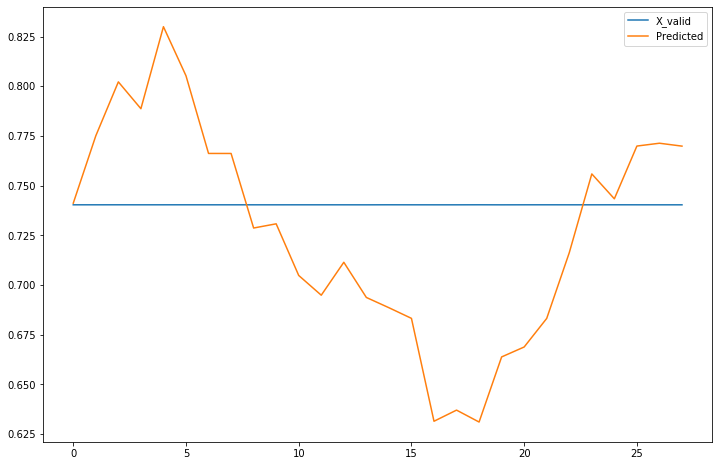

In [307]:
Predict = model.predict(X_valid)
for i in np.argsort(Y_valid)[:,-20:][0]:
    pd.DataFrame(np.transpose(np.vstack([Predict[:,i],Y_valid[:,i]])),columns=["X_valid","Predicted"]).plot(figsize=(12,8))

In [308]:
for i in range(Predict.shape[0]-1):
    diff_ts = Predict[i,:] - Predict[i+1,:]
    print(np.sum(diff_ts[np.argsort(diff_ts)]))

8.436758e-05
2.4692155e-05
-2.4693087e-05
-0.0005259253
-0.00020185392
0.00074565597
0.00018047541
-0.00038351864
0.00026562996
-0.00041406602
0.0003558686
-0.0014496036
0.0014160462
0.00012625754
-0.0023436174
-2.901256e-05
0.000696782
0.0009964257
-0.0005347617
0.0014123265
-0.0008938182
0.00051668845
0.000252062
0.000110108405
0.00075205043
0.0010715537
-0.0021801963
